In [160]:
import random
from itertools import combinations
import networkx as nx
from sortedcontainers import SortedDict
from sortedcontainers import SortedList

import numpy as np
from sklearn.neighbors import NearestNeighbors

### EZ még rossz : ha egy kilépés dominál, az nem lesz váltaztatva


def generate_agents(n, d):
    """Generate n agents with d-dimensional trait vectors.
    Each trait is an integer between 0 and 9."""
    return [tuple(random.random() for _ in range(d)) for _ in range(n)]

import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from collections import deque

def bfs(graph, start, l):
    """Perform BFS from the start node and return all nodes within distance l."""
    visited = {start}
    queue = deque([(start, 0)])  # (node, current_distance)
    
    while queue:
        node, dist = queue.popleft()
        
        if dist < l:  # Only explore neighbors within distance l
            for neighbor in graph.neighbors(node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, dist + 1))
    
    return visited


def calculate_relationships_kNN(agents, k, l):
    """
    Calculate friendship and enemy graphs based on k-nearest neighbors and distance threshold l.
    
    Parameters:
    - agents: List of points in d-dimensional space (numpy array).
    - k: Number of nearest neighbors to consider.
    - l: Distance threshold for enmity.
    
    Returns:
    - friendship_edges: List of pairs of agent indices that are friends.
    - enemy_edges: List of pairs of agent indices that are enemies.
    """
    # Initialize variables
    n = len(agents)
    friendship_edges = []
    enemy_edges = []
    
    # Use NearestNeighbors to find k nearest neighbors for each agent
    nbrs = NearestNeighbors(n_neighbors=k).fit(agents)
    distances, indices = nbrs.kneighbors(agents)
    
    # Check pairwise distances and determine friendships and enmities
    for i in range(n):
        for j in indices[i]:
            # Check if agent i and j are within each other's k-nearest neighbors
            if i in indices[j]:
                friendship_edges.append((i, j))
            
            # Calculate the distance between i and j in the k-nearest neighbors graph

    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(friend_edges)

    for i in range(n):
        # Get all nodes within distance l in the graph
        for j in range(i+1,n):
            manhattan_distance = np.sum(np.abs(x - y) for x, y in zip(agents[i], agents[j]))
            if manhattan_distance >= l:
                enemy_edges.append((i, j))
    
    return friendship_edges, enemy_edges
    


def calculate_relationships(agents, l1, l2, k1, k2):
    """Calculate friendship and enemy graphs based on the trait difference rules."""
    n = len(agents)
    friendship_edges = []
    enemy_edges = []

    for i, j in combinations(range(n), 2):
        diff = [abs(agents[i][dim] - agents[j][dim]) for dim in range(len(agents[0]))]
        friend_condition = sum(d <= l1 for d in diff) >= l2
        enemy_condition = sum(d >= k1 for d in diff) >= k2

        if friend_condition:
            friendship_edges.append((i, j))
        if enemy_condition:
            enemy_edges.append((i, j))

    return friendship_edges, enemy_edges

def create_graph(edges, n):
    """Create a graph from edges."""
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(edges)
    return G

from collections import defaultdict

def locally_popular_clustering(agents, friendship_graph, enemy_graph, initial_clustering, allow_exit=False, print_steps = False):
    """Perform clustering to achieve local popularity."""
    # Initialize clustering and cluster-to-agents mapping
    clustering = initial_clustering.copy()  # Map agent to cluster ID
    cluster_to_agents = defaultdict(set)
    for agent, cluster in clustering.items():
        cluster_to_agents[cluster].add(agent)
    
    # Precompute (f, e) values for each agent in all clusters
    f_e_values = defaultdict(lambda: defaultdict(lambda: [0, 0]))  # {agent: {cluster: [f, -e]}}
    for v in range(len(agents)):
        for cluster in cluster_to_agents:
            friends_in_cluster = sum(1 for neighbor in friendship_graph.neighbors(v) if neighbor in cluster_to_agents[cluster])
            enemies_in_cluster = sum(1 for neighbor in enemy_graph.neighbors(v) if neighbor in cluster_to_agents[cluster])
            f_e_values[v][cluster] = [friends_in_cluster, enemies_in_cluster]

    stable = False
    num_switches = 0
    while not stable:
        stable = True

        for v in range(len(agents)):
            current_cluster = clustering[v]
            [f_current, e_current] = f_e_values[v][current_cluster]  
            best_move = None
            best_vote = 0  # Track best improvement (f, -e)
            block = False
            # Evaluate moves to existing clusters
            for candidate_cluster in cluster_to_agents:
                if candidate_cluster == current_cluster:
                    continue
               
                [f_target, e_target] = f_e_values[v][candidate_cluster]
                vote = 0
                current_score = f_current - e_current
                new_score = f_target - e_target
                if new_score > current_score + 1 or (new_score >= current_score and new_score + f_target > current_score + f_current):
                    # Improvement detected
                    vote = f_target - e_target - f_current + e_current
                    block = True
                if f_target > f_current or (f_target == f_current and e_target < e_current):
                    vote += 1 # v improves
                if block and vote > best_vote:
                    best_move = candidate_cluster
                    best_vote = vote
            
            # Evaluate exit (if allowed)
            if allow_exit:
                vote = 0
                if 0 > f_current-e_current + 1 or (0 >= 2* f_current - e_current + 1 and 0 >= f_current-e_current):
                    vote = -f_current + e_current 
                    block = True
                if f_current == 0 and e_current > 0:
                    vote += 1 # v improves
                if block and vote > best_vote:
                    best_move = "exit"
                    best_vote = vote

            # Make the best move if it's an improvement
            if best_move is not None:
                stable = False
                
                # Update cluster mappings
                cluster_to_agents[current_cluster].remove(v)
                if best_move == "exit":  # Create a new cluster for this agent
                    new_cluster_id = max(cluster_to_agents.keys()) + 1
                    clustering[v] = new_cluster_id
                    cluster_to_agents[new_cluster_id].add(v)
                    best_move = new_cluster_id
                else:
                    clustering[v] = best_move
                    cluster_to_agents[best_move].add(v)


                # Update (f, e) values for affected agents
                for neighbor in friendship_graph.neighbors(v):
                    if neighbor in clustering:  # Only update if neighbor exists in the clustering
                        f_e_values[neighbor][current_cluster][0] -= 1  # Friend leaves
                        f_e_values[neighbor][best_move][0] += 1  # Friend joins
                
                for neighbor in enemy_graph.neighbors(v):
                    if neighbor in clustering:  # Only update if neighbor exists in the clustering
                        f_e_values[neighbor][current_cluster][1] -= 1  # Enemy leaves
                        f_e_values[neighbor][best_move][1] += 1  # Enemy joins
                num_switches += 1
                if print_steps:
                    print(f"{v} swithces to {best_move}")
               # print(f"{f_e_values[v][current_cluster]}")
               # print(f"{f_e_values[v][best_move]}")
                break
    print(num_switches)
    return clustering


      

# Parameters
n = 100  # Number of agents
d =  2   # Number of traits


l1,l2 = 0.1, 2   # l2 coords must be within l1 dist
k1,k2 = 0.2, 1   # k2 coords must be at least k1 dist

# Generate agents and graphs
agents = generate_agents(n, d)
friend_edges, enemy_edges = calculate_relationships(agents, l1, l2, k1, k2)
friend_graph = create_graph(friend_edges, n)
enemy_graph = create_graph(enemy_edges, n)
initial_clustering = {i: i%5 for i in range(len(agents))}

# Perform clustering
final_clustering = locally_popular_clustering(agents, friend_graph, enemy_graph, initial_clustering)

# Output results
print("Final Clustering:", final_clustering)


111
Final Clustering: {0: 4, 1: 2, 2: 4, 3: 2, 4: 1, 5: 4, 6: 0, 7: 1, 8: 2, 9: 4, 10: 4, 11: 0, 12: 1, 13: 4, 14: 2, 15: 4, 16: 1, 17: 2, 18: 2, 19: 2, 20: 3, 21: 2, 22: 3, 23: 2, 24: 3, 25: 0, 26: 0, 27: 0, 28: 1, 29: 3, 30: 1, 31: 2, 32: 3, 33: 1, 34: 4, 35: 4, 36: 2, 37: 2, 38: 0, 39: 4, 40: 0, 41: 0, 42: 2, 43: 0, 44: 3, 45: 1, 46: 0, 47: 3, 48: 2, 49: 3, 50: 2, 51: 4, 52: 3, 53: 2, 54: 1, 55: 4, 56: 0, 57: 3, 58: 3, 59: 2, 60: 3, 61: 1, 62: 4, 63: 3, 64: 4, 65: 0, 66: 1, 67: 3, 68: 3, 69: 4, 70: 0, 71: 1, 72: 1, 73: 0, 74: 2, 75: 4, 76: 1, 77: 1, 78: 4, 79: 2, 80: 0, 81: 3, 82: 2, 83: 4, 84: 4, 85: 2, 86: 1, 87: 0, 88: 2, 89: 3, 90: 2, 91: 1, 92: 2, 93: 3, 94: 2, 95: 3, 96: 2, 97: 0, 98: 0, 99: 4}


C:\Users\User\AppData\Local\Temp\ipykernel_5476\329486177.py:78: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  manhattan_distance = np.sum(np.abs(x - y) for x, y in zip(agents[i], agents[j]))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


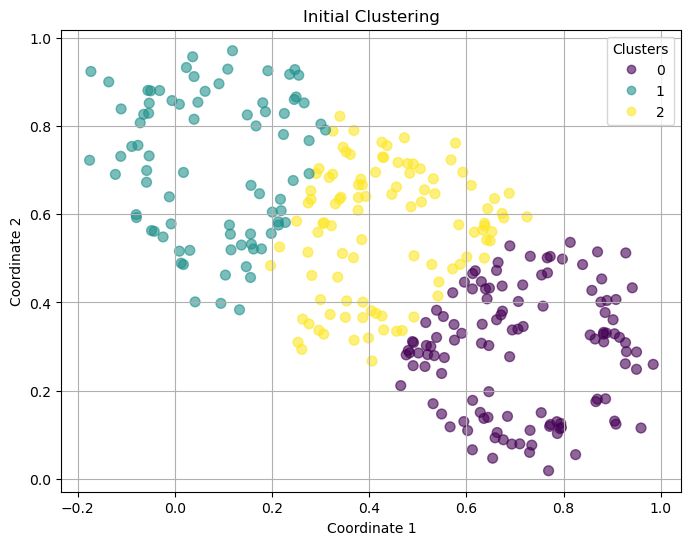

13


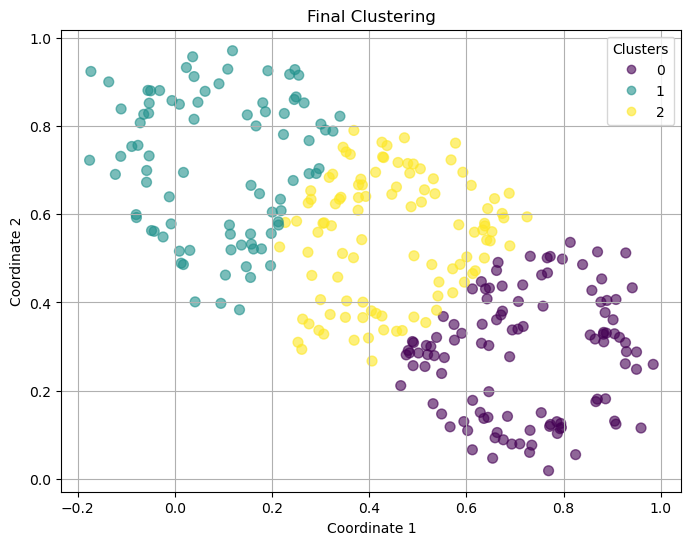

0.34646581651655967
0.35132970672374814
0.9761249798543318
0.9826053556581923


In [145]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import mutual_info_score, adjusted_rand_score
from sklearn.datasets import make_circles




import matplotlib.pyplot as plt
import numpy as np

kmeans = KMeans(n_clusters = 3)

def plot_clustering(points, clusters, title):
    """
    Plots the given clustering.
    
    Parameters:
    - points (list or array): A list or array of points where each entry is a list/array of coordinates.
    - clusters (dict): A dictionary where keys are point indices (0 to n-1) and values are cluster indices.
    """
    # Convert points to a numpy array for easier processing
    data = np.array(points)
    cluster_labels = np.array([clusters[i] for i in range(len(points))])  # Extract cluster labels
    
    # Check if the points are 2D
    if data.shape[1] != 2:
        raise ValueError("Only 2D data can be visualized. Your data has {} dimensions.".format(data.shape[1]))
    
    # Scatter plot for clustering
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap="viridis", s=50, alpha=0.6)
    
    # Add legend
    plt.legend(handles=scatter.legend_elements()[0], labels=set(cluster_labels), title="Clusters")
    plt.title(title)
    plt.xlabel("Coordinate 1")
    plt.ylabel("Coordinate 2")
    plt.grid()
    plt.show()



# Parameters
n = 300  # Number of agents
d =  2   # Number of traits
l1,l2 = 0.2, 2
k1,k2 = 0.3, 1

# Generate agents and initial clustering
agents = my_make_circles(n)

friend_edges, enemy_edges = calculate_relationships_kNN(agents, 10,0.5)
friend_graph = create_graph(friend_edges, n)
enemy_graph = create_graph(enemy_edges, n)


init_labels = kmeans.fit_predict(agents)
initial_clustering = {i: init_labels[i] for i in range(n)}
plot_clustering(agents, initial_clustering, "Initial Clustering")
# Perform clustering
final_clustering = locally_popular_clustering(agents, friend_graph, enemy_graph, initial_clustering)

#final_from_all_alone = locally_popular_clustering(agents, friend_graph, enemy_graph, {i : i for i in range(len(agents))} )

# Plot initial and final clusters

plot_clustering(agents, final_clustering, "Final Clustering")
#plot_clustering(agents, final_from_all_alone, "Final from all alone")


print(silhouette_score(agents, list(final_clustering.values())))
#print(silhouette_score(agents, list(final_from_all_alone.values())))
print(silhouette_score(agents, init_labels))


print(davies_bouldin_score(agents, list(final_clustering.values())))
#print(davies_bouldin_score(agents, list(final_frdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAArMAAAIhCAYAAABdSTJTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3gc5bX48e/MbG9a9V5suckV94YbYIPphAAJAUIu5IZA4HLJTW7yS4M0QgrhhgAJaRBCAqF3G1OMAWPcqyzbkq3etdL2OjO/P0ZeLCQbAy7Yfj/Pw5N4d8q7M5J99p3zniPpuq4jCIIgCIIgCCcg+XgPQBAEQRAEQRA+KRHMCoIgCIIgCCcsEcwKgiAIgiAIJywRzAqCIAiCIAgnLBHMCoIgCIIgCCcsEcwKgiAIgiAIJywRzAqCIAiCIAgnLBHMCoIgCIIgCCcsEcwKgiAIgiAIJywRzAqCcMJ66KGHkCSJ9evXf6L9JUni9ttvT/+5urqa22+/nfr6+kHbXnvttVRUVHyi83zcfV944QUuuOAC8vPzsVgsZGVlceaZZ/Loo4+STCYPOv4jKRKJcPvtt7Ny5cqjcvyVK1ciSdJRO74gCKcOEcwKgnDKeu+997j++uvTf66uruaOO+4YMpj9wQ9+wDPPPHNUx6PrOl/5yle48MIL0TSNu+++m9dee42HH36YSZMmceONN3L//fcf1THsF4lEuOOOO45asDllyhTee+89pkyZclSOLwjCqcN0vAcgCIJwvMyaNeuwt62srDyKIzH86le/4qGHHuKOO+7ghz/84YD3LrjgAr797W9TW1t71MdxNCWTSSRJwuPxfKzrLwiCcDBiZlYQhJPKtddei8vlora2lnPPPReXy0VpaSnf/OY3icfjA7Y98DH9Qw89xGWXXQbAokWLkCQJSZJ46KGH0sf9cKrAfffdx/z588nLy8PpdDJhwgR++ctfDkgFOFzJZJK77rqLMWPG8IMf/GDIbQoKCjj99NMPeozbb78dSZIGvb4/HePAGec33niDhQsXkp2djd1up6ysjEsvvZRIJEJ9fT25ubkA3HHHHelrce2116b337NnD1deeSV5eXlYrVaqqqq47777Bpx3fyrBI488wje/+U2Ki4uxWq3U1tYOmWbwce5dc3Mzn//853G73Xi9Xr70pS+xbt26AfdMEIRTg5iZFQThpJNMJrnwwgu57rrr+OY3v8mqVav4yU9+QkZGxqAZz/3OO+88fv7zn/P//t//47777ks//j7UjGxdXR1XXnklw4YNw2KxsGXLFn72s59RU1PDX//614815vXr1+Pz+fjqV786ZEB6JNXX13Peeecxb948/vrXv+L1emlpaWHZsmUkEgkKCwtZtmwZ55xzDtddd106FWN/gFtdXc2cOXMoKyvjN7/5DQUFBSxfvpxbbrmF7u5ufvSjHw0433e/+11mz57NH/7wB2RZJi8vj/b29iHHdjj3LhwOs2jRInw+H3fddRcjRoxg2bJlXHHFFUfxqgmC8FklgllBEE46iUSCO+64Iz3TeuaZZ7J+/Xr++c9/HjSYzc3NZeTIkQCMHTv2sB6B33333en/r2ka8+bNIzs7m6985Sv85je/ITMz87DH3NjYCMCwYcMOe59PasOGDcRiMX71q18xadKk9OtXXnll+v9PnToVgJKSkkHX4rbbbsPtdvPOO+/g8XgAWLx4MfF4nF/84hfccsstAz57ZWUlTzzxxGGN7XDu3cMPP0xtbS2vvPIK55xzDgBLliwhEonwxz/+8eNeDkEQTnAizUAQhJOOJElccMEFA16bOHEiDQ0NR/Q8mzZt4sILLyQ7OxtFUTCbzVxzzTWoqsru3buP6LmOpNNOOw2LxcJ//ud/8vDDD7N3797D3jcWi/H6669zySWX4HA4SKVS6f/OPfdcYrEYa9asGbDPpZdeetjHP5x799Zbb+F2u9OB7H5f/OIXD/s8giCcPEQwKwjCScfhcGCz2Qa8ZrVaicViR+wcjY2NzJs3j5aWFv7v//6Pt99+m3Xr1qXzRqPR6Mc6XllZGQD79u07YmM8mMrKSl577TXy8vK46aabqKyspLKykv/7v//7yH17enpIpVLce++9mM3mAf+de+65AHR3dw/Yp7Cw8LDHdjj3rqenh/z8/EH7DvWaIAgnP5FmIAiC8Ak8++yzhMNhnn76acrLy9Ovb968+RMdb9q0aWRlZfHcc89x5513fqK82f1BYDwex2q1pl//cHAJMG/ePObNm4eqqqxfv557772XW2+9lfz8fL7whS8c9ByZmZkoisLVV1/NTTfdNOQ2H06VONI5wNnZ2axdu3bQ6wfLwxUE4eQmZmYFQRD67Q8AD2dWdX+AdmDQqOs6f/rTnz7Ruc1mM//7v/9LTU0NP/nJT4bcprOzk3ffffegx9hfbWHr1q0DXn/hhRcOuo+iKMycOTM9o7xx40bg4NfC4XCwaNEiNm3axMSJE5k2bdqg/7Kzsw/9YT+lBQsWEAwGeeWVVwa8/thjjx3V8wqC8NkkZmYFQRD6jR8/HoAHH3wQt9uNzWZj2LBhQwZnixcvxmKx8MUvfpFvf/vbxGIxHnjgAXp7ez/x+b/1rW+xc+dOfvSjH7F27VquvPJKSktL8fv9rFq1igcffJA77riDuXPnDrn/ueeeS1ZWFtdddx0//vGPMZlMPPTQQzQ1NQ3Y7g9/+ANvvPEG5513HmVlZcRisXT1hbPOOgsAt9tNeXk5zz33HGeeeSZZWVnk5ORQUVHB//3f/3H66aczb948vv71r1NRUUEwGKS2tpYXXniBN9544xNfg8Px5S9/md/+9rdcddVV/PSnP2XEiBG88sorLF++HABZFvM0gnAqEb/xgiAI/YYNG8Y999zDli1bWLhwIdOnTz/orOaYMWN46qmn6O3t5XOf+xw333wzp512Gr/73e8+8fklSeJvf/sbzz33HAC33norZ5xxBtdccw3r16/nrrvu4utf//pB9/d4PCxbtgy3281VV13FDTfcwPjx4/ne9743YLvTTjuNVCrFj370I5YuXcrVV19NV1cXzz//PEuWLElv95e//AWHw8GFF17I9OnT0zV5x44dy8aNGxk/fjzf//73WbJkCddddx1PPvkkZ5555if+/IfL6XSm6+R++9vf5tJLL6WxsTHdHc3r9R71MQiC8Nkh6bquH+9BCIIgCMKn9fOf/5zvf//7NDY2UlJScryHIwjCMSLSDARBEIQTzu9//3vAmCFPJpO88cYb/O53v+Oqq64SgawgnGJEMCsIgiCccBwOB7/97W+pr68nHo9TVlbG//7v//L973//eA9NEIRjTKQZCIIgCIIgCCcssQBMEARBEARBOGGJYFYQBEEQBEE4YYlgVhAEQRAEQThhnXILwDRNo7W1FbfbfcRbLAqCIAiCIAifnq7rBINBioqKPrIRyikXzLa2tlJaWnq8hyEIgiAIgiB8hKampo8st3fKBbNutxswLo7H4znOozn5JJNJXn31VZYsWYLZbD7ewxEOk7hvJy5x705M4r6dmMR9O3YCgQClpaXpuO1QTrlgdn9qgcfjEcHsUZBMJnE4HHg8HvGLfgIR9+3EJe7diUnctxOTuG/H3uGkhIoFYIIgCIIgCMIJSwSzgiAIgiAIwglLBLOCIAiCIAjCCeuUy5kVBEEQBEE43nRdJ5VKoarq8R7KcWM2m1EU5VMfRwSzgiAIgiAIx1AikaCtrY1IJHK8h3JcSZJESUkJLpfrUx1HBLOCIAiCIAjHiKZp7Nu3D0VRKCoqwmKxnJJNnHRdp6uri+bmZkaOHPmpZmiPezB7//3386tf/Yq2tjbGjRvHPffcw7x58w66/X333cfvf/976uvrKSsr43vf+x7XXHPNMRyxIAiCIAjCJ5NIJNA0jdLSUhwOx/EeznGVm5tLfX09yWTyxA1mH3/8cW699Vbuv/9+5s6dyx//+EeWLl1KdXU1ZWVlg7Z/4IEH+O53v8uf/vQnpk+fztq1a/nqV79KZmYmF1xwwXH4BIIgCIIgCB/fR7VoPRUcqRnp43ol7777bq677jquv/56qqqquOeeeygtLeWBBx4YcvtHHnmEr33ta1xxxRUMHz6cL3zhC1x33XXcddddx3jkgiAIgiAIwmfBcZuZTSQSbNiwge985zsDXl+yZAmrV68ecp94PI7NZhvwmt1uZ+3atSSTySG7ccTjceLxePrPgUAAMLp4JJPJT/sxhA/Zf03FtT2xiPt24hL37sQk7tuJ6Ujct2Qyia7raJqGpmlHamgnJE3T0HV9yDSDj3ONj1sw293djaqq5OfnD3g9Pz+f9vb2Ifc5++yz+fOf/8zFF1/MlClT2LBhA3/9619JJpN0d3dTWFg4aJ8777yTO+64Y9Drr7766imfq3I0rVix4ngPQfgExH07cYl7d2IS9+3E9Gnum8lkoqCggFAoRCKR+ETHyMzM5B//+AfnnXfeJx7HZ0EikSAajbJq1SpSqdSA9z5OpYfjvgDsw/kSuq4fNIfiBz/4Ae3t7cyaNQtd18nPz+faa6/ll7/85UETh7/73e9y2223pf8cCAQoLS1lyZIleDyeI/dBBMD4JrVixQoWL14s+lafQMR9O3GJe3diEvftxHQk7lssFqOpqQmXyzXoafN+7e3t/PznP+fll1+mpaWFvLw8Jk2axH/9139x5plnAsaT6SMRx6xcuZIzzzyTnp4evF7vpz7exxGLxbDb7cyfP3/Qtdj/JP1wHLdgNicnB0VRBs3CdnZ2Dpqt3c9ut/PXv/6VP/7xj3R0dFBYWMiDDz6I2+0mJydnyH2sVitWq3XQ62azWfwFchSdrNdXTans3rCXrW/toLvFh9VuYfT0EUyYX4U3N+N4D+9TO1nv26lA3LsTk7hvJ6ZPc99UVUWSJGRZHnIRWH19PXPnzsXr9fLLX/6SiRMnkkwmWb58OTfffDM1NTUAB93/49p/jE97PF3XUVUVk+nwQ0tZlpEkacjr+XGu73FbAGaxWJg6deqgqfoVK1YwZ86cQ+5rNpspKSlBURQee+wxzj//fLEqUDjqgr0h/vaDx/jLdx9lzQsbaNrZQs3aWp767Yvce9Of2fb2zuM9REEQBOEEd+ONNyJJEmvXruXzn/88o0aNYty4cdx2222sWbNm0PYrV65EkiT6+vrSr23evBlJkqivrwegoaGBCy64gMzMTJxOJ+PGjePll1+mvr6eRYsWAUbqgiRJXHvttYARnP7yl79k+PDh2O12Jk2axJNPPjnovMuXL2fatGlYrVbefvtttmzZwqJFi3C73Xg8HqZOncr69euP2vWC45xmcNttt3H11Vczbdo0Zs+ezYMPPkhjYyM33HADYKQItLS08Pe//x2A3bt3s3btWmbOnElvby93330327dv5+GHHz6eH0M4Bagplcd/+RxbV1VTWJGH3fXB4xBN02jb28m/f/0cDo+dykkVx2+ggiAIwgnL5/OxbNkyfvazn+F0Oge9/0nTAG666SYSiQSrVq3C6XRSXV2Ny+WitLSUp556iksvvZRdu3bh8Xiw2+0AfP/73+fpp5/mgQceYOTIkaxatYqrrrqK3NxcFixYkD72t7/9bX79618zfPhwvF4vCxYsYPLkyTzwwAMoisLmzZuP+tOH4xrMXnHFFfT09PDjH/+YtrY2xo8fz8svv0x5eTkAbW1tNDY2prdXVZXf/OY37Nq1C7PZzKJFi1i9ejUVFRXH6ROc2HRdp7Gmhfa9Heg65JZmM2xCmZjlHsLuDXupeX/PoEAWjMckRZX5NFQ38/ZTaxg+sfyU7OYiCIIgfDq1tbXous6YMWOO6HEbGxu59NJLmTBhAgDDhw9Pv5eVlQVAXl5eOlgOh8PcfffdvPHGG8yePTu9zzvvvMMf//jHAcHsj3/8YxYvXjzgXN/61rfSn2HkyJFH9LMM5bgvALvxxhu58cYbh3zvoYceGvDnqqoqNm3adAxGdfJrrGnhlb+8xr6tjcQiCSQJzFYzpWOKOPvaRYyaWnm8h/iZsvWtHahJdVAgu58kSWQVZrJn4166mnvIKx06h1sQBEEQDkbXdeDINRPY75ZbbuHrX/86r776KmeddRaXXnopEydOPOj21dXVxGKxAUEqGNUHJk+ePOC1adOmDfjzbbfdxvXXX88jjzzCWWedxWWXXUZl5dGNKcQU3CmoYWczf//R4+xcswd3lovyqmLKq0rIzMtg39YG/vGTJ6lZu+d4D/MzZf9ir0NxuGzEIwmCvtAxGpUgCIJwMhk5ciSSJLFz5+Gvwdj/NHV/IAyDa7Ref/317N27l6uvvppt27Yxbdo07r333oMec3/925deeonNmzen/6uurh6QNwsMSoe4/fbb2bFjB+eddx5vvPEGY8eO5Zlnnjnsz/NJiGD2FKNpGi//6TW6W32UjynB6XGkvwHaXTZKRxcT7ovwwh9eJREXxbz3s9otpFLqIbdJpVRkRcZk/uT9pQVBEIRTV1ZWFmeffTb33Xcf4XB40PsHLvLaLzc3FzBSM/fbvHnzoO1KS0u54YYbePrpp/nmN7/Jn/70J8BYkA9GKud+Y8eOxWq10tjYyIgRIwb8V1pa+pGfY9SoUfz3f/83r776Kp/73Of429/+9pH7fBoimD3FNFQ3U7+9ibzSHCR58GMMSZLIL8+hfV8nu9bWHocRfjaNnj6CVCJ1yG4tfZ1+coqzKKwsOIYjEwRBEE4m999/P6qqMmPGDJ566in27NnDzp07+d3vfpfOXz3Q/gDz9ttvZ/fu3bz00kv85je/GbDNrbfeyvLly9m3bx8bN27kjTfeoKqqCoDycmOdx4svvkhXVxehUAi3283//M//8N///d88/PDD1NXVsWnTJu67775DLrqPRqN84xvfYOXKlTQ0NPDuu++ybt269LmOFhHMnmLa6jpIRBMHzf0EsNgsqCmNtr0dx3Bkn20T5leRVZhJ297OAY9y9ouGYsQiCWYsnYzFKmpGCoIgCJ/MsGHD2LhxI4sWLeKb3/wm48ePZ/Hixbz++us88MADg7Y3m83861//oqamhkmTJnHXXXfx05/+dMA2qqpy0003UVVVxTnnnMPo0aO5//77ASguLuaOO+7gO9/5Dvn5+XzjG98A4Cc/+Qk//OEPufPOO6mqquLss8/mhRdeYNiwYQcdu6Io9PT0cM011zBq1Cguv/xyli5dOmQn1iPpuC8AE44tTdNA+ujkckkCTRsctJ2qvLkZXHzzUp74zfM0VDeTVZiJw2UjlVLp6/QTjyaYctYE5lw843gPVRAEQTjBFRYW8vvf/57f//73Q77/4UmVuXPnsnXr1oNuc6j8WDA6rP7gBz8Y8JokSdxyyy3ccsstQ+6zcOHCQeOwWCz861//OuS5jgYRzJ5icoqzUEwK8Ugcq2NwZzSAVFJNbyt8YOL8sTgzHLz91Br2bNxLoCeIrMjkFGcx89wpzL5o+lGflY1F4vR29BnVEwq8WGyHXpQmCIIgCCc7EcyeYkZMHkbRiAJa9rRRMrJwyBna7pYecoqzGDt71HEY4Wdb5aQKhk8sp6u5h6AvhMmsUFhZcNSD2IAvyJoXNrB++WYC/dUSvLkepp8zmZnnTcHlHVxcWxAEQRBOBSJn9hRjMptY8uWF2Jw2WuvaSSZS6ffUlEp7vZETetZV83G47cdxpJ9dkiSRV5pD5aQKyseWHvVAtrejj799/zFeenAFob4wGdluMrLd+LsCPP/Ach764WP4uwNHdQyCIAiC8FklZmZPQePnjuGKb1/ESw+uoG1vR39urI6ERFahl8XXLGTGuVOO9zAFjJynZ373Mnu31FM6qgiT5YNfWbvLRjKeZM+Gvbzwh1e56vufP44jFQRBEITjQwSzp6iJ88cyalol1e/t7m9nq5NbmsO4uaNxehzHe3hCv5Y9bezZuJfckuwBgex+ZquZ7MJMdr63m/b6Tgoq8o7DKAVBEATh+BHB7HEQDkQI9YYxWUxkFXiPeNu6w2VzWJly5gQ4c8JxOb/w0eo21xMNxg7ZHted5cK3s5m9WxpEMCsIgiCcckQwewy11rXz/ksb2PJWNfFIHFmWKRldxMxzp3DaGePTLekEYb9ELIkkS4f8wiNJxvuJWOIYjkwQBEEQPhtEMHuM7N5Qx2O/eJaeVh8ZOR48WW5SSZXaTfuo21xPQ3UzF950NooiWqEebaqqkoynsNjMn+gLRE9bL7vX1xENRrE5bYyaNpyc4uyjMFJweh3oulEf+GBjVfvb7DpFRQNBEAThFCSC2WMg4Avy5G9ewN/lp2Jc6YBZNnemk6AvxDvPvE9RZT4zz5t6HEd6cmve3crG17ay9a1qkokUNpeNqWdNZMriieQUfXRN3Wg4xit/fo1Nb2wn6AshSRK6ruPyOpm4YBznf23xEa8AUTVrFJ5sF32dAbIKvENu09vhx5uXwZgZI47ouQVBEAThRCCeax8D21btpLOxm6IRQ9d1dWe5kGWZNS9uSM+yCUfW+le38Mdv/Z3XH32bWDiGLEkEugK89OAK/vjNh6ndtO+Q+yfiSf79q+d4699rkGWZsjHFlFeVUD6mBJPZxLvPvM+/7nyaeDR+RMedmZfBjKWTCfhChPrCg94P+kKEAxFmnT8Vd6briJ5bEARBOLFomkbz7lZ2rauleXer0fXzFCBmZo+B6vd2YbKYUJSDf3fIzM+gbW8Hbfs6KRlZeAxHd/Lbt62BZ+99mVQiNWBmPIP+X/w9bTz+y+e48Z5rycz3DnmM7W/vZMvKagoqcrG7bOnXJVnCm+vB5rSy/Z0aNr+5g5lHuKzZkmsXEQlGWbdsM92tPpxuBzo6kWAMq93C/M/P4swvzTui5xQEQRBOLLWb9vHq31fSWN1MIpbEYjNTNraEJdcsZMTkYUf13Pfffz+/+tWvaGtrY9y4cdxzzz3Mm3fs/l0SM7PHQCQYwzxEWaUDmS0m1JRGUiziOeLWvrKJUG+Y/PLcdCCrqhq+9j46GrowmU007Wph0xvbh9xf13XWLd+MhD4gkD2QzWFFMSmsW7bpiH8TtljNfP62C7j+F1cx6/xpZOR58OZnMPfi6Xz1rqu46BtLMZnF91JBEIRTVe2mfTzy4yfYs34vniwXxSML8WS52LN+L4/8+ImPfPr4aTz++OPceuutfO9732PTpk3MmzePpUuX0tjYeNTO+WHiX8BjIDM/g4Ydh76psUgcs82MM0PUeD2Swv4w1e/tIiPHY+S4At3NPbTUthMNRtEBdEglU/zrzqcZPb2S4hEDZ8aT8SRtde0f+Rjfk+Wio6GbaDCKM+PILsaSZZnR0yoZPa3yiB5XEARBOLFpmsarf19JoDtIWVVxetLG4XFQVmWncWcLKx55i+GTyo9K1aS7776b6667juuvvx6Ae+65h+XLl/PAAw9w5513HvHzDUXMzB4DE+ePBSQSseRBt+lt76NyUjm5h6gnKnx80VCMZDyF1W60nO1s7Gbv1gZi4RgOtx2314kr04HFZsbX2stDP3yctr0dQx/sCJYDTsSTbHt7J8/+/hUe/+WzLPvbmzTtakHX9QHbxaNxtr9bw3svrGf9q1voaes9coMQBEEQTnitte00VjeTW5I1aF2OJEnklmTRsKOJ1tr2I37uRCLBhg0bWLJkyYDXlyxZwurVq4/4+Q5GzMweA2Nnj2LYxDJqN+6jZFTRgJQDXdfpbOzG6rIx9+IZx62BwsnK5rRhsphIxJOY4kmad7WCBE73BzPgEkadVne2i86GLl79+1t8+fbL0++brWYKK/PZtW4v3tyMg54r4AtRPq4E+0dUNGisaeHJu1+gZU8bqaSKosioKY23/v0uE+eP5eKbl2J1WHnv+fW8/dQaupp60DQNXQd3lpMJ88ay9LozxIIvQRAEgbA/QiKWxOocOg3O6rCSaO0l7I8c8XN3d3ejqir5+fkDXs/Pz6e9/cgHzwcjgtljwGKz8MXvXMI/f/40+7Y1opgUbE4ralIlEoziyfFw/tcWM2bGyOM91JOOy+tk9PQRrF+2mVgkQTwaH1SPVdd11JRKTnE2nmw3u9fVDmgNK0kS08+ezK61dcTCMWxD/IURj8RRUyozzpl8yMc4nY1d/OMnT9LZ2EXR8HwsNkt6DKG+MGte2kgykSKvLIfXHnkLk9lEQUUuZqsZTdMI9AR595n36W7u4ct3XH7E0xkEQRCEE4szw3i6GA/HcAzRjj4eiWM5ymmMH56I03X9mE7OiWD2GMkpzuard13Ftrdr2PT6Vnpae7HYLMyfO5rTFo2ncHj+Rx/kEwj2hti2aidb3tpBoCeEy+tg4oJxTFowFk+2+6ic87Nm5rlT2PFuDe31nYCEfMAvmK7rhAMRrA4rOUWZWB1WY2FYfdeA1rDj51UxccFYNr2xncy8DDzZRjk1XdcJ9ATxtfcxYX4VkxaNP+RY3n1uHR31nZSPLRkQ9EqShDvThWJSWPvyRuLRJFanhQynDa0/9UCWZby5GTg9Dnatq+XdZ9ex5MsLj+i1EgRBEE4sRSMKKBtbwp71eymrsg8IInVdp6vZx6jplRSNKDji587JyUFRlEGzsJ2dnYNma48mEcweQ3aXnRlLJzNj6eRjcr6Gnc08/otnad3bjtliwmKz0N3cw54Ne3nn6TVc8e2LGT6x/JiM5WhLJVPsXl/H1lXV9LT2YnNaGTNjJBPmVTFi8jDOv2EJf/7OP4xvqFYTkiKjpVQS8RQ2h5XhE8uxOW3pnNUP565arGau+N+LcXmdbFm5g8aaFmNBmabj8DoYM3MkWkrjF1f9DlmRGTt7JNPPmUxZVUn6L5Zgb4gtb+4gI8cz5Oyt3r9N484WUokUzkwnnQ3dmK0msguzKB1tpKiYrWacHgfrX93C/MtmY3NYj/r1FQRBED6bZFlmyTUL6ajvonFnC7klWVgdVuKROF3NPjy5bhZfveCoLP6yWCxMnTqVFStWcMkll6RfX7FiBRdddNERP9/BiGD2JNXb0ce/fv40HQ1dlI4qQjF90CZXVTVa9rTxrzuf5j9/dQ25JUenFeux4u8O8Phdz7JrfR1aSsNit6AmU2xbtZOVj7/LJf91HnMunE5rbTvP3PsKoKOpGrJJoaQ8l9zibBweI8811BfB7raRWzr4mtidNj5/2wUs/MJcdq2tJRqKYbaaWb9sE28/uYZIMAqAJMGWlTtY/tBKzrnuTC6+6RwUk0Jfp59IMEp2YeagY+tAy542mna1kkqmkBQZT6YLXddJxBK07e0gFo4xamolJrOCJ8dNb0cf3c09lIwqOpqXVxAEQfiMGzF5GFf/8LIP6sy29mKxmRk1vZLFVy84qnVmb7vtNq6++mqmTZvG7NmzefDBB2lsbOSGG244auf8MBHMnqQ2vraN9n2dlI0pRv5QswZFkSkZVUhDdTMbXt3COf9xxnEa5aeXiCd57K5nqV69i8Lh+QNmKVVVo21vB4//8ln+42dXcuZV89n29k7i0QRZ+Rko5oGNLHRdp7vVx8T5VRRVHvxxTE5RFjkXzwDgvv/6K28/8z6KYgSYJrOCrunEwnF6Wnt5+rcvYndZOfe6s5BkGUmW0IeoQxv2R2ita8dkVpAVmf1PiSRJwmq3YrKY6Ov009HQRfGIAmRZQtdB0/RBxxIEQRBOPSMmD2P4pHJaa9sJ+yM4MxwUjSg4KjOyB7riiivo6enhxz/+MW1tbYwfP56XX36Z8vJj9+RXlOY6CWmaxoZXt2B32QYFsvvJsowzw8HG17aSSqaO8QiPnF1ra9m9ro6iDwWyYATtRSMK8LX1seqJ9/DmejjjynmoSZXeDj8ckEoQi8Rp3NVKdmEmi69ZmE4NCPWFWfPiBh7+0eP84ZsP8+9fP8/O9/cYaQ0b63jrifcwm014cz2YzSYkJGRZNsp+ZbqIBKO88ufXCfiC5JXlkFWQSV9XYNDn6Gn1kYynsNjNyLKELCsD3lcUBcWs0NXUjapqBHvDODwOsgq8R/6iCoIgCCckWZYpGVXE6OkjKBlVdNQD2f1uvPFG6uvricfjbNiwgfnz5x+T8+4nZmZPQvFognAgjM156FxKu9NGNBQjGoqdsGWeNr+5HU3XsX4okFVVjZ62Xrqaugl0B3nhgVfpbvVx+iUzOf+Gxax6cg3Ne9pANx7xmywK5WNLuOimcygbUwzA7g11PHn3i3Q1dSPLEiaziV3raln78kZGTask5A8TC8fIGiJtAMBkVrDYLHTUd7H9nRrmXDidGUsn89x9rxCPxAeMOdATxGRWSESS2Jx2dF0nGU9itprT21hslv57GyHQHeTMq+bh8opqBoIgCMKpTQSzJyGzxYRiMn1ka9xkMoViUgYETMdDPBpn17o6elp7kRWZ4hEFh92ppLulZ9CMbCqpUrt5H73tfSBJmMwK8WiS2o37aKppZeKCKm685yvs3dpAb3sfcn/axcgpw9O5xTXv7+H+2x4i2BMkM9+LO8udrmAQC8fY8W4Nnc09yLKMcohx2hwWAj3BdCOGWRdMpW7zPra9vRNPlgtvXgaKSSGVTBGPJrDYzJSPLSEaitHZ2IWm6VhsZiRJQgJSKSN1Ytj4Mub0pzoIgiAIwqlMBLMnIZPZxLg5o3n7qTVkF2UddLtAT5BZ5089bqvhdV1nw4qtvP6PVXQ0dqFrxjSp2WaidEwJF359CeVjSw95DLPVgpZSB7zWUN1ET2svDo8dU3+gqGk6RZX5yLLMpte24cly8bn/On/AfrFInL4uP2te3Mgzv3uZzoYubE4rYX8EWZFxZTipGF+Ky+ukaHg+9dXN6Kp2yHp6OkY2w/50D7vTxpXfu5TX/rGKTa9v+2B2WAPFrFA5sYKckiw0VUMxyXQ3+wj1hQFIJlIoisLIKcP54ncuIecQ9xaMCg/t9V2kEikyctxk5nsPub0gCIIgnIhEMHuSmrJ4Ihte20p3Sw85xYNX5ve09WJ32Zi6eNJxGJ1h7SubeOb/XkJTdQor8tIzxNFQjL2b6/n77f/myz/+Qvqx/1DGzhrJng170TQNWZaJhmP0tPdhc1gw9c+yxqMJHG67kUMsy3jzMtj0xg4WXD6X7MJMWmrbWLdsM1tW7qBlTxtdzT2kEknsbgeuDAeSJJFKqgR8QXZv3MuYaZU4PA5sDgvB3jCpROqgs9vxSAKz1cTYWR80xHC47Vz49bNZ9IW51G9vIplI4WvrZdlf3gBFonFXCxF/FEmWyCnJQuqvZ9vX3se8z8/iKz/7IoqiDHk+MBbFvf/SRta+spHOxm40VcPmsDJm5khOv2TGR35BEARBEIQTiVgAdpIaNr6Mc68/E1XVaKhpIeALEYvECfpCNNa0kIgnWfLlRUekXIemadRu2sdTv32RP/3vPwBY9cR7dLf6DrpPqC/M8ofeBKCoMn9AMGh32SgbU0x3ay+vPvTmoJqvB5q4cByZ+R46GrqNgK8rQCqewmwzjpdKpNBUjbzSnHTaQkaOm6AvxO71dVS/t4s/ffsfrHzsXUL+MH1dQWRFJpVUiQQiRIJRdF3HZFZweZ1EgzFa64yUgdzSHGRFJhKMog1RoUBVVaLBKMMmlDNq2ohB77szXUyYV8WUMycw7/OzsLtt7Hh3F/Xbm+nr8tPX6adtbwft9Z0EeoKMnTOai29e+pGB7BO/eo6n73mRzvouvDkecouzMZkV1r2yib9+719Ur9l90P0FQRAE4UQjZmZPYqdfMpPsoizWvLie2s31hP0RTBaFcXNHM/O8qYybM/pTt5uLhmM8/dsX2fJWNYlYAofHTvGCLF7602useuI9zr3+LGaeN3XQftvfqcHX1kfpqML0a6qq0dfpp7e9j3gsgabqbHxtGwsu38fIKcOHPH9OURYX3ngOT93zEo07W0gmkui6jpbSiEcTqCmN3NJs8spy0vvIsowkSXQ2drPi728R6gtTPraE5j1t6JqG0+MgEU0Y3cH6IpjMJqx2C5IkYXNY6O30EwvHcbhtFA7Lo6/TT6AniM1hNYJyyZiRDQciePMyuPYnXwCM2fBkPIkzwzFowd0b/3yboC9EbnEWYX+EVDKFqqqkkipqKkYiGqesqviQaSMA7z2/nvWvbiG3JBuH255+3WIz48l201LbztP3vETJ/YV4sk6NDnCCIAjCyU0Esye5qpkjGTNjBL72PqKhGDanlezCzCPSM1nXdZ699xXWLdtMbkk2zgwHksk4bumYIjr3dfPs71/B4XEwYV7VgH07GjpB19MLrmLhOLVb6gn2BAEj4FQ1je7mOH/+zj/4+m+/QsW4oR+PTzlrIk6vk3eeXsP65VtIxJIoJhm7y0ZWYSbuTCehvjBWhxWr3YKmaei6RmtdOz2tPirGliJJEpH+3FiTxSiDlUqoaLpONBzDarcAYLaYCQciRENR4tEEF3z9bFpr21n7yqZ0UwRdN/JfK8aX8R8/v5J4JM6D336Exp0tqCkVq93MuLljmHX+NMrGFNPb0cd7z63Hk+WiYlwpwd4QdZvr8XcH0TUds9WMmlJ57r5lxCJxLr31/HQr4lQyRfu+TlJJFYfbxvsvbcBqtwwIZPeTJInC4fk01bSwbdVO5ooFZIIgCMJJQASzpwBJkobsOvVpNe1qZcvKHWQXZeLMcAx4T5Zl8stzadrVyltPrGbc3NGDqxP0B9SpRIo9m/YR6Ani9NjTAa6Ojq7p+Nr7+OfPnuL6u64irzSHoYyeVsmoqcOZdf5U/vSdR1FkCTWl0dnYTcuetv5UARNZhZk4PXbcWS58bX3YXTYkWTpgPDoSEnanjWA8hCxJJGJJVFVFURT2Jzz0dvjx5mcw67wp5JRks+TLC9n4+lba6jqwOixMmDeW084Yx+v/eJu3/v0emqrizcvAZDYRC8dZ/ew6dry7i8v+50J6O/wEfEHKxhSjaTpt+zqJBKM4vQ4sVqOSQUpVCfeGWf3cOqKhGF/63qVsWbmDta9soqu5B03V0FSNrqYeyseVHPSeKYqMyaywa12tCGYFQRCEk4IIZoVPbPs7NUSDUfLLhg4wAXKKs2iqaaGhuplh48vSr+eV5QI6akqlp72PoC+IK8MxoMlDKpHCZFEoHVNEe0MXa1/ZxPn/ufig55IkiXFzxjB50TheevB1VFXFajOjKDLxaIJ4NEnAF8RkNnHef55Fa20HlgNydV2ZTrpbfOi6jt1lIxlPGS1qVR01qSJJMtFQlGQihcVp5fyvLen/HDB8YjnDJw7sdrLxta2sfHw17kwnGTme9Ot2lw1vnoeWug6evuclxsww8mllWaanvZeeVh92lw2T+YNfT5NidAbLyPFQs7aWe7/xZ3r62xV6czMwmRU6G7vxdwfYu6UBRZHx5mYMeZ0Us0IsEj/odRQEQRCEE4lYACZ8Yr72XkwW05ApC1r/YqzO5m7a9nby1r/fo6OhK/3++NPHkFWQSXeLj+7+eq0HBrI6OtFwHE+WG3emG0+mi02vbT2sIEySZWRFQlM1ejv9dLX4CPQECfvDxMJxoqEYm17fht1pJR41avEmkynQjeC6rzNAPJrAleXE7jZmiuOxRHr/4RPL+Y+ffpEZSycPef5EPEnbvg7e+Nc7qCl1QCCbHqMkUTQ8j562XmNBWf+Ub1dTD+gMCGSB9CI4i81MNBBly1vV5JRkUzgsH5vTSiwcJxwwFqv5uwPsXLOHaCg29PiiyaMyUy8IgiAcX5qus7fXx5aOdvb2+tAOsYD6ZCJmZoVPzGq3oKUGr+IH2PX+Hvo6AqgplUQsybvPvc+ejXVMOWsi539tMe5MF0u+vJCn/+8l+rr8A6oZpFKqkd/rsFIyuggJcLhthPwRQr2hQ9bF7W71sWfDXgqG5VK7sR41qYEEyBKKLCPLEroOe7c2YraaiYZixKIJelp9JGJJNFUjHkkQDccwWRRMZhNlVcW4slz0tvVRPLKQ//zlVeQOke4QDkR4/6WNrHtlEx2NXTTsaMbmsCArRsqF5UPlu2RZxmY3miqYrCZikVj/Ir3Bv5bJeAqzxYTDbTeqJ6gaJrNRQ3fftkZ87X1GW2JNJ5VU8fcE2fTmdqpmjiQz74MZ2lg4jmJWmLhg3EfcXUEQBOFEsqOzg6drdlDr8xFPpbCaTIzIyuJzY8YxLi//qJxz1apV/OpXv2LDhg20tbXxzDPPcPHFFx+Vcx2KCGaFT6xyUgXvPb++Px3A+FGK98+cBnwhrA4rqXgKm9PGyNOGEQ3FePvJNSRiSS7/1oXMPG8Kkizxu5v+RDQQJZVUQQdZkXBnuigfV4K7v12rmtKQFRnFfOgf2frtTfR1Beio7ySVUrG5rB/k6kr0d9FSiUcS1KytxWw19S8YU3BlOPHmeYhHk4T7wsRjCZKxFOFABJfXRdmYYix2C3/8n7+DJDF8YjnTlkxizMyRhP0R/vg/f6fm/T1YbGZsTiuySUZNaTTubKGvw8/IqcMHBeImiwmL3UzJqCLqtzcOWYZM0zRikTh5pdlomk4ilsBsMaPrOnu3NdLd3IPNacXusmFzWOnrCpBMpIgGo+xaW0teWQ42pxVJlogEokxcMI6RUz59STZBEAThs2FHZwe/W7uG3liUQpcLu8lMNJVkW2cnzYEgt8yYdVQC2nA4zKRJk/jKV77CpZdeesSPf7hEMCt8YlWzR1FQkUfr3g5KRxchSRIdjV2MpgxnhoNkJEkinqSkvBCLzYLFZsFkNrHxta1MXTyRUVMrmXnuFC6++Vxe/dubZOR6kGQJZ4YDT7Yb+YD0hb4uP6Omj8CbO/iR/YFSiRSRYIRwIIJiklGUgZk0mqaTSqjoum5079J0TCYFTdMJ+kLEwjEcHjtWhwWb0yi1lVOUTWZBBu37OjFbTDgzHGiqxqbXt7Ht7Z1MmF/FtlU7qd24F5PZhKTISEA8HMfutuHyOgj4Quzb3siYGSM5MCkjFklQPi6Tc/7jDP7x4yfoaOhKt7VFN1IWErEEniw3ZWOKiYbjpBIpXF4X0VAcX1sfNqcNc/+XCYvNgifLja/DKG+WiCUJ+EKYrUY6SHZRFiOnDEsvshMEQRBObJqu83TNDnpjUUZkZqVT/1wWKyMyLdT2+ni6ppqq3LwB/64eCUuXLmXp0qVH9JifhMiZFT4xu9PG5249D29eBvU7muhp66Wr2WiUEI8kiASiZBVkUFxZkN7HmeEgGU+y6Y3t6ddmnjvFmD10WCmuLMCb4xnwCxf0hZBkmennTP7IkmKeHDfRYAxN1dMdwPbTIZ1KIEkSSBJqUiOr0EtGjhuL3UwykSIRTVA6qohJC8cxYd4Y2uo62LulgeLKAopHFOLNzSAr30t5VQkWq5nn7l3Gzvf3YHVYcWe5cHud2JxWdF0n0BMiEU1gd9kI9ATTrWlhf0MHldMWjadsTDFf+dkXmXXeVCQg2BsmEjK6gBVXFjJqWiVWh7V/5lYiI8dFb3svmqqmA9n9FLMCEpj76+MqJpn8ijzGzhlFVqGXV/7yBmte3JDeXtO0IZs+CIIgCJ999X291Pp8FLpcg/6NlCSJQpeLWl8P9X29x2mER5+YmRU+lRGTh/EfP/sibz/9Phte3UwsaCw6MlsU8qqKKRiWN2Axk7GAS2LPhjrUlIpiUigbU8w5/3EGLz64gsZdrWQXerHaraQSSXztflIplXmfm8lpiz46z3PE5GHYnDZ0rW/Qe5qqoWtaf0Uw4xdeR8dsMWOxGrVZjTJcGjmlOThcNgK+IOFAhLzynCFb1vZ1+olHE2iqapT56v+LxGQ2kZHjwdfeR19XkJzSTNSkSqAniNvrJJVM0bSnlYpxZYw/fQwAhcPy+ca91+HKdLH25Y24MhzkleUYQaxmLKjr7TDydnUdosHYoG5gOsYMM5pOZlEmZquJSDBKcWV+eiFaR0MXy//2BrIssfP9Whp3NiGbZSZcUcmO1TWMn1M1aAHaZ5mu6/R1+omGYlgdVrIKvEekjrIgCMKJIJhIEE+lsJuGbqtuN5npSIUIJhLHeGTHzonzL5bwmVUyqogvfucSJs4fy5++a7SzHTd3DPIBE/9BX4j2+k76ugJEQzE6Grq49xt/ZsbSKcw4dzKnf24mGbke3n12LY07m/G196GYFAqG5zHr/KnMPG/K4Dq1Q7BYzYyaNpzW2nYS8VR/5y7jPa0/rQBJQjEpqCkV2SSnAx9JkrDYzYR6wwR9IRwuG70dfjRNSzdNOFA0FKOv04/VYSHij5DsP99+VruFjBwP/u4A/s4gSBDoDqKrGmpKo2JcGV/87iUDGhwoJoWrf3QZ+eU5rFu+mfb+ChC6ruPOdDH3kpmMnl7JE796np7W3kEzqologlgkjtVhxWI3o6WMWWjpgGuXVZjJ5je307LnUVxZLtwZDmTNeP+fP3+aiaeP5fPfvPCQC+0+K3atr2PNixvYs6GOZCKFyWxi2IQyZp1/ZDrcCYIgfNa5LRasJhPRVBKXZfDf29FUEqvJhNsy+N+xk4UIZk9Qen8ZKcWkfGb+wR4xuYLCYXmAEZTpKWMxk6+9j7ot9STjSSx2C5IskVXopbW2nSfvfoHGmhY+f9v5TJw/lgnzqmjb20HYH8Fit1AysvCw8zv3bWvg3efW0VHfhazIJONGSoFikpEVBTWpogNms4Ku6yhmBavNgqpq6dxaCSP9QFONIDESjKIoMk6PY9D5wv4IyUQKq81MxG+04/0wh9tGMp7A4XEQDRn5uMNPq2DqWRMZP69qyONarGbO/9oS5l06i13r6ogEIlgdVkZOGUZOcTYAalLlr9/7F001LSCBrBiLzVKJFCaTgjfPg4TR8MFqt+D0fBAwt9a1E+wN4c5yUT6m2Pjc/Z3bsvK9rFu+BWeGk0tuOfewrvvxsubFDTx3/zJioRiZeRm4vE6SsSTVq3exZ8Nezr52IYu+ePpn5vdDEAThaKjwZjIiK4ttnZ2MyLQM+DtP13XaQiEm5OVT4T15SzKKYPYE07avg02vb2PLyh1GLdQMJ1MWT2TyGePJzPce1XOrKZWatbVsfG0rzbtbkWWZ4ZPKmXzGBCpPq8BqtzLlrIlE6CMZS2AymYlHE+zb3oiaVHF5ncRjCax2C4XD8nFlOAj7I6x9eSOlo4uYe/EMo/7qATm2h2vrqmqe+M3zBHtCePM8FFXm01rXTiqpoqY0JFnG6rASj8aNxV865JfngK4TDUaNVryShKZpSIDZakLXdKKhGBa7BVemc9A59+evmq0WJEUmlUgCtkHbyYqM1W6hfFwJt/7ha4dd4zUjx3PQWrZTF0/Cm5/B3V/9A73tff3VDOyYLCZaa9v7g1uVVDJFYWV++gtBPJags6kbk0kZVCoMwO624831sPH1rcy/bPZnth5tY00LL/7xVSSgvOqDjme2/rxlX1svr/79LYpHFTF6WuXxG6ggCMJRJksSnxszjuZAkNpe34BqBm2hEFk2O58bM/aIL/76LDnuC8Duv/9+hg0bhs1mY+rUqbz99tuH3P7RRx9l0qRJOBwOCgsL+cpXvkJPT88xGu3xtfnN7fzhtodZ/rc3CfpC6KpOd0sPz923jAdue5h92xqO2rljkTiP/eIZ/vb9f7Hxta2E+8IEeoK8++w6/vS//+CFB5ajplRmnGsEX617O+jt9NPd6iMWiWNzWomGYqQSKQqH56fb3zozHJjMJt5/eSNqSv1EY+tp6+WZ371MPBynfGwJ3twMRk+rpGRkUbokVSqRIpVMoak66FBUmc+EuWMoH1uKyWIi5I+QSqrEIgksdqPyQkNNMwUVeeSV5aRLjum6bqQr6Do2hxVZkQn7w5jMCrFQHF97L5FgFFVV09sbQaXK1MWTjmhwWDmxgut+diXDxpfhzfVQNDyfnOJsZJNMqC9CJBAls8BL4bAPyrH0dQZIRJMoZmVAesOBMnLcBH0hdq2tPWJjPdI2vraVYG+Y3JLsId/PKswkHo6zfvnmYzswQRCE42BcXj63zJjFhLw8+mIx6vt66YvFmJCXz81HqSwXQCgUYvPmzWzevBmAffv2sXnzZhobG4/K+Q7muM7MPv7449x6663cf//9zJ07lz/+8Y8sXbqU6upqysrKBm3/zjvvcM011/Db3/6WCy64gJaWFm644Qauv/56nnnmmePwCY6dhp3NPHXPiyQiCSrGlQ54jKBpGs27Wnnsrme54e5rBxTJP1Je/MOrrF22mfyynAFBUC4Q6Amy8vHVuLxO5l02C4A5F01n65s7aappIRlLEpUk7C4bBcPzyS/PGVCeKjM/g46GLtr2dVIysvBjj23rW9X42vsorypOXxez1cyYmSMoGJ5HR30nnU092Fw2SkcWEvAFKa4sRJIkdFXDYrcQ6g0T6g0BRgpEOBBhzIyRnP2VRSz76xtsWbkDi8VMX7cfTdMxW0xkFWaSjCcI9UWwOizIJplYJEE0HEcxKdidNlRVRVZk5l06k3OvP/OQnyPYG6J+exPJRAp3ppNhE8o+ciHWlLMmYnfbWfXkavZtayIeiRvte+NxyqtKKBpRiMn8QZpGKmkE9c4MB1mF3iGPKctGHnE4EPlY9+FY0TSN7W/vxO11HDKFwJPjZvf6OiLB6EEDd0EQhJPFuLx8qnLzqO/rJZhI4LZYqPBmHtUZ2fXr17No0aL0n2+77TYAvvzlL/PQQw8dtfN+2HENZu+++26uu+46rr/+egDuueceli9fzgMPPMCdd945aPs1a9ZQUVHBLbfcAsCwYcP42te+xi9/+cuDniMejxOPf9ACNRAIAJBMJkkmk0fy4xxVa1/ZQCQYoXRM8aB/wBUUSscV07Srlc1vbuX0z806oudu3t3K+hWbych14fDaB50/I99DMplkzcsbOG3xeADO/c+zWHDZHH5/y1/pae0lpyQLT7Z7UN1XAIvdhCRDLBr7RPek+v3dOD02FMvA3FoFheziTLKLMxkWiBDyR7j+F1ex4dUtrF2+id1b9hEPx0AHs9OMxWnGYrfgzfUwdu4orvj2RSiKwvDTylnz0nq6WroxW8woFhPxaJzaLXtRUxpOrx27247dZUNNqsQicaLhKMlUApfXxTlfWcRl37oQSZGG/HzRUIw3H3+XrW9V4+/yG+1sLSbyK/KYc9F0Jp8x/pBB24gpFVROLqetroOAL0hvex8r//0e/u4AqprCbDd+zdVEimgoismiUFZVhNX1wUIBSZHS/6vrOrJJwuowfyZ/RxLxBBo6Fqclnes7FIvdTDyWIBqOYradvBlV++/RZ/FeCQcn7tuJ6Ujct2QyaTzlO0plESsyvB/8QdePakvb+fPnp59EftjhfDZNM550JpPJQdV5Ps41lvShWg4dA4lEAofDwRNPPMEll1ySfv2//uu/2Lx5M2+99dagfVavXs2iRYt45plnWLp0KZ2dnVx++eVUVVXxhz/8Ycjz3H777dxxxx2DXv/nP/+JwzF48Y0gCIIgCMLRYjKZKCgooLS0FMtJXGHgcCQSCZqammhvbyeVSg14LxKJcOWVV+L3+/F4Dt0w6bhNV3R3d6OqKvn5A/M48vPzaW9vH3KfOXPm8Oijj3LFFVcQi8VIpVJceOGF3HvvvQc9z3e/+930tDcYM7OlpaUsWbLkIy/OZ0VPey/33fwXHG47jiFWv+/X2+FHMSt8+6GbDquM1aHUbannybtfwNfWSywcx9fWi91lIxFPIckShcPyKB5ZOGDGsGlXCxd+42x6pS4WL16M2Wym+r1dPPrTp8gtycYyRHkrXddp2tXCxAXjufK7lwx6/3D846dPUr16FyWjioxvuykVXTcqKkiyMb5AT5BUUuUb915HNBjlwW8/gt1pxZXpGvKYXY3duLJc5JVms+O93ZT1r/rXdB01maKjoYuW3e04PHYiwRjlVUWYLGYigUg6n9buthP2R/iPnxt5rUNZ9eR7vPyn1yioyBvy+vS09aIDX7vrKvIr8j7WdVFVlfrtTbTWtqOpOt78DEZPr+SlB1ew9uWNFA3Px2wzzikpEuVn5lH3cjPNu9uZsngSl//PhZ/ZSgBvP7WGF//4KiWji4ec7dc1ncaaZhZdOY9zrl00xBFOHslkkhUrVqR/54QTg7hvJ6Yjcd9isRhNTU24XC5stsGLhk8lsVgMu93O/PnzB12L/U/SD8dxf/b24X8sdV0/6D+g1dXV3HLLLfzwhz/k7LPPpq2tjW9961vccMMN/OUvfxlyH6vVitU6uO6a2Ww+Yf4CcbocSMjEw0nsjoNPpMdDcTILvEN+3o8j0BPk6btfore1j9KRxTTuaiEZS2G2aFgsZpLxFE3VrVitVnKKswDjUUEqrhnnTnxwfatmjmbY+HJq3t9DUWXBgDqsmqbRvq8Lh9PB6RfN+MT347QF49n6ZjVtdZ30dfgJ9YXQdbDYLeSVZpNdmElPcy/Tl04mtyib1/6ximBPmOz8zHT5sA/LyMmgcVcrbbUdZBd+sJ0EmGQT8WCCVFxFT+moCZWelj7GzhpFdv7ABV6+lj6C3aEhP1silmD9sq3pazXUWDJzMqivbmbbqhpKRhZ/rOtiNpsZM20kY6aNHPD6+V9dgr8zSM2aPZitZjzZLmSTBOTRWtvJyMmVXPT1c4acMVBTKrWb9tG+rxNN08kpzqJ8fCl71tex8fVtdDf3YLaZGTd7NKctGk/h8KOz6GDyGRNZ98pmGne0UDpqYPk2TdNo3tNGZn4mM5ZMPmF+zz+tE+nvNOED4r6dmD7NfVNVFUmSkGX5U088nej2r9EY6np+nOt73ILZnJwcFEUZNAvb2dk5aLZ2vzvvvJO5c+fyrW99C4CJEyfidDqZN28eP/3pTyks/PiLh04E7kwXo6ZVsuHVLXhzh55N1nWdSCjGokXjP/X5trxVTWdTN/nluTTuaqF9XyeRYIxYOIFskrHaLCDpdDR2kV2UiSRJ+LuDuLNcDJ9YTvv65vSxLFYzX/jOJTz2i2fYs3Ef6DpWuwU1pRKPJckq8HLxN5ZSOaniE4931LTh6LrOzjW7sdjMWO1WZFkiFoyxd2sDDdXNlI8rZc5F0wEI+8NIDP4idSCzxYSaTJHsXyD2YbIio2MEn4pJJhEbnNujaRpIHLRObmdTD772XjIPck/pH6PdYWXPxn0svibF7vV1tNZ1oGs62cVZVM0aid358b7Zu7xOrrn9ctYv38K6ZZvoae1FNht/oV5449lMWzJ5yAVTtZv38dIfV9C8u41kIokkSaRSGuG+ECazCVemC4fLhppSWfa3N1n9/DrO+Y8zKRlZQCQYw+a0Ujq66Ih0F8vMy+CL3/0cj935DE27WzFbjNa9iViSRCxJXlkOl/3PheSX537qcwmCIAifbcctmLVYLEydOpUVK1YMyJldsWIFF1100ZD7RCIRTKYP9aHvTxg+Tqm/x8z0cyaz491ddLf40rOh++m6TmtdO5n5Xk4749MHs9vf2Qk67Nmwl2BvGIvNhMVmIhZJQBLikTiSBPFIAmeGE0+Oi55mHwu/OBfvEJUUMvMyuO7OL1Hz/h42v7mdntZerHYLY2ePYuKCsWQVfLxyVbqu076vk55WH5Iss3drA6mkijfPQywUJxlPGk0bAF2HRCyJK8OZThWw2Cx81I+LqmrIsoSimEjGk4O6Ybkyncj9zRU0VcNsGfyrFOgO4sp0UVY19Izq/o5k0kd8M5cUGV+7j9/d+GdaatuMurmSEejmlGSz+JoFTFsy6WOlBNidNuZ9biZzLpxGwBcilUqxet07zL5w+pDfhuu21POPnzyJvytAfnkuNocVVdXYsXoXPa1GCkpeWQ45RR/M1Ndtruf3N/+FrAIvVrsFk0UhvyKP2edPY+b5UwYl+39cZWOK+fo917Jt1U42r9xOsCeEI8PBpAVjmbhgLN7cI1/VQxAEQfjsOa5pBrfddhtXX30106ZNY/bs2Tz44IM0NjZyww03AEa+a0tLC3//+98BuOCCC/jqV7/KAw88kE4zuPXWW5kxYwZFRUXH86McdaOmDufcr57Fy396jYbqZjJy3JgsJuLRBAFfCG+uh8/fdj55pTmf+lxhf4Setl5ikTgur5NELJGuz7o/DURTNWLhODvX7MJkNpFZ6KWvI8CeTfuGPKbFambi/LFMnD/2U42tfkcTrz+6itrN9USDMXRdo6OhG7vTxujpI4yxt/qMWqomBW9+Bi6vg4AvSO3mekZPq2TE5GFY7O8QDcWwu4ae1fR3+skuyiK3NJu9Wxpwfyi3NjMvA7vbRjgYRdc0sj5UPzaVSNHb6WfOxTMOGqxn5vcfwx8Zsl3ufr3tfaSSKTzZIbKKMomFYqgpFV2DnlYfT939ArqmH7TBwqEoJoXMvIz0qtG+Tj/V7+6mdvM+kvEUBcPyGH/6GF75y+v4uwKUHVBNw98VIOwPk5mXQSwSp2lXK968DBRFpmVPOz2txs9QzGVj+MRykvEknfVdPHn3C3Q2dXPhjWd/6kds7kwXcy6anp51FwRBEE49xzWYveKKK+jp6eHHP/4xbW1tjB8/npdffpny8nIA2traBhTevfbaawkGg/z+97/nm9/8Jl6vlzPOOIO77rrreH2EY0aSJOZ9biYFFbmsX76ZmrV70t2pFl4xh+nnTP5ENVqHPJcsEeoL4850oWkawd6QsajJaUVNqSTjH6w4lBUZs9VMTmEW1e/toqGmien/8ekC1oPZs3Evj/7sKXo7/OQUZZFXko2vo4/mmlbikTgbX9uG1WY2Om45jHze7MJMTBYTvvY+dq+rZfS0SoZPKmfY+DJ2r6+jdHTRoDSAWCSO3xfizCtPp2J8GY07W/B19JF1QIc1xaRQMbaUbe/sBEnCarMYJUY0HX9XgL6eIJWTKjj72oUH/TzuTBenLRzHm4+txpvnQVN1YwGZpmOxW7C7bIQDEfzdATzZbpBh17paEpEE+yeWLTYzFpuFV/7yOuNPH/Op66k+cNvD+Fp6MVlMKIpMzft7eP3Rt/F3BRg1dfiA2V9fW296oZ3dZSMSiNLb4cdiNdFa147JYsJjNxMJxYhH4jjcdgqH5xPwhXj32bUMn1j+qb/cCIIgCMJxXwB24403cuONNw753lAFd2+++WZuvvnmozyqz66RU4YzcspwwoEIiWgCm8v2sXMmP0pmbgZaSkNWJGLhOGpSw2w1IUmgyzJIRsArSRLuLBepuErb3g6yijKJRqKAUZt22LjyIzamRCzBM797mUBPkIqxJemgStN0UikVNaUSDUZJOWy4Mp2Eeo0OZV3NPYyYPAxFUQj5jSYAiqLw+dvO55EfP0njzmacGQ5cXie6ruPvCpJMJJk4v4rFX16IzWFl8TULeO0fq4wZ8Vw3JrOJWDhOsDfEyGmV5JVk093aS9PuViRJwpPt5owvns6iL8wlI+fQFTPmXDSDbe/sZOuqalIJo/2srulGgOi2oakaJotx7Ztr2jBbFBweB7Isoek6iWiCoC/IrnW1bF65g3GzR7FrXR3RkJGjOmrq8MNqc7xzzW4A4uEYZVXFA2ZM66ub6Ovy097QRWXGB40K4tFEupKALMvouk40FMXfnURNqTjcdjRNJx5NkEx88AXIk+Wir9PP+uWbmTCv6jNbMUEQBEE4MRz3YFb4ZJweB85DlOn6KGp/AGi2mgcFE/nD8rA4LEQCURKxBLIssX+TZH+wJcsSSBJhfxRN04iGjTxJs83It3z49sf534duOWKB9s41e2jf10nhsLwB4w35QiRiSUxmBYvNgqpqKCYFq92Cpmr4u4PUbanH7rTh8jrT++WV5fIfP7+StS9vZMOrWwj2hgEdT66bUVMrmbRwnFHaS5I466r5lIwqYv3yzezZuJdo2GjPO+vCaUw/+zTyynLoaOjC196HosgUDs83ZlL7JeJJEtEEVocFs2VgPqo7y4XT4yDc305XNskoskwsEjc6V3nsmMwKfV0BbM6B+8uShM1hxWQ20dfZx1N3v8jyTAf+rqBxv3SwOCyMmDyMRVfMpWJ86ZCLrzRN4+2n36dkYTZ55bmDqirYnDbMFjM9rT4KynPT19FkVtDUgUWxdV3H3xnAbDWnjy1JMvKHymdlZLup39FEJBj9VD/HgiAIgiCC2VOIruvs2biXja9tZde6OjRVIzM/g6lLTmPyGePTQUpOsfEIPxyIEuqLADpSCjQN1KRRUkQxKaQSKppkLH7SNK0/0DICoU1vbOPnX7yH6++6akCe5SfVWNOCqmrpIAmMmq/B3lA6UJIViWRCJZUwgltZkXF67PR1+jGXmhkzY8SAY2bmZXD2tYtYcPkcNr2+lXXLNtO2t4P3X9rA+uWbyC3JYca5U5hz0TSqZo6kauZIY0Y8lsTpsWOxfZDnWlCRR355bnrxGUDznjbWL9/M1reqSSaSWGwWJi0Yy9QlkygeYaSEvPXv1TTubGHyWROJBmMEfUHUlIrFZsGbl0FTTQutde3YnLaDBn2KSSaZSFG7aS8TF4ylbHQRIX+Y1r2dNNe2UfP+HlY9sZqJ88cy56IZzDxvyoCgtnFnCy272yhZmD3k8R1uGyaLiUQsia+9L/1z4s3LoKetF03TASOX2uawovNBeb1EJIHdPXjsskkhGU2hJofuHCMIgiB8fLqugdoAehAkNyjlSNLJX/5LBLOnCF3XWf7Qm6x87F1ikTieTBeySaG1toP67S+wYcUWvvS9S8ktyaZq5khyS3NwR2Ik4gkC3UFAQlaM/EiTWSaVUAEdi82MpmqoKY2AL4jJ2l9dQoOtq6q5+6sPMP/zsygZWUQkGMNiM1N5WgUFH7cBQEodFBCH+8JEAjGcHgeRQARN05FgQKUCSZaIRxLYnTaGTxo67WH7OzW88IcVRINRsgszyS60oSZT9LT6ePbel2ne3crl37oQs8XcPyM+cP9QX5jNb25n/fLN9Hb4kRUZd5aL5t2tqCkNd6YTi81CPBzn9UffZsOKrVz63+dTeVoF61/dgjvTicNpw+G0kV3gHXDswuF5NNY0D5oBPVA0HEPrn5F2Z7ro7fSzd2uDUYXBbsXusBIJxajbXE/b3k6adrXw+dsuSAe0gZ4g8VjioMd3Z7lwZznpauohGori6+gjlUiBBFaHlUggApKEzWkjqzCTzoZuwoEIsiKhaRr5ZTnGTP4BIoEIGbkeHJ5Pl+MrCIIgGPRkNXr0GUjVgh4HyQqmEWC/BMl8dNYn3HnnnTz99NPU1NRgt9uZM2cOd911F6NHjz4q5zsYEcyeItYt28xrj6zCleEYEEh6cz2kkinqtzXw2F3P8rVfX4Mn283si6ax7C9vkFOURSqeMoIOScLX1ouaVI3gyawgSRj5kLqOLCvpElVWmwVdg476bv75s2fwZLvw5mWgazrODAdVs0dxwQ1LPjKndL/MvIx0L+v9+ZyppIqmaTi9DqPObn9Aq6ZUEjEjT1NTjfMNn1g+ZCmoruYeXnhgOVpKHTCDbDIrFFTkEQlE2fDqFirGlTL34hlD7v/oz56iflsjFpsZh8dOyBdiy8rtgETF+FKyi7LYH8plF2XStreDp377IouvWUBfh5/CYQcP7DNyMlAUhXgkftCGIuHeMJIsY3NYiUfi1G9vQk1puDKdSP1nVmJJUikNd5aTVU+8h81p4+xrF2J32fvTKQ5+7SUkSkYV0dHQTdPuNrqbjZJo+z9ULBRDVmTyy3NJxVO4s1x0t/rQVI38ijzyPlTrVU2pRIJRzrxq/hGpOSsIgnCq05PV6KHfg9YLcgHIdtCjkNyOrraA6xtHJaB96623uOmmm5g+fTqpVIrvfe97LFmyhOrqapxO50cf4AgR/5KcAtSUyurn1iJJ0pB1YE1mE0WVBdRvb2T3+jrGzx3DWV+aTywU452n16LpOn2dAWwOKxISakpDVmRMFhOphIqu6ZgsSv/jdSPCsTqthLrDxMIxbE4byXiKosoCTGaFoC/Eulc20dfp59off2FALuvBjDt9DK/9YxV9nQGy+mcvFZOCLEvoqhGk7e+qYrKa0HUdp8dBblmOMeNanEk0HKOntRcwgkq708bWt6rp6/RTMa50cDc6wO6xYeoy8f7LG5l1/tQBlQ+SiSSP3fUs+7Y2UDqqCFN/IN/b4cdkNmG2mmnZ047NYU2XTJMkicLh+dTvaKZ69S40TTtoUwUAWZZweh1E/FFC/gh2pzUdAKoplWgohqoajSisDiuBnhCxaBy394NAFkBRZHpaeogEIkSDMR77xTNse3sn088+jUmLxpFxiJqsOjrdrb3phheSIoOuo2vGGBSLiaLh+XjzPPh7glgcZnJLs9E1KB5ZgHzAdU3Gk7TUtlMyqoipiyd+5H0XBEEQDk3XNWNGVusFpZL07ITkAqkS1DrjfdOYI55ysGzZsgF//tvf/kZeXh4bNmxg/vz5R/RchyKC2VNA065WWus6yC70HnQbi82CmjKK4I+fOwbFpHDhjecwaeF43vr3at564j3CfWE8OW5CfWEiwSiphIok9ZfnspjQdWOBGBjBUzyWwGq34M50EvZH6ev0k1uSjSfbjd1lY8/Gfbz/0kbO/NK8j/wMOUVZzLloOiv+/lZ/UO7B5XVgd9mIhmJGvqbdSuVpFcYMsG5UBEjFkzQHowR6gvzmugcI+kIAeLJdTFtyGjtW1xhB+gEBVyQYpbvVR09rL1pKQ1LA3x2gdtM+Rk//IO9217o66rc3GkF6fyCrqhq+9j7MFjM2h5VwIEJHQxc5JdnpoE6SJNyZDup3NGGxW4iEDr4IStd1PFlGBQWb3UIkFCcaioFkVJOw91cMUFMpckuz6e0wFqEd+HmSiRTB3hCppIrdZcfldZCIJenr9PPKX15nz6Z9jJpWaWwbS2AyDVyk1tcZoGVXC+4sF6ctGk/YHyEajKLrYHNasTqs+Np6OePKeYyeXonJbORQ//tXz1O/vRE1pWGxmkgmUkiSRNnYEr7wvxcfVpUFQRAE4SOoDUZqgVzAoMdskmS8nqo1tjMNO6pD8fv9AGRlZX3ElkeWCGZPAdFQjFQiNWRb1gNZrCaCPcH0nyVJomJcKRV3XMGl/30+W9+qZt3yzexeX8e+7Y3oumYELnGVVFJF18HhMaoXJGLJdG1aWZZB0ge0fDVbzThcNtYv38y8S2cOWEw1lO5WHyMmD6O71Uf16t3UVzdhMpuQFZloMIbDY2fY+DKyD2heoKoaDTtbiAQibHt7J54sN5n5xgxksCfEy39+jWBveMA+Xa0+6rc3koglMZtNSIpEKpQi0B3i0Z89xfW/uCrdSWzD8s2E+sJ4slxIsoTFakZLGSkY+xelWR1Wwv4o4f66venPb7OQSqYoGlHI3i37cLjtQ6cQ+CNkFWZSNWsUDdVN5JbmoGPMf1sdFkwWE9WrdyObLOSWZNPd4kM6ID9V13WCviDJRAqLzZyuNiHJKby5HmwOK7Ub9+LNd2PDSuveTux2Gxm5HmRFJhyIULtpH5IsM3pqJRarGUteBpkfmuHv6/Sz/Z2dzL1kBqb+KhBf+/U17F5fx453awj6Qji9TqpmjmTs7FEfeb8FQRCEw6QHjRxZ+SBrECQ7aB3GdkdzGLrObbfdxumnn8748Z++G+nHIYLZU4DNYUExKyRig9uyHiiZSOE8yCN/h8eO3l/X1O6ykV2Yia+9DzWlo+s6JosJu8uGK9OYYYxFYiiKgtVhNVoN60a1gQO5s1z0dfnxtfcddEHYvm0NvP30++xaX0c8EkeWZVxeJ0WVBXiyXZitJlrrOmje00o0EiPQE0RWZCLBKGF/hHg0jtVuobyqZEB+ps1hJTM/g42vb6W1Lk7RiAKCvSHqtzWiqcairf2P6eNIKP2NFx678xk+99/nsX75Fl7/1zsEuoNGtQSrmezCTAoq8pAVGS1lLNhSFBlN00h9aNV+IprA7raz6AtzaKtrp72+k/zy3AH1XcP+CF3NPcw8bwoX3ng2z/5+GTtW7yISiCBJErFoApvTyvj5Y+hs6EZNqcZscF84fYx4NEEskkBTjTH42ow0C0t/UGu2msnM91K7qZ4pE0az+JoFbHx1K53N3eiajs1pw+6yUViRS0bu0PnNyXiSZCzJ6ufX07avE4fLzvjTRzP5zImMnzuG8XPHDLnf4dJ1nfb6Tmo31ZOMJXBmOBgzc+Rh51sLgiCc1CS3sdhLjxqpBR+mR433Jffg946gb3zjG2zdupV33nnnqJ5nKCKYPQWUjimmYFgenfVdFA7PH3KbZDyJJEuMnTVq0Hu6rvPSgytY+dhqTBYTeaXZFAzLo2ZtLZ0NXaSSxuNjm9M6YNW9zWXFZFKMclVmZVBLWEmSBlQe+LDt79bw7189h787SHaBF2+OBzWl0tfhp7ejjylnTeTz37wQxSQbs8bLNtNU04KmabgyXUyYX8WGV7fgzc0YcqGRyWLkCtdtbaCv009PWy/JeHLAwqn9AXxeeS5FIwqoWVfLb667H8WkYLEaM50Ot4NELEFrXQcBX4iMbDedTd1YHUbdW1mWBuTF6rpOqC/M7IumM27OGC697QJeeGA5jTtb0p234tEEFruFGUsnc8l/nYfdaeNL37uU1rp2at6vJRKMYnNYGTl1OIXD8/jnz59m8xs7sLmMLw9qSgUJ+roCpJIpFEXGZFJAMmbNNVWjes1uyseWkl2cSXt9JwBnXTWfhZfNobWuA03V8OS4+cNtDx+0hFYkGKV20z783UF0dLSUSiQQ4Y1/vsPaZZs57/qzPlWr2UBPkOfuX8bONXuI+CPGrLMOnhw305dOZsmXF2Kxmj/6QIIgCCcrpdyoWpDcbuTIHviUT9dBawfzeGO7o+Tmm2/m+eefZ9WqVZSUlBy18xyMCGZPASazidnnT+PJ375AoCc4oKC/rhuP/1v2tFExoYyqWSMH7b9rXS1vP/U+nhw3GQfsO2b6CNyZTuo21xMJRNF1HXe2EbDmleTQ2x7ob6gQJ7swE7vbRl+n3wiwEimi4Rj55Xl4cgZ/W/R3B3jmdy8TDcYGdPwyW0wUDMsjGoqxYcVWysYUs+DyOUw+YwKnLRpPqC9MKqnizHDw3vPreT+xEWfGwYvyFwzPp3lPO/Xbm4jH4lhslg8CWU0nHIigmE0k4kl2vFODr70XdMguzsLushmrxHQdm8OKxWYh1BtGVmQsNguRYBR0sHvs6UVuuq7TWtdBZr6XqWcZC6CmnDmBYRPK2PpWNXWb95GMG/mvkxaOY9iEsvRsrSRJFI8oTNeoPdAV374Yh9vO5pU7kGUZX0cfuq6TSiSRZRmbw4aO0Y1L13R0Wae3w0/IFya7JAu764MZe7vLTuWkivSfC4fns2vtnvTCu/1SSZXaTfsI9YYxW03YnFZyS7KRZZmc4iy6W3w8/8ByvHkexs7++GVawoEIf7/j3+zZsJfsoixyi7OQJAlN1ejr9PPaI6uIBCJc+t/nD1mpQhAE4VQgSTLYLzGqFqh1/bmz/dUMtHaQM5HslxyVerO6rnPzzTfzzDPPsHLlSoYNO7o5uQcjgtmTRDKRZM/GffS0+JAVmaIRBQNW6M88fwpdzd2888xa+roCuDIcBH0hOpq6iYbi2N1GHdbq93YzYnIFfZ0BALIKM9mwYivJeHJAIAtG+aryqhKyCr1sen07kiRRUGGs2s8blkd3sw9/dxBvrseYyX2/loAvhK4Zs7excBwkiUfueILL/+fCAQuCtq7aSU+Lb0C5LB2d7mYfHY1dxMMJkokkz9z7CiOmDKN4RGH/wqoPZn8TsUS67e7BmEwKuaVZ2J029mzaR0pRjdJjmpZOn9B1nd72PmRFQkJCtijoqhEMphIpgn1ho26vbMxORwNRikcW0lTTQiQUI6sok2BviEQ0QagvTGa+l8/fdv6AWfLMvAwWXDabBZfN/kT33+G2c8W3L2bhFXPZ+NpWXvvnKvas24vZYkZNaSQSSWN2Vdcx28zG59J01KRKsCdEJBA+6LGnLZlEzft7iEfiWA9IU+nt6DMqLLhtREIxcktzBgTeuSXZNOxsZvXz66iaNYpIIMKu9XsJ+yNY7RYqT6sYkK/8YWtf3kTtxn2UjCwc0CxDVmSyCjOx2C2sW7aZifPHMmbG4C9hgiAIpwrJPBZc3/igzqzWYaQWmMcbgexRqjN700038c9//pPnnnsOt9tNe3s7ABkZGdjtx66OuAhmTwJb3trBir+/Rfu+DtSUEYRZ7VYqxpdy/tcWUzq6GEVRuODrZzN8YgWrn1vLu8+tI+QL9T9qzycj18PerQ1sWbkDs9VsLACSJZwZTtr2duAdYvZ0P7fXRdWskXQ19eDIMGYgE9E4WUWZxMPG/+7b0YC/K4Qsg6Yaj8EzcjMoG1NE9epdPPqzp/iPn12Jw2388O9eX4vJYkovpAr1hdnx3i783UE0VTMCVF3H3x3kZ1+4hy9852LmXTprQODqznQZj9xVDUUZ+hupmlIxmU0s+coiEvEk4b4IkmSU/fLkeuhs7O5fvOUkHIiiYwTANqcVi92Mv8cIzkN9YRSzgsmiEIvE6e3oI688h7zSHHRdJ5lIYXfbmX3RdKaeNfGg6R6fVn55LkuvO5Pcshz+9K1H0FSV9oZu1GQKWZaw2K3pBgaSLJHSQVNV7P33ra/TT25xzoBjjj99DGPnjGLbqp3klmTjzHAgSZLR/UvViARjeLJc5JYM7iCWVZBJ7eYGnrrnRapX76av04+uG3nW7iwXkxaMY+n1Zw6q5pCIJ1n7yiZsTuuAQPZALq+TnrZeNqzYKoJZQRBOeZJ5LJjGHNMOYA888AAACxcuHPD63/72N6699tqjdt4PE8HsCW7j69t48jfPk4glyS3JwWq3oOs60WCMXWtr8bX18uU7rqBkVBGyLDP+9DFsemMbnmw3o6ZW4nDbkWWJeCROR30ngZ4gqaSKJEsUjywkGorRUd9J0BciIzcDm3PoBWQ2h5W8shyuv/NLbKxez1fvupqs/ExWP7uWZ+59hY593caGEukc0kQ0TmttO2VjSqjdVM+WlTuYfcE0wJi13Z9nGglG2bxyB6G+MCazgsVqRZKMagXJWJK2fR08/stnsTltzFg6OT2mqlkjycj10NfpP+gMYG+HH29eBjOWTqappoWtq3ZS3l+toK8rQDQYxd5faUDvn63dv4hOlmWcbjupRJLcshwC3UbVADDylD/3X+cxbu5odM14vG+1Ww5ZU/ZIUpMqDo+d8qoSLI597NvSgGJWBnTi2t+EQtP0dIWGHe/WsPDy0wccy2Kz8IX/vQSLzcLONbvpavYhyRily1SN7KIsKieVD5m7arWbqd28jzce9ZNV4KV4RAGKSUHTNALdQd5+ag2+9j6u/tFl2J229H7+rgB9XX48WUMsZjiA0+Ogobr501wqQRCEk4YkyUe9/NaB9EMtfDmGTv6GvSexSDDKK39+HTWpUjKyEGt/6S1JknB47JRVFdPV1MOyv76R/oFrqW1n55o95Jfl4spwGE0HdJ366iZ62nqNADGRonlXKzvX7CbQHcCR4STYG2LfjsaD/uCG/RE82W5yio3acuVVJWTle5ly1kSiwRhmqwlPthtvbgY5xdnkluZgd9npbffTUN2EokisW7Ypffyc4iwS0QQ6sHdrA2F/JD27mkqmSKU00I1FXIpZoavZxxv/fJtE/IPyXxk5HmadP5VQbzhdX3Y/XdcJ9AQJByLMvnAaniw3M5ZOwWIzp1f8B3tDaKqGyaT0z66qxuym44OyUmarCVXVcGU4mbhgLGNnj6Z0dBEX37yUCfOqkGUZxaTgcNuPSSDb2dTNG/96h3XLNuFr76O9oQtvjiddBzcRS5JKpEglUiTjRuCdXZhJXpkxG9tY0zrkcV1eJ1f/8DK+/tuvcN5/nsWCy+dQeVoFhcPzGDt75EGrZPS09RL0hcjM95JTnJ2+BrIs483LoKiygJ3v7Wb9ss1H+EoIgiAIpwoxM3sC2/FuDd0tPUMuCALSC3F2ravj3WfXkleWQ837tUSDUfJKP3gkHA5GaN/XSSKWRJYlTCYFNWXkjnY19aBpRmVTf1eAsD8yoGNXKqkSDoTxdwdZdOXpg6oGvP3M+0SDUTJyPVg/VFvUZFZweOz4u4M4Mhz4+qsJWGwWJi4Yx7plm/G19RpjSKlo0sBZRQmwuWy4PA7CgQj7tjdRu2nfgIoMi69eQDQY4/2XNtLT1ovdbQddJxqKYnPaWHD5HM680mjaMHb2KM7+8kJefXglDTubiYViqCmVWCROIp7E7rIawWtSxdz/OSVJAklKt9kN9gQpGJbPmBkjOJZSyRSv/OV11ry0kVB/4B7qC7NrbS12lw2TRcHhdhOPJkglUukZctkkUzAsj66GboZRQHt9J9FwbMAs6X6SJFE2pjg9i5tflssTv34eLXXwLmatdR2YrWZySoYuoG21W7DYzKxdtonZF05L//xk5Hrw5mbQ296L4yANJcD4ElU1e3AFDkEQBOHUIYLZE1h7fZfRStY8dCARj8TpbOqmeXcbf7/931gdVvxdAWLhOJ4cN1n9C65a9rQTC8cxWUzpY6mqEaDY3TbCfRHimkrYH6G71YfL6yQeS9Be30lHQzdhfxi708Z7z61D0zToj1siwSjb396JyaJwsCVY+4Og3g4/mXkZ6RzZUVOHM2bmSN741ztEwzFjW1kGqf+xhgboOqmEmu4sFQ/HCHQPLAptMpu4+OalTFo4js1vbKdhp/FIunxsCZPPMKoI7M+zjUcTxmzhiAL2bW/E3x0kGU9hc0LR8HzySnPwdfbRXNNKXJKw2M3oqhFUm61mult9qJrGwivmYLUfvJ7vUGKRODXv7zGaHkgShZX5jJo6fMiSYh+m6zov/+k13nzsXTzZ7vTCP6vdwr7tTcQiMeLRJFabmn5sr6ZUgr1hNFWnZm0tsiIx4z/HU716F7+5/gEWXDaHuRdPH1D39sMmzK/irSfeo6W2LZ3GcqC+Tj+x/ooV0kF/AsCT7aan1UdfV4CcIuOHx2I1M/2c03j+vmUk48kh82bD/ggmi4kpZ4m2uIIgCKcyEcyewHRN52AxQiwcY/eGvQR7w6iqSjQcI+gLEewLk4gm2LBiK4XD8xk2vrS/coGUDmT3ZxLIsrF635nhQE1pqKpK0Bdiz6a9dDf7iIZjmMwmsvK9VIwtJRFPsuLvK1lw6zT6ugKoCZVkPIUny2iBe7CuTyazibA/zPDTKjCZTQR8QXpafExbMpHXH13F/kGpqppuwCBJxnh19HRQo+ugDBHYy7JM5aSKAeWmPqyxpoV//+o5WmvbjSoGZoWMPA/RcMyoDlFZgNVuwe6xo6kaHfVdBH1hUskUZouJvi4/3twMzvvqWcw6f+rh3kJ0XWfDiq2s+PtKupp6+hdHgWKSKR5RyAVfX8LIKcMPeYzm3a289ujbJKMJdF0nEoiSmZ9BwbA8ErGkMdsaiuPvCSIrEqmkmp5x1lIqkixjshmBaCKWpOb9PXQ19RCPxDnrqoP31nZnurj8WxfyrzufoaG6GXemC7vLRiqZwt8dRDEr5JXl4M07dHMDSSJd4uxAM8+dTPV7u9izYS85RVlG/d/+WfC+zgABX5DZF0xj1LRDXx9BEATh5CaC2RNYbmk2IKGm1EFF+Ruqmwn2hjGZTUY3rL4ITo+DzLwMetv7UFWVtr0dRIJRYuEYkmLkzkqSlF79b7Z9kINrsijIqsTS689i7csb6e3wG3mxBZlk5LrTs3KplJGH+dD3/8WMc6egqRqZBRmE/BGSiSRmy+AZtkQ8iWJSqDytgmfufZktb+4g7I8Q6gsTCUT7Axg9HexIsoSu6ekZWTWZwmw1k1uSTcW40o99Hbuae/jHT56kq6mbosoCzJYPfi1MJoWGnc1Uv7eLUVOHo6Y0svIzyczz0rynlXBfhNEzRjDnwulMXDCWvNKcQ5xpsPWvbuGp376IrmoUDs9PnzseTdC8u5V//PRJrv7hZYw4beiE/ta6dv7v63+iYUcTFrsFCeMytdS2kVOURVlVMd68DOp3NNHZ2E0kFCWrINP4stF/3YB0nVab00qwJ0x3s4/X/rGKCfOqyC/PPej4KydV8NW7rmLd8s1sem0rkWAU2SQzYX4V05acxobXtrJl5Q5yioztdV03cpj785HNVjOpRIqckmw8H+ro5cww8nSfu28ZNWv30NPWa9x7HTzZLs780jymnzOZtroOrA4rOf11aAVBEE4En5XFU8fTkboGIpg9gY0/fQwr/v4W3a295Jd9EERFglH83UFsTgu9HX4kychBlCUJHR2rw0o0ZDy6jwQipJIqiiKjpoy8T03VcGU4BpSzUpMqZquZqlkjWb98M+Nmjx7QjEDHCAq7WroZeWEJ65ZtZt+2RoK+MIrJyN3tau4hmVCxOSzp80TDMeLRBBMXVPHaI6vYu6UBdB2TzUwylkzXfAVA2t817IMZaV3X0VVjRtEojfXxf6Tff2kD7fWdVIwtGfSofNiEcqIRo+qCr8Of7qKlKDK5pTlcc/vlLPnywk8UREWCUV596E10TR9Uqstqt5BfnsPuDXv507cfYcm1ixg+sXxA7eCu5h4e+fETtNa1Y7FZ8PTX2NV1nWTcmJHVVI3KSRVMmj+WXRvryC3Jpn1fJ6G+MLJsfEmQFRlH/700W0y4vA6CfWHa93WyZeUOlnx54SE/R355Luf/52LOumo+kUAEs9WMy2vMokoSbFtVTSRofCmp395IwBcilVL7A2+dVFKleFTRkOXTMnI8XP3Dy2jf10ntpn0kYkmcGQ4Us8yOd3dx781/IRVPophNVIwrZdb5U5kwr0oEtYIgfGaZzcYkQiQSOaa1WD+LEokEwKdufCOC2ROYO9PFWVfN59nfv0x7fSc5xdmYzAqh3jCJeBItqqFrOhk5RiALICHhznKiazqRUNQIYpMqJotCKp5CUiRsTtuARTeJWJJEPMmIKcPobOgmFooNCJ7BmCFsqmnBZDN+pExWEy6vC1mWaappRZJlSkcX0d3sIxKMomvG42VN08jMz6CnpZf2+k4Us4KiKEiRONFQjEQ8mQ660D/4FifJH7SbBWNGUdd1nvj181x355WH/YsRDcfY+Nq2/qYHg4OpQE+QWCiGoijY7BYycj3oev/iKUWmeXcr8WjioKv5D2XH6l10t/gGLeDTNI2WPe10NHQRDcfoaevF3x0kI9fD8InlXHLLueSV5rD6ubW07GkjI9eDr7U3vb8kSUYnM1mmu9VHbmk2Lq8Th8torPD4L5+lta4Dp9uOYlawOixYD6jQIMsyZouJSCBK/Y6mw/48Nod10HUYM3Mkpy0az3svbMDf5ScRS+Jw2bC5rKhJjUgwisNtZ+/Wel56cAUXfP3sQYGoJEkUDs9PB/zvvbCep+95mVg4RmZeBh6vk0Q8Rc3aPdRu2sfiaxZw1lXzRUArCMJnkqIoeL1eOjuNNuIOh+OU/PtK0zS6urpwOByYTJ8uHBXB7Alu9oXTkGSJN/75Nq11Rr6nvytAMpHE5jDardpdA1emK4pCRq4bTdew2i2ofRE0VcPqtJKIJomGYsQjCcxWM4oiY7KY8OS4uegbSwn2hAZ11QoHorTUtqOYFJzuA75l6jB8YjmppEprXTtmi4nRM0YQC8XoaOyiu9lnFN0PROmo70RWFNyZznTtW13TjRlknfTMcfrQWv+jif7Z2tzSHEpGFLJn417qNtczamrlYV2/YE+QaCiGO9M56L1kIsW+bQ0k40ncWU5MZhPj545Jvx+LxNm2aidv/Xs1Z1+76LDOd6Cuxu50fm76c+k6DTubaavrwGwxk5HtJuSP4M3LwJPppHr1boI9IS7/9kWsW74FTdUJdAcJ9YWNoNppBJSKScFsMRELx+hu8aGmNDzZbkpHF5Hor3nr9DoOusDLbDETj4SJR+If+3MdyGQ2cdn/XEjdlnra6toxWRSi4Tg6xufOLspk+IRyYuEY772wnkmLxlNedfC+3g07m3nm3pcJ9DfPCPSEsDutZBVlUjKykL6uAK/9YxUlo4qomikaKQiC8NlUUFAAkA5oT1WyLFNWVvapg3kRzJ7gJEli9gXTmLRwHNXv7aa7xUfLnjbWvrIRu8tGa13H0PshYbGaGTa+jI7Gbvo6+9KF9tWU2l+HNIFuMeHw2Jly1kQmLRjL5jd3oOugqVq68kBPq49kzAj4DmS2mpBlmVFThhspBaEYPa0+fG199HX5sTmslI4uYt+OJpAkFJNMqC9CKqXiyXZjspjSaQWaZnT9UiyKkS7Rn98Lxiyt2WrC7rKRbEiyY/Wuww5mZZOCJEtoqjbovd72PqKhGM4MB/FIAlkZ+Mtmc1hxehysX76Z+ZfNHrKc1UcbeMxQX5jOxu7+klUWdPpnoiUJh8dB2RgrDTUtPHffK9Ru3EsqqaYbISSiRovfSDCKJ9OF1WFNz9TLiszCL8zFk+3G5jSC3WQ8la5N/GG6bjRTKBpR8Ak+00Cp/kYSI6cOT/9ZMSl4ctxGOgJgsZnp7fCz5c3thwxmX/zDq9Ru3IdiUlAUGUmWCPqCdLX48Oa6qZxUQbAnxPpXN4tgVhCEzyxJkigsLCQvL49kMvnRO5ykLBbLIavmHC4RzJ4kHG4705ZMAowZw46GLpp3tyJBugbqgeLRBBa7BbvbRqg3hMtrtH5NRBOY7VYkp41USjXyVlWNuRfPwO6yG121ctz0HtBVy98dxGRWBpRfstotePMyAJAVmeETyuhp72PuJTN549FVZBd6KR5ZaJS/iiWNGWCzgqboxMJxLDYzJpOCYpJRVQ09paOjo8gyZqsJTdPTub4miym9sMxkVgj2DGyQcChZBV6KKvOp3940oH4ugL8nYOR9yhLJRIq88sGLu7z5GbTXd9JU03LYAfR++RW5yLJEKpFK5/p2t/pIJdR0YKwmjM9odxt/VkwKTo+dd59ZSzQUw5PjxmIxY7KYCPqMRVVqUiXgC5EhSyTiKZJJlUlnjGfRF+YiSRJjZo6ibksD8UgCi9WcTtk4UCQYw+GyMfPcKR/rMw2lu8VH2B8htzjroBUtJEnC5rDSWNNy0OPs2biXVU+uQZIk3P2VDfZTUyq+Dj9sqSe/Ipc9G/YSDkQGtckVBEH4LFEU5VPniwqiA9hJyeawsvDyOUbrWUlKL/YC4zF2PJoglUxRUJ5La10HmqYzfu4Yxs8dQ8W4UpxeB1a7haz8DKpmjSQrL4P3X9xA3ZZ6FJPCzPOmEOoNE+gvzq/3J8Dquk4iZiRz55XlDKgKIMkykiTR196LJBmtciVJIh5LgCSlZ2Bl2Vg0FAvFjCDVak4vugJIpVQS8RRqSsViNeHOdGK2mNKBcyqlpQO/wyHLMtPPmYym6YQDkQHvaSljNthIuTCla6AeSDEZC9n2zz7Go3E2v7mdJ379PH+/4988/8By9m5t+GAR2wHGzhlNTnEWnU3d6dfCfRHji0H/Yr1oOI4r04U784O2rsl4ypgx9jjS57U7bXiy3UawKBkVIvq6AqgplXFzxnDtj6/Am2tcoylnTiC7KBOLzUzIb5QX20/vvw6pRIpZF0yjeOTQDTmOhkOtadV1nVVPriEZT2JzWgc9klJMCg6X3WhBHIobnezip+5shyAIwqlEzMyepGZfOI1YJM5Tv32R5t2tJGJJLFYzqqphtpgorMzHYrMQ6G4npygz/bi5qLKAokrj0XIsEqdtbwfdLT7aHn+XvVsayMjzMHF+FVOXTGTbOzX42nrRVKPWayQQQTYbQYavrRc9pZNdmInVYSXsj+Bw22mpa8eZ8UGyuyzLmMwyasoICo3HxwqppIqm6thddoK9ISPIlY0ZSpvdeHxuspiMjmSZLrx5HhKxBLIiM2bGx3u8PHXxRPZubWDtyxsJ9YbJzM/AbDEjy7LRDctlo3RMMXa3jXgsYaQ1WMxIQDQUw+qw4sl201DdxL9//TxtdR1omtEGN5VUefeZ96maNYrP33bBgNlfu9PG0uvP5InfPE/znrb+rmzGdUkljdrAVoeFsjFFA5IRfG29yLJEVmEmnY1dqKpqLFBzWLE6LCTjKWLhOKlkiorxZVx/55XpQBaMx/3zPz+bN/75Nv7uIPFogmR/STV/T5BkLMXE+VVc94svHZFFCbml2bgzXQR6Qul2xx+m68aM/MFKq3W3+Ni7pd5Ig0mqQ25jMivomk53cw+VkypwuE/tVcKCIAinChHMnqQkSeKML57OuLmjeeLXz7Nu2WbikQROjx2n14mm6ZhtZvIrcgeU2NovGoqxe0Mdob4IiiIhm01k5HrQkior//0eZWOKufx/LqR+RxOrn11LV1M3kiLj9BoziLFIgvodTbTXdzF8Yhn+7gALvzCXmvf3DEh5cGc6sdqt6JpOPJIAtAPSSHXsLivRcIxUImWMU9eRZFBTGrFIBJfXwYjTKkDTaa3roHx8KaMPs5VsOBCheVcrqaTK7AumUVCRy9pXNtHZ3IOaVJHNMg6PnbzSbNSUypaV1aSSKpIE7iwXOSXZhPvCjJ4+ApPFxMM/+jfdLT2DatVGAhE2vb4NNaVyze2XD6i1O/mMCciKzKsPr6SppoVIMEKwL4TDbceT5aasqmTArCwYna/MdgvFIwuJRxP0dfrTbWElyWhHbMSgEnMvmj5odlWWZS666Rw82W5WP7eO9n0dqKoRIBYML2Dm0slcdNM5AxfzfQpOj4Mpiyfy6sMr8eZlDNmxzt8VwJlhZ9LCcUMeI9BjBN355bk01rQYJcWGSI+QFZmwP8LksyYcNKVBEARBOLmIYPYkl1+Wyzd+dx29HX1sXbWT1rp2wJiBnbhgLA//6HHa+l/bT9f1dDtXSZaIhuLomk7t5n3kl+WSV5pD864WNr2xjXO/uphtb+8ks8BLLBxPl3hyuGyYTSaCvWG2vVPD+LljmHvRdHo7/Gx/Z2f6XDaHlcx8L+31ndhcNuLhOGpKRZIlo0OVagQtZVXFTFo4jo2vbaWv049iMrpL5RRnE+oL097QRcnIQq741kVYhmh9eqBIMMqbj73Dhle34u8KoGlGVYeCYfnMOHcyGTkZRrcvt40XHniVVU++h66DzW7BZDFm/3xtvXQ2dJFVmMm8S2fy3gvr6WzsonyIWrUOj4PCYflUv7ebXWtrGX961YD33Zkuckuyad7VisVmQZZkJEkmuzgLl3fgF41UUkVVNTJy3didVkZNHU7TrhZ62noJ9UX6qzuQbiJxxpWnDzm7ajKbWHz1AuZcNJ1d6+oIBUL00sn3//Vf5BZ/vMYPh+P0S2awZ8Ne6rc3klOcla5Dq6ZUetp6iYXjnHX1fEpGFQ25v9lqRlZkXF4nTk8vYX8YZ4ZzQECr9c/uZhZkMP3s0474ZxAEQRA+m0Qwe4rIzPey4LLZg16ftGAc+7Y1DlgkFuwN0d3iIx418l91TcNit6AmVRqqm+ls7KZ4VAF1m+t57ZG36G33M2nhOBqqm/H7ggCE/BESkST746iyqmLc2W6mnjWRHe/UEI/EsfbXJC0dU0Q0ZDR6sHtsRIMx7G47NodRO7Zk9HCu/8WXGDa+jL5OP1tW7mD7uzW07+skmUjh8jpZcPkcpp9zGlkFmYe8DpFglEd+/ATVq3fjznRSMDwPf1eA1tp2dq+v4+2n11A8ooAZ507htEXjifgjRvmylEoqmepvN2tkd1psFmRFpqvZx5aVO8jIdh90VabNaUXTdDa+vm1AMLt1VTVP/OZ5gj0hsgszKR5ZSGNNC827Wtm9vo6gL8SI0yqQJIlQb5juVh/lY0uIReLouo7ZYmL4hHKKRxYS6AmhaRoWq4lAd5Bxc8eQme895PVwehxMOXMCyWSSl19+OZ17/HHpuk7jzmbqdzSjJlN4cjxUzRqZXoDlzc3gmtsv54UHlrN7fR09rb3pEm+ZBV4WX7OQ+ZfNOmhaQ+HwPHJLs+lu9jFi8jDqNu8j7A8jyRKKoqBpmtEJz6yw9PqzyCs7eNeyg41/f5qLIAiCcGIRwewpbtLCsbz7zPu01LZT0r8oq6O+i2goimIyGWWrMNIWwv4Iuq4TCUYI+cNkFWQS9m/Bk+XCbDZROamCaCQKQG5JNiFfmHgsQcQf5dWH36J5dxsTF46lfGwJtVvqKSjLweFxYLVZGD1tBI27WmitbcfmtJFfnkNGjoeqWaNYcPkcSvoflWfme1l4xVzmXzabQE8QNaXhznQe9iPlt59cQ/V7uykekY/ZZqF5dyste9rQNR1HhoNELElnYzfvv7iBNS+sJxZJGEFtIEpPq49oKIasyGTkeMguyqSntZd3n32fSCBKVoH3kOd2OG10NHSl/9zb0cczv3uZeDhO+diSdCBXOakch9tGU//Y4pE47iw3DreNyWdOYM6F03n0Z0/RXt9JQUUekiRhtVnI7c9H7esKYLaamb508pDBoa+9l65mH7IskV+eiyfbfVjX7mA6/j977x3lxnme7V/T0Ntie2dZ9t4pUlS1qmUVy5JLXBM7cZz6xcmXdn7pceI4X2KnOLETJW6SZcvqVq+USEkUKfayJJfbe8Oit5l5f3+8WJDLLWqUJdm4zuGRCMwOBjPg4pnnvZ/77hrhwX9/nPZDnWSS2aI7Qll1iA1XrWb+qiYAKurDfOYvP8pA+xAdR7oxcyb+sI8lm1te13XAcBhsvm49D/zro6iqwvKLljA+OMHYgLSF0wwNVVGpWVDF1Z++9A0dtxCCzmM97H/6MMdfPoVlWpRVBdl4zVrWXLZimrtFiRIlSpR4b1IqZn9BiI3FOfLiCY7ubiUdTxOqCrL6kuUs37aE237/Ru7+6gN0HuvBV+ZltH8cYcsOpDBtBDIFTNVU2Xk0FBl80DVMqCpYHOpR4GxRoirEI9LtwHBKv9hMKsvzP9xNuLaM+auaGGwfYrhnDM3QsEwbh8vBlg+uZ/vNm6lsKKe8royK+vIZ34+qqlOGmt4I6USafU8exBfw4HA5GB+aoO/0ILqhFwfgHE6D+EQSzdAKRX2GecsbCFUGCFUGpu0zXBNiqGdUWqDN4FV7LpZloRtn/8kd3nmc8cEJmpfVTyk68xkT3WFQ31LLcNcowcoAN//W9bSsnUftgmoUReGm37yO+77+U7qO9xKqCuLyOslnTSaGJ1B1jSs+fjELVjfz8sP76G7txS6c38jQBF0neklF06BIicOay1dw8Yc3TzteM28Sj8jYW3945oS00f5xvvcXP6bv9ACVjeVUN1eiKAqpWIrTBzs59PxRAuV+QlVBPAE3Sza1cMXHL2b7zdNf7/W46MaN9JzsY/+ThzFcOmVVIcLVQdKJDONDE/jDfm778o1v6HMhhOD5H73EU997nlQsjS/kRdM1+k4P0HGkm72PH+ATf/LhN93hLVGiRIkSP3tKxewvAKf3t3PPPz7EcPdowZNVp7u1j8M7j9O8opGP//Et/Oo/fIq9jx/g1ccOyO6aouBwGeSzeRSQAQaF/ako2JaKZVokJpJMDEcJhH3YtiAxGgeq6T81gKZp0gEgmZUa1/pyRH2YnlMDuLxOPvNXH+PMwQ4pL/C5WLR+AUu3LHpdzetbpa9tkMhwlOrGCgQw0jOKsG2c52Rj5zI5MomMtNMybfI5k8MvHGfhmnlUNVZM82Q1nDqqohAI+4iOxGadoBdCppkt3rig+Njxl0/idBnFItE0LXpP9TPaN04uI22lLMsm3dpH94letn5wfbHoXX/lKkKVAV5+eB+tr54mMhxF1zUWb2phy/XrEULw9S9+Wy7nK5DP5BjoGMGybKrnVdCydj4KCrGxOM/dvZvO490suFZ2vxMTSV578hCvPn6AieEYKFDdXMnma9ex/rzBqp0/eoneU/00La0vLtFnklnaDnaSiCTRdI1MKkd5fRg7b/Hak4foOtbDJ//sNuavbHpT18/hNLj9D26ieVkDex7dz0jPGLZl4/A4WP+B1Vx8yxYWrG5+Q/s6vPM4j93xDE63Y4qDQll1EDNv0XGkh7v//gG++E+fKQ2SlShRosR7nFIx+3POQPsQP/y7+4mORGlcWo+mne2u5bN52g91cddX7uMLX/0kN37pWlZdspxv/Pq3GeocIZvOImwwXDrnL1YLWw4RefxuhrqG8ZV56T3VTzabY80nFpFJZ7HzgnQyg6apNC6plxpJFOoXVtPXNkgymuJDX7xmzuNPxdPSAD+awuF2sHDtPMreoq7TMm2EJVA1lXw2T2wsgcN1tnBOJdIkIknMnInD48DpkVrZZCxF++EuUvE085Y3Tilos+kcTo+DtR9Yxc4fvUQ6kZkWHwww1h/BF/ax7opVxccyqVyxALRsmzOHuhjrG8NwGvgK9mV50yIZSbLrvj2oqsLtf3CTDIzImcxb2ciC1c1ER2Py/LgMyuvCnHjlFHf+zb3ksyaNi2tRVZVjL59E01VcXicTg1EG2odoWlJPuCZEsMJPT2s/C66tJTI0wY+++iBtBzpxe5z4yrwIW9BzopfOI92c2HOKj/3RLbi9LqKjMQ7tPEawMjBFa9rd2kc8ksQX8hQSupJEBidoXFyHv8xH96l+7v+XR/ntf//8lE71G8HhNNhx61a2fmgDA+3DWHkTf7l/Rg/g2bBtm90PvoqVtyhfMF1jrRsaDYtq6Dzew4lXTs/qsFCiRIkSJd4blIrZn3P2PLqfsf7xaUUYyAnxxsW1dB3t4cgLJ9h6wwaChYhRs9ak42i33FAIJie5JgdlhBD4Ql7qW2ppO9DBsZda0XUdl18OdTkcBpl8jkxCdmXPDTLQDSk7aN1zetapc8u02Pnjl3jpoX3Ss1YIEOAvlwXhNZ+7/E37iJZVBXB5naRiaQyXgbAFaqEIy+dM6QaAtHdyOKXVVTqeQdU0DJfBYOcI/jJvUfqQTWU5c6gLVVU48NRhUtE0rYNtVDaUU9NciWZoZJJZxgYiqJrKDb92VdHDF6C8royeQuLVWH+E8f5x3D73FOsqYVq4vE6qGivYde8eBs4MEZ9IYls2/rCPTdesZd2Vq4r7tW2bZ+56kXQyQ+PiOhlUMRIjMZEs7jsDDHWOUNVYgcsjo23La0MA/PDvH6D9QCcNi+um2Iv5wz4yySwHnz1GeW0ZN37pWoa7R0lGU9TOrypul4qni1HFkx1nGVOcBGT0cE1zJX2nBzi59wwrti2Zdp2EEAy0D3F453EG2ofQdI3mFY2svnR58UbGcBg0La1/U9d/koH2IbpP9BXf80wYTgNswZFdJ0rFbIkSJUq8xyklgL2PMfNm0R90JlLxNAefO0ag3D9jZClI+YBmaLz29GFADu20rJuP7tRxFdwG8lkTMyf/5LOm7NY6delQEPaiKIWupxDkC4lUmXSWXCaHsG0sy6T9kOxsTmIUAg9mOuY9j+7nTz/4Ff7z97/HqX1nMJwG9QtraFwqbZue/9Fu7vrKfWRS2Td1viobK1i8cSGjAxE5MKRrmKY8f5lUViZ+qQqqquLyOHG4Hai6hm1a0htWCIa7RxFCEB2NceC5o4wNRHC6HQggVBVAAH2nB2g71EnXiT4iw1GaltXzsT+6hR23bp1yPGsvXwmKQiadY6RnDBSmFrKFtLZgZYBkNMlAxxD7njpUnLof6x3ngX99jP/6wx8w0D4EQOfRHnpa+6msLy9KEhIRGXM7uW+n20Euk2d8MFJ8LW9h2On0vjPT0tsmcXmdBCv8vPb0YWJj8RnPcWJCdrYN5+z3ydIdwi4W8udi5k0e/o8n+LffuoPH7niGYy+d5NDOY9z/jUf4xhe/xSs/fa3oJvFWSccz5LN5HG7nnNsZLgfRkdjbeq0SJUqUKPHOU+rMvs9IJzMceeEE+544yHDPKIqi0LJuPus/sJolmxZOGdJJTCTlJHzZ3FPZbp+r2P1UFIWtN2zg5N42HG4DrVAATcam6g4d27LxBj2U14bpOzOAoios37iIyNAEQ71yWl8IgWZo6LqGEILYeIKju1tZftFifEEvuWyeUNXUgareU/3c/dUHaDvQwWDnCIZTJ5vK0nGki+HuERaumUe4OoTH52LfEwcBWLZlEVVNFSxY3fy6tkqKonDJbRfRfriLoc4RyqoDDHaO4PQ4yCSzoAisvIXb58Jw6tJb1uNAdxoko0lsWxAZjtHd2ieN+y2bxevnU9dSW5Rh1MyvoudkP6hww69ezfxVTTQtq5+SvZ3L5hkq+Oo2LqnlzKEuEpHEFK2wEDJVTVEUrLxF94k+DKeBpmsEKwJomkqw3I9lWvSclOft1//5s4wPTpDP5qdIHWx7avGnFOKDM8nclMcAspncnB3vYGWA3pP9tB3oYOHaeXiDHmLjCcIFCzBhi2I8MYBAYFk2vpCXVDzN+OAEmUSGyEiUU/vOsP2WzVNCIR7/3+d47u7dBCsCVDacLcht22akZ4wH/u0xXF6nvBF4izjcDnSHTj6bnzHAYZJ8Ll9yNChRokSJ9wGlYvZ9RGwszp1/ey+n9p1B0zW8AQ+2bbHv8YMcev4o227azIe+eHWxqDOcBqquzhr/OYmVt3CGHcXCYenmRdzwa1fz/b+6h/4zg/hCXpxuhzTsNy28QQ8ta+djOHUmhmJ4/B6qmipIxlM4nHJYxnDoKMZkQQPCNknH07Qf7mLR+gWomsqqHcuLxxAZjnLn397LQPtQYZlfLxY5tm2TjKZoO9BBw+I6BrtGGOsf58nvPMfRXa0YTp2GxXVc+8tXsGTjwjnf6/yVTXz0D2/mgX95lN7TA9imzfjABGYuj6IouH1u/GFvsZj0l/lYtGEBsbE4Ax1DpGJpUgVd7KL1C2TX+5z9K4pC45I6uo73Eh+PTxlyymVyvPzQPl597ACjfWMyEEKXNx+pRAZdVwsxvjaZZAbLkg4EfW3yOA23gaKqhTMq0XSN+pYaelr7aN1zGk1XEUIWlZPd+Eld8OTNirwmAlU7e+RmNn/2us0RYatpquwmJ7MEKwKsuXQFO+95mWC5H03XZDe7EIag6RrZVA7dkDclx3afJJfNo6gK2WSGg88f4+u/9i0++GtXs/7KVYz2j7Pnp6/hD/umOUeoqkp1cyW9pwd49oe7WLVj2Vv2hK1vqaFuQTW9pwaob6mZcRszbyFswfIZZBAlSpQoUeK9RamYfZ9g2zb3/L+HaN1zmvqWmikT1uHaMmLjCXb++CVymXzRk7WysZymJfWc2teGP+ybcb9CCJKxFNvPs2bafvNm/GEf//F732G4axSX14nT7aCysZzyujBOt4OB9iFcPieqppLL5BjrjxQTwFRVJZ8x0XRVFkcKONxO4pEE7Ye7WHflqimT/fufOkx/2yCNyxo4/PyxKZGvqqriC3qZGInR+uppVE3D43chBNTMqwQBncd6+Nbvf5d5K5pIxVMIWwY1rP/AahZvXDClM7p862KalzdwdFcrLz+8jyMvHGe0bxwEOFw66XgG27aLRbvH78bjd2M4DRRNwel2khhPEJzFn1VRFPxlXg49f4xrPncFLo+TXCbHD//+fg4+exSn20FZVQhNV0nF06TiaZxueTPh8jrlEr6i4A950RwauXQOzZCFobAFEyNxys/xtDWcBiA4uruVaz93Ob6Qh9hYnGChIAzXhOg9NUA2lSuEN9ioioI3eLbrODYwQQsNOAtBFbMVtJYp43w9Adm9vfSj22g/3EXPyX4qG8sJhH24/S5SsTSarmFZFm6/m+GeMRxOA3+Zl2w6h+H00bJ+PtGhKD/5p4dxuAzG+saJjSVoXj67FrayPkz/mUHaDna+7o3LbGi6xtYPbeTHX3uQ2Fh8ms+ubdv0npaF7kya3hIlSpQo8d6iVMy+T+g61sOpfe1UN1XMahU03D3KT/7pYWoXVKGqKrpDx+1zkU5mZ/zSBhjuGSNQ4Z8yZT/J6kuW84ff/S3u/NufMNgxgtvnksXWaJxkPEVZVYiN167l5Yf2MTESJ5fOEfLLAsob9DKRiZLPyeJH2LbU3OZM/GE/H/2/NxcLVsuy2PfkQTx+d8FtQTDNPkGRy762ZVPVVFG0zQK5bGzmTHpO9tPT2kfLuvlomsq+xw9y8NmjbLh6DR/+neunnDdvwMOW69ez5fr1RIYmuO8bj/Dkd55Hdxi4PA7K68KEa8uK2lFhC2JjcS75yEUcefFE0Zd2NpweJ+lUlnQig8vjZNd9ezjw9BGqmyunSACCToNAuZ9MPENkaAKP30ViIkVZ2IemaeQyUgqgqiqapqIbOl3HegiUeQtFrMRwGMTHE1TUl7Ni+1JeeXgfvjLpnepwOaieVynlD2kKMgQ3ZdVBhBCM9UewbemR6wt6SESSs978jA9OUFYTYtEGeSNSURfm039xOw/822N0HO5ipGcM3aGTzeRwOA3qFlYz0juO4dBxuA1y6TxmzqRhSR0erwv3fCe9pwZ49q4XaVxaX9Qsz3Verbz1trWsm65dy1DXCC/e+woTIzGCFbKznE5kSEwkqZlfxe3/96Y3PWRYokSJEiV+9pSK2fcJJ/a0kUlmZCfyPGJjcU7tb5cDV0JGh5ZVSTP54d5RzJzJYOdIQdsYxHAacsq+MAC0/aZNpGJpcpnctEJ53opGvvT1X+bw88fY99QhEpEknoCHS267iHVXrsIf9nH6tXZ6Tw0ASnFp2+N3oQhIpzKkoml0h0G4NoQQgk3XrKG89qwlUjaVIzmRwu1zyeCFoJfxgQh4zg7o5LOykFUKhU4ul8fhcmC4DPraBhjqHMEbcGPm5bBWuCZERT0koyleeXgfbp+Tm37juhnPbVl1iE/8yYdJRlOcOdg5rfNtmRZ9bYNUNJRz0U0bad3bRmpi+vDaueSzJrqu4fI4yKaz7Hn0AG6fa0bbLkVRaFk/n/1PHabn5AAunwt10kJNURBCui24vE4C5X5SsRTjgxNUN5/9LORz+aIs45rPXsbAmSG6jvXgDXlweZ2EqoOk4mkG24dRFPDWexjqHCaXyROo8HPNpy4jxjjLLlrMnof3Y7iM4gDgJImJJKlYmotu2kjHkW5y6RzeoIf5q5v51X/4VDHONp/NM9A+xMm9bfSeHiAxkcTpcZLL5jEcBvWLaqkvrB4oikJFfZiek/34y3wIe+7gCWFLV4u5tK5vBFWV7hLzVjSy9/EDdB7rIZc18QTc7Lh1KxuvWTNrYEeJEiVKlHhvUSpm3ycko0k0TZ22/CtsQXdrH7m0LGYS0VRxWMvtc9G0pJ6eU/04XA5q51cx0DGMmTdJxzNFXeNLD+1jz2MHqGyoYOsNG9h+86Yp/p9lVUEuvX0bl96+DcuyUNWpx3H1Zy7je3/xY/K5PPlcvvi4qsvEsFBVkJZ18wlVBug81jOtSNAdOmpBLwpQ0RBmfDCCmbeKRYuZkxpGTVcQtsDMWTQsqsAyLYa65LCYyyNlDKn42WhZb9BDLpNj35OH2XHrVsI1031F5bly84k/vZUf/t39dB7pRth2seNrmjbVzZXc9uUPUbeghjWXreCp7z5PRUN41uX46FiMrTdsxO1zc+ZQJ+MDESobZvdCdbocBCsDZFJZVFUlEUkCCkJIbauiqgQr/MVzHxuPF4tZ2aFWaFhcy3N372aoawTNUMll8/S91i4/D4qC2+dkyZYWlm5qwcxbKKrCvOXS8ipY5eexxx7DV+bD6XZwYs9p3D4XlQ3yWiUiSVRdpby+jNeeOswzd+4CIT17a+ZVsf2WzWy9YQPNy88GEESGJvjvP7qTg88eIVAZwON3U15Xhsc3tdvp9rkwe0y8ZV40Q5/xpmqS2Fgcb8hD07K3Zst1LqqqsvqS5azasazowuANekohCSVKlCjxPqNUzL5PcPvcWDPEpcbG4wUPUakhVaDoQACy81XdVMlI7yhX/NIOwjUhdt7zMnt++posLmrLcHoc5LPSqumBf32Uoa5hbv3dG2YcsDlXezrJxmvWYpkW//47/0t8XPqJxqMprIzsdDUta6CsKkhsPIEn6GH5tsVTft7hNFiyqYU9j+wnXBOirCpIuLaM0d5xXB4nhkt+TG0h0B068UgSl9eBoiK1oOkcvkn95wzFZbAyQHdrH6172th206ZZz3FFXZhf+9qnOLHnNEdeOMHEcBS3383yixazasey4mT7+itX8eqj+xnsGKZmftW0gnakdwyP383Ga9YA0gli8sZhLiZlISu2LyE2FsfKW2iGhm3Z9J4aIJ8zcbqktta25BCYZVr0nh5A01We/N5OkhMpMskMIz1jmKaFy+ugblENPr+bdDJLLp3DH/Zx829dV7yWqXiae//5p3iWajx/9y6svI3u0ImNxUlGUzQsrmXNFSsZ7Run50Qv/jIvDS01aLqUQYz2jXHvP/+U6GiMaz93RfF8TMpABAWZhK5NOQcCyCQz5DJ5sqkcjYvr6F7YK7XTS+qmnVczbzE+OMHWGzde0K6p1DjPLKsoUaJEiRLvfUrF7PuERRsWsPOel8gks7i8Z5d/U/F00UM0nczg9DgJhKdqYyd9PYc6R3B5nBx4+jC+kIeKc7xIHS4HNfOqSEwk2fPIfhaumceGq9a8oWOTdl4bMU2bu//+PgDqW6pxud2EqgJoqkoymqSvbZCqpnJ+8v8eBqBpeQNrL1/JvBWNbLhqNYeeP8b40ATh6hAL18xD1zXGBiJkIllyqRy2bZPN5NA0FSEEp/d3SIeFvIluaLLQgynnByh2MyeN++fC4XKw5tIVrLl0dqP8uoU13PLb13PfNx6h63gvgQo/Tre8IYiOxHH5Xdzwq1fRsnY+IAMHnB4n6URmTqsnIcDtd6MA9eeEKwgKQQJnhoilE1g5C4RgsHOYdEKGOmTTeXwBDzXzKjn+8kkcboOA1082mWViKEpFXZi6ltrioKC/zMdlH92Gqqnc8/8e5tDOI1y6dCNNyxqgYH6RTefobx8iWBmgdn4Vh58/Rs28qilSCdnxr2ZiOMoL97zMko0tzFvZyNPff4EXfvIygx3DpGIp8lkTRYH+tkEaltTh8joZ6hwmOhonm5a64Gfv3sXSjS0koyk6j/VQXltWTCCLjsaZGImyYHUz1/7yFa97HUuUKFGixC8OpWL2fULL2nksWNVM66unaVxSd1YGIABFKYYa1C6onlFPaJkWJ/ac5oF/fYy+tgE8fjcjPWNUNlZQXldWHLrxhbxEhqLsffwg6z+wek6bpvPZftMmzFyOKGNYpk0unWO0Z4xUIk10JC6LkpEYZlZ27DqOdLPnkf1su3Ej13/hA3zgk5fwxHeeo2ein3BNiMal9QSrAgycGSLvM1HGFMysiaIoRX2wZUq7sPHBCVweJ6Gq4LS4WyEEwhZTomvfLuuuWEW4JsSrjx/g6IutJGNpdENj8/Xr2HjNWhatP+vUULugmvmrmjjxyim8hZja80nF0/iCHuYtb2CwY3jKdgrQuKQef5mPvrYBoiMxvCEv4doylm1dxEsP7sUXdBOuLaP/zKDsVIe80mos4CI5kaKntZ90IsNo7zgTIzG+82d389pTh6hvqeXAM0eomV8hX0tREAXrL6fbQdPSerqO9zDcNYKm6zNqfgFCVUE6j/Vw4NkjdB7t5on/fQ5vwM3SzS0c3W2STmTw+N1kUzlOv9YuB700FYfTQFEU2YnvGeOn+ztwFNLZ2g524vQ48AY9hCqDXP7xi7n8Y9sJVb61OOMSJUqUKPHzybtezH7zm9/ka1/7GgMDA6xYsYKvf/3r7NixY8ZtP/vZz/Ld73532uPLly/n2LFj7/ShvqtousZHvvwh7vybn9BxtAe314kv5MUyLXJpmbRV1VRJ3Qy+mYmJJENdI6TiaaKjcWnOL2Ckb5zh3jGC5X4WbVhQXKoPVQboPdUv7Z0qAtP2NxuKorD9li08+uijfOCTl3BmfyeWaRGPJMkmc9QsqCJY7j/rdSqkQ8Bzd+/G5XNx1acupaI+zMsP76P7RB/miInu0Nl4zVo0TWX3Q3sZ7Rkjl84VPXT1QmSsbdqkExkaFtWiairJaIp4JIGwBZZp4fA4aVk3/8JcjALNyxtpXt7IB79wFal4GpfHOWPnVVEULvnIVrqO9TDYOUJ1c8WUif10IsNQ1whrr1jJRR/ayA/++icMtA9R3Vx5dlleCHRDxxv0cvlHt3PTb12H2+vipQf3ko5nihrS8aEo6jnaagUFh9vBaN8YsdEYDrcDj8+JmbcY6RnjyIsnMPMW9YuqZ3yPmqbi8rroPNrN8osWz7jNJN6gh2O7W7FtgdvnJFwY8pu3opG2A50koikMh0E6kUZRFYKVQbLpHIGwj7KqIH1tg6RiKYRtU7uwhoDbiZnNE64J8ak/v435K5vf9DUqUaJEiRI//7yrxeyPfvQjfvd3f5dvfvObbN++nW9961tcd911HD9+nKampmnbf+Mb3+Dv//7vi383TZM1a9Zw2223/SwP+12jsqGcX/7KJ3jtycPsffwA0bE4Tq+T8rowigJNS+um2RoJITj+ymmsvEXL2vkc3dVKMpYinZCm/AjBUNco8UiC2gXVNC6tRwiZ2mSZc4ctzMVVn7qU63/5A8QjCf7f5/+DivowoYoAlmkxMRwlMhQtTLfrqJrKi/fu4aIPbWTt5StZfelyhjpHSBfCCfzlPv75V7+FlbdwuB3Y1lmbL9uyi7ZSCEF/+xCWaREbSxTifm0yhf3c8Sd3senatay5bAV1C2veVNd5LiZ9aOdi6eZFfPh3P8jD//EEXcd7cbodaLpGJpVF0zVWX7qc2758I76Ql9v/4CYe/PfH6TnVj6apUkaQySEsm/L6chxuB688/BrLL1pcdKSYvO5W3pz2GUgnMuQLw00evxvLtLAtQbgmxFj/OKlYmq7jvSy+qXHacYP0lLVM63XDN1RVITIURQhB45KzA1qhyiCLNyygr22QkZ4x6UphK5jZPDXzqwhW+Ok40o1l2oQqA6RiabKpHCu3LcHMm/SeHuCn//kUX/iHT01zWChRokSJEiXe1WL2n/7pn/iVX/kVPv/5zwPw9a9/nSeeeIL/+I//4O/+7u+mbR8MBgkGzy4xPvDAA0QiET73uc/9zI753SYQ9nP5x7az49Yt9Jzq5/Dzx9j1wF46D3fx6mMHKK8PU91cRbgmiJWz6DrRSyaZYcGaZpxuB7lsjnQig8OpYzg0FEUhnzPJpnJ0n+ij99QAhsPA6XXy6mMH2HTtuik2Wm+WE6+cZmI4RuPiWtKJDG0HO0hEkgghu36WLQvqwa4RXrx3D9d//kpUVaV2wdlOYcfRboY6R8hn8gTCPmzLJjIcBctG1WR31jQtbNMmEUmSz5oEyn2YeYtMIgOqgpm3OPjsUdoPd7Hr/j1svWEj13/+yimuDe80G65aw7yVTRx6/hgn950hn8lR2VjBmstWsHjDguKxrL5kOfNWNnL0xVbOHOogMhil83gPOcsmMhRh9wOvIoTg2btexOFyTBkMdHqcpGLp4t/NvEU2lUUtLOuDlGaouorh0As+tAbR8fisx63pGpohwyTmIhlL4/a5SMUzBb/gswTK/fjDPjLJDKqqYAtB45I6GpfUc/pAO/lsHl+ZFwUFp9tBKp4inZTShIZFtXQc6eb4SydZ/4HVb/q8l3h9hDDBnpB/UUMoyru+aFeiRIkSb5h37TdWLpfjtdde44/+6I+mPH711Vfz0ksvvaF93HHHHXzgAx+guXn25cdsNks2my3+PRaTZuv5fJ58Pj/bj73n6W8b5Cf/9BAD7UN4/R4WrGtmoH2Y8cEIkaEJ/GEf4doQqkOjsqmchqV1xEZjKKqC0+vA4TBQJusNDXKZPGggFBsLi0CFlye/9xwHnz/KR37vhimWS3MxeU4n/xsbj6M7VVAEHce6SKcy+Ct8U4od27IZH5rg2btfYNN1awidp3nN5/NYtolmaBhunYnhGLpLx+13Fc0LhIB0MoNtCRRN/ozAxl/hw18ID8iksoBAVRVevO9ldKfGVZ+69G1dhzdLoMLHjo9sYcdHtkx5XCCmfB7dfhebrl/LgvXN/OAv70FRoWlZHc5CZ1IIQSKSpPd0P+l4hnw+j8PtoKq5gvhEAlWXxWvOzKMaCobbidvvQtNVrLRNRUMYV8BFWW2QTDpbPI+KNr1bnU6kaVxWh2na2NgzujJkU1k0p8rCdc0cf+U0ij59PwoKDo+Brbix8jbugJt8Pk8imsQbcmM49cIxgI0ARaDoCg7dge5UOfTCUVZduuwtn/ufV87/N/dmEHYK8i8jsrvBGpUPahUozu1gXISiei7koZY4h7dz3Uq8e5Su28+ON3OOFSGEeP3NLjz9/f3U19eze/dutm3bVnz8K1/5Ct/97nc5efLknD8/MDBAY2Mjd911F7fffvus2/3FX/wFf/mXfznt8bvuuguPp/SLukSJEiVKlChR4r1GKpXiE5/4BNFolEBg7vmdd30taVoIwBy58Ofyne98h1AoxM033zzndn/8x3/M7/3e7xX/HovFaGxs5Oqrr37dk/Ne5eBzR/nx1x6kdl4VmmPmSzjQPkTtwmoWrV/A09/fSdOyBo68cLyQkKUTiyTJZ3OYOauoOdUNDd3QcXpdrNmxDJfPhWXZ9J3q56bfuJaLbpzdo3WSfD7PU089xVVXXYVhGJw51Mm//db/MNg5jJU3cbgcONwOXG5Hcdk7n8uTz9tUN1dQWV/Ob3/z8+iGTiaZ4aUH97L/6cMc33OayOAEIFA1DYfTQFXPfk7yOZNcNo+ma7jcTrKZHOW1oWJk7iTJWJpQZYCF6+bRe3L29yWEYOePX+aFn7xMKpbC7XWhaCrJWIroSBRhU7TkErYt9Z7VIa757OWsu2LlG7ySc5NOZPiX3/gvcpn8nFKPU6+1k89K/9jymjI0XaP9SBfRkTiZtByO84W8oIDTZdC0vLEYKiGEoL9tgJ5T/XzsGx/kzKO9aLqBZVpER+PEx+Os2L6E2//gZqKjMR74l8foOdmHmTNRNRXLtHF7nSze1MJNv3EtTo+Db//fH9DT2kvDorpiItwkoz1jnNhzmqrmchZvWkQmkebYy6cxDA3DocuO80SKysYKFqw+q5sfbB+mYWk9v/oPn7wg5/bnifP/zb1R7OR/Q3YXaE2gnBcUIXJgdYPzElTvL1/gIy4Bb/26lXh3KV23nx2TK+lvhHetmK2oqEDTNAYHB6c8Pjw8THX1zJPVkwgh+J//+R8+9alP4XDMndbjdDpxOqcPjRiG8b79ILa+0oaVs1FVDWHO3FgPhgP0nxpi0zXrcDgcJMdTmFkLM2eiazq+gIdMUiMSj2LbNpqmygQmhyYLXFMgTIGKgqZqHHz2GJfcum3G15oJwzAY6hzlp998itHeMeJjCTRNI58xSURS6IZGoNyPbugkJlKU15URKPMTH0uQS+U5eeQM3/mzu+k+0YeqKhhOAztvF4z48+R1GWerqFKmYOYtzLyF6lYRNuRSeaycQBFTh5bMrCk9T20FK2cTHUnM+DnY8+h+nvjf5/D43DS0nDXwj48liA4lsCwbl8dJ89JGFMCybIa7R3ngG4/i8blZuX3pGz5XszE8Nkp8LElZZXDW6wwQCgfQHBoNi+voONJFOpHF6XJR1ehE1TWGOodRFZW6hdWEa8tweZxT9uf2uKlqlGlig52j5FMmKDJs4rLbL+aqT12C2+fGH/TxxX/8DKf3d3D6tXYyqQyBsJ9lWxfRtKyheI5u+vVr+f5f3UPnkR7CNSEZU4sgNhonMhyTDhm2Qjaexel24nQaxCNJvH43yVgaw6FTWRcuHqNt26TjGVZsXfyW/s0KIeg+0ctI7ziqqlAzv4raBdUXbADwvcKb+Z0mzF6EvR8cYVB14PxAFh20MrD3oag3oGhvP3GtxMy8n7+LfpEpXbd3njdzft+1YtbhcLBhwwaeeuopbrnlluLjTz31FDfddNOcP7tz507a2tr4lV/5lXf6MN+TJCaSGLN0ZCdxuAzMvInh0HH5XBx9qRUzZ5LL5NEMHd2hF50EVFXBH/YVhnfSGC6DWCTBcM8oQghy6TzjAxNv6hhjY3Hu+tt7GTgzxIptS9n72AHyORNFUdE0FTNnEhmawOl2EKwMMm9FI5mkjHLd+ZOXuf8bjzLWP44v6EHTdUzTxHAY5LOy0LJMm0wqi25ocgjMqSNATrsr0ptVmTqDVHRp8AbPyktm0n/mc3levPcVVEUtdjBBesEOdY5guHRcukZkKEpyIokv5EXTVGrnV9Fzsp/nfriL5RctnuYqcD5CCDqPdrP/mSO0HejEtizqF9Wy/gOrWbq5pWix9XpKINu2Ka8K84WvfpK+0wOM9UdQVIW6lhoq6sI88d3nePyOZ/GX+aa5AaRiKaKjcS776DbA5DN/+VHSsSyGU2fB6uZpyVi6obNsyyKWbVk06/HMW9HI5/76Yzxz1y5O7W0jMtwHgK/Mx44Pb2HD1Wt46rs7aTvQgS0EhsMgm8xiZvN4Ax7mr2ouWpwJIRjoGCZcG2L1pcvnPA8z0X64iye+8xxdx3rIpnIIBB6/m0UbFnDNZy+nbuF0K7tfCMxjIOKgztE4UEJgn4H8cSgVsyVKlHgP867KDH7v936PT33qU2zcuJGLLrqIb3/723R3d/PFL34RkBKBvr4+vve97035uTvuuIMtW7awcuWFWc59vxEo95PPzi2MzqSyJCeS3POPDxem2xUyySy5TJ58ZgyXz4WqqQhb4PI68fjd2JZNNp3DNC3aD3ZiC4GCQjaTIzoW56nv7+SKT1w8Y6Tt+RzeeYy+tkGaltSh6bJr2Nc2AIWCUlEVbMsmUO5n6aYWHC6Doe5RqpoqeO7OF0lFUwTKfMWBJwcGLq8Ls9skn8mjaiq2Ld0MnG4Hbr8bTddITCQRlo3hcmDl7SnHmsvkUVUFXdcY6h7Btm2alzdMO/b2w90MdgxT2SAjU4WQCVRnDnYwMRJD09VioTrQMcyic/xrK+rD9Jzsp/NoDwtWzz6YaNs2j//Ps7zwk1fIJDJ4Am5UVeHAM0c49PwxVl+6nJt/8zrCNSHGByKzhhUIIUjF0yxc04yiKDQsrqNhcd2Uba78xA4SEZnsNjYYwRf0AArJaArNUQh6uHYN+4+/hsPlYMHKZty+ua3GXo+GxXV85i9uZ6hrhJHeMRRFoXZBFeEaKZdoWtbAyVfbOLTzmLxpKfMyMTSBN+TF4TLIprKkk1kmhqMEKvx8+Hc+WPzZN8rp/e3c+Tf3Eh2JUdEQprpZvqdEJMnBZ48y0D7MZ/7ydupbat/We31fIrKAOmP8c5HidGV69m3eAYTIy+NTnChKqfNVokSJ1+ddLWY/+tGPMjY2xl/91V8xMDDAypUrefTRR4vuBAMDA3R3d0/5mWg0yr333ss3vvGNd+OQ3xOs3L6U1546RC6TnzXVqvtEH/FIgrKaEAtWNzF/ZSOj/eO0HegkHkmQiqcLS8BeEhNJzJxJIprCzJlohoon4EFVZWysiNgEwz4ev+NZEHDVp1/fAeDAM0dxeZzFzmd1cwWR4QkURUU3ClrZrIll2mgOjehYHFVVSMVSJONphBA4XFMlJKqiEK4pY7RvXE6+C5k8Vd9SQ7gmRD5vcXjnMTKpLKEqP6lYBt2howDJWIpUPI3u0Ok42kMuk8Mb8nJo5zGqmiqKhStAciKJZVpSD1uIje1u7SMxkURRQNM0hBDks3n62wYoqw5SURcGwO1zMdwzysRwdM7zs/uBvTxz54v4y3zUNFcWH6+ol1rZ/U8dxuE02HTtOh7898fJpnM43dMlNRPDUTxBD2uvWDXra+mGzi2/fT0rL17GgWeO0HGkCyFg6dZF1LfU0HtqgP/6wzvZ8Jml/Pcf/wB/0M/Gq9ew4yNb8Qbe3pBkdXMl1ee8v0kcToNVO5axaod0J7Asi/1PH2HPI6/R1zaIbdo43AZbbtjARR/ayLwVb8xNY5J8Ls9D33yC2HicpmX1UyQF/rAPb8hD94k+Hvn203zhq5/8uZMcvC6KDxAg7OlLGJOIgvRA8c/8/AVGmN2I7C7I7QGygBPh2Iri3I6iT/cdL1GiRIlJ3vUBsC996Ut86UtfmvG573znO9MeCwaDpFKpd/io3tss27qI5uWNdBzuomFx3bT42tH+cSZGooSqQ1Q3FQoJFaqbKimvLaP7ZD8DZ4aKEaP5nImwpTeo6nbgL/OhIJe3k9EUbp+b5hWNJCaSvHDvy6y/avXres/GJ5JTuomBcj/1C2voPT1A1rRweWRoQC6To21/h5ROOHU6j/agKHKgy+1zoatTP6IOp4Hb58I0LYRtoxsa3pCHZCzNxEiU2oXVuDxO0skM6fggYwPjKIqClbekp6rbgZW3CJT7qJ1fzZ6HX6Pv1ACf/ovbi0XX5A2CZVokIkm6W/tQFRWXR8owVE0BFCxTRQjoPNpTDE6wbVt66M4gX5gkm86y+/49GA6dUOX0IUS3z0VFXZjDL55g6w0bWH7RYo7tbiVYESBUGZCWW5k8YwMRzLzJNZ+9nKalcy8Dq6rKko0LWbJxYfGxtgMd3PmVe4kMTFDeIK9nVX054wNRHrvjWTqOdvPpP78Nb3B6qtmFRtM0Nl2zlg1XrWa0d4xc1sRf5n1TCXTncnLvGfrPDFLTXDljoaqqKpUN5bQf7qK7tY/mZdM79D/XGKtBDYI9DlrFzNvY46CG5LbvMCL3KiL5HbDHQAnKgTSRgsyDiNwu8H4OxbHxwryWPQ65vYj8cSAPai2KYzPoi1BmK+xLlCjxnuZdL2ZLvHkcLgcf/6ObufNv76PrWA8Ol1FMdopPpLBMC2/Qy/yV07sZuqGzYGUTtfOrOL2/gzWXrcDhMji08zh9pwdw+1zks3myqRyZVBZFUXD7XIz2jRGqDtJ3aoBn73yRi27cSM38qllDB3RdJZ0+6++rKAr1i2pxeZ0Mdo6QjKbIZXKYeQuUKF6/m1B1gOhoAhTIpXOMD00QrAjgPKdDm8vkZYKVaSFswdjgBKZpUV5bxoar17D52nW0rJ9Px+Fujr9yiiMvnuDgs0fICoGzUEBX1IWpXViNL+DBsmy6T/Tx0289yS//7SdQFIV5K5sIVQeZGI4yPjSBlbfwlLkBQToul/aFAEVV8AY9ZDM5RvvHaVpST3Q0jj/sK8bLzkTbgU6Ge8aonTe9YzmJr8zL6ECEM4e6+OT/9xGe/O7zHHj2CD2n+gvFskpVUyU7PryFrR/aMGPBJoRgoH2I0T5Z0NcurC52kDOpLPd9/RGiwzGalzegFrrlutOgsqGcYIWf1j2nefoHL3DTb1w363FeaFRVvq+3S9/pAZkY55p9QNQTcDPSN05/2+AvXDGraBUIx3bIPAK2C9Sp2mjsBIgIOG9A0cpn3skFQpidhUI2CdqiqdIHUQ1WNyL5v6BWve0Orci+hEjdBfYo8utPA15DZJ8FxxbwfgZFeXsSmxIlSvzsKRWz71Oqmir5wlc/ycHnjrLviYNMDMdwuB1sv2wFukPnhXtexjXDsvQkbq+LQLmPeSub+NAXr+an33qKH/79fSCkpnDS5srhcpBJZjlzqAu7EHH78H8+wb4nD1HVVMHm69ez9Yb10yywlm5ZxIv37CkWTyAL2or6csrrwiSjKdoOdpLL5pm3rIGqpgqSsTT9Z4bQDZ18Nk8ukyc+FkerDqHrGplkhth4knwuj+HU8QY9zFvRSCqeRtM16hfWsHjjQhRFoWXdfFrWzWfxhgWM9o7h9rtwOA2cHhdu79khKE1TqWwI03agk77TAzQsrsMX8rLx6jU89t/PMj44USyIHG4HmqGRz1kIIXC6jII1l2CsP0Lt/GpG+8ZZe/kK0okM/rA5Y7GfmEgibBvDObseUFEUFEVu6/G7ufk3r+Pyj22n40g3uYxMy2pZNx/HLPvoPNbDM3e+QNvBTtKxNIqi4CvzsnzbEq761CV0t/Yz2Dk861S/w+UgUO7nwLNHufzjFxMI/2yWmi8UtmXLKcA5mDzHtnX+JP8vBornNoSIQ/ZlsIdAKXTBRUwmVzgvRfG881HhIrtLdmTPL2RB/l1rAus0IvvS2ypmRe6QLIrJg7ZAvkeQiSsiDtnnEajg/cIvnuykRIn3OaVi9n2ML+Tl4lu2sP3mzeRzJpquomkae584WOgevo5n7znL4Y1L6qhsqMDKm2TTOcqCchBHURQyqSy5WAorL7uhqqYRqgww3D3C/d94hJ7WXm77/RunFLRrLl/Ja08eYbRvnIr68JSXVRSFfDaPbdn4Qh6qmuQypyfgwhfyEhuL4w24sfIWuaxJJpnB5XYSjyQRQg6P6bpGVWMFNfOrUYDxgQhPfPd5ahfWTJm072ntRwhBVcMsS6nItK3u1n4eu+MZFm9YSPW8Si69fRudx3p5+ns7MZw6mi6HZZxuB7lMElVVcBWGpBRFITmR4MCzR1BUlRN7TnPmUBdVTRVsuX49m69fN+XcTGpfLcueFvt6/vU5t7MYrAiw9nI59DjSO8bLD+4lNp7AcOg0r2hAVVW6W/vobxtk35OHELZNzbwqqhrKEUIQG0vw8kP76D3ZT1VTBbZtz+mKEaoK0nuqn+4TfRfEauzNIITAMqU05K0UFuHaMhSU4j5mIpvOoeka4bcR1/x+RlFc4P0CODbJBDDzjHzC2IzivBiMte94rK0QOamRVYKzD6Mpiiy0c68gPB95S8ckhEBkHgWRLBSy57zW5P4RkHsFXFeA3jLzseaPgtUl9cRatTxH53e1S5Qo8TOnVMz+HKAoypQOXfPyBrxBL7HxBMHymTtquUwOzdCKy+F1LTUYTp3+M4O4PM6zBZdpER9PQGEgK5vOkkllcbod1M6vJhVLsffxgzQubWDHh89GtDYva+Daz17OT/75YYa6hvGV+QhW+NF0jchwFAS4A+4pS+0KCtXNlfL1VAVvyEN8PEkikiSbypHL5hFCYDh0auZX07yisdh8C9eW0XWil72PH5hSzFrmVJ/Z8xkfmqCntY/IYJSXH36N4y+dkp6ti2rZ8ZGttO45xVh/hFw2DwKcHifldWHMnEkymiIRTZFJpLEsgdvnpmlZA8EKP2beYrB9mJ/808N0Huvhtt+/sXiNFqxuJlgRIDocnbWQyiSzGC6DhWvnTb1u2TyP3/EMrz52gEQkWbyWkaFo0Rt2rC9CLpPFG/RiuIziMF+oMoC/zEt3ax/D3aPF0IrZUFUFIcDMmXNudyGJRxIcev6YXG0YiaEbOiu2LWbdlavf1BDYim1LKKsJMdofobpp5huZkZ5RaltqWLR+/ozP/yKgKAY4NqE4NiEKA18/U92oyAB5UKZ7gU9BcQJZub3yFopHqwPM09KKbNaiOQD2ECK7D+W8Ylbkj0p5gtkNmBTb/mo1uG8C52Wlbm6JEu8ipWL255CqxgqWbV3E3scO4A14pg2ICVsw0DlCw+JalmySA0FSJxmQNlH+s5qxbCqHZdoYTh0zb+JwGNiWTWwsTqgqiCfgwTEa59XH9nPRhzYUf+70/nYOv3AcK2+RmEgx2ie9T30hL2svX8H6q9bw+P88O03TWF4XJpPM0tc2gG3ZuLxOTNPEzOVRAG9ILq9XN1einvflEaoI0La/g3gkUfRHDVUFZ+3QjQ9OcOZgJ7lcHsOl07C4lnB1iEwqS/eJPh78t8dZefFSju0+RfW8ChAKDreBYcikqnQ8Q3wiwfFXTlNZF2TNJcuLX2gOF3j8blLxNPueOEjDolouvV2GTgTK/az/wCqeufNFvEFP0X5sEsu0GOwcpmX9fFrWzSs+bts2D/7bY+x+4FWCFQGalzWQTWdpfbWtYNWmMDEcAwShqhBmzqTv1CC2ZTNvRRMKFDXD3Sf70AvvY7Yv4Uwyi8NlEJxhSO2dYLBzmLv+9j66T/TicBm4fW4y2TTP//hl9j5xiGs/dzk7bt36hooGX8jLFZ+4mAf//XGGe0YprwsXu+CWaTHcPYrD7eCqT106q+77F413ZfhJcQFGwSrsPEQKrGGwR6QMQPEgsq+Ac+ub74baEWkxptbNvo2iAA6wh6ceRv4EIvFNsKOg1RWOGRCmLH5T30HBAtcH3twxlShR4oJR+i3+DhMZmiAZS+N0O6ioD//M7t6v//yVjPSM0XGkm1BlgGCFH0VRSEwkGRuIUNFQzod/54NTlr/nrWzk0PNHSUZTuDxODJdONpMDZHdOUVX85T7yWRm+MEmoKshw9yiDHcNUz5ed1h/9w4PERhI0LK6jZf0C0okMsbE40dEYuUyexiV1OFwGuUxuSvGsAPWLavGXeRnpG2ewYxifz4uCQrAyQPPyhikDYeeiO3WysfSUY1uxfQnBqgDjgxNT7Lcsy6antQ/TtFBVFbfPVSzaXB4njUvq6DnZz2jvOKHKABNDMeoWntWXKoqCy+uk/XAnhkNj8YaFM15bj9+N0+1gz6P7ueimTcXu7FWfvpThnjGO7WqVBWOFH0VVSUwkiU8kaVpaz21fvnGKT27n0R72PXmI8poy/GH5ZT7QMUwylpaaVgVG+yMgBIGwH13XUFWV4e5RKurD+EPyZ3xlXnSHgaJAfDxBYJbu/WjfOPNWNc7oxTsXkeEoR188wWDnMKqqUNdSy8qLl04LYDiXTCrL3X9/P10nemhcXD/lBqy8LsxYf4RH/utpyqpDRTuv12P7zZsRtuCZu16kp7UPCgEUqqJQXh/m+s9fyepL3nwQQ4kLh6I4EI7NkPkpiKqzXVN7GPKnkN1YVRa7qhdSdyByz4H3iyj61E69DBcxAX2Gf4s6oAIWc3/tWVO6xELYiPR9shjWFp4nT9BlmITVj0g/CI7NKOr7MyK9RIn3O6Vi9h2i7UAHLz20l9OvtRdStzSalzew9YMbWH3p8ne8qA3XlPHZv/4Yz9+9i4PPH6PvzKBc2ve72XTdOi67fds0c/1wdYiqxgqEgImRKNlIjmw6hxA2DpcTT9CN0+Ugn80X7KkkuqFhmzJqNpuWxW8mmaFp6dkYWI/PhcfnoqqxnK7jvbzwk5dZsmkhex8/RLAiMOV8KEh9qD/sQ1VVbvi1qziy6wTDnSOzFrIA2WQWh8uBx3/WEsxf5uOSj1zEI99+irGBCOHqEIqqEB2OkoynUVUFRZFpWdo5iV2KolDVWMHYQITLP76dVx87SOfxXjw+F4bTIJvOkk3lQFWoaq7EM0uoAUBZVZCR3jH6Tg8UHSbcPjef/P8+wt7HDvDq4wcY7R0HBL6Qlx23bmXLB9dTVh0q7sO2bZ6580WGu0aw6sKkkxm8QS9jAxGpbVbl+dN1lUwqW9TjGi6dTCTLWH+kWMwqioLTbdCwuI7ek/2omormkO/9+CunyKVyCBsC5T4uuXXr6yaZnXuML9zzMs/+cBex0bg8JgECwVPfC3HtL1/JpmvXzvjZP/7SSbpP9NGwaLrVnBwclN3klx7ay8qLl76hfz+KorDj1q2suWwFR148UQhvgNoFNazYvuRte+j+vCJEFnIHpTYUG9RKcGxAUUPvyOspzh2I3Etg94LaIAfQ8ieRhakfSILqB2OF7IqaZxDJ/wT/H6OoPoTZhci+BPlXQeSkL67zYnBcdNaJQV8AargwaDZL6pkwAYFiLDn7mNkm/6i1s8sT1GopY8i9Bq7LL9yJKVGixBumVMy+A+x94iAP/MujJGMpyqpDeIMezJzJqb1tnDnQwUDHDq757OXveEFbVhXklt/+IFf+0iUMtA9h24LyujKqGmfWEDavaMTlc1HVWEGDVUcymqTv9ADx8QTByoBMA0vnMJwGvtDZLls6kcHhceAP+2jdcxqQUofZ/D0r6sKc3t/OjV+6luMvnWK4kPx17va2bdN7qp+a+VVsum4dTo+T+7/xyKxDU0IIouMJLvvotmnpVZd9dBtW3uKFn7xM14leNEMjMjhBJpkhEPbTsKRuStd2EpfXST5n4gt5+dLXP8vBZ49y8LmjZJIZQlWVbLhqDQeeO8pA2+Cc10F36NiWPS21zeVxsuPWrVx040bGByewLZtQVXBa5Gz/mUEe/LfHefHeV0gl0iRj6cLwnko6mSF0jherw+Ugnchg5k00zYGCHJZLTpz1Zs6msuiGzjWfvYyjL53kubt2MTEaZflH5hMZnCCXzqOqMlnt8AsnWLxx4RtKBNt9/6v89FtP4fI4aFpWXyyCLdNipHeM+77xCLpDZ/2V0wMejrx4AhTmHEgLV4foPNbDUNcINfOqXvd4JgmU+9l+8+Y3vP0vMiJ3CJG6E6w+ZBezQPo+hOt6FNd1F1yOoOjzwPMZROq7YJ0GKyolBoq74KzgAn3JWfswbT6Y7dIrVjEQqR+APSG1tIqjsPT/A8g+D95fA60G8gfl8+ZJQAW14jwLMAFWL2i1YJzjZ2sPSJ2uOseNj6IBQm5bokSJd4VSMXuBGWgf4qFvPoFlWjQvazhboHmc+EJeJoajPHvXLhoW1/3MJsQD5f5Zl5LPZfHGBdQvqqWntY/GJXV4fC40XePk3jYs00ZVFLLpLNXNVbgK9lZCCMYHJ1h/1Woq6sK89PBeqJEFnDDFjK/jK/MyPjiBpmvc9JvX8fB/PEHnsV78ZV4Mh04mlSUVT1PVVMnH/vBmyqqCrL18Ba/8VE7iNyyunaJ/Fbag78wgZVVBNl27btrrqarKVZ++lLVXrOTwzuMMtA/RfrgTFFiyqWXObu/k5atqrODqz1zG1Z+5TMboFgq1wa4Ruo72zHle04mMHJ5L5Xjyu89z6rUzWHmL6nmVrL18JYvWL5j1BmO4e4Tv/cWPGewYLtqAeQJubFuQjMrBuGQsVbTOMlwGiqaSy+bPvi/BFJuqkb5x6hZWs2zrYtLJHLvvf5VwTQiQ2mmv30O4tgzbstn35CF0h87H/vDmOW++EhNJnrt7Nw6nQUX91BsDTdeomVdFX9sgz9z5AisvXjrNUiw6Gp/VZmwSp8fJxGisEM9c4kIj8sdlx9OOg9YgC0MAYUndavpu+VFyf/CCv7bi3ApaDSLzFKS+I5fw0aVGVauZ6oOrSH9YkXkE7BjSaqvlvOLUAqsDEfsz6ZQgooANdgrsvfIxfTmoAanHtUdADaN4Pn2eHvfNFO6lAbASJd4tSsXsBWb/M4eJjcaYt6Jxxi//UFWQ2HiCvY8fYMW2Je+pCVjDYXDr736Q7//VPbQf7qKsOoivzIcv7GOsL4Kmq4QqgzQtlfIE27YZaB/GX+7j4lukk4GwZy5gz0VRFERh283XraN2QRX7nz7M4RdOYOZMglVBrvzkJay9YmXRpzZYEeDjf/xh7v67++k52Y+j4PGaz5qkk1nK68r4yO/dQMOi2hlfMxlN0nGkm3zOpLq5kkCFn8hQdNoQ2blkUlk0Q5sWx3rusvvqS5az97ED0j7MO11qIIRgtH+cUGWQH3/tQWLjCVxuB6qm0nmsh9eePMzKHcu47csfmqIdnuS5u3fTf2aIecsb6NVVaTWGQC0ENiRjaVKxNB6/G93QZcCD3w22IJPK4nAbmJaFP+zDsmxGekYxnAZX/tIlAOy692XcXhcNS+VE/+KNC6fchFTUlnF453F2fHjLNFnKuRx/+RSRwQkaFs98/gEqG8IMdgxz+rV2VmxbMuU5b9BD/nVcE/KZPLqh4/TMfvNR4q0htaH3yw7nNG2oJgtKaxAyjyCcF6Go4Vn39VZR9Hngukb6zqpBKReYrQuseKSmVvVML2Qnj1koYLaC3ig9bEUcdKf01LXHwXxNyhrUEDi2yq6zMfVziVYvX0skZo/1FQV3A+0XK3ijRIn3EqVi9gJz5MVWvAHPnEVqsDJA+6GuOYdv3g0SE0m6jvcihOwmDveMojt0vAFPYYBMpiaND05gmXLZPFwb4pbf/iALVjcDEK4NMc4QlmWjztKpkJ1Kg/I6aUvVuKSexiX13PBrV5PPmThcxow6zaal9Xzxnz/D4Z3HOfDsUaIjMcpq3Ky9fAWrL1sxJaBhEiEEu+5/led+uIvI4ETxMVVTiQxOkM+atJxnfzW5zXDPKE1L62lZN7t106L181m8cSHHdrdSt6B6ijOBEIKhrhHMvMlo/zjBsJ95yxumfDZS8TT7nzqMpqv80p/eOuW58cEIR3e3Eq4JompSnjHYMUI2lcPlcaKqKt6Am9hYnHQ8gzckC8KmpfUoqsJgx3DB3UC6UvS09hGuDXHdr1zJmstWcHp/OwPtw1TUze6z6ivzMtof4ejuk3MWs+MDEfl9PkeMr8PlwLZsxgvX4VxWbFvC0RdPzOkLOz40wbyVjdQumEXzWOKtY54paENr5tCGVoF1BnJ7wXXNO3McirPQEVZmL2RByhBETBajMx2vSILdB4oB1pjsNpM5ZwMPIMBYheL7FVDrZv6drc0HfSnk94HinfmYrH553ozpq0IlSpT42VAqZi8gQghy6Sz6HLo/AMPQyKay5ApOAe8FRvvHufOvf0LH0W6cbgfNyxrIpLJEhqJousplH9vGyu3LOLqrlbH+cZxuJ0u3LGL1pcspqwoW97N862J27RkiMjhBefX0IkkIwUjvGPNXNzF/1dQ0H03X5iyGAAJhPxffsqXYCZ4NIQSRoQlevG8Pz/9oN26Pa4o8IZvOkZhIMtwzCoqgaUkDDpdc5s5lcgx1jeINerj2l6+Y85h0Qy7B//Dv7+fU3jPYQuD2OLFMi0wqS7DST8gRJJPIUNk4XZfr8bupbAhz9MUTdLf2TYlVHekZIxlNUb+wprhtfUsN3Sf7SMXTuDxOPAFp/5WMpTDzFmU1QWoWVKGggBBERuQqwaINC2he2sDKHUuLkoR4JImZM6dZg52Loihoukp0NDrn+VY1FfE6TfnJGOCZNM+rdizlhXuq6W0bpHFx7bSbmeioLMq3fHDDGx5IK/EmsIcL2lDv7NsoKqAgrMF3bkFdrQJ9oQwnmM0ZQNiyWFV9wCyDl9YwkCt0TZOglBc6qwpSd5ORVl25lxH86qwrNIqigOcjiHivLOTV2kJRq8jzZQ2C4kTx3FYKTyhR4l2kVMxeQBRFIVgZpO9U/5zbpZNZHG4n3uB7Y5raMi1+/LUHaT/cRePiumIxHij3U9VYQTyS4LUnDtOwqJ5f+tNb59zXZKc5l8kx0jtGeW1Z0Zw/nzMZ6pZF4lWfuvQdKUqEEBx58QR7HtnP6f3ttB/uQlGgZl4V7oCrONHvdDtYtmURR3e1Eh9P0nWiF92ho6qyeKtrqeH6L3yApZsXvc4ryvf8ub/5OCdfbePAs0cY6R3D4TRYtnUxZTUhfvTVByifoWs8iTfoYaR3nGO7WqcUszNR11KD7tAYaB8iFU8jkIWk7tIJVQbwBNwMnBmSDgANYW75nQ+y7aZNM55rw6GDIq+/rs/+q8CybJzuuU3tG5bUoekq2XSuGLhxPqlYGpfXSf0MUgRv0Mttf3AjP/y7++g63osv5MXtc2GZFtHROLpD5/KPb2fDVavnPI4Sb4fXlwjJbea+4Xw7KIoCzssQ5nEpBThfziAEWD3SYYFc4c8MBbiIS90sGcAhh8nOvkphuEyTRXzmOfB+fPZj0ueD/7cRqbtl99oeLOxDA60BxfNhFMemt/vWS5Qo8TYoFbMXmA1XrabjcNesy6WTsaKXf3z7G5oQ/1kwWfTVLqiesavsL/ORjKZ45eF9XPShDdOCDmbi2s9dzs4fvUL3yf6C/6PsyFU2VvChL171horEN4sQgsf/91meu2sXZt7CzJsyucztZLBrhPHBCRasaaa8pox0MsNgxzDJWKrg0KAX7NOa2HHrFlZfuhzDYZDL5jm1t41Tr7WTTmQIlPtYftES5q9qmlIgOpwGq3Ysm+aBemjnMXKZfHFgbiYURUE3Cslo51DVXImvkOQ22f1WgOqmSirqywuevTlGesa44YtXs+3GTUVdcLDCz+KNC6c5I5zLvJWNhKqCTIzEqGicudjOZXLousbCNfPmPPeLN8jhwd6T/TQumb5ka9s2I71jLN+2hKal9TPuY/7KJr7w1U+x74mD7H/6MKl4BlVTWXXJMjZds5YV29+YJVeJuRHCRDoVOM6eT61Jdi5FFJSQtLiyR2TnUWTl0JUSBvIoetPsO78QOLbIgjXzUzAnQC2XcgGRLhS4ZeD5HOReklG46kwyGVEIYhCykzoTii6L4/wBhPjYnJ8tRV8I/j+WxWzRsqwKjBUoSknDXaLEu02pmL3ArLlsBa/89DV6TvbTsHiqZ6Zt2/S1DRGuDbH5undOXyWEoPtEL4eeP0b/mSE0XWX+qmbWXLZiRguqk3vbMLPmnIVPeW0Zg10jdBztYcnGha97DBd/eCvrr1zD0V2tjPaPo6oq9S01LN+2ZM7XeTscfuE4z921C0/ATagyyJnDXaiaJuN5PQ5SsTQdR6TzQPeJPlKxtCxidY3ymjI0XZMyC4+DJZtaGOkZ48f/+BA9rX1YeXlzYuYtXrx3D0s2LeS2L9/4uppnw2mgqgrxSJL4eAIzZ6LqasFHV4ZBAGTSWQbah3ju7t24fS6WbFooAwIuWcau+/YQKPdPWZ7XNJVwdYix/nHqFtaw/ebNVDVWTBtWmwt/mY91V67imR+8QKBi+hKpbdsMdAzTuKSOJZunZ9Wfi27o3PQb1/KDv/kJncd7qawPF1ce4uMJRvsj1C6o4kNfvHrOoqGyoZzrfuVKrvylHSRjaQyHjjc4twa9xOsjhADzhPRjze2TfqsijdAqpO2VYzvoi6U2FBXME3LoCRXQwc4BI6B4EcJ+R+f2FUUB90dAa0Jkn5cFpEhIPa3zAyiuy1D0FoTiQOQPSUmBdr5VmxfZtTXOJnZNIyc7tIVzgTL3SpmiqGAsln/eIMIalvtHB70BRZnewBB2FGFroPhRlNJXcokSb4XSv5wLjL/Mxyf+5MP88O/up/dkP5qu4vQ4yWdloEBlY5iP/N6HqCvoIC80uWyeh//jCfY+fpBMIoPT7cC2BUd3tbLznpe5+tOXcvGHt0wpDuKRJJox99Kh4TSw8haZRGbO7c4lWBH4mfl7CiF49dEDmHmLUOXZLubk0qmCgifgJj6e5NRr7QhL4Pa5yGVzmDmTVCJN09IGQlVBWvec5r5/eYTB9mH62wapW1iNw+XAzFskoklS8TR7nziEmTf53F9/fM5OdVVjBbHxBN0n+lA0pVgE9OuD+Mt9NC1tYKB9kIH2YbKFGN1JZ4SVFy/hms9dQefRHnpa+6hsKMcTcKMoCmbOZGwgQj5ncv3nr5zV2uv1+MAnL2Goc4TWfadYTCPZZAZhKySjKSZGYtTMr+IjX77xdW2zABaumcdn/uKjPP2DnZw52CXTyABvwM2Gq9dw9WcupXb+2eGtxESS0b5xACoby6eEGDhcjje0AlDi9RFCINIPQ+ZBsEdld1NkkN6og9IVILev0J0NyG4ntuzQKmpBd5ov+LiGpUWXVo9iXPjVlUmk3GALODYX4mxzoPpR1LP6fIw1suhN31sYXisDHLIwJYWUQ7gKVl7nnxS7kCpWDooDISxp26VoTOlYv0WEeQaReQJyh4Akk962wnEJiutqUHREbrfcNvrnCN0ErRycl4Jje0l/W6LEm6RUzL4D1C2s4Yv/9BmOvniCA88dJToSxxNws/qS5dMGpi40j9/xDC/eu4dwdZDqc4IIhC0toh7+zydx+VxsumZt8Wf8ZV6svDXLHiX5rEwxc82RdPV2EULQ1zbIxHAUTddoXFKHLzTHQMo5RIYm6DzWM+XcugNuzLzFxEhMSg6Q+lDLtHH7XUSGMpimCQL6zwwxMRyjuqmCYHmA3fe/im7oLFjdjLAF3a19jPSNkUvnEELOfzx/90vUzKvipt+4bsZjymXzPPyfT5BLZ7FtG3/IW9SmmnmTyOAEo71j5HMWvpAXT8AtwxxSWaz8OF3HezjwzFE+9OvXSAeMw12M9I2jKPLLvryujEtv3/a2bhg8fjef/LOP8PLDe4kzzsRoHDMr7b0u/9g2tt20+U11e+etaORXvvJL9LUNMto7hqIo1MyvmrKPsYEIu+57hQPPHiMZTQLyJnD9VavZ8eEtBCtKkaBvByEs2YXN7ZddQWsUzKNAAOyE1JIqZYWBLlHwWU0AvcgCUC8MOCUKHsWqTODS5smwAasNkX3uHS1mJ1EUZYau6znPua4HvQmRfRHyR+RgmOIG922QfkgObYkUsqhVpawAUxa8qr9gu5WH+D8ixIjcsd4Czh1grHtLnVKRP4ZI/Ie8cVDLQWkALHkTkb5b6oExEOmjwIelhELRZSxu8juQexV8v/GO2J+VKPHzSqmYfYfwBjxs+eAGtnxww8/sNUd6x3j1sQMEK6aHJCiqQmVDOf1nBtn545dYe/kKDIfsti3dvIhd971KJpmdVds5NhChqqmS+SsbZ3z+7XJy3xl2/vglOo50kUlkUVSFYFWA9Veu4oqPX4w3OHdRm8vk5SBTQfNr2Tbx8TjZVBbbFuiGHHbKZ01syyYVTaM7dVRFweVzEQj7yKZzdLf2UdVUwWjfOLULqhG24PT+dsaHJnA4dDz+Qmc0bxEdjfGTf/4pjUsbZky1OvHyKY7uamXJxoV0n+wnUgiKcLgcKKqCLSA5kcIb8uLyOhk4M4zDZeALelFVmbY20D7EQ//+OB/58oe45rOX0d3aj5U3CVYGWLplEe4ZvG3fLG6vix23buXRRx/l1/7xMygolFUH8Ze9te6Qoig0LKqd0fN3uGeU7/35j+k+2Uew3E9lvfzCjo0leOq7z9O2v51P/8XthGtmtwsrMTvCjiASd4B5WHYzMcDsKCyjG8iOa9k5dlaK7LiKuCy6zFYZKGAsLsgMhFymn+zSghzKyh9A2BPvWMQtTGp784Bz1tQxRVGkvZaxCmEnCt1WD4rixlZrIP41pNygUJgLZPdVLZeBDOaxwrBYtuCeICC7B5F7BYztCN+vo6pvfIVA2ElE8n8Lfr3n+t8a8vVEBjJPAypo6+VTahBUGwjIa5Y/Kota3/8pyWtKlHiDlIrZnyOO7W4lEUnOORFfUR9moH2IMwc7i0NYLevms2B1M62vttGwuHZapGh8PEEuk2fbjRvfkaXfwy8c58dfe5DkRIqK+jBVjRXYls3EcJSnv/8CvScH+PRf3DZnQesNenC4DDKpLG6fi95T/Yz2RvCGPKRjGYSw0bWp+mUza+J0O/AFPaiqitvrIqflGe4ZI5/N43QZDHQMERmawOt3TxnoMxw63pCHTCLLQ998nAWrm4ryhklee+oQQgi8QS+L1y9gsHOEkd4xsqksQgjymRy6Q0dRFRKRBJ6AB/2c15ChEHnSiTTP3vUiSze3sOPDc1uSvV3qFlZjGK8vKXgrCCG4/18epedkP81L66ecz4r6MKGqIB1Hunnom0/wmb/8aOmL/E0iRA6R+Bbk94PaCJpHFmpWF4gAiBFABcVi6q/+QqEoIgUHgIQcmlJn0YMrbrAjspt7gYtZqe09icjulhG0WFL64NwBrxPWIJfmz96AKc6LEPlLIfdawc1ALRTkAUABc7/s1BpLpc2XHQFroCDDyIH5fdnh9v1qoUv7Bj6P+f0yClhrnsWvVynIIFRghn9nikPaf+WPgtUubcpKlCjxupQMG3+OiI7FQVFQ1Nl/6U4a10dH48XHNF3j9v97EwvWNNN3eoD+M0NER2NEhqJ0neglHkmw4yNb2XbThbOfEUIu3T/0zcf55u/+LwNnhghVB/AE3QVvU43yujD1LbW0vnqa53700pz785f5WLFtCRMjUbKFCX/DqeMLegmU+9B1nXxOdmWh8D2jgD/sneLg4HAZWDkT27RBVRjpGUM39JmdKSyBqim0vtrGVz7+df7z97/L7gdeJTYWl5KJ0wNFHaima9S31LDq4qWs2LaEJZta8AY8+Mv95FI5FFWdUshOYjgNLNMmHkly8Lmjb+OMv/t0Huuh/XAX1U3lM55P3dCoqAtzat8ZBtqH3oUjfJ+TPyiX2rVmmYwFBb2rBaqKlBBYhWX38xCqLOLIghiTTgH5o1KicL6BsMghpQgXdpBTCIHIPIqIfw2yTxdeRwF7CJH6PiL2VYTZ+Yb3p6heFN+vg/PiQhBDTnZGxTCIQfkejDWykLUG5bmzJm23PIBDdqDj/4zIPFJ0ZZnzPeRPFH5+lhtCOzK5pQx9mPHAffIa5d/f/95LlPhZUurM/hxhGPr0L57zsG1bBt+c130try3j83/3CQ48e5RXHzvAxHAUVVVZe8VKNly1huUXLX5LvrC5TK6Y+BSuCeFwOYhHEtz3jUc58cophrtGGO2P4HAbnHiljUCFjwWrmouOBw6Xgb/Mx/6nDnP5R7fN2Z3desMGju4+SfvhLrKpHL4yL4qi4PK6MJwGkZEYti1ACDRDw7YFVqG4PRdReD4dz5DN5GZcys9n88TG4mi6hqqpDHQOI4TgxCun2XnPy9z25Q+hqOq0L0BN1/CFvORzJqqmks+aWLaNwzn1etiWTTadI10YuHP7XBzaeZwbfu3qN3X+30t0HOkmm8zinkOD6yvzMjY4QceR7ndsSPLnFZHbI//n3Ol9RQcmtaIKoBU6gz7OdmStwlL7ZKCAkANS1pAcvlLrQF90VmZgj8u0K/WtDR3OSn4fpH8COKRutUhYHqPVjkh+G/x/8oYHpBS1DHy/K7Wz+SOySFQ8CHMIss9KyYSdAPM0UoLhP9tRVfzyvJCXQ2ZaIzjWzP2CIsPcPaLCbILC7L+rJ19fpN/QeyxRokSpmP25onlFI7pDm9O4PjaWwFfmpWn5dCmCN+jl4lu2sO2mTWRT2aK+841g2/aUYjcxkeS1Jw6z9/GDxfSmYEWARevn89qTh+g52YevzIdl2rg8DvxlvsJQVJTT+Q6WbF6Iw2FgCwGqQtuBDr7xpf+iel4Vi9cvYPWly6cNCjUvb+S2L3+Ib/3B98ims+iGhqqqWKaFbdsEwz45XGVaZJJZhC1IxTOYOQtNV3G4HXIQTlGonleFsAVW3pzumWrZRIaj2LagLCzfg9vror6lFsuy6Wsb4O6vPkD1vEqOv3Rqxphd3SGH6RITY6iqinpOpzKTypKIJAvDahaaoTPaO0YimuSR/3qKaz57udQAvw8QQtB1vJcDzx7h+bt303t6gHQiQ0VDOeGaIJo2tUOrKAqKAmbOfJeO+H2MNTg9wUvxneMfOznpb8tidXIgSkwg3Qqkj6wMGSgs74sc2L1guUBvlgNliobiuvSCykBkV/YZ+Xr6DDIpRZMDaGYH5A9I2cEbRFEUWRyfUyCL5Pfl+1cUMCe9dAPnSQMmi1oviBQi9yLK6xWzahVywEzMIjPQARtpGTbL79bJIlcpORqUKPFGeX98I5Z4QyzeuIC6llp6WvtoXFI3rZOaz5lEhia46MZNMxZYk6iq+oYCHSJDExx87hj7nz5MYiKJ2+ti9eXLoQzu/Nt7Ob23A4/fRbDcjy0EHUe6ePmhveSyebwBN7lMnlRc6lkNp4HL48QX8hAfjzPaO05lYznth7sYH4iQSWbpbxtkvD/CkZ3Hee7uXdz0m9ex+pLljPSOkUlKreyqHcv44Beu4sdfewBVUTAtG0/ATUV9mGCFnxOvnCaVSCOEdBSwLZtc+myssMvjJFjp55Jbt5CMpXn8jmdJRpN4Ax45tGXZxMbimDkTf9iHw+2Q773g8qBpKo2L6ug83kvtgiocLoPYeAJfyEtsLE4mJY3cXR4ngbCXkZ4xnB5ZRBuGTjadIzaWQAgbVZfXL1juI5czcftcPPODFwH44BeumvGaDHYOc+j5Y7QXgjvqW2pZc9kK5q1s/JnHwAoheObOF3nmrhdJx9LksybCsokMTTAxHCVQGWDR2vnFGGEAM2+hKAr+cOmL/M1jUOz8FVEKg0cxEJO/7m3OGsXmCrIDZ6Hz6gK9CcyewjK4Q3Zsrc6CPZYTXDeBsfHCHrrdX7DXmqPbqxiAhsi9ivImitkZd6V4EAiwbdl9VoyCg4NAnkNBscOqGLLQzx9D2HGU2bTEgOLYgMg+URiom8GVoxjwYMxerIqofM4opd2VKPFGKRWzP0cYDoNb/88N/OCv7qHreC9l1UF8IS/CFkRH48QjCVrWzee6X7nibb/WmUOd/OirDzDUNYLL68LpdhAZmuDJ7z3Hpb+zkaO7W1m4cl5RztB7eoDoSEx+gciRYnlsQpCIJImOxlEqFZxuB5quMdw9KovavgiGU8cb8FC3oBpPwINt2Qx0DHHHH99FXUs1sdE4Zt7CcOgsWNPMkk0t1LXU4HI7p7k6BCr8jPSNI4SNo1BA27YNKKiagmULhC3YcPUaFqyZR3/bIEd3t8roWCFQNRXbFrj9bnwhL2beQtU0yuvOTt8rqoI/7KWvbZBN163j6e/tJDYex8xZ5HN5cpk8wrZRFAVPwIOqKaTjMsAhGUthWxaqpha71pqho5oWjUvqQMDLD+1j07XrpnjLCiF44Z6Xeer7O4lHErjcThRFoW1/B6/89DU2XL2am3/zup+pd+u+Jw/xxHeew+11UbW8oSjNELbAcOlMDEU5c6iTJZtbUAtdrPHBCGU1IZZueedtn37uMFYUAgbO6wpqNbJgNbuY9F3GjiMlB5P62cLnQl8AWoNcfjf7pb3U5NCS3oDi+SgYGy/8cJ6dQoYYTA91mYLilE4BbxdjlUwYEwmkjlgBkoXjmFwVsAE3CEN2hkVSdnCZIyhFbwHHJsi+gPSWPadgFYXCWS3IbERy+s+LtIzYdV4qZQ0lSpR4Q5SK2Z8zmpc18Mt/+wl23vMyx15qZaBjGEVRCJT7uerGy7jk1q2vm1r1eowNRLj77x9grH+M5uUNUzp+qaTUeSUiSXLpHIZDdhsHOobQDB0FBV3XyWVyWHkLt9dFJpHBsiyS0RQOt4Hh1EnF06TiadxeJ5lUlnBNGW6/7BYrqoJty5Sz0b5xlm1dhNNlkE3nOLb7JKf3dxAI+4qF9rmdv0k/XWGD4XUQqPSjKlLbmstI5wAUBcNh4HQ5+Oxff4w7/vhOxgYilFUFcTgdtB1sL3Z204ksVU3l0zqJbq+LZDwtO+AK5NI5MsksliXTk1RNLXZ6NV3HsmxG+8ax8haKKpc/3V4HhtMgGU1R2ViOJ+Ahncgw3DnCnkf286EvntXP7n38ID/99lM43Q7mLW88LxQjwUsP7MVwGNzy29e/rWv/RrFMi9337wEhtdIghw+rmyvpOdmHqim4fS6iozHiY3EC5X4mRmJkUlmu/sxlePzvjajn9xOKYzNYz8liSKs+9xk5Fa84IN9R0NTmgSxQmPLXqkGrP9sZVQJgFGQGmGB2g+sGFMeFGwKdevBuwCgs989xwyWy0srq7aK3gL5CerqiSamFMCnqiidvuhUTzOOg1oAWni7jOP9tKAp4PoPAhtxeKWFQXAWXiEJIg///SLlESoYmYI2BaoEdk6/p2Izi+XTJzaNEiTdBqZj9OaR2QTUf+8ObiQxNMNYfQVGlcf25CUtvh4PPHmWkZ5SmZfXTlq4TE7LbYJs2w72jzA82MT44QS6TxxfykpgACsVoLpPH7Xfh8rpIxtJkMzly6TyKqpDP5NF0lVwmj+E0qF1YXfzlHh2J0d82iNPjlMNculpMjPKX+RjtGyM6GqNuYQ397YM43U4C5T5y2TzDPaMYLgNd19AdGsmJs5PdhtOgcUk9tm1z5MUTtKybz/yVTXziT2/lgX95lJGeMdKJDNl0HjOXx+V1UdVUwfxVTSjnBXzKkAbBznteIlDux8xZjA9EcHocaJqK4TJQVZVEJIkv6MVfJvW8kcEJmcYmIBVPQzyNbuiM9I4x2jeOqqlk01nu/9dHScXTXHb7NspqQuy85yUUlBnlI/6CNnnfU4fYfvMmqpqmD2CN9sskrjOHOmloORtWIYRgsHOYw88fp7dtAICmJfWsuWz5jPuZpOt4L31tg1M61gD1i2owTZPh7lHMXI58Nk/n8V4CYT/eoJurPnUpl9x20az7LTEHWhOK+xZE+keyWFKrC0ViXnZYRRY8HwXPx5G62RikH4XsM7KrOxOKQzodKAaKemF+f8x87HWyK5w/MbslWMGZQTHevne3oqjg/RxCpCHzOJBGdqdVzg5p+aTnrojLATLXlTPG0U7bt+oF75fA2Sr9aq0+wIFirJCFqlaFECaKsgbol11fBBgrUZyXgGMjygV2iihR4uedUjH7c0xZdYiy6tAF3acQgteeOoTb55pRgzlpfWU4dcb7IzQtqSeTyqKgoCoKDqdBOpkt7ktRFHwFc/5ENEUimgQhO3tCaHgCHuataCR4Tjd5pHcMy7TwBr2kYilymTyeczS+5XVhuo730rS8ga03bODVxw8QGZwgFU+jaioLlzdQM6+KbCpHbCyObdkYDp1QdRCXx8lAxzD9ZwaL+1u+dTHNyxs4uquVtgMduHwuek/2s2j9fPxh/4w59dHROOV1ZYz2jeMr85KMJgmU+9HPiw12ep2kExlq5lcRqg5iOAzikTjZdL4o30jF0qRisuPt8joxDB1dVdl9/6u0H+pk282bGeocnjPSNljhp+t4L8deOjWlCO1u7WPnj1/i1IF2Nn52Kf/zp3fh9XtZd+Uqdty6hT2P7OfFe/eQiCQKEgXB4Z3H2HnPS1z+sYu5/OPbZ/wcJKMp6dV73iCiqqrMW95IRV05Y/3jDHYO4w14uOozl7L2shXUL6otdaTeIjIR6zoUNYTIPCl1rna2EBJQg+K8BVxXoxQ7n+UI1xWI/F6wk7N3He0x2VHUl72Dx66C8wqEeaqQnHXeZ1nY8v1ojeC4MHpdRStH+L4E+WNgxpGyArUQEuEu3AhQUGbYb8pTV1FUMJajGMtneV5HcawF+lGCf49i6Ciz2XmVKFHidSkVsyXeFPmcSSqWntUtYdKzVS6hC6kpVSYtf8DldZFOZhCWkFI8QFUVfGVebNsmUB4gl8nhDXoQQrB4w8IpNmJm3iQ6GsfhciCEjaIqqOf56soC2Uvb/nZu/4Mb2X7LZiaGo3Sf6OPOr9xLdWMFDqeBw2ngL5v+BS5se5oPqjfgYcv169ly/Xp6T/Xzn1/+LplklkB4ehdpYiSG7tAJ15Yx0jMmnQkse1ohC9IiLZvK4nAZJGMpUok0lmlTURdGUWVRbOYtnG4HQgiyqRy6Q6OisZyK+jA9rf089Z3nMfPWnHpYRWbgEhs762155lAnd/7NvYz1j1PZJLWKNU2VRAajPP39ney+fw+ZZJZgZYB5K85KF4QQjA9O8Ngdz+D0OLj4lulBDo6C9tnMmRjOqV/SiqLgL/PKc6/A9ps3c8OvzjzQVuLNoSgKOLeBYwuY7YVBJCfoC1GUGdLi9CWgLy8EC8yf7o9qJ2UH13UriupHmL2yqMSS2k99CYoy/XP9lnBslY4MmYcKw2BlgC51vSIOWj2K71fnHMB6syj2MEJ1gGO7tOcSyUKnlIKm1ZRFreoHe+CCve6UY1BKhWyJEm+XUjH7Pse2pR+ppms4nO/8L0TDoWO4DGKjcfRYClWVPq6TAzyhSjnBm8vkUVUVTVfxhDwyAjZnFh0ErLx0Bcimc1IfqUgdqcvn4opPXEzTsnru/8ajqNrUrp9t2dIHVlPJpfM43U4858knLMsmk8yQjKVo299By7r5VNSX4w15CVeHiI7EqWycedBECEE2k2PhmnmznoOGxXV88Fev4qFvPkHXiV7C1SGcHgf5rMn4UBRFhSs/sYNsOsfJvWekp+yc3UYZEpHPmFJPq6rYtoWVtcmlcmi6OmWex7ZsvIXUsurmSjqP94AtptmjzfDmihHG6USa//nTH9J1vAfDoZNJZ1nFQrKZPOV1YTwBD3ufOECoMsj8lU1Tj1ZRKK8tY6hrhJ33vMyGq9dM8+JtXt5AeV2YyFCUqqaZO8b5bB5VU1myqWXG50u8dRRFA+P1h+jOLrenClG27sIUvl0w+BfgvASMTdixv4X8IbDTskBWPdIuy30zikNGswprUBbGIgroslg2lr+hYk1RFHDfDPoCRG6X7JhOxsw6rkdxbkeZogV+YwiRkRIFxTM9Flfk5HNaGTg2SL2xNVQYDFNkh1itkccxU9hEiRIl3hOUitn3KfFIggPPHCn6uKqaSsu6+Wy4ag1LN7e8Y0u1gx3D2JbN6f3tOFwGiqrg8bmpbCynsqmi2IXLpXKUVZehGzplVUEMp8HYYEQmawm5vI4tyCQypBNpVFWldn4VH/riVXzgk5eQSWZ58SevMNgxTN05elmtkMaVzeQQlk1dS00xOcu2pb5zuGuE6Fgc3dD4rz/6AXULa9h+82Y2X7eODVet4bE7niFUFZjWMQQY7RsnUO5nzWUzLw9OsnRzC2cOdbLrvj0cbWsFVSFUEWDJ5hYuu30b665cxUsP7i1qem17ZoN0Ky89bnVDvifDqWPmLYa7xxBCYJkWuqFj2yoI0HQVw2GQiqXxBjy4vE50Q8fMm8RG44SqZh6OyaZldO68VU2k4mn+9bf+m2O7W9GdOrZpY1pSJ9j66mmqm6qkbheFbCpLNpWV+uTzKK8to799iNY9p1l3xaopz7k8TrZcv56H//NJUrHUjDcc/WeGaFxWz9LNpWL23UTRKsH/e5Dbjci8IEMRFMBYhuK8BCEUmPhtsPuQw1GaLGZFCOxWhPUfCO+nweyE7IsFGzATyMlt9UXg+3UUff6sxyDspOzGkgPFj+L9tcLwWQ4U76zFsLATsggXmYKd1VIUxSXDSvKHCkXxcaQdWUgW5s6LZJgCyI6r4pQuAqqvYJc1JLfHlhILOyIdIox3TmZRokSJt0epmH0fMtwzyp1/cy9dx3pwuh14Am4sy+a1Jw9xeOdxLr39Iq77lSsvuK9o++Eu7vrKffS3DRQKLIHLZZCMpUkc6SY2nqBlo/zCCtfKtK/O4z24fW5ymRz5rImqKnj8bgIVfkRhyCmTzKBqKtd9/gNc//kPAHLy/ebfvp4f/cODdB3vpbxWuhnYloXDZTAxEqV2QTU186sApI/t0W6GukZQVdnpnL+yiXBtGYPtQ9zzjw8xMRzl4g9vpv1IFydfbSNUGSBYGUBVVbKpLKOFYbkP/fLVcw43tR3o4Ef/8CDDPaMEKvwEKgJkkhnMnEkqniZQ7kdRFFZevJSnvr+TieEomq5i5q0pUgMhBOlkhlBlgGw6BwISkRSaruLyOKQnraDQ0ZbWa8Gwj0w6x1DXCImJZFF+ULewhtH+cbxBz7Qi3balldm8lU0sWj+fH/3Dgxx5oRXN0AgWZBK68+xxdZ/oI1jhRzM08jmT+ERyxmJWd+gIIYidE418Ljs+spWhrmH2PXkYdShKqDKAqqmkYinikSR1C2u4/fdv/JnahZWYGUUNgOs6cF5VSL1SZYfWPAUTv1coZMukzyzITqU9VBiS0iD2Nak1Vf1yct8eQ3rY2mD1IsyTiMCfoTqmDm8JkUGkH5VWVvYIYMmhM20eiusacGyb8cZciCwi/VPI7izYhxV8YbVahPMKsCYg90TBGzcE6IVY3O9Bbjf4voSi1cvOst4iB8/Iy24wWcBTSE8D7AwQh/xRRP4oirHywl+AEiVKvC1Kxez7jFw2z4+++gCdR3toXFI3pTgKV4eIjsZ49q5dlNeG2XrD25/6nSSdzPCTf3qY8YEIi9YvoLx2go6j3WSSWRxOA4HCYMcw+XyehdfW8sk/v43a5mr2P32YQ88fQwioW1iDbVlk0zmSUblkZzgMKhfX4fQ4OHOok1wmVyxuVm5fivuvXLx47yucfq2diUIHun5xHZ6AG0VVi8NXY/0RhrtHcLgMcukcvpCX8rowTreDuoU1RIajPHf3bhaumcen/uw2nvzu8xx6/hg9rf3SV97QqF1QzaW3bWPDVbOblQ/3jHL3Vx9gfDBC83luDrZt03tapn/92j9+msqGcq78xA4e+ubj6A7pIesPeaWHrGWRjmdwuByUVYeIjSekBEMIgmEv6ViGbCaP/HKX+89n88VoYISQnq1C6pKblzfQsnYeZw524Qt6CFb6EcBQ5whjAxECYT8ta+dxen8HR3e14gu6p4RFTOLyOMkmc0RHY4WXVRCzdJWFkJ68qj6zZtLhNLj9D25i4dr57H38AANnhrCFwOt3s+3mzWy+fv2c4R0lfvYoig6K7FoKkUckvyWX3pUy2cEsbugsOB3EwFJBjMrC0OothC04C4UucgjN6oLo3yDKvoGiNxX2n0Ukvg25l2RKmdaI/ErKgNmBSH4bxY6Ce6qdnBA5RPIOWQArftCaZeEpcrIgTvx7IUlskQyAABlZa+dAjEOmE5E/jvB/GcWxGcV1NcI8XYi7zU21/ipaatWBEIjU3RD485LGtUSJ9xilYvZ9xslX2+g81kN9S/WMA0XBigDJaIqXHtrLpmvXThtkeqsc231SLvkvqEZVVSrqwzg9DoZ7xogMTiAsGSgw2RW86IaNGIbBovULMJwGqXiaecsbiyEJ2XQWFAVvwIPb5yKfzdPfPsQT33me8toyXF4nLevms3DNPBasbmakZ5ToqJQO1LXU0N82yN1ffZCeU/3ohs5g5zDZVA5hC7xBDwvXzJsypFZWFaTzeC/7nznM7b9/E7f+7g1c8YkddB3rIZ8zCZT7Wbim+XVjYvc/dZiR3lGalzVM63yrqkrDolq6jvey/6nDXPO5y7n4w1tAUXjyO89x6rV2xgYnUBUFzdBwehz4QnLQrXa+jM818yaJ8SSZZBZNU7ALEgVRiLi0LZne5HQ78QbcpJMZFFWhu7WPi2/ZwqL1C9j/9GF6Tg0w0jNKPmfi9rqwLItn7nyRR779NOl4mvL6MGMDE0VHiXNxepwkoymEZaPq2hSf3nNJRlO4/S7mrZghfrSAbuhsuX49m65dS2Qoim3Z+MM+XDN0eku8x8gfgfwZpLRgpu65ArgLXVhTak0nY3DP9fhQXQVJQq8sjgN/LbWr2Z2QewXUeqm/LeIGfR5YQ4j0/VJzq887+3TuFcjulgXmuQ4MigO0WmlLJhLyEIQopIu1FzxsdTnkZnVB/B8Qjm3g/VU5AJY/Lo9bJAv/tUARUp6ghoEc5PcjMs+B66qS60aJEu8hSsXs+4zjr5zCMu05l2bDtWUMdgzR3do3bXjnrXL6tTMIIYpuBSD9S/1lPvJL67HyFpZlE4vEpv1sYiJZ1LVORpX6ORsyYFs2g53DdB3v4Z6vPSjtym2BP+zjog9t4LY/uImqpsopS//zVzXzm//6yxx54QT7njxIf9sgoaogdQuqKasJTXFAmMQX8nBy75liAVdWFaRsFo3pTFimxf6nD+MNeGaVcKiqijfoYf8zh/nApy5B0zV2fHgL665Yyf5njnDo+aN0He3BKhR1C9fOZ90VK3nw3x+nvDaEoip0Hu2W+1dUhM30zqiAiZEoiiK1p41L6gmEfRx6/hi/8Y3PsWj9Av77j+/EzAWpW1BTDHSwTIuju08yMRIjUOHH4dTJZabbZ+m6hqIqIBQUBbzB6f6ilmkx0jvOqh1LaVhc97rnTlVVymvLXne7Eu8hzHbkNP8cciXFgdTGIgeklDKY0azOAHTInwSzFaEvRmRfkI/P5l+rVoF1GpF9pVjMCmEjsi8i07VmsBKz48hACE0W16pd0OIii+xiAWpJ/9z8fkjeAcZSmXyGC8QYUmPrBoSUXZinC13mNCT/DWGeBO8voaillYUSJd4LlIrZ9xmJSGLGQu1cHC6DfNYknchcsNdNJzKzdi0Nh47h0LFtm8jI+dnw4A/7MPPTHwdZqHUc66H3VD+ZZJbJWNnJkIHOYz08+d2dfPGfPsPGa9ZO6ej5y3xsu2kTy7YuYqhrBLfXVTT7nwlNU7FNq5C69cY71tl0lvh4gmw6RzqRmXIMlmVDIeZ2slPj8jhJxzNnnRoAX8jLJbdu5ZJbt0rHhHQOVVNxOA0yqSxmzkR3GPjKvGiGhpW3MLP5Yvro+Vh5i9F+Oaymaiour4vxwSgHnzvKaN846XiaxesXyqJ08v3rGoFyHxMjUcb6IwSrAoz2jqMoCprjbMFiWTb5rEl1UwWhqgA9J/sJVQUJhH0IAbHxOBPDMRqX1HHjb1xb6lCdhxCiEFKQLNg6Vb1Pz5FZkBLo8v+ZbWldIIs/Y7q117koGpAv2G4FwRoodDxn214BxSs7xHys8FJRmUY2q+erWTgWJ1jjcjBMWDMEMaig2FLaYB6RhXHBwgwWyo6ueQrsXvm+FX/heATggNwuhB0B/+9KvXGJEiXeVUrF7PsMX8hbSJeanVwmj+7QcXsv3FJuWXWQfDY/5zaZZHbGjvHyrYt56YG9ZJJZXOcdU2Q4ymD7ENlktlCUOUlOpDBNC1VXsS2bkd5RvvHr32b7zZv5xJ98eNpwljfkxRv0khhPzFnMJmNp5q9qmlLIDnePcHRXK2MDEXSHTvOyBpZdtBi310VkaII9j+zntacOyWV3Ieg7PYi/3IeZNxnrjxR0q/IGorKxgoq6MvI5E8OpYzhn/uelKMqUgtjhMnB5XcTG4lg5E5dXyi5sK4uigGlaMxe1AlKxNO2HOhnuHsUf9nHmYCdD3aMFn9rpBVSg3F+MGHb73FTPq2SgfZhkXCa3DfeOkk+buH1uPv4nt7BsyyKe//HLHN3VSv+ZISh0ai+97SIu/ei2kub1PETuECL7XGHJOg/osuvnvAyM9Re0qBXWGOT2YKdeBdZhx76C8G4Gx5YL0zFUywGH7Gja44B+TmdzkkLQABSK3tnIAk75R5gFLap91tN1VgoF8CTCnvqa09ALzxW2EzE5mDYNGymd0MAahszuwiBZQaog4gVfWdc58bq27FJrFTIZzDwG2efAfdPrvIcSJUq805SK2fcZy7YuZs+jB6YMSp3P+MAEtfOraVxaf8Fed8X2pbz00D7SiQxu30xfDjA2EGHhunnTHm9ZN58Fa5tpfeU0DYvrpnSWR3rHSCUyCCHwBdwkJpLYpo3h0Ipf/LlMnnQiw4lXTnPXV+7jC//wqSnRvA6nwcar1/DIt5/CMq0Zu675bB4rb7HxmrWADF947I5neOWR/SQiCTRValNVTaWyqYIdH97Cyw/to+dUP/6gF1/QU7DXEnQc7qKntQ+nx4nTKe3JUvE0HUe6GOkdw+11csUv7Sh6ur4eqqqy4arVPPLtp9AMDWGLgpTEwDItlIK37iSKqhSlErZtY5k26bhMCatqqiAVS1NZP3MxE6oK4g15GR+IkJhIFvYrUAqyCUWRYReBcj8uj4vq5io++gc3cfWnL2W4ZwyA6uYKQpVvXJ7xi4LIPI1I/VAut6sVsggUWcjtR+SPgvtWcH3wghS0In8ckfgvWXBZPmAdWD2I5AnIPAXeL6C8XSspxwbQ7gdLAyVZ8F71nBMqIEBMFIpFL3BOitaUg7VB5EGrl0v1apnsyCpeKQvQ5oiIFUnQzrF9UwOyK2uPATN0RFW/HDyzR2XBSZrpX3P22VSv3F6wo6AmZJGdP1KIn9Xl38+VMogUKJ5CN1kDxSclD65rfyHjZ4WwwWov+BHroC9AUUu/F0q8O1xY76YS7zhLtyyiaVk9fWcGsczpS/exsTiWZXHRjRtfd5jpzbBw7TyWbm5hoHNYWkadgxCCkd4xdIfORTdOj5rUdI2P/sFNtKyfT1/bIH1tg3Kpu2+cwY5hLMvCE3AXfFVt9HMK2cmft0wbVVPpPNbLkRdOTHuNTdeupWFxHT0n+8llpnaQM8ksvacHWLhuHqsvWYYQgkf/62mevXMXuq4xb3kjTcsamLeikdoF1Yz0jPKfX/4uZw520Ly0nsrGcjwBD76Ql3B1GUJALi1DIZweJw6XA2/AgzfgYXwgwsRonDWXvTn7nvUfWFUsRBFnB70s057SDJvstirIwlNVFMy8ie7Q5VCdOHtNZkLTVBasbsZw6Ay0DzHSPYbL6yqGXbi8LhqX1FFRV8aD//4YR3e3AjIaecnGhSzZuLBUyM6AyJ9GpH4EqNLqSQ0VJAYh0BcADkjfL7t5b/e1rAHpAmAPg7ZQFokg/6stAGsQkfi2DDB4GyhqGJxXy26sWisLOZKy+LOj0sEAFdwfAd+X5HCVPVHoulIodjOyy6mWFay7wuBYh6L6ZOKXPVHots70RtOAiuK86OwxKQaK81JZ5IqZVqhUmUwm7EIhOtmlLe60MBymy/OHVQiAqALHGvkexYQcGisuh9iFQl4FbT6yW4wcDLPHwRp5C2f3/Y3I7UfE/w4R+1tE/P8h4l9DRP8UO3knwp7Zqq9EiXeSUjH7PsPhNPjYH95M09IGuk/2M9g5TGwsTmQ4SteJXhLRFJfevo0tH1x/QV9X0zRu+/0bWbl9KcM9Y3S39jHSM8Zg5zCdx3pQNZUbf/0aVmxbMuPPh2vK+MxffpRtN20kk8rQdqCTjhM9qLp0QPCWecmmcmiaMq1zpSiyiMums+iGxmtPHpq2/7LqEJ/8/z5C88pGBrtG6DzeS+/pATqP9TA2EGHp1kX80p/eitvnZrBjmFce2U+wMkDZ/8/ee8fZcdVn3N8zM7dvb9pVW/UuW81ykXsvGGMDNhgwPTgmIcALBN4kJKYlIQkhL8HU0CE4BldcsNxtyU1dsnovu9rV9r39zsx5//ide3dXW7SyLVuy7/P57Gd3b5k5c+aWZ57z/J5fXfmA/QWCDrHyKL0d8QKBzsP3fbo7eomUhLEci96OXuI9SXo743S19dB1pJtAKEC0NEw2PTj2aiTUjKvmpi+9i3HT603clksu4+L7Pv0LarTWAxMIlEL74mkOhoPksjlKKqL0tseH3VcgIF3c8i1uM4kMGTPexlnjmDxvApZtcWB7Mz/929/w2G+eYe8rB2hr6iDRU+yCNBR0doUhbcN0qLLrQCfRmRWvfV+ZFaLI2pMGF2cpWwiX34TOPP+a96Ui10pXLqvEENIaE7kVkf2UfgVV+gVU9N0QudFEZHWD32PyapG0AnsskIXQ5Sjjd1Xhi8EZJ+qePur94sfBOwCBBRA4feB9oWXgzDDP6/d61FqUXp0xzyk1loZe2b5OmDHl1VYlx6GUWCqsOgjMNYqueZ7fY8hvGJxZ8Co6kL3VoDMr0PEfiJVGVYI9TV6LOgfp+9Hx7xUJbRFvOIo2g1MQ9ZPq+OS/fpA1j23g5UfW0dMRx7IUCy6ex5LLFzD7rOmve8MEgLKqUj7y9fex7aWdrHlsA60H2nACDrOWTmPBRfNomDKGXG5oX22iJ8nd332QTc9txQk4jJvRgPY1uzfsI5fKkupO4fs+tj143J7nowA366GB9uaOISOlGqaM4dP/9TG2vbSTrS/tINGToqyqhLnnzGTawskF+8GGZzaT6EpQO3fCoH1lUlkObG0il3Fp3tOC7/s0TK6jckwFie4kqV7ZZigapKu1u9AwQClRkIPhIJlkho3PbGbOWTOOa36nLZzMbd/9GMt/9TS/+9bdZBKigEsHMbM0qjFLtQo0WLbCcz207zB2yhhs22baGZN5+eG1lFSVDJhP39cc2tnM/i0HScXTWMrCCVmgFBHj4Q2Eg7zy/HYyyQy+57O7rYef/O2v8T1NRV0ZDVPGMO/cWSy9ahGThpi/tyO0diG75qhq+SGgKqQrlZ9EDVfBf8x95ST0X5UOnzKgLCGc2efQkXdKa9tXCaVsVPS96NAydOYlyZFVFsqZCsEzBnpzSz6LtiZB6k4K7WxVzBRNKYhch4q8o2/b9lgo+TQ68TPpHoaPqJ6ukMzg2ajYx1BqoJ1KWZXmef8D7jYhr3kFVkUhdDZEP4Ly9sm2sy+Y/NgY2PVCer2dQIkhqjEhs74hxs5kyHkmO7dOlF6rhkIThcLJ6BKCbw/drvmtCO21i5UGVy5mCq9321ywlctrPP0wKnrjmznUIt5mKJLZUxRl1aVceNMyznv3WaQTaeyA84ZkdwZDAeafN5v5543ej6e15u7vPsjaxzdSP6lugOdWWYoNT71CvCuJshWW3f95FBRKEAtFojtBaXUpax7bwKJLTxtEaEczviMH2ggEnUHP7WjpYs/G/XQd6cH3fXxf2tt2tnRTWlVK/aRafE+DEuuC1lBaGSNaGkZZFp7nk+hK0N3eyx++8ye623pYcvkC5pwzc9Tnprqhkvf97bsorynl53//v/R2SGGWpRRame8O1a+RgRbrQP2kOkoqYzghh8tuuYCmHYfZv+UgteOrJVpLKXZv3MfBbU3S+au2HC/nEiuL4mZdEr0pAHZv3IeX8Sgpj5FKpEn0pHACLk7QpvNwF7Zjs/Lel9n4zBau/8zVLLp0+AYTbx/kEAJ2DI+0ChjilQVeHZlFp+RHjeAzBblfJ81jS0Z+7Ghg1aCccWi/GfxOdG6rtI0NLBbLAGJ7UbHr0eGz0JkXwdsF+GBPRgWXgj1h8KqLMxXKvgrZdeIr1mmwKlHBReDMkDzaoQ7ProfSL4O7BXKvoP2EpAoETgfHtPO2KyHw7+j4jyD7HNLIoUoSCnQOVC8QlaYL7nbjw81fjOu+33b94AHoHOg4KvRO1JAFZm9R5F4WP7I9degLNxWSi7rMCnT46sJro4giTjSKZPYUh+3YxMqHr+A/FrTW7Nt8kM0rt9Hd3ivNChZMZubSaQRDoytgOhb2bT7IphVbqR1fPah4rG5CDZX1FbQd6sDCwkXImdaQTWdxc560iQ8HKK0qIWlI1+//5V46W7q55APnjaqg5sC2Q6x7chNbXtjBznV76O2IE4qFqaovx7ZtersS7F6/j1zOJWS6iKE1uUwON+uRih+hp60H27FI9qTIprLYjk04GsQOOKTiKeJdSXxX/HnJ3hRrlm9g64s7mbZoMu//yg3HlWl7xUcvItGb4vffupuMSadwsy5OwJF0AyBaFsGxLZRtMXHWWFoOtHPOdWcwZmItH/7aTTzww0fZtW4vbU2dZFJZDu9pIVYWYdK8iXS2dtF+qBOQtrRBR851Op6mrLKUXMaltzMuObNlUYJhiRDr7YjTOGc8Xa093Pu9hxkzqZZx0xpGfVxvTYT6io5Ggk4aRfXVqrIa7bVI9b3OgV0u5Iwh8nt1TqrwX4fCJO21iEfX3Uoh9krn0NkXJZs19klUYHrh8cpuQEXfNertKxWC0Jmo0JnHNS6lbAjMg8C8Acm2WmfQud1ATiwDsb9ABeagM09LcZeWC0TsCbJM7u0WW4MKA/kIrxzQKzFglILTKIq3Nrmzfgs4syWl4m0EnduCKO4jrPxZVdL+2NsP1pw3bGxFvL1RJLNvYyS6E/zhPx9k8/PbSMczOAEL1/V57u4XGT+9gfd+4Z2jCsQ/Fjat2Eo6kaG+sXbQfbZtMf+8Oax6dB3xjjiu7xdUR8/1UEoRCDqUVpaQSWVxAjaNs8ejfc3jv32WKac1MuW0xmH3rbXmmT+8wKO/fJJ4Z4JYWRQn4JDsSbFj9S7Ka8uZvnAyrfuOkElniZaE6ewRy4NlKZygg2UpPNciFU+bJX9p4+oEHTSQSWaId8oXpBO0UTkIRoJYtk39pFq2vbiT3//LPXzyXz846qI8y7K44TNXk01m+dOPHiXZm0brHJ7rES2NECkNozSkkxnqG6vp6YhTVl3Kgoul8ntMYy0f/9bNHNrRzIFtTTz/wCrcTI6ZS6fhODZaa9oOdUqCg6UKOcC+J/OfTqTxXI9gOIhjIsZCkSC9XQk6W7ppmFwnHdUe2/C2J7NKWRA6D538jRQ/DbWsr30hQeErBi2bjwba70Unfw3Z1VJ0pLuRcP994I8BFolf1DVEV3dA6DIKxUqvEtqPiz/S3WLaxvYjx9oFb5/cX/ZFlP36vA609sDdgs6uN9FaJajAadIJrJ/6rXUWcpvMRYSDtsdCbgdkn5biLm3sCs50mfeyr4Lfgs6uheRvwJogNgU/PoRFRAHlci79g+Dmm0f4YksInoWKfmjI6n0Z10Yh+14rqCAqsACCS1GnvCXBNKQYEbaQfobOFi+iiBOBN70A7I477mDy5MmEw2EWL17Ms88+O+LjM5kMf/d3f0djYyOhUIipU6fys5/97A0a7VsHuWyOO799H2uWr6essoRJc8czYeY4Js+dwJiJNezfcojffP0PHDnY/pr31dXSTSBgD6ugRmIhzrx6EdXjqiivLsWyFL4nZDIcCxEIOfR09BLvjJPL5Ni5fn1AEAABAABJREFUdg8dhzvpau1mzWMbRtz3uic38eCPl6OUYtLcCdRNrGHSnAmUVZeilKKzpYvtq3fRcbiLYChAvCspJNpSKCWNEJRSOAELy1bksi5u1sVzPTzXo6u1m86WLhMJZuGajNlwNCQNLkIBxk4dw861e9j28q7jmjfLsnj/V67nU//xYWYsnkLNuCqCkSBuziXRlSSdzFBWXQoK7KDDdZ++kvHT+wiFUorxM8Zy9rVLCEWCVDVUFjqxVdVXEikJk+yR/FzPE0VZo8lm3UIDi0hJGMucN6UUCiHvSilKyqOsf2qzKVJ7myN4tih93p6+av48tAfeXrAaUKFzj3vTWmdkqTzztBApZ54ovDhASDpdAeTWgbtL/KB+J2RXSaW59xrew9mXhfDZkwervMoxxWaH0OmnX8Vx5dB+N9pP9N3mtUllfO+3If0AZJ6D9IPo+L+je/8F7R0WhTqzAt39VXTvd9CJn8v8dP4VxL9tmjHUmwK5UiGW8f+G7AqUPQ4Vvlzu83abaLHIQCKr02I50ClDyjLgjIfItajYh1Fl/4Aq+RuUXT34mPxOdO930b3/KWP39kNuKzr5K3TPP4n94lSGNRbImHkZBrrXRJid6sS9iFMJb6oye+edd/LZz36WO+64g2XLlvGjH/2Iq666is2bNzNx4tBtWG+88UZaWlr4n//5H6ZNm0ZrayuuO3ITgSIGY+uLO3ll5TYaJtcRjg1c+g+Gg0yYOZZ9mw/ywp9Wce2tV7ymfYWiQVzXwzXkL9+AIBQNUVVfQSgcxLIs6ifX8f7/9wa2vbiT++94BDfn4eZcMskcdtChpCpKKBrEy3m07m8DDS8+tIZ3f+4dQxJlz/N46CeP0bK3Fcu2ObSjmZKKGDXjqpg4exx7NuzH83w6W7qwLItAJEg6kcb3fBmTbRVsDijpupVXjS1byK3WkMu6KCV/hyJByqpLcbNe4QsyFA3huz4bn908bNrDcFBKccF7zmbWGdNY99QmVj+6nqZdLaQTGWLlUcqqpcBt6VWLRlSoZX76voCcgM2U0xrZuXYPvZ0JAmH5KPA9TTqRwnM9QtEgkdLB3sx8cWEgFCCXyZHL5AhF3n45m/2h7BoouVWW4709yFJs2FTpZ8Aeh4p94tWpl9lV0nbVntDPKztViKuf6CMWfkZEMxUznsYgZFegdZekDrwK/6KkLzjD+4HzHbEyy/HDl2DZg1dfBm3Ta5NxZZ4VNVnZaGeW5NqmHpf4Mmf8QDuGTok3Nv7fcuGQ+qMor/ZYIdnuAZNUoE1k2Rjj3yyV7FnvEDr5e/Hh2g0Quxnd/XWz/6q+wBC/sy+FgRCQBD8LmZflOEs/jcpHoR19XDon2b+5VWBPHOhr1j54B6UgzSpFBU7N5XcVXIrOPG4I6xA5v1qDfwSC57xuSn0RRYwGbyqZ/c53vsPHP/5xPvGJTwDw3e9+lz//+c/84Ac/4J//+Z8HPf6RRx7h6aefZvfu3VRVSRXtpEmT3sghn3LIZnLsWreX3o44TtBh8vyJVNaVs+bxDfi+HkRk87Bsi7LqEtY+vomLbz5vQJOC48XUBZN5/DfPsuHpzVIlb758FXBoexP1U8YQigSpHFPB3LNnMu30SWx+fhudrd207mujrLKEYCRYIKy2bRMIB+g60svBbU10tXZTOaZiwD491+OX//R/rF6+ActShQYTie4kRw52UDuhmikLJnF4dwtHDrTh5jx0T1LIqxJlGIT0AWRTWTTi3dW+xgk4BEMO6VS2oN7atkVZbRmOY5OKp6moKyuMORgO0NXac8y50lpzYFsTu9btJZvOUlIRY/ZZ0xnTWMsVH76IKz58ESDFcOlEmkhphNLKY5OUxrnj2fbyzgEpEOXVpcxaOo3De4/Q2dZV2H9JeQzLsnFCTkGVBYkmU0oRrZDXQiaZobyufNjmHW83KGcalP0dZF+WJWa/G1QZKnTG4Mr/44DOPEshRioPe7z8n9sOdJgbc33kzm+RSn3tgfcoWmeg5FYZ42j3q7VsRw3hydc5yWL1mmWZHg+6/w4/dDEqfDHKruu3HSFy6DTa74LkH8DfZyK+YoAriQOZxyRRILBoCBXYRIHltsqPVSY+VhCi6DcL4VYxsSa4eyVmKw9rLHg7IPuSpCoETkNHroLEz4CsUWGz/aK+LDkm7ZnfcSHgvUD5Pw7dJCG3CdwNg4ksiEXBngDeTnT6UfHbnopwpsvFROYJxHJR3qdq65ycZ6saFb7qTR1mEW8/vGlkNpvNsnr1ar785S8PuP3yyy9n5cqVQz7n/vvvZ8mSJXz729/m17/+NbFYjHe+8518/etfJxIZuro3k8mQyfSF/Pf0CKHI5XLDxki9FaC1ZvWj61lx70scOdiG5/pSfV9VwvxzZ3FoVzMllVGUM3zxVGl1Cd1tPXS2dBKMjK4YLD+n/ec2ELJJJlOkEknKa8uwbbswxkwqS9OuZqJlEW747DsIhB208impinJgRxPRigjRYTqORcpCoGHjyi2c/Y6BzRqe/P0KVi9fRzDiFCwFhTFmc7Qf7iQUCzDv/FnsXLOHFuOZdcIOoVAQlJA3z5OmBUFLCFtJZQnZZAbta8rrSnFzHt1tPViWZYiiRiufYCxI3aTawvz6ShMpC4/4muts6eJPP3qUXev2kU6kC52+Sn5TwqKL53HpLRcQDAXNsYeJlIUHzfVwmHfebF54cDU9nb1U9CtEK6mKMa0qRjYt75Ga8VXMPWsmTbsO07y7FTsoVguNJt2dobSmhOqxFWhLk8lkWHTZ/OLKyABEwb4AIhcMvNkDvOP/vNHaRWeaQVcyuLNWDXiHcH253dXV4IZMMwAFxIRo+HFwX4ZsGhX7KCo4ugQKKTiLgJ8D3W/fOme8pqbzEzEK7WNz90Nqg3Q78w5A+lH5rXNgRU2zBYQU5ZViVQaqFrIvmuKsnmHyXIOQc8VWYTugdpnGCBHxtFIq1gddjnQjywwklV4pJNei/DrQ3WhXgz/BtO3NgbcNfBMPlo/h0hpJqigBzwN3FQTWYAUHN4fxky9DToEzQkGuXw+pbajAIVxfLm5Ote8hHbwZ7dpyYaD3Iq8BD/E7jUOF3o9iEpxixzVaDPUdV8SJwfHMsdLDtQo6wWhqamLcuHGsWLGCc845p3D7t771LX75y1+ybdu2Qc+58soreeqpp7j00kv56le/SltbG7fddhsXX3zxsL7Zf/qnf+L2228fdPvvfvc7otFXrzYWUUQRRRRRRBFFFHFikEwmufnmm+nu7qasbAhbSz+86WkGR3sdhwrDzyO/zPnb3/6W8nJRl77zne/wnve8h+9///tDqrNf+cpX+PznP1/4v6enhwkTJnD55Zcfc3JOVRze08KP//a3WJaiqr5i0P25dI5XXtiOpWD++XOGne+WPa3UNtZy63/cMuoq/Fwux/Lly7nssssIBAIc2NbET7/8G8oqRa1oOdBOx+FOPFejlHhMa8ZVkknmuO6vrmTZu5YCsP6pV/jOX/wQNMTKIgM6cXmuR7I3TVl1CRV1ZUyYNZ6/+PaHANi1fi9/+M4DbHjqFUktiEuUV7QsSqy0bztaa+LdKcZOrePAtibGTq1HA3s37cP3NMFgABRoX5PL5nBdn4qaUgIhuX3Wkqkc3ttG15Fukr0pMknJnY2VRZgwaxzVDZX0tPWSSWfpbu9lTGMtn//JrZRVlTIUnvjdc/z5F08wfloDdtBBa0kUaNrVSveRbjKpLF7Oo2HqGKYumMS515/J/PNmjyqWLA/f93n+vpd5/oFVdBzuEuXN10RLI0xbMoWK08IsWbCU5+56kc0v7KBtfxttzZ34rkesIsqYxlqxUCQy1I6v5obPXjOkTzeXzfHoL55i1aPrSfYkCYaDaN/HzXmU15Zz2S0XsOTy04cYYRFDwY//UAqxnMkD79A+ZF/C9RweW/MXXLrwP3Fsy6iVAzYApJAIrySEzkfFbgG78ZivH+3uRvd+F1HdaiUnN7tG7jQRXZA13bFqpT1tbqN4eVVQfK/59AavHTBtYbHlt6oQ363OmQzeMFi25MVa/d4rXgu4O8Tjigt2gzxfa5On2y3qqWU+03UvOHP7Ghq4+yRaTFVCcJFRcLXYEdwdklqgE0CwL4ILH9Bmu0ZF9tvAmYVV9ePB56n3vyD3CjhD13vIuKS4TJV+EVdPGPBZWcSpgaO/44o4ccivpI8GbxqZrampwbZtDh8e2D+8tbWVMWOGbhnY0NDAuHHjCkQWYPbs2WitOXjwINOnTx/0nFAoRCg02N8UCATesi/Ejc9so6e1h0lzJ8hS2lFwHIeK6jKadrVwZF87teMHV+WmExlS8QxLLltAJHqMgPYhkJ/frsPdJLtT1I6tRilF48zxNDTWkUnlJK2gJIxtW+zbcpD2gx2FczJx1njqG+to3d9GT1scjcayLHzPR1mKsqpSJs2eSMv+I1TWlhMIBNj47Bb+79/u49COZjxXU1Iexsv59HTEySZ7SHWnqagtKxDaXDrHoe0t+DmfhkljCIQcssksB7YcIpmWZX7LtrAdGy+TI9mdJhjxmTBjLJFYlMlzJ5KKp+k60kPTrsN0tnQTK4uR6EpxYEsz2VQG1/UJBMW68Ot/+gM3/M01TJw1sIAkncyw+tENhCNhlLJoP9jJ4X2tHN7TSi7jYjsW0bII2tNkkjkObG7i/3bcTyae5Zzrzjiu83Lhjeey9KrFbHt5Jz3tcQLGR109vpKHH36YurE13PSFd9He3EnzrsO0H+6keVcL+7ccIhVPEyuPcsmlp7HgorlU1Q+Rbwo8/NMnePr3z8uFxvRxBcLk+z5HDrRz3/ceIRqLcPqFc4d8fhEDoWPL0PplUF19ZK2ACGTEM+vYLoFAGFR+ac4Xcqni9BVxpcF7AlKHIXwtKnLtyIQ2MBOtrkMn7wS9U2wLdq/xpnYKEbXGg1Nltv0KWB1gZWWfdpRCIwLVizSMUEBY/lYJOSZtiQWBpJBHJ9NHyrUH/i65Tfvyv228rAAEwdNAO1hBCpaHYBCUL35Xdyc4PgQawTYRWyD/uwpy6xHCn6OvGsyW41TBvjn1s2CnsIb47tDR+ejEKrBzQ8ezgUR1OWNQ4ckoV/bzVv4ueiujeN5OPI5nft80MhsMBlm8eDHLly/n+uuvL9y+fPlyrrvuuiGfs2zZMu666y7i8TglJXKlvH37dizLYvz48W/IuE8F7Fq/h3AsPOKX1JjGWuKdCSF6qSzBcEBEDq1xcy7ZjMuCi+Zy5tULX9NYhDge1aUrHBxUNKQ1A9TX2vHVzD9vNuue2ERJZYzu1h5yWZdgOEBlfQUVtWXk0jks2+K0C+YS70pw338/TDqZoXZiDfGuJCiIlUfxXJ9UPEU6kabHVpRUxMhlXTKJDOWNZQSCTqFBxPQFkymtiLFvyyFy6Sy2baNsRTqeIZd1mTh7HLWNNfhaYymJroqUhNFaUzO+Gt/z2L/5IHbAJlIWoWZcNWMm1mDbFns37ec3X7+Lj37j/TRM7rtg62rtpqe9l7KqEvZvOUTznhZS8TS5jEsg4KDRJLpSKAviHXFmnzGN1gNtPPLzJ5ixZAo14wZfjIyEaGmEhSaPNo+jvUnVDZVUNwwkq5K9O3KaX+uBNl56aA1lNaWU1wwkXpZlMaaxloPbm3jy988x79xZhRbDRYyAwOkQvAAyy0WFzLdW1R4FUgimAKrf+fG7TUGTDVaFqKRaARG5Lf0HabwQuuDoPUrRlt8KOosOnI0qqZbCpezLgGkfq0Km1et4yWLN7ZB82wLJdE1MViUDfJXSnFrGoNNAGYUWvLpTUgro9yXmtxv1NSjbsAIM6oKmykEfkagtHGmtmu985h4QQmtPkED/o+GMFeXX34sYekMmrivMgBa2+cg1Z+g0A4JnQOpBKYKyJx6VW4tJnsigwheYrOGi57KIIl4vvKk2g89//vN86EMfYsmSJZx99tn8+Mc/Zv/+/dx6662AWAQOHTrEr371KwBuvvlmvv71r/PRj36U22+/nba2Nr74xS/ysY99bNgCsLcjfFcyWkeCZSnK68qYtmAyLz64mq7WHjzfF80kGmLWmdO44qMXveZK9bHT6omVR+npiFNePfQSezaTIxVPsXfTAX765d8QKY0w84xpLLliATvX7cXN5JhyeuMAIpVJZTm0u4W558xk5hlTWfXn9bQ1dTJhRoPpmGWTSwv5LasuIRgO0NuZIJ3Mmip9i5oJ1bznc+/gif99jlQ8TaRELgAaJo+hsq6C9uZOejt6yeU8sukcCji4vYkjB9sJx8LUTaihoq6c7tZulKW49APn8ezdLzL77JmUlEcJhAME+tkzJs4ax77NB3nmrue56UvvKtwuaQjQ3tRB0+7DOIEAaElSsAPGFuFoMqkc8a4Ebs6jdlw1ezcfYP1Tm7nkA+e9pnM0WhyLyAK8smIbvR1xJs2dMOxjasZXc2jnYXZv2Mf0RVNezyG+JaGUDbFb0FYlZJ4Cb5+5R8uyuWM++/y48EUrJpws3+lKRRECC0IGo2IJcPej03+WGCUTvaW1K1X76WfMfjxQEXTwDIh8AOwZEP9vQ+wyptPTXiGX5NXSfsonGYlqUiUMvKjV5v9+K0cqJnaBgqJsOpjpuMSOKU/IswoKSUYbQqvACoEXFiKsFGCb7l1ZIeVWJQTmDFZMvRaJUvPzcVzmuCS7hMJXpDYKL8EhyT8gaRWxD6MTP5WsX6umL63Bb5e0hNC5ELpkyOcXUUQRrx5vKpm96aabaG9v52tf+xrNzc3MmzePhx56iMZG8eE1Nzezf//+wuNLSkpYvnw5f/3Xf82SJUuorq7mxhtv5Bvf+MabdQgnJRqm1rNn0/4RHxPvSpJNSWxXVUMlY6c1oBQoQ4K7Wnv4/T/fy0e/8b5BsVfHg7oJNcw+azovP7yWkooYtj2QEGVSGTY8vYVsJsueTfsJR0Pksh6r/ryOhiljWHbdUl56eA37Nh8iFAliB2wyyQwoxeyzpnPTl64jEAywe8M+LEthOzbREpvKMeW07m/HCdhYtkWkJEwwGiDRmWTizHGkEhkWXjyPyz58ATvX7WH3hv1MnNnX7czzPLLpLPGuJN3tvbiZHNGyKJZjkUllSfWmaW/qIFISZtbSaVz9ycto2X+EVG+KSXMH96AHIYOVY8rZtGIbl7d0Fea1ckw5ZdVlbHhmM0opLFvheR620/f2VEoV0g26WruoGVdNMBxk1/q9bxiZHQ3ymb0jrQqEoyHcrEvXkdH7od7uUCqAit6ADl8uEVA6Lp2msi+Du6ffI3tFASygnL7uVoZgWiY2y64TFdHdDoG5kpyQ/CWkn0QIYrWQPz8J6Ucg86KJzEqbQZUZktdF3/J8//d3PxVW99CntroUCO+AbmgZUZcDZ4hf1m8y0WId5jmOUW617M83Gb5WnqD6EnkVuVq6pJEW8ptd30eO+8Nr6WvRa8UktYEcoEUx1rm+6Cntylw4M1DBZcOfp+BiUKXozKOQ3WCO2wZrLCp8AYQuelUd4I4FrTOQXYfObZKLGKsGFVwAzizpUFdEEW9xvOkFYLfddhu33XbbkPf94he/GHTbrFmzWL58+Qke1amNhRfPY9Wf1xHvSlBSMTgmxvd82po68HIesbIIYxrrBz2moqaMfa8c4InfPce7P/eO1zSeyz98ofFdHqR6bBWllTGUUiR6kmx8biuZRIYZi6fQMKVv6d3NujTtbiGXyXHTl66jeXcrm5/fTjadpWZcFQsumsesM6cX7AFuzh1gU2icPYFMKkv3kV6coE0wFESjcXMeXUd6mHvOTN7111dj2zYX3rSMpp2HObynlbrGGrqP9LJrw14yySzZTJZsOkskFsJ2LGzbpqahknBJGN/ziXclqGus44wrF/CTL/2GUCQ0IpErqSiheU8L7U2dBTIbDAeZtqCRFx9cLZmxRqzqvxnP87Eti0AwQMfhbmrGVQvpdU98y0itNYf3tLLpua20N3fgBBwmzZvI3HNmECkZuCLiBJxCjvBw8H2Jictn+BYxeiirBB2YJ80MEj8F9xD4psgpcAawxizTG8JplfQRWW0aBOQ7V+WbOvjmoiLzFKSfEEWxvzfXjoKuhtzzov7aU8DfjxC//t5VMJLwEH/7iB0iZB6fb3fqGKtBFrQtBWH2OKMqm2V+laBAlLVvVOCc2aYD1IFVDpaGsi9iBQdao3x+A+k/CQkuvKlc6QCGb+wNKSHQOgq61YwtK2qsqhCya9Wbxhcj23pUYAYqMAPttRoSHQB7/IBWvK8ntLtLmjG4e+V4sAEXnfmzWFRiHx+y7W4RRbyV8KaT2SJGBzfnsvWlnax5bANNuw5j2RbTFkxm4cXzmDRv4gACNXXBJBZeMp8X/7Qaz/UG5KxmkhkO7z1COBoSf+mEoT+YbcemvK6M9U+/wsUfOI/Kulf/YVg3oYYPf+0mHv6fJ9j+8k46DncCinQijfY1s8+aRt2EgZ2DnKDD+BkN7Nt8kG0v7+Jdf3UVF79/+FagNeOqyGXdQhpGMBxg5pJptOw/wpED7WRNGoATclh4yXzqJtbwyM+eIBwLMW3BZK697Uoe/cWT7Fq/j5a9raY9rY2b8YiUhKmsq8CyFOlEhq4jPcxorKWyrpxkT4r9mw+y75UD2I5kzY6E/PjUUTaQGUunESkJk0qkCYYDhcYNlm3huR6+SR2Qlrk5yehNZqifXDfMnl4fZDM5Hvzxcl5+ZB2JrgS2Y+P7mhX3vkTdxFre9ddXMfvMvsLLxjnjcRybXCYnyQ9DoKe9l9KqGBNnF33uxwud2yLL2NmXZOkaZRRKwN0IobGS/+pnETLWATpkRNIqCMxGyA6G9Ir3VfJsnwKcIYrMQOwCLqJiRkBNMvmxPXJbwUKQf/1b/f7O325awxIyXlRllF5LmhrojBxTbo2QU22Du8UovxZ9nbksROXVFGwEfgrC56MCA73gACp0FjrzhGxHGR+4Z3y4qsQkImTF5+pMFo+tf9go3FlRd4OLUeGrUMHRp3Aou07U7xMI7TWj498X24U9caD67Ccg+6JYR0o/e0IU4SKKOFlQJLOnAFLxFP/37w+w8ZnNeK6oqb6veeau53np4bVc8N6zueKjFxU8jZZlccPfXE0g5LD2sY3s3XxQ3GlaEwgFaJw3gWAowK51e0b0QZbXlHFoRzPNu1teE5kFQ2j/6UYO723l4PZmfM/nmT88T9POw4OIbB6WZVFWXcq6Jzdx2S0XjNiF7LTz5/Dc3S/S25mgrEoKPwJBh/HTGmiYXEc6keHAtiYCoQD7XhGC7Dg2nuex4t6XGDe1nnd/7hqeuesFOg53UV1dgvY17c2dlFWVFDzI4ViI3q4ERw60UVFbRqQ0TMuBNrat2k3j3AlsfHbLiPFy3W09lFWXMqZx4DFX11cybkYDve299HYlQSmymRy2Y2M7FiVlEWJlUeJdSQLhAPGuJKFYmAUjJAJkMzn2bz5Y8AM3zh1PIDh6dUhrzQM/+DPP/vFFKuvKqO1nn3CzLs17W/n9v9zDh2+/qRDRNfus6dRPqaN5VwsTZo4dNA9u1qWjpZtl150xqMCsiJGh3f3o+B0S/+R3USCD+W5UOg5ulxA25Qg51AmkIKoRnKkDC5r8dlFhnRnij/UO9UVZHQ2/Ryr6dVCeFzhNHptdC34aIZgWopj2/0zpr87m//fBGiPEOk9m3UMyBqsanDlAVuK0dKd5Xoo+JdbuK3TTAbPPNFjlKDXEV5o9FUIXQfphIfBWNWA6fWnfLMuXmha6AQhMAT1ByLO7HyLvREU/eFwxeG8UdPoJc96mDSz+A1GT1URJasiuhdCZb84giyjiDUCRzJ7k0Fpz3/cfYc1jG6hvrCXSrxuW1pruth4e+80zlFSWcN4NfR9WoUiI93zuWs69/kw2r9xGT0ecYCjApPkTmbF4Cr/75t3H/HC2lCpkkb5WdLZ289JDa1hx70ske1KUVpXQebiLcHSItpD9EC2N0N3eS09774hkdvyMsSy69DRW3PMSaE1pVUnf8WnobOkmHU/j+5r6xlrqJ9UW7s9lchzc0cx9//0IqUSaMY01NEweQ1dbD11HegYR/lA4QHdbL7lMjmA4iFKQTqQ557ozeOYPz9Pe1DFkwoCbdentiHPph84fZP8YO62eSXMnsHfTASbNm0jr/jYObm/GzbmUVZXI8n2+G1k4SHtTB2e/cwmNQxRaeZ7H8/ev4vkHVtGy7whu1sUJOoxprOXsa5dw9juXFLqwjYRDO5pZ9eh6KseUDyrec4IO46eLcv7UnSuYPH+iUcSDXP+Zq/ndN+9m7ysHqG6opKQihu/La7W7vZepp0/iyo9dfMz9FzEQOvOkyVpN0ZfV2v897ABJ0G1CUnV+aV9Ju1cv3K8FbEpU1fBlYl3wDiCkcLiLHeO3VZZRdBHPrN1oFOIAfXYDm/xSd99t+YKqqNymwiaKSwkJ91pBlYKzUMilu1kyXfEoKMmFgrGcKUDLe3IDYNeDuwfttaCO6h6mlILo+9AqBJknwdtlCrJScjxWlRB6ZT5fCtm1xs6gU+ZYTq4YJu3HpQ2wqhhMZPNQ8n2hsytRRTJbxFsYRTJ7kqN5dwsbnt5MdX3FACIL8iFdUVtOOpFhxb0vsvSqBYQiA8lh/aQ66icNXuoaM6mW3HJ3RBUx3pUgUhqheuxrU9A2rdzKDz77c5p3txZyYrWvyaazhCJBIuURyodpJuB7ksxwrKYNSimu+/SVAKx5bCPth7sIBIUAaq1xgg7hkjCNs8cPmkcnJPdteGYzqd40gVCAIwfaCYaDeDlvUCSVZVu4bs60CNZoLaS7bkINl37wAv70o0dp3t1C9dhK0zBA09PRS/vhLqaePonz33P2oPFblsU51y1l3+aDpHrTNM4eT+WYCvZs3EeyJ4XvpyRCLRoiFA1xxhULuPYvLx9EtH3f508/fJSn73qBQNChbnw1gVCAXCZH28EO7v7ug7Q3dXDtX15xzHSCjc9uIdmdpG6IHOL8nFePrWLH2j0c3tNa8DxPWzCZj3z9fTx15wq2vbyTrh09KKUorS7hkpvP5cKblg2K7TrZof04ePuRNIAalN3wBu+/x7R7zRhCefQyPvRFPWlTsFRqbADmf3eXUWZ92U7wTFTE+OFVKRA2BG8I0qaCCPHMSXJAHvZ4IZ463W88llGG83Fcxs4QWARWPXjbJcbKN2Oz50LmJSGVCshtMfdFGBhflY/5syQlIB+d5SdNNFcP5DYP2QpXCuhuRIcugdxadG4tpB8De7JJHTCfgX6vZNLqbrEe4EL6EbS3FyLXo4LHl+t8IiACQwfktoulZMjWv/2goqLeFlHEWxhFMnuSY8sLO0j0JIdsbJBHdUMlzXuPsHPtXuaeM3NU2z39wrk8c9fzdB3pGdJCoLWmramDRZeeNmhJ/HhwcHsT//kXP6LtQDuxiiihSAjLUvi+T2drN8meFBue3swZV5xOOBoe9PyuI91MmD2eqoaKY+4rGA7yns9fy9nXLmHDM5s5crCdQNBhymmT2Pz8NjY+u2UQkdVo9m85RNOuFnJZF9/XWLbCsiziXXEyqQy9HYrymj6y7bniZXUCNsmeFJGSMDOXTgPg/PecRaQkzFN3rqBl3xF8zwcNsYooZ169iKs/eemwRG7hxfPoaO7k8d8+w95XDlBaGWPCzHG0HWon3pmgfnIdF960jHOuO4P6SXVDXoRseWEHK+55iYrasoLdIj83DZPr6OmIs+Kel5i2cMoxXyst+9sIhAIjKvix8ggdhzvpONw1oIBv4qxx3PKPN9J6oI32pk4s22Ls1DFS4HYKQftxdPphyDxn/Kc+qCg6MF88lIHBjVpOCPwu+dFZo7a5RjE8WmHPX6CYblr2WKAMyWDtlvSC4BJU6AIIXYjKWxTscdLFK7dmaM+sVYGQy86+NAQQMmlPFUKLUWwx3bXwKWTLWlXGP6rBiqIi16ECcwDQ7k50bp1JFGgXUqpKEM8v8pyCAm3UWO2a2K78+MKGUGdGnEZlV4N9KYTOQ3tHTMSXsVb4vSYpImFUWlfsEM4UiTGL/whiOVTonJF2ccKgdQadfgiS90jxmp8B0uBWQmC66Yo21Hs1b88oooi3Lo77FT5ccLrv+xw8eJCJE0do5VfEcSPeFUepkaOOAqEA2pfK+tFiTGMtZ193Bk/89lm051MxprxwXrPpLIf3HqF6bBUXvf/c1+QVu+d7D9N2oJ3yWmlOkIdlWZRVlZJLS3bqgW3NTF84sF1nsieJ52mWXrlwVMviIGrh+BljGT9j7IDbn7vnxUFEFqC9qZPm3S0EQw6RWIgeHcf3pGtXIFyCm/NI9iYJRYKEYyG0FkW5bmItWmtaD7Sx8JL5ha5eSimWXrWQBRfPY+faPXQf6cEJOkyaO2HEC5L8cy/5wHlMmjeBtY9vZMsL2/E9zfTFU1lyxQIWXDT3mGRw1aPryGXdAUS2P8qqSuhs6WLVo+uPSWadgC1kfARoX5R92xn4mZDN5Ni7aT+p3jThWIhJc8cPWjU42aH9XnT8e+I5VGVSpIQly+LZlWh3G5TcOmTR0esOFUCIim+WlKNC3vJB/vKgfoP3jBNhgih3erIQN2VB6ZdRRxFWpRSEL0O7W8BrAqthYJyGds0YYqLO9k8GCMwUAurtpVCUJU8yY4oKmfWahYxbtVKsVEAYIcA5sRZoTNxWCCHr/RTnvOeWlCGdpnmDqgB92CjMo5hOFYLoTej4j2XcVr3kzRaIbEouGpypoCJSGOYdQCfvgsBpKOv1uyjT7kH83CqJSMOXNsPBs8CZXvjs1X4c3fvPkH683wVNyMzDEcj2gDNNzkV/z7LW8noNFLNti3hrY9Rktqenh0984hM88MADlJWVceutt/LVr361QDKOHDnC5MmT8bwTHxX0dkIwHDQqx/DIE45gePSeLqUUV33sYmzHYuV9q9i/pW8Zyg7YjJ1Wz/WfuXpQ69XjQTqVYdUja7ED9gAim0cg6FBWXUpHSxf7tx5i7NQxRErCUiR0uItMMsvSaxax5IrRVxAPh6GImUY6VmlfEwwHcXMugZCDE3SI9yQpKY9SUVdO+6EOEr1Jstkcvi8RWVprmve0MufsGdzw2WsGEf5gKMCcs2Yc9ziVUkxbMJlpC+S95OW8Y6qjeWRSGfZs2EfZMM0p8iirLmXPhr1kUpkRCebkeRNZ9cg6iQWzh7YkdB3poaymlHHTZdnd932ev38VK+59idb9bbhZFztgUzOumrOvXcy5N5x5TMvIyQKdekCIrN3YV2QFxqNYDt5edOKXUHY7yhocgfe6wqqTcbg7hfSpsCy163ifh/XoWCxrrBBHECJqlQFZ1CB7gnlI8HSIfQid/D14O2T72EYB9iF4NgRmQeZxuZ+wsTykxLPqzIXM80APfV5ZBaSMRcNBiK4l/1uizGKPFXLr7jJELX/hahm11jRSGBDzpY1SbktUmI5LYddxXFio4GIo+RQ69Udwt5mleAvJu60QImtV9DsHDVKkllsDofNHvZ/hkE8+0b3fBruDQgOI3CbxR4fOh+gHUCoor7P042YctX0XElqZYsCczJ9VKtaPPPwjoMpQobNe83iLKOJkxqi/Vf7hH/6B9evX8+tf/5quri6+8Y1vsHr1au6++26CQYn8OFYsURHHj6kLJhEIB0gn0oRjg5VF6CMUU0+fdFzbth2bqz52CUuvWsQrK7bS1dqD7VhMnD2emUunFTJcXy1a97WR7E0RigwfCRMpDRNNRnAzEqLf3tSJ7djUjK/mrGsWcc67znhdyM/0xVPYs3H/AI9wJpUh3pkkaMaXTeWIlkaYNHcCuzfuJ26iqIKRIGgIBBw816NhSh3TF0/ljCsXMv/82USGOS+vFbZtj1qRBrE/+L7GOUaL2Hzcl+eOrLrOP282j//2WVr3HaF+8mBbQy7r0t3eyyU3n0tpZQlaa/70o+U8decKAsEAdROksUMuk6PjcBf3ff8Rjhxs54a/ueakb2Or/W7IrjTEdQjCr5SQBm8f5NZKZ6cTCKVsUU6zL0qVvQoLOdW2pAwAfV23bLAnmaKm/ipdSp6TL3Qaaj+hC8Gehs6+IBXwpMGaIUvrwUUoFUGHlqEzL5mGAy7YE1DBs9A6LXFd3k6jGOeLtDAWAEdIufIlTqrkr1EBE+ofvhAd3yHP0V4/V0EJkmQwlH3Akm16R4wA/OFBivMx5zW4CALz0cn/heTvRKG1SgyJPeoC0viNtbt/yJfEcSP7jPnDAnu6vKb8pJxTPw7Je9DahsilUriGb16P/ccVBZWRgjUykNsnpJusNIVQCiI3iTe4iCLewhg1S7j33nv55S9/yYUXXgjA9ddfzzXXXMO1117L/fffD3BSRpec6pi6YBKNc8azc80eJswcO4gEZJIZutt6uOj95x5TkRsO1Q2VQxYlvVY4Qam2HukiR6FwAjahaJC//M+PkElmCYYDTJg59jW30u2PhRfPZ+X9q2hv6qRmnPRnl+IwH8tycHMenudTN6GG8poy5pw1g/amDo4cbMdzRR29+e9uYP55c6ifVDusWtrZ2sXeTQfo7YhTVl1Kw5Qxr8lzfDwIx0KU15TRuu/IiK+FZHeSukm1hGMjfyOXVZfyjlsv54//+QAHtjVRM66KSElYupAdkaSH6Ysmc5HJ/9328k6eu/tFymvKBqQfBEIBxjTWEu9K8OKDa5i+aAoLLpr3+hz0iYK7R7pI2ZOGf0y+BWxuK+oEk1lACHP4ckj9UZbjVQUQMQoqCLkLgTXOtG7tT2RN04TAJeDtF43TGjPkcrlyxqOc90D0PUMOQ9njUNHrB9ym/Q7o/poUitmng7uOvk5fAEqIlTMWrPHg7UKn7gbnK/I+Cp4H4f2QvEuIrx8Cy8SLkQaC9EV/5T2gpYAWMqdiEL7mVUyqFIfhTJZ2wfb4o8jiiYH4X5cD55g4tCTk8ikL+YsTF5L/g/YPCTHFGZxaoBRQAQRAd4FuF/+yVQ7OZFT4CtOuuPjdXMRbG6Mms21tbYU2swDV1dUsX76cK664gquvvpqf/vSnJ2SAb3fYts17/5938uuv3cX+rYcoqYhRUhFD+5ru9h6yqRzzz5/N5R++8M0e6iDUjq+memwlLXuPDBurJR7UHDPnT2TK/MYhH/N6YOzUei6/5UIe/PFyDu5opmZsFU7AwVIWyd6kVOY3VFI3UYpBQpEgY6fW0zBlDAe3NzNlQSPXfPKyYbe/a/1eHvnZE7z08FrinXF8TxOKhagdX8UZVy7kslsuoGHyMaqOXyMsy+KMKxdw93cfxM25Qyrabs4lk86y9MqFx0wzAFh0yXzCsRBP/n4F+zcfpPVAO0oJ0b3gvWdz2YcuoMwkUaxevoFcJjcoxiuPkooYHYe7ePmRdZx+4dyT/As2T5qONUe2IVwnHkoFoPTzaKtaVETdiSy3m/eWigJKfJP981a1J5Fe+JB9Cp15xDy+HB08B0LnoLwDQnYJQWDW8ac1ZF+WRgP2VPmtIkAFKNNQQQVEGfaOCGG06mVM7k4ITBd1NvoBtD0Wev/DNEIwhW4ETNJBUFIOdNKkGUSEtKkyQKO8/WCNriBP66wUe3mHQSm09k1BWULUYB03xDKDtKMtF2sJCmUP7ph43MhtMgQV2Uduo9gpVFh8v0rJedPt0kpYpwemSPSHsuQ5nieFcNH3owKngzNt6NzdIop4C2LUr/QJEyawZcsWJk/uW64oLS3l0Ucf5fLLL+f6668f4dlFvBaMaazl49+6mRf+tJrVyzfQ3d6LUoraCTUsvWohS69edMy81jcDgWCA895zFnf92/2k4qlBrU8BEj0pbNvm4ptfuwdtKMS7Emx4ZjNrH99IZ0sXdsDG930O72sVW2HAwk/6NM4Zz7hpDYOUby/n4Xs+iy8d3re75rEN/Pobf2DfKwdAQ7gkjGUpMskMTTsP8+gvn2L/lkN87JvvZ+zU1+GLcAQsvGQ+ax7bwJ6N+xk7ZQyhfq+LTDJD0+4WJp/WyIKLR6+MzjlrBrOWTmP/lkN0H+nBsi0mzBpLRW1fCobneuxcu+eYBWrlNaUc2HqIZE+SWPkJ9pm+FliVQpbyxGkoaI0ss5/YLk/9oVQAVfIJ/MgNkHkYspvBNhcFpX8LufshtwFRLKNCjrQGeszx+H1pBH4XJP4HEj8SgqyC5nml6OBiVPQmVH/P6AjQ2dVA0Hhok7KdQeQrLIQ5P6f+YfCbgOnm2CxU+BJ8ewrE/1N8tX4CuajwTeMGG+w5kjBQ8I1qkx3bUtjWyGN9GZ38oyQ7FLy9jmk92y55vH4rhYxeNHgm19eZCsElo5qTEeF39e3bPQCq25DYfhdPykaK43ykA5s1OLyiP5QGqwIVXIpyiraCIt5eGDWZvfzyy/n5z3/O1VdfPeD2kpIS/vznP3PZZcOrVkW8dlSOqeCqj1/Che9bJoTCUlQ1VJ70xTTv+NRlrH/yFbav2kU24xKJhcWz6XmketN4nseiS0/j4vcvG/TcztZu1j+5ibVPbCLRlaCkMsbCi+dz2oVzR9WRrGnXYf73n+/h4LYmnKBNKBpCe77Jtw1zzjuXUFVfwfJfP0M6kR7UYjaXdTm4vYlJ8yYy//zZQ+6jeU8L9/x/D3F4VwuOYxeaIWSSWTzXJ5PKkoqnWfXndSR7U3zhZ7dRNabi+CdylCitLOEDf/8e7vz2vezddEAaJgRs3JyHE3SYvngKN33pXccdkWVZFpOGaNCQh+f5aBNrNuJ2bItc1j2mX/dNhz1FqsNzm0FNHnrpWXeDikkh0RsMy66C6AckKCCXAx6SYjWSRgVNmKYDIdMJqgScmQzIkNW9okCSAx2TaC6Q5erME2j/CJR8dnSV+zrBkPm0/aEsIdMFAjnMsQUmo8v+URIjEr8ArwtQUmRmjwFVPcT56B/fNcIwMy9KO2CdksKzQve0lJBldz8Fb6plPmO0DyTkGHVaflNxzH2NiP5z5beBExpsIcjDGiMeWrLGTzwEo9UZxNg/VwoFiyjibYZRM6Hbb7+dpqamIe8rLS3lscceY/Xq1a/bwIoYGpFY+IQVHJ0IlFeX8cVffJoff/HXbHl+O/GuBBqNQkL0F14yn7/41w8O8sfuXLuHO799H0cOtBGKBgmGg/R2xNm76QAr7n2JG794HdMWDq8+xLsS/O8/38OBrYcGeY211jTvbmHt4xv5+L98gJv/7gb++J9/Yv+WQwTDAQLBAOlkBt/3mTx/Iu//yg3D2iTWPbGJlr2t+L5PtFSU597OOKneNAC2beH6Gs/12LxyG//fX/6ET/3HLSfUclA7vppb/+PDbF+9m60v7iDeKRcCs86czozFU07IBVAg6FA1tpIDWw4NUGyPRqI7SVVDJbHy4YuQTgZIUdJVaHcP+IckGaDQQlULEfRbIXTpkMU1WmdlGV0nRSF1pqPU6+cBH7Avr03+cLdDaLyQ8Pw4/cNSoGbVDiRBfpdU76sIEvPVI8dklSHtcGOyFJ55EiLXHnsQVrV4Pjksea06I8VMVr/zrF1EWgwIiVaRgZX3/aDsaohci1YlEP+BEDRrmM89bVTNY5A4rVPo1F0ytqOVy/xYvH1IUwZXtquV4chhcKaDTqDTy1Gxjxx7TkaCM4O+GLEM4gk+Gp6MxR4j/m2/Q84TZQPPpc6Zc1eFCr9TXrtFFPE2w6i/1SorK6msHL4TVElJCRdccMHrMqgi3lqoHVfNV37zGXZv2Mf6J18h0ZOkrKaUJZedzrjpDYO8k0cOtvP7f72XjsOdTJw9boC30/d9Dm5v5vf/ei+f+vdbhs1u3fD0Zg5uaxqyaE4pRcOUMezbfJAX/rSam754HQ3f+zgbnnqFjc9tJRVPUVFXzoKL5jFv2cwh7RGF/TyzWTx3vsZ2pIlCqjeN7VhY/eKstNY4AZv9Ww9y57fv47bvfvQ1p0WMBCfgMOesGa8qHuzVQCnFGVcsYPf6feQyOQJDHJub80glMpxx5cKTPs0ATKV77CMmqmoX8nFpA2khqKGLUbEPDnj9au1C5nF0+nFpIatzosJZ4yB8MYQukWSC1xE6+xwQFFLd/62kFEKIHFEd/fa+qC6/Re5TMUPOU0Jw82kAKggqis48A+HL+5orDLV/rWX/3h7w8gPIit/TT4inVYX6iL17UPbvTEG7naBaUcNYNVTwDLRzv2l3O2GwIqs9uagILkM5QxPjArLrJUN3QMZtP/itRqkN9Cv808abWyPn0TsC2ZfQketQ1qvvjKjsegguMLsYSlXWRu2ukGQFu15+ey1CapWNvB5zyHmsgthtEFz6qsdURBGnMk7uNeoi3jKwLKuQn3osrH50PUcOtNE4Z/ygIiXLshg/o4F9mw+yZvkGrvjoRUNuY+0TG3GCzrCkSSlFeW0Zr6zYSu8nLqGyrpwLbjyHC24cfXcfrTWZZNaMUQhtMp5CKQYQWaVMooNSVNaVc2DrIba9tJP55w1tXThVcfqFc1m9fD07Vu+mflLdgCYV4tdtpXHueBZfdtqbOMrjgwqdC85syL2Ezm0RcmqPRQXPNAU2/S9YfHTyd5D+s5BBqwFR3LLgt0hWqNcK0ZtfN/VM6xRkXgDON8rxUfYN7Rvio6TYqUBmuyh8/BcI4lHPVZVCgL0jMBJRzDwO2RcMYc0a8ho0HcvSRpE1xFpnDJHWkO2E3N+gnano0LmoyLWFwjPtHRbbhE4ISfeOgLtb0hBUxBDwHiGg9kRU9N3HnizvkOx3ODuEThjfsCe/7SEytq0yUbu9NvFVvxaErwTWCsn3e4yKHZb9kxFrSGCmqMN4ELkR7CrpAOZuN4+pguAyiN6IFZg18HB0SuLVvANy3NYYiVezjm3RKqKIUw1FMlvESQXP9Vjz2AZi5dFhq+0tyyJWHmX1Yxu49EPnD0lYu1q7CUdHXtYNR0P0dPSS7Em9qjarSikq6spo2tkMaDLpLJ7rDcp59U00mWUpYuUxejribH1px1uOzEZLI3zg797N//37/excu4fsviyOI9m8TtBh2qLJ3PSl6151hNybBWmBehUqfNXID8ytgcxjUnk/oHAqJEvYfhdklktsVnDR6zM4v8P4XodB3tqg7eEfp7WxnB71fjG1TwzTZAFA+z3o1P1CZANnSCyU7gZtiQqrk0i0lkba4Zq4rnx+r07I0n46Lm1tY5+E7LOQedEsqZv953Nrvaa+8agYBM9ERd6LGop4Dh7tMe5Xo3iMBp1Gpx8x3tss2PWSwxtYjLJGZ5/R2TUQ/z2wDAgAcfDTgC3zZk8CZ4L87bcjjQ/OQTkT0aHLQCelCZsVHTIVRGdXmRWFJvouUhSkasQ2ErrsJE8TKaKI40ORzBZxUiGdzJBOZI6ZzhCOhkjH06STmSH9rOFYmN6OEb7kATfrYjn2cXVOOxqLLj2NHat3EwwHySQzg1YMNeC7Pk7QIVoWpbyujGRvikRP6lXv82RG5ZgKPvEvH2DXur1sMX7daFmEWUunM33R5JO+YPHVQmuNzjwnKqRdMfSDrApw29CZ58TC8LrAqK7DwapC1L4E0v7UQJX1I7dpIZbWUZYdv1tIp10z/Pazq6XLlD1ZFODA6fK/1yKqLCEpKEMZf65nPLn5MZeK35MAuHuh+x8ALfu0ppiiMaPCeofBboDwZag84bMnjJ6U2Q0yjrz142ioClM05zBkYwmtRRH12yHzjLFkOJDbiM6tA2eOtDe2R86V1rmN6MSPwTORbqGzQK81hWW2nE4VAsKiSOseCF8rrYmRi2hUbNizrrPr0fGfyIWEPbHvWLUnKwTJ36KQ9sVFFPFWwVvzm6WIUxaBUAA7YJPLuiM+Lpd1cYLOkN5MgNPOn8OffvzogI5fR6PzSDdzz5lJxSiSEYbD6RfO5YUHVpPoTpJKpNG+j+/b2LZ898lxaEKRAOOm1WNbFm7Oo6zq9evtfrLBtm1mLJ7KjMVT3+yhvHHQKSE6x4qysirA3YbWmRF9qKOGVSMFQsNBBcWv626iENOllDzHazZL656kN/Qfjx8XUho+C1EOBTofg+VJ+2udW9/PyoAQJ3us/ADktoKXRZbOPZMQ0O/9qCwgKPuyxkj3sOBCQ8Lzj1GgymX83gEhYsFzpO1r+k9o7xDgQGAeKngmyhnGExtYKN5TrxmciUjcVzv4nUL0tC9E14oMfR79ZonzssaaZIj+V61ZcDcJSS394rDFflr7omT7PWCbQj2rFKx58vrRcbFiuFsNGa2F8PWoyLtGRdq19qQZhY6bC4z+c23LefGaZAzBM4+7Y1oRRZyseFVkdteuXfz85z9n165d/Nd//Rd1dXU88sgjTJgwgblz577eYyzibYRgKMC8ZbN49o8vUFVfMfQSmtb0dsQ5791nDVtEteDieay47yWad7fQMGXMoO10tnZjOzZLr1r0mpbbSitLuPnvbuB337qbV1ZuJdWbIpPMYNkWWmssS1FaVcKU0yZRM76adDKDE7SZtmgy+7cewvd8quorTrml9yKOhslC5Vgqv82glq2vAUo5qNAyICWEmiEIshUTVVLFhCwqU9CoAqKKqgawTOya1w3ebtP4IAzZp9HefghdiLbHQ+oecLeZfSHWCb9XsnaHIoC6F1S+k5fJah2EIJAWywQufR2wjj7YEBBEp5+AzCuQe07U47w1IPsiOvUwxG6C0OWD3tfKikLk3ejEz+QYvE7AZOJqjaQKmOxgd494ZlVISK7XLgRTRST+6ujPDBUUFTS3RRogDBfX5u6UH6temhzIJMrcBRab1IJuU9S2BBX7+LDFcUNvf6sU4tn1g8eYhzVGHpNdDeGhaw6KKOJUw3GT2aeffpqrrrqKZcuW8cwzz/DNb36Turo6NmzYwE9/+lP+8Ic/nIhxFvE2wqLLTmPNYxtoO9hB7YTBaQVHDrYTq4iy+PLhGxnUjq/mhr+5hrv+4wH2bj5ARW054WgIN+sKkQ3YXPrB85l37qxhtzFajJ1az19+58NsfHYr993xCJtXbsOyLcqqS6kZV8WYxlqCoQC5rMuhHc2UVJbwpx8up6u1G601kZIwp18wl2XXL6V+0hsXwF/E6wgVMQVTzYyYQarjhiSNHK+ntWc8o0r8kiMVjAWXAY+JWmrFxC6QJ5B+q1gfoh8VxTP7gpAptLSQ9buE2Pl7wE0IicUXZdSZRX75X+f+W9RHKyZFR7hSzKa75Sf7klgMBqnEppMVNsN3UzNkUiWRr6QhfKt+tyHQOci+CL6LdBfDbNc3iQy96PiPUKoUQoOLOVVoGdrvMl3GOuU8KCUKsaoFVQ+6RZRT2bF5YlAUVHvq8AVkSoq3dHbVsNnD2msVYqy6IRsHlkLmZaBSLjjsWvlxAbvh+IgsmHOSG9omURinuaDwpQOZ9uPymtAZsU4404udw4o45XDcr9gvf/nLfOMb3+Dzn/88paV9atJFF13Ef/3Xf72ugyvi7YnJ8yZyzacu408/fJR9Ww5SUVtGMBwkm87S1dpDpDTMOz51+Ygh/iBWg/KaUl7402peWbmN7vZe7IDNnHNmsPSqRcw/b/brVgQRK49x1jsWs/Tqhfz5F0/y1J0rySQzREsjJLqTHOlJkkllyWVdutt7QWuq6iuwLEWiO8kzf3ierS/t5INffQ+Ns48RMVTESQelbAifL4kFw3kydQ50BhU6f1hyqv0EOv0gZJ4Cr0NIsjMJQudD6GzUECS4sKQduQ6850xWqhbSYo1HhS+H0IWyz8C0wfv0WsXvm/ytpB040/oaBoAQo+yLoNuBKaB3IIqmbdRdyxDal4VY2/2q/FU56Gbjk80rn0e/57KIr9d03Mofo86IQurtY2DL4DSigFeLJaBv8mRp3jskxU/BpUOTMr9bCL89BVFjVR9JVxboWnAPQeRaU1gWQOND/I6+6LLhoEJiXRgCWmtDxA8hanR+Wx54e8VnHJhjUhI0r2rhtH9XtBE/27RYEpJ3QeY5sXngG4W5UZIWgucUi8SKOGVw3O+WjRs38rvf/W7Q7bW1tbS3D/0mLqKI48U57zyDmnFVvPTwWra9vJN0Ry9OMMDiK07nzKsXMX3RlFFtp3HOBBrnTKC3M06iO0koEqSirvyEfUhblsWVH72YaQsms3r5Brav2onvaybOHo/v+exYu4eJM8cOaBIRDAcpry3jwLYm/vCdB/jr//7ECc2gLeIEIXgOZFaK99GeOFB91SmJSHJmQvBsuUlnTNFPCGXF8HOboftrJtPWRwqRHPD2o3MbJS0h9qlhO3JZketR9lXGBpARJdGZdcxmDcquAyuGVgHjBe1vBfClrazuFn7l7TDErx+psyxjEUiZBg3nIIVfCaS4LCaRWl6zzEN/1VB7QvKdiaby3hJV2O+Qtrx+Z99cAH1WAF8sDDogcwTGfxuTgrPcBnTqUfEDkxMyHVwo28m+IIRxOK+xiggR9FpQ0ffJbe5OtLJlWyN9beocw7Y/zq2G3Cqk7W+4Lz1ChWXOda94jAOnAQrlvIpOXrZJQNBx+poyHD1Gc9GQM7Fdqsw0nDAZyu5edOLHKL8bIlcPvY0iijjJcNxktqKigubmZiZPHpgXunbtWsaNG008ShFFjA75IqKe9l5S8TSRkvCr9paWVpa8qvitVwOlFNMXTWH6oin4vo/v+SS6k/znp35EVV35oG5nICS4YXIdh3Ycfktm0L4doKxyKPk0OvETQyhd5CPWE8IVmI+KfRL8bvzUn4RU6TQoB21NkLxW/4jxnuaJcAZIgq8h8xzaqkLFPjrCGEohuOS4x66z64HAQCLrHRYi67eL4pknkX4A7Lx1ACFjVpV5XI+QUKtKbg+cAaFqyDxrCrg6zLJ+WI5NZ0yxl2PU4Kjxp243flirrzBNH90COSv7U0cVi+mgpBIk7kBbJRSU4FSV8aX2Sl7rSFAxk89qYDdKIZ3fVEgVGDyJLuCjgoPtT1prdPopOR67wRD7o6wAqlSO2d0m+bKBV5F4YU8Re0hutRzD0SsAWpuLBhvcAyb+q39TGLMS4LWgU/dAYO6rI9VFFPEG47jJ7M0338zf/u3fctddd6GUwvd9VqxYwRe+8AVuueWWEzHGIk4wtNY07TrMjtW7SScyREojzFo6jTGNI0fMvFEoqy49ZQukLMvCsiz2bzlEd2sP42eOHfaxwXAQz/XYvWFvkcyeYtDaMwpmGiI3i+fSXS/EySpDBRZI4ZC7WWKT/COiiKkIkIX0faJ+UgaE+y0Rh0GHhLT5FmReQIffccz4p8K4/DhkX0bnVpuxVKCCSyCwCGX1UxB1cqA1wmsywfxaFESdQRIJFIViLauKgYS2FIiAVQfRW1DOJLRVA9mVkLWNDzUtiq1WQEieoyJiFwjfKHOY/D+jyJoGB9qQ6Hx7VzwKdgWdGWjr0K6okrgyJme6ud0Tgpt+yKQXpKVJgconFxy9UtNfDQalAhC+CJ34uWlwcJTdQBsF2x4PgSEuJvxWIalWtTmmOLgmGs3kUAsZzoJOoKLvH3h+RgmlFETfi443icJvjRGSrJSxYDSDMhf1KnsUke0Hqw68HejMC0UyW8QpgeMms9/85jf5yEc+wrhx49BaM2fOHDzP4+abb+bv//7vT8QYiziB6O2Mc8//9xBbXtxBqieFsqSTVawiyvzzZvPO264kWjp8O9ciRodcJgcKbNsa8XG2bZFNDVPNXcRJB619yD6LTj9pvKo5IATOVFT4UgicUbC0aO8IOv4/QqbsaYaw+kaB7EcUydCnzGIeF5Xb/VZwXwH7wmOPzd2Jjv/YKIy2kFJ3Jzr7EjhTxLKQj7Gyaw15BfwU5LaZcdimgCuf1qCAgCxV67h4YqFPNbVrwSpFhc8Xwhv/DykuUhFZPve7JDuVHFiNUrEfmCr+VrsG32uH1MNAF0Ls8kdji9KoM0CKgkqMMnOeJ7NxM26nr9sZiOKswjL3vmkJa0UQ5bdM5iPf0Utr2U7g4oETGroI3P2QeXIgmdcJsTZYDZI+MJQNRKcRgh00Puj5/ZTfOPhZM8ZS6SwXPOOY53c4KGcSlHxW/LDuFnnNgOzbmSl2mNT/DlS0B21EsmxxNwE3veqxFFHEG4XjJrOBQIDf/va3fP3rX2fNmjX4vs/ChQuZPn36iRhfEScQqXiK33zjD2x9YQc1Y6uoG19daL3a2xHn+ftXkexJ8cF/eM+QS+NFjB6lVSU4AYdMMkNomIYQWms816O8tpj9eCpAa41O3gnpB5EiolqjYqYh9wra3Q6R90L4aiG02RclLcBqkGgkv9UQxbQhOzZS2Z8EQkcV8DjiN9VpCrFYI43Na0HHfyAKqz2pz1cKomS6u9DxO6Dsb5HGCOPFJpA1iQa6F1FB812x8oTWMUVStpBeu9Q8LoUQ7hgQELEx/hMhsvbkvv1b1eBMNZFeHajgTClQM1Dk0PkmDf4h+lTqkGxDx2W/6H4/eXhmbrSoj/2jwvwuyL1i7s8r0GaZX5v7AnOMXaINVCkqdNaAOVXKgdiHITADnXlGmjzgCzkNXYsKXYgaru2vigHmtaEiogoHzOqLMxscoyR7neAcu+X3saCcRij9f0xh2X652LDHiAXB249O6cEWhEGwGDYmrYgiTjIcN5n92te+xhe+8AWmTJnClCl9RTipVIp/+7d/46tf/errOsAiThzWPr6J7S/vYty0+gFkVSlFWXUpwUiQTSu2svHZLSy+bPgYrCIEbs7F9zWBoDOowGzy/Ik0TB1D864Wxk2rH/L58c4E0fIoc86Z+UYMt4jXitxqyDwipCmv6oEsI1ulEpOUukeWugMzRBHVOcitp68i3zIFOXnSEJT/lc+ATFal+pbbhysw6gedeU4C/u1pg0mLCgjB9PZIZqt3SIrL/Djog0guFBRUWCz6lFDTXEDZcix+1hRZYYqIEhC8COW+gva2m4Kk/NeMNlaDrNmmJfsPXdivSC2AEGZTIKViDLAAqAiSpZumz3agZMx+3Gw7YJpA9Nuvu0ueY5WLXQNPFFUVAEpk3Lntffms4XebtAOTQuAdNAqnLT7S4DKTAOCCKh+2KK8wbLsGHZgL2ecHvlZAMnptX2wGqg0Ci8XDrOPGKjHzmNsfcp9KCTE+ihxrq0qKxPw42COsuumkXOQUUcQpgOMms7fffju33nor0ehA83oymeT2228vktlTBL7v89LDawgEnWFV13A0hEKx6s/rWHTpaW+pmBatNYf3tNLZ0oXt2IydVv+qCsQ8z2PLCztYvXwDezfuQ2uom1jDGVcuYP75cwpteZ2AwwXvPZs7v30fbYfaqR5bNWA+Ez1J2po6Ofudi4clu0WcPJD2tc8KobMrh36QXQfuDnR2JSowwxRUHRZymV+eB6Qy3yxDk0Vim44is9oQSasKAvOPMbYsZFcYr+Qw6ptyhCwmfi7Exm4Q0p1bS5+lwKjG2AjJDANxuU2bwjYSQKmov2ghdqGzRbnURm0EIfbeAaP4GkuFDoB/BJ3dhApJsZNWlaLeentM0kGXKQzLH4ctc6dzsj8s45PNE3BHCFh/n6ffZQrF8t9ZSjqnqXKTCxw389sBaioq9n4Ini+rVO5OdOoBo+omzHPLxRYRvhY1Uve1o6c8fBE6t0HUcqth4J1+rzRcUBYkfolW+QI7Ufx16DxU5NrXpWucssrQwbMg9YDx8A7xGtFJwEKFTPKGH6fQdtiqfkt9FxTx1sBxk9nh2oOuX7+eqqpjVIgWcdIg0Z2kvanzmASutDJG8+5Wcln3LRMXtXvDPp66cwU71u4hHU+jLEV5TRkLL57HRe8/d9Sk1s253Pu9h3nxwTV4rktJZQmWUuzesI+da/ew5vGN3Pz/3lDY3qJLTyPZk+LRXz7F3lcOEI6FsCyLVCJNIBRg6VULuO6vrip+UZwK0L2moGcYIpuHKoPsGnT0FkMGMqCOKt5SYYQs+gihzSuO/fcXBxSErkQda586AX7i2Aqubzy4wXMlbsvbK791yIy13/isCmMtUIilwEKI42RzXy+oElTs/ShnKjr1IIXlfO8QuDvM8UWMYqplyd9rgdTv0MHZ4kNN/Fq6WPlthmBmwUsJMbdKRZ1WWrZDCdj5piq28f02GbtHf1tFnIJFQhvLhFUhiqWe0OdZ9lsgfAUqdIE8LbdZrBh+mxREWfWyHb8T0o+g3V1Q8jejLsZTgfkQ/YBk4Ho7wDPfl5mXwWqloIirVjl3Vr2o3boLUn9A+4ch9hcFFVt7raLyFxTcuWBPGNXnhwpfjM6tlW5v9kQKMWF5v7DfDMEz0aocnfiFZAjnrTDONAhdYHJ8i59VRZwcGDWZraysRCmFUooZM2YMeBF7nkc8HufWW289IYMs4vWHUkrEkXwl7TDQxlp1Kn5m+b7P7vX72LRiKz1tvURKw4SiIV5+eC29HXGqx1ZRO64K7Wu6jvTw2G+eYd+WQ3z49hspqzp2esJTd65kxT0vUT22kpKKPuJQUVdOJpVl88pt3P3dB7nln24svHfOe/dZTF88hfVPvcKONbvxXJ/6yXUsvHgeUxdMwraHavdZxEkHnRPl8FhKmRIFU+u4UQ+NXWDAG8oSEunniaxZAidoyFcC0BC6CBV73ygGFzBq2zH8jv4RGU++ot2Pyz6tKHjZ/IOEVGrbFAWVIV8bFlgl8qMsCJ6LCl2ECswxh1Qm+9dJcHeb/fR/TymZO+WKep28WyK9vH1gTZRx+AfAt5EIrw7w4ua4bLBnQclfoZxxppNXAOxJ6NQfxMOsawbaDApIC3GzTGctFQC7Ro7RbwXvIDq3A22PhcSvjirWw+y7BnQF5HagU3ehSm4bxTkxuwtfBM4kdGYlJF82w0uIn9XvMqQyKMfs7RMfs9Ug+00/A85cdOgsdPL/xLLgd1HwNasS6cIW++AxL3iUPQ5KbpN0hrz3N58UoSLS/CK4FOLfNckblWY1QWwy2t0k5zV608jd6Yoo4g3CqMnsd7/7XbTWfOxjH+P222+nvLxvmSwYDDJp0iTOPvvsEzLIIl5/RMsijGmsZe+mAyPGXvV2xpm7bCaB4Kmlyva09/J//34f217eRS6dwwnYZDM5mna3YFkW88+dRWmlIaAWVDdUUlZdyo41u3ns189ww99cM+L2k70pXvjTaqKlkQFENo9QJEjt+Gq2vLiDA9uamDirL4O5flId9R+p44qPDO6LnkqkObS9mVzWpay6hLFT64vqx8kIq1TIg45T6OSkk6I05lvIKuP/DMwR8qtKzHN6gdKjCG0MVNqokTaFgi98UX/D10LsLyUi6hhQVgnamSORWNbgdtAC3yh6tX3LzAVfriOE1jfRUYXiL1u8vNoFZxGU/iXKqgErhrIGrsqpwAJ05jFwDyJqdDmDYRRXVQmpu0ErCMwQP65VAn6pLMnrbvCTMgZntqinkXf385FO7Ntk+Cq0u1U8sla92X7UHJexE1jjzLGaNARvv3Qa051CZpP/a0ilB85pQ1/JK0dIbXYd2juMskdvDVLOZJQzGfw6IAmhs4FdoDrNxZEvRW46Ja8V3Y0QXA/d+xMh/dnnxXJiT5Xzp7VYKTJPo70D6OiHUYFpI9oSlDMNyr4q5DRfHKeqUcFF4qvt+bqQZXv6wDmwKoTkZx6SZhehZaM+9iKKOFEYNZn98Ic/DMDkyZM555xzCAROLXJTxEBYlsUZVy5k9/p9pBMZwrHBH3pJE9W15PIFb/wAXwOy6Sz/+y/3sHnlNsY01haixVoPtgMtaN9n57q9zDpjGpGSvgikQNChoqaM9U+/wiUfOI/ymuFTBXau3UNHcydjpw7/JRYrj9J2qINtL+0cQGaHQjqZ4Zm7nmfVn9fRcbgL3/MJRYNMnt/I+e85i1lLi2khJxOUCqJDyyB1F+g6UQ5z25AleFM05SdEdbPKhDBZEbOs3SzEAwchrj7SparEEDCjjKHBmYwKnXVcZAlAhc4z2bLtQxNa74jsv3/Fv6oEfQixApSBpcTLiUsh3UBnxW9a+jms4AhZyIG5EgOVekSedzQf1KaTlz1OltSzW8ExRFYmWIqxrDFykaBdUWrD12HFho+KUnYtlHwGnfyd+Fz9FnOPIYgqImkN2RbQYcDEauVVbO0icVum4C37kniUnSHev6oC/N2SDGFVGk+w+JqPZT2QSLcVwEIhsH4nBatJPgcX24xFGYtFHLzNkGqCwEIh/AWkRUH12sRv7G5BOzMhdB6ELhm2gEypkNgFgksH3pH+M9pvPkqV7gerEtwudOYpCJ5dVGeLeNNx3J7ZCy64oPB3KpUilxu4lFVWVowVOlWw8OJ5bH5+G+ue2ERFbTnltaVYloXn+XS3dtPTEWfp1QuZu+zUqq7ftGIb217aydip9YQifcVtvR1xLGVRUhEl3pmg9UAbjbMHVutW1JZxYHsTB7Y1jUhmU70ptNY4geFtAWLlUCR7R45SSicz/O5bd7PhqVdEMZ9Ygx2wSfWm2fridva9coB3f+4dLLr0tFHOQBFvBFToXHR2pWR5eu2gvD4FUntARorAtAfJX4vC5b8obVW9FhOBZTJSrbGikuomCF+Dit3y2ghC4HQIvwPS94Pb0y82LGOWjYMQPEPGkYc9xowpK/erUvGnKkfUTFw5pthtIxNZEAU59klZTvePiNdWBRCvbFbURGuCHHchFWAIwpXPOwVRKL09xzx0ZddDyedkmd7dgfaaIHWvZMTml9E1oA8jBW6FZ5rf+aYMAEk5v1ZISPyAHVmgfXR2hWzfbzXPi6CDC1Hhy1DO1KEHqXvNBUX+f6MS66QhsgGjHkOBaKuIEFrdjWTpmvnScVOg1muU3bAo2V67qMy5V8SScXSjhxGgsy8jcWgjvAatGrEa+M1yUVJEEW8ijvvTMplM8ld/9VfU1dVRUlJCZWXlgJ8iTh0Ew0He9+XrufCmZWg0B7Y2sW/LQQ5ub8JybC790Pm85/PX4gSO+5rnTcXaxzZIrUw/IgugfS3fjUoRCDm0HerAzXkDHqMsJR0fj7r9aIRjouh67vCP01qD1sPmyuax8r6X2fD0Zuon11E3oYZAKIBlWcTKo0yYOQ4353H/D/5Mx+HOEbdTxBsLZdcbv6QlSqv2TfFVD5AwRUZzJSXAazIdp0pFeXMaIbAUgmdLi1UVAm+tEIPsE+jef0ZnnpFkglFCa43W2UKRroq8GxX7lOSZ6h6jCPdKW92S2yD6UbCCpgAKUdvs8YhHNWlIJ7KUbZUJsQldJL7PUc4P4auE9FglkO/aZY8xaqdR/Uzl/DH9x8cBpZQ0DwidL80gVEjaw1plSBpDN4OJrFFCC1+LGlGlE+IrPbq+wO8V5TfznFHAa8XfqhzIPInu/U90btPoBmyVyHwX5mIINVRnzB+2pGLIIGRFQMdFTVdhJHUiJ8Vx9kSxEaT+MLpxFI4t0VcUNhxUEJmf9MiPK6KINwDHzVK++MUv8uSTT3LHHXdwyy238P3vf59Dhw7xox/9iH/5l385EWMs4gQiEgtz/Weu5sL3LTPtbNNESiPMXDL1lG0h27LvyJBdy0LRIL6v0WicoEM2kyOXyQ1QV1PxNKFokIq6kVWMqQsmUTGmnM7WbmrGDp3ikepNE4qFmHnGMOoMYol4+eG1RGKhQoxXfyilGNNYw77NB9nw9GYuvKnoTzupYI8TEuOAfLHnhCBatSb2yHzEqqioWJGbIPV7aSZgVRi+tLWv+MeZLupubis6txlCGyD2CZQKDzsE7TXL756/Q9tJUBF08BxU6BxUaJkQZu+g8UTGwB4nqwbaR7uXQvoRY4eolYYGOKapQ6eQP50SIh56Fyr6rhF9mNrvEUVUe0JiQxdA7mWgBqwwUvh1VOSYTsq+dYqC2jhowxpIm/EdB3IbhIjajUaZrhFF1N+KFNb5/R6s+v3u3zY3Y7p1uUIOrTFyDLktQjCdaQxIjlBVYtnwdqDj30eXfAnlTBrofVelQurzsOolvixvcyjAQxpHYHzXZg51j9xdiB3rn8er+/5WIXkdZl9Ch9+Jso9Sl4eDXd2vQ9kw0ClEvT01vyeKeGvhuMnsAw88wK9+9SsuvPBCPvaxj3Heeecxbdo0Ghsb+e1vf8sHPvCBEzHOIk4wKuvKWXrVwgG3tTd3svn57SS6EgRCAaYumETjnPEnfUGSHbDxPX/Q7dUNlTTvbiGXzqEshUINOBatNW2HOpi2cDITjuFxLamIsfTKhTzy8yeJlkYGkedc1qVl/xHmnTubxjnDB483726hvbmD6vrhVzUsyyIYDrJ99e4imT3Z4CcRkjPOqH7DQIVBx6XNqzNWMmqz60Q11HFpp+qMF3UNTJFNAjLPoVXNsCkGOrsa3ftL4BJRCm1LSGjqTvEzlnwCFThNCnWOHpKyIHqzFPuknzDkxSx3B06T2K3gQpQqgcBslDVUEZcZh98tcVzZlcb/qYVgObOk+YC7FXTDQCuBzsk+7fESk5V9HnQlA2K1CvPcDqoMFTxz+Dkealy5TXJMeZVROULUcoqB5BX6SGC+QQT9bjcNH/QWUG0UCvmccQyKQPM7RYn32oCd0P0FyXUNXwiBJSbZxJILDeKGENeAVwlevvMafdYDKyz7ssqRlIfmfvvqYlAmMVkzJnPRoSolgsvdJkVro4AKnonOrjYEeoj6GK0lsix4NgPaBhdRxJuE4yazHR0dTJ4sHUXKysro6OgA4Nxzz+Uv//IvX9/RFfGmIJvO8vD/PM6qP6+ntyMuS+++JhQLMfX0Sdzw2WuGVSNPBsw8YxpP/X7FoEzkSGmE2vHVNO9uxfd8KmpLC1YEz/Np3XeESEmYC9+3DMs6tgPnkg+cR0dzJ2se20i76qS8uhSlFPGuBJl0lmmLJvOez79jxG25OQ/f01jOyJFctm2RyxRbS550UCHzZX8MO4DOGrIbQAXmoAJz8LProPffQM0Bu2Lwc6wY6HLIPoeOXIWyytF+B2RfFqLhHRY/p2uUMXsMWIaEaR+8fej4T6HsKyi7YfD2AaUcVOQd6NDF4G4WhZawIa+j81hqvwvd+z1wN0lRlD0RsV70iiqryqS4yzsonlzyDReU5KLGPgpWFdpvNSkEhvQqZQq/jshSduR66SjWf99aS7FT5nkhzPmiueAyCMwzFxtDvbeOboXb//ahrEOG6Gof/P1C4GyTJtAf3mG5QCEnrw0dkLHn1kmcVfg6iFwvn0vBpYC5iLCiMnccAFKg858ZQdmnVQGBWVLE5h+iQFQ56qJdmw5tTkOf3zX/+zgsKwQWiwru7jDtiPsRWq3BbwJVggpffNKLG0W8PXDcZHbKlCns3buXxsZG5syZw//93/+xdOlSHnjgASoqKk7AEIt4I+F5Hnf/10O88MAqymvKmDh7HJZlobUm1ZvilZXbSHQn+dg33z9igdSbiYWXzOelh9fQebiLqoY+xVMBE+eMJ5PK0bKvFV/DoV2H0b6P5/pUNVTwjluvYM5ZM0a1n2A4yI1fuo4ZZ0xj1Z/X0bTrMGiom1TL0isXsujS+cTKRw6uL68tIxwLkexNUT6CrSOdzFA7YZRLhEW8YVBWCTpwOmSeGlwglIfWxqt62YAvfuXtRuMZxW0Y5Lth5TajrRJ0/GdGmQuawqo28M1Fjp9E/JIIgbEnyVJ3ZiUq+u5hd6G1Jw0TdAKwpBvYcSwd69R9QmTtSQN9lqpciKy3T8ZW8jnIbTYqa0gyaYMLUfmc25LPoBO/EYLuH6agUFq1QgDDVx21kuJKA4LM48ZCUQIoUbOzL0DwHKNQugyEI2qnn2/TO3LWtrTXLTe2gDxBDBjl9KjmDO4O2V5eYddZeawzRc5V+n5wJkFwUZ91xJ4K7mNCVAvteZG/VZl4nu1a+nJgK+Vvz7TX1b7ZT97mUmMaPNA3BqyRVw6OgrKiUPKX6PgPTCtgR6wyuHKcViUq+gFUYN6ot1lEEScSx01mP/rRj7J+/XouuOACvvKVr3DNNdfwve99D9d1+c53vnMixljEG4ida/awevl6asZVDchPVUoRLYsyYUaIvZv288KfVg+Zk3oyYOKscVz6gfN5+GdPcGhnM9UNVYSiQdysS2dLN+FYkMtuuYDxMxroaO7CCThMnj+R+efNPm6fcCAY4IwrFrDk8tNJdCfxfZ9YWRT7GEprHjVjq5i5dBqr/7yesqqSIVWOZG+KQCjA6RfOPa6xFXHioN2DkFuL9ruESPk5yG1HiIhJKLCrgArQTRLXFDoqh1ublIuRlC3jL9XuAcg+a0L8p8hzMgdN0Y95n7pbJdO2sKRuGhVkV6Aj1w+ZjqCz69Gpe2QZWuer5mOiakbfK+H6I82D3wHZF4VgDVUwpJRYMLz9KN0zYtMHZddD6f9joqV2GGJWCYHTh4yW0qmHIf2QEH77KCuPH5cLjMBCsXj48b4oK2WBPdYQZp8+MqsYpHSikKzgmX2qsPaEcIP4ffPWCa8FSRkoEzVWm6YRftYs11eBuwkd/yE6uAytyxBSekTUbDuMdDw7BH7aFMRlpcjMqpYOaboTIjeIipt5yBSm9QA9SGOLMok066+k+kfkAiVwfJ8fyh4HpV+WlYDMCklrUBUQvBIVPBM1hHWliCLeLBw3mf3c5z5X+Puiiy5i69atrFq1iqlTp3L66ae/roMr4o3H2ic2ksu4QzYCAHACNrHyKKseXc8FN54zZNHSmw2lFBe9/1zKaspYcc+LHNrZTDadw3ZsqsdWceY7FhEpjbDx2S0kupLEKqKMnVZPLnu0gnN8+xxuzo6F8244i51r93Bwx2HGTqkbQISTPUla9rex8NL5TFsw6VWPr4jXB1qnJcM08zyFlq86Jxmo2ixpqxCghCASkAKh6AdBp/ATv5TCIXxDguPge2ANc/GT7xrmbhMykQ+w11n6GhkYkur3CnGxxsrY8sVBfhfaO4Ryjlqiz76Mjv9EFFm7nkJzAd0D2efR3iEo/ezIhNbdbQj25BFmTTJQdeJXaHcnypkJwQV9imw/KKWMf3jKCNsD7cch85iMuX9Wbh5WCWCio+wp4L4CaqIpoELIrLfXxGnlLyZcBqu0tjy2/xwoW7Zjlcvz8yTZbzVCbxtyQWOIsm4TPzAISfUPgd+JdoPAjeDtkrg2y1wM2OOFzPvtcj68g7IdexyEroXIuyHzhIzbqgDfMa/FMCgtrxVciVPz20FnUeErRiwiHA7KKoGwJFgM18q+iCJOBrzmzKWJEycycWLxCu2tgv1bDhEbIgmgP0orS+hu66HzcBcNU8aM+Ng3C0opllx+Ogsvnse+zQdJdCcJRoK42Rz3fu9hWve3E46FCIUDHNnXxn3//Qgr73uJG794HTMWH2fF9GvEpLkTeN/fXs89//UgB7c3oyyF7djkMjmCkSCLLjuN93z+2lGrvUWcGGjtoxO/hMyTopRZ0wBXKuZRCJlQfWRWI0TTKjctW/+nT8nTSaPAtYvP0m4UnyNSKCZL1WETkVQpj1UVfSquykdI9VcSrX7bbBN1kBxgQ/c/4IcvQ0XfKw0f/IRkkOqU8UTmt6uMPaAEvN3o5B9RpZ8ZYVLyFf/9VN98QgE5cA+BbheypT3QPWgeFcIW+ygqMHJe7bDIbTSKY+Pwj1EV4O8SRVKFIbfe3B6jb7k+Th/xPNqTbs6pM/2o48vJfcHzhFR6h2RZ308bq4ZGfLqmCI4SsRjgyt8qKtFsed6sk+BtBTXbXIS0CYm1KmU7fi8E5qBKvoCya9C5LejUH2U7wclyweNuFwVX+0BGsmWtdsk5jtwAoUte3Tz3n40ikS3iJMarIrOPP/44jz/+OK2trfj+wGWZn/3sZ6/LwIp4c6AshT6mhwzzpXfix/NaYTs2U06TL7zWA2386Au/oquli8Y54wYUZvm+z8Edzdz57fv41L/fQt0b7E+dfeZ0Jv7gk2x8dis71uwmm85S1VDJaefPYfL8iaMqSCviBMPdYlrE1ktHJhDfot8ly7uWDbobrDrxRWKWenNrRWlzpkhxk7fHqG0u8hEcB2+H3K4s+gLzDSkKXwPezj4fJsjtdo3ZjoGyzFK37vfjyWPd7ZA4gPa7oeRTMiav2URWDfFGVrZ4VXMb0e5BlDNMIodVJURRG7+u32xa0CaFiJOV2wmAM1ZSC3RW2sbG74DSz0tr1+NFPppqqOSD/vOBQuFB6d9I69nsCiGfOBC6SJTu+L9KVFrh6zArc4ZRSnNrIbDAkEuEbFpjUJF3gTMenbxTnq97EULsIAkKEbmQ0Qn62hSnQEdkPkiacZaaWK7efop7/vybmDBtFWK1dGaFzK8zrW8OnFmg6+X8616TbDEBVfZ5sKcUiWgRb3kcN5m9/fbb+drXvsaSJUtoaGgovkneYpgyv5FntzeP+Jie9l4q68qp7ldcdSpgzfINtB1qZ9LsCShr4OvWsiwmTB/L3s0HWLN8A1d+7OI3fHyx8hhnvWMxZ71j8Ru+7yKODZ15QciGbYis1kIIsejLTg2Jt5FpxrfYrxWsqgD/oBREERRlzS4xnaBSQNZUsUcpEGEVNFX6KVOA0w92gyEvxnvrJ8BK06ci5m0IMSE8uhdSd6FDZ4rXEs2QsUt5qHLTInWfxIYNBWeqFDDlNss4dCt58iVk3TLHZtEXFRUUNdjbgU7/GVVy6wizPtzYwjJ+7TNslyptCL0KSTZu6ExUaGC0l85tQKsYBM4EMuJv9ff2I6ZaCrMyK0xaxBjQGYheh7JikqPrzEKn7oeEyddVMSGyKtT3fCyEzKal+Ew5DFADdAK8hCipA76WfSHPuU3iT1YlkFtHodNcYT4s8eRaJmXGazV+5QnF7+gi3hY4brnnhz/8Ib/4xS948cUXuffee7nnnnsG/Bwv7rjjDiZPnkw4HGbx4sU8++yzwz72qaeeMhl9A3+2bt163PstYmgsuHgeoViI7vbeIe/PZXKk4mnOuHIBwXBfwUfH4U6eunMFv/7aXQA89NPH2PvKAYnOOQnguR5rHttArCw6gMimkxma97ZyYHsTzXtbcQI2q5dvGLGzVxFvU3j7haT03WAUSYTg4JkiqByF7lJ+p1mKt4TsuQfp89Uit+cVQEIIkcmKjSG4QHI8tS8Zp36/9qcgSq0znT5SlEQIrMeAeCndI/tWpaIcJ+8xY8+Buweyq6SIK7fRVMib56p8Fuvw72GlLFTkGrFG+AeAiBAuZYgglvlxZP6027dtqwaya9Fe67DbHxbOLNPQYYSueDoh58sZ3sqgMy8ALjj1UoRV+GgI0qds+0BSPLa51XLhEpjeNwf2GFRglmmoYCKx8sVwOn8uFFIc5svFS/ZFk0OLIc7mNXK0vqQV8rrISKcxnZXxjnQRAuZ+j+OK4yqiiFMYx63MZrNZzjnnnNdl53feeSef/exnueOOO1i2bBk/+tGPuOqqq9i8efOIPtxt27ZRVta35FZbWwxtfr0w5bRGll13Bk/duZJsKktVfQW2Y6O1pqe9l47DXcxcOo0zjXqotealh9bw0E8fp+tID+GSIOcsOZ2n73qe5+9dxaLLTuNdf3XVAOL7ZiCTypJOZAoFa67rsX/LIdqbOshlXLOqp0FDx+Eujhxsp35S3Zs65iJONhgfJAhJcPeZBgG+USINiRnQ4aofqfO7EYW1f2KGh5Aco6BapUJu7Nq+qC9nPOQ6zdJ9R5/6BqLOOvlKf7M8nW/LqhzZr9ZGvTVL1rm1krTg7TePC8h9OmHivirBmSPEU4XFNjESArNNIVKbHJ9Om5iwPIkLyrzoTrFFOJPkeaoU9EF5nn187zVlj0EHlkLmUUOejypE1TmxPAQWGcI/DNy9fYq37pLiLBUBIuL1LZBMH1HMlZDR+PfRJZ8WEisjkvkOzBE7Sl6Nl53Qd3FhLhB0uq/DVv6C6GjfltaGkEfBGoPOPAOhS+V14ncBFcMfl07JOXkVRV9FFHEq4riV2U984hP87ne/e112/p3vfIePf/zjfOITn2D27Nl897vfZcKECfzgBz8Y8Xl1dXXU19cXfmy7WBjzekEpxTV/cRnX/MVlhEvCHNp5mH1bDrJvyyFyWZezrl3CB//hPcTK5AtgwzObufe/HyabytI4exxjp0q+4cRZ44iVRVl578s88MNH33SFNhBycIJSVOX7mt0b9tG8uwVlKUoqopRWxCitjGFZiu62Xu769/tJ9CSPveEi3j4IzDaEMg25TeDvQ/QAdRQhTFGIucJCAvRLGUhoDHS++CifL2ru66+oKUcImzVRVFZ3j3gidcYkFrT321fYLHEH6ctENQQ3T2j9DsispqAQq5gQJlUqv/12kwfbLL7MvDdzOLi7QGkIngnOTCG/KkJfs4Kc8Y0mZbu5zf28oXnl9vihou+V6C1vv2nIkJAfr0n8x850VOzDIy+zq34XKF6LUVKDhoxqIIJ4fkNyAWBF5XavGd37n/jpZ9G5zWiroY8UBxaKGmxV0NfcwBST4ZgGCdF+FzU+BcLrd5tUirj8rRxpOGFVgt+DIg3BZaKE68FdDgFTgJeA4LmokTzFRRTxFsJxv9LT6TQ//vGPeeyxxzjttNMIBAYud4w2azabzbJ69Wq+/OUvD7j98ssvZ+XKlSM+d+HChaTTaebMmcPf//3fc9FFw+edZjIZMplM4f+eHikcyOVy5HLFjkrD4fwbz2LJVaezY80ekt0JnGCASfMnUDuuGpD58zyPp+9aie97jJ0mHYaULV8clmNRVlcKNqx7ahNnXrOQMW+m0qlg7rkzWXnfS6h2i+72HspqSnACfRdCWmvsoM2YKbXs3byfVY+u5Zzrlr55Y34DkX8vFN8Tw0OrJWjvCchsFgKpQQhbnlSEzP8B0PsgWA1eCNwYOGWgQ+AG+y0Ru+Br0EZJtUrAD4AOIsvc/UieFwJ7Pio4B515DnJ7gV4giIukb7heCZAZfgk6H/OlbNmnmiPEGJdCEgMB0I4cn1OFilyLco+yLRy92WwanVNgl4mXU40HLw1+pu84VH7/jiyv53wT7l+H8htQr+p1F0GHbgW1Ap1ZaZRhRLkOvgMVOhflV/Q1lRgCPrMhtxt8BbkkaKO++hYQkznRnpB+HTYxWN1guaIqZ9rALpcMWl0l6Q3OVJkDNR5UO3gpQ94NobVKQVm4vpwn1wtSKNQj/11lMoKt2aDrwOsCgqicButMtH4eMgdMAd9RSRLeAfHKWme+ynktYiQUPyvfOBzPHCt9nJLZSMRRKcUTTzwxqu00NTUxbtw4VqxYMcC28K1vfYtf/vKXbNu2bdBztm3bxjPPPMPixYvJZDL8+te/5oc//CFPPfUU559//pD7+ad/+iduv/32Qbf/7ne/IxqNDvGMIooooogiiiiiiCLeTCSTSW6++Wa6u7sHWEuHwnGT2dcLeTK7cuVKzj67rzPON7/5TX7961+Puqjr2muvRSnF/fffP+T9QymzEyZMoK2t7ZiTU8TIWP/0Zn7/z3czYVZfoLiyFY2X1LHv8Va0Jy+tg9ubOOOqhVz/11e/WUMt4KWH1/L9v/kZXtYlUhrBti08zyebcXECNhNnjqV2Yg2JrgSpZIbP/PcnqKgbod3oWwS5XI7ly5dz2WWXDVptKUKg3YPo7n803Z9s+tRKTV8nKUuW7cmCPQkV+wA6cBYkfy55tN6RfoVc/VMHoGAxsOsgeEbf/34HaBdV9hWU3TBoXNnkGh576jCXLn4Ah/Vme8Yvq+ir6idjLAj1EJzb5+3VWZNtmhL1VGdNy9moeECDS1DBs4aN59LaR/f+m8RTOY3SFMJvlTH4PX3zgt8Xb6V7JOKs8qdY9pv3/tJao9MPQup+yfvVSZkXv4fCOVYh4wlOyLgJSiyajov/N59167UgxXvjpLuYTpuCvwySERwyVg8pDnRdm8fWfoZLF3wHx+6Vx1j9Gq9oX/ZhjQEriir5BCp4Zr+7u6QLXXaVWBOsMlRwMQQWoUZqkVzEa0Lxs/KNQ09PDzU1NaMis2+aoaampgbbtjl8+PCA21tbWxkzZvRB/GeddRa/+c1vhr0/FAoRCg3uUhUIBIovxNeIYDCAm/XxMh6WPdD3pj2NdoXM5lLuSTPfZ79jCff/9yMcOdBOJpUl62uUpaisK6NuQg3lNWVoV+O7Gj+ncU6Scb9ROFnO08kIP7sS7DbxMVplZunYFDmpoFSe605D2DRELsYquRYAHfw0OvMUxL8PXv7iOh/DFQJ6KCw1WxlwXCkq0x1AF4TfgRUeuihWh6cBh3ECDgGr1uSo5gvPjkojCJ4mfko70684yAHqjVfWxIBZOYmQsnsgdy+4D0BgCSowVchV8PQBHbx0yWXoxC6gCdQRYyV2ZNne7wESSH5urykqqwerEhUAZb+5rzcduA6CpdJEIrfOcO+UjNeKysWJzoHqRshqRNIadBacANjmYsSuljzgyBnSDMLbh07dC+4B07jBlud4zXLx4EsSg2MnCTgu0CvzrsIU7Ct+GtgL0Y+gomcd5YGthdDlwOVv0EwV0R/Fz8oTj+OZ31GR2RtuuIFf/OIXlJWVccMNN4z42LvvvntUOw4GgyxevJjly5dz/fXXF25fvnw511133ai2AbB27VoaGgarFUWceEycPY7ymlK62nqoGlMx5GNymRyWbTF53snRJc6yLOacM4t1T2xk7JQxuDkPJ2ATCA180/S09zJ2Wj1lVYN7whfx9oPWKci+IAqd7kFC8Y+6SFYgHbykklzZ9X13WTEIzEdb9VIgpePgdQgpAtBliHcVqarPbjREqgzC16Ki7xl2bMrKKxa9Uiykon3KIFpItkKyXcu/Dr3/YVrj9lNaddIQ2SxQCiou96ugjMdrly5m2Qmi7toNELkegudIgVVwKUr3oJN/ABImUsoXpdeKADWyPSsovlqdEVL9GqC9w+IP1b5kwNqNrypTVSkLwpeig2dD7z9DZpX4YlEUGlXoJOJnDRtyGze398rFiVVpHhsCdwsq+k4T32WhEz+hcEGhu02KgYnpAuTCw5Xn5iPc8skU+cza8EXFYq4iihgBo3p3lJeXFz4kystfv+WLz3/+83zoQx9iyZIlnH322fz4xz9m//793HqrhGh/5Stf4dChQ/zqV78C4Lvf/S6TJk1i7ty5ZLNZfvOb3/DHP/6RP/7xj6/bmIoYPSpqyzntgjk8fdfzlFbEBhFCrTXNe1qpn1zH7LNGiMd5g7H4stPY+OxmsukcsfLBvulMKksu67Lg4nmsf3oz657cREdzJ6FIkLnLZnHaBXOoGVs1xJaLeMvCTwo5tGrMsn9cEgYGwQYSoCZAMB9fl4XcFnT2WSGZziywJhj11TQ8yKukfpukAzgTUeHLZYnfHjfEfoZAYCH4q0Q1tsdINbxOyD7sKajSz6HsOnT4QnTiV1Ixb5lj8A4jzQ3KDFGLSJGYa5IHVKU5rqCQUu8wOvEz0X0DC2UfwXNQzkx0zzck7UFFhJBbY0ynsH6pM34L2GOlQ9ZxQnuH0al7ILvOXFiYtrHObIi8ExWYcdzbBFA6jY6+T441+7wkIvhH6MucDQgR9zvktaDCJt4MRFGvNK8Jt2+jwSWQftBkFNeAu8nEluVtKdBHalNCzJ3Z5rzYMod+K2qIr2qts4VxqHyubRFFvE0xKjL785//fMi/Xytuuukm2tvb+drXvkZzczPz5s3joYceorFRPEjNzc3s37+/8PhsNssXvvAFDh06RCQSYe7cuTz44INcffWb78V8u+LyD19I8+4WdqzeTWllCZX1omT0tPfSfrCTqoZKbvjsNYQig60ebxZmnzmdJZcv4IU/rSKdzFBRV45tW/i+T097nM6WLqYumMS6J19h/ysHwFKEoyG8nMfOtXt55g8vcP1fX8XpF859sw+liDcKKiTL5rjikXQ3G3/lURdDeetB6DywxqIzz6FTD0pDAa9Dlph1UkixM7mvLW4edgPouFTiR0a/QgWgYn+B8mdKHql/RKrcrXpRTUOXoBxZHdGBs8F5DrJrAQfscRJn5ftAO0IOFeReRhToCgrNHbxWacvrTAR3m3hlrXo5ZhWQXNfwlUadrukjywPmKAM6gwpdgDpW+P/RT/Wa0b3flQYGVg1YUwAlCmluFdrbAyWfRgXmjH6b7i50+jHJ39VJhJiOlQsC75C5LWg8te1mTkpMckM+Ss2VOddH5Nznz4lVBrGPS+ve7EpzoaBkvuhPQE2HMJ2Si5nQuYYst4ria/dZ77S7XxItsi8gSnoAHTwDFVqGcqYe13wWUcRbBW/6usVtt93GbbfdNuR9v/jFLwb8/6UvfYkvfelLb8CoihgtSitL+MjX3sfTd61kzWMbaT3YzjTGk826LLlyAee/52wmzhqlsvQGwXZsbvjsNZRWxXj5kXUc3N4ESJ1MaaW0lD287wh7N+5n3LQGguG+L1zti9r8h+88QElljKmnT3qTjqKINxLKKkEH5kPmWZO76grp0D0UCrm06bgUWoaK3QyZ5ejk7+SFZTeY5fVuUd/8Q5BLQGD+QLuCNkVl+YYJxzXGCCp0LYQvN75ZH6wqlGmy4PtJSPwEMk8bH2vWFHvlW+Kapgoqr0TmLRCdSN5qFJSxDvjt4B42RVBBQ8KzkHkciJlWu/uAKlBVQqy1luP3WyFwuuSlHge01ujknUJk7akDlV5VJlFW3h508tdQdvuwaqX2O4TI+x1orwmyL4sn1q7pI+Z+u0SLhc6Tc+Q1Q+phuYhRNeInHjD5DugQ0GsK7vrdFZiDtqeCfkbmt9BMov/Xbz6aKyDE3N0nEV+6E0LXFawkOrsanfiZKdArM0VlWUg/hM6uhOiHUKHjm9ciingrYFRkduHChaP2Iq1Zs+Y1DaiIUw8lFTGu+eRlXHjTMg7ubGLrgVf49Hc/Qv3E0RfyvdEIhgJc88nLOO+Gs9i2ahfJ7iShaIhpiyZzcFsTLz+yjnHT6gcQWQBlKRqm1LFvy0FW3v/yqMlsKpFmyws76D7SgxOwmTBrHI1zxhf7pp9CUKHz0NnVopbZY02QfatZzvdAudK5q+Tz4HfKUjgOOHlPf1AIl+4FSowXdf/ADlV+m8lJXfzqx6lCop72g5/dBD23g7eLvrapFoWmCd4BwBNLgAqKGqktUVu1b9RJTwiUToO7DZRGPKQBk5HbDr4H/v6+7lv+EfB3I+TNl+MPnY+KfgA1lGo7ErwDYl+wxgwksn0HLiqzewBy600iRB+0dtGpP0nXML9TSLm3H2kPWystbfMXFnZU0guyq1DOTFTsw/heM3i7kSYQgX5pEJrChYGqhtwOtE4VCuS01wTuRlFztUehGG5AQ4X8xYMh4N4hme/ATFT4CtmOe9AQ2V6wp/WpwgC6FvxD6OSvwK4vKrRFvO0wKjL7rne9q/B3Op3mjjvuYM6cOYVIrRdeeIFXXnllWIW1iLcHYmVRpsxvZOuBV6huODU8pWXVpZxxxYIBt/3ph48CDNuCVylF5ZgKtr20k/bmTqobKofdvtaalfe9zFN3rqC9qVPUJQ3haJDJpzVy3aevLLbNPVXgzIPIuyH1B4mhsqpFpbNLhBypUlTsFlRgkpAmv0NIRx7KAnsS6M2IPzJgiHEjEmPVJqQxfFNBTR0NtC+FVDr7HFqXgDN7AFHUuW3Q+6/iAaWsT1XUGkjLOPNksz+h6j9ubcljrYnGR5o1xLZbVN3sagpdszR9XdDCl0JgLgrTGteZO2zE1zHh7REPsFU//GNUCFHN9wwgs1prdOpuSN0n5N2eLIq0Zxufaw9kX4Hg/D4vtBUDHUGnn0RbtZJ0oMqRcxc3lldDRFVAiLQ9zhR5tYEzQbaTXWOK3cJAF3IRYfUjo0GZTzyZY7Rc6OhyCCwp+Kl11jSGsKcPJLIg/6ty8Hahk3dB6d/IRUfBVxyAwEzxThcvoIt4C2JUZPYf//EfC39/4hOf4DOf+Qxf//rXBz3mwIEDr+/oiijiTUDH4S7C0ZE9vpFYiHhXgnhXYkQy++TvV/DQTx4jEHQYO2UMTtBBa02yN8WW57fT1drNR7/xfuomHP+ychFvLJRSEL4K7HESs+VuFiKnghC6UDyggVkAaHcbosQe1arVrgVmiUWBpJAid6splqqA8HtQkWtGNR6ts+jUQ+jEM8AF6PjP0I4HVg06dCEq8g4ggE7dJ+1eCQxcHlcKKfRKI0VLlqjMVpRCm17tm2PIL50b3yxGsUWbTFkfiJntpOW5/hFIPy7bLf3sa6/Gz1swRkXGjmr16h2A9HIpjstbOHzTBlgFzPF0g7tfsnULCEDuBejdI75iXKPKKuObNRcHVq1JOci3wO4bo/a7AAucMZBrGzxU5SCENm3GHZL9EoTUXejcKnT0L8Qjq0oHH7/fIcfnd8nrMXk3OvOSKOeFtsZa/N3OHIh9CGWfvKtmRRTxanDcny533XUXq1atGnT7Bz/4QZYsWcLPfvaz12VgRRTxZiEcDeHm3BEf4+Y8bMcmeFSCQ38cOdjOk79/jnAsNCD9QClFrCxKeFaY/ZsP8uT/PsdNX3rX6zX8Ik4gJIbqdAicJn5GnQYVGyKk3mNAO9r+sE11fz5aKrgUFVgIwTNQdu2oxqG1K4kEmcdBV8iNzhSwTQOE1F1o/wiELhFLAL4hNkPBfA2oiCnO6kIIlQIyRpV15PnKkW1hGeKmZblelRk10SiLMkqZo/Qf0c4UVHTkWMdjwq4x3tR0X/rDoIkZ2nOssy+LQmlNP+qx/c9RWAiuTpkUgR5wt5titmqxFXiHjHKbBoxK7DT2bcLvkn3bfastSgXQGN+0u8uouv0+N/I2BTQQlIsabAhMAwLg7ob4HaJ8Hx0H57WY85tDfM0W0Ct+ZaWkkC34/7P333GSXfWZP/4+N1XuHKYn56Ss0ShLKCEQSYBZm2UxOGEMxmDj9a699mJsr+2v115+TmCMDQYvxobFGDAWQQKU02gURpNzT+ocqivfdH5/fE5Vd093TwBl1fN6jVpTdcO559Z0Pfdzns/zXCj3UBch2IYuTkLuo+dV/W+iiZc6FvhtuzBSqRQPPvjgnNcffPBBkskFfsE00cTLCBdcuwG/GhDH8YLbTAzlWbyml54VC1dUn71/N4WxIp2L5q/c2rZFe28rOx/ay/jgxI897iZeOCilUFYHyl48f9qStRyozmkGmj6AK8vYzlpU5n2o1BukohoeRftPov1n0PHUwgMIngT/PtGPziBOKAfsRUKyag9A7X6zxH2GukWjI79ebcyapekAIa4xUil0TBUTIUZKIU1LCUNkK/J35dFoZqp7ypb+Hh0eXHgM5wJnE9jLjY3YPNDadP+3g3f57PeifqRSPqOqqZLMquAqs9yvy+ZYRw1hz4gm2Oo11xVKlRNHNLd1ezUt+6rEjbObz5wN5iHAAXejOUbNVLZhWmJggWoTeYbKykNJdAJIGRJckrlsXG9V5C7EphnMNcfyTQW6HbQ5hlLinGGvFr/g6j3nOOlNNPHywHlXZn/1V3+VD3zgA2zfvp2rr74aEM3s5z73OT72sY895wNsookXGhe/ZjP3ffURBo4Ms3h17xyNWXGyRBzFXHnH5dj2PI0oBsf2ncJxbZS18LJoriPLyYODDPWP0rEA6W3i5QeVuBJdu1tInprnvupYyEriFvF+DXaiK3dJlU2XAQusDrR3LSr1JtQMCy+tNbr2gBzDzs1ZUQdMQ9awNEyBIagjSPXu9LHUq4Rl0CbC1coiS9+hcT4oynvRGI1YVnuFIYnaJFU5Rl+LHEPlpJqpM9IQV70HlV079/znCKVcSL4FXfqMEDSrT44fV4XsRf1IdGwLeuqP0Km3o7xrzL9fGzjtwcLulkY1HRqyCVKNVkIc4wnZxzb+sQpjY3bMVHUTUi2NhoUoxqNSsU/cNPs87gUNEom9GpwihEeZvnF1J4MM0lwWgR6HYHy6N4xYNLRWKA8qShl5R5XpYAdNw1qsUcF1xInBXirXpZDtaw+hk284/ya8Jpp4ieK8yexv/uZvsnr1av7iL/6CL33pSwBs2rSJz3/+8/zkT/7kcz7AJpp4odHe28bbP/wGvvJn36R/9wnae1pJZpOEQcjEUB6tNdfeuZWtr7/07Ac7m76v2YzxyoS9ChKvgeq3hZxYHdP6WV1tkDGVfD3a34Yu/r1ZBu8Vkla3h6p+HR0dhuyHZxBaX8jb2QIHrDZZ5lcZsGxpSppJ3LQ21b6CnA+NaEKR/1dJqUBaCdPgZklTU/JOqHzTpIxpJM1KzyCyAQ3DfzDy0RT4TxGHAygrDcqbFYd7rlCJqwAfXf6KCTUom8Y235woKeevfg+q30d7l6FTP2FkB8EMDTDykGF1Gg1wXe/ryXxFE6ainZ6dlOasAVzjNlCUa4+OgdoAiVtR6Z+aQxCVciHzs+jiX0N0QPS1jiv3Y/rA8kcHQtDrLhGqnqRWkM+DlTDWZCsN2a5/pjTikgCzvI9VQtwPgp0SkiFZvWAl0cEBVOKy874HTTTxUsR5kdkwDPnDP/xDfu7nfq5JXJt4RePC6zeRbc/yyDe3sfvR/YwNTGA7Nis2L+XKN1zOFbdfgu0sXJUFWLJ2EU99fwda6wU7iAvjRTKtaXqWNxvAXklQSkH6nWhcqN1rLLHqcMBZg0q/F6w2dOETptK5ZsbDjSPaWt0GwQ505T9QmXfKW7pOPM+mElNCZpyNYtivuqQ6q5OypK6LM4hs/VimWUiXDbFKyXHsPrCXga5KwpbzfnTRVEjrTU86RKqNthDpRiBCCKpTSNjU76DNkrt2L0Elrhf3hfN4qFOJG8C9GF19EKb+SI5ParoaqQ25pipJXmG/kPC4BAyCs9gcyJK50do4SVREshENyd+xRCJgdc44uwXOSqnQ1huv3EtRuY/Mii+eM2ZnFeQ+iq7eDf7jQkob4+gCOyP/H4+YivaMe6ssRLJhmsKUI6Q4njJzXr9XCfOAM6NUr43zQhQbkqvMw9QElD6Dtv9r08ariVcEzovMOo7Dn/7pn/Le9773+RpPE028ZLDygmWsvGAZE8N5SpMlHM+he1nnGaUFM3HJTRdw31ceZnxwcl7HgziOmRia5Jq3XHFGR4QmXp5QykNl/jM6eYtoXONxhMiuA/ciaQyqfl+Wi+1V81fpVUJ0p/7D6NQbpTqrUlLBDQ9LxXc+aG20pRaoU1Kd0z4SV1s2FdkiDfKp2qRqabkmbjVCKqxJ0Xlai2S76CCEe1DJO6Dlt9GFT0P1X2ccJyvja1R/K6LFZVSOa3UKsdUh1H6I9h8Tu7PkHedHaK1WtB4C8jKnROZ66o2bprqJLxVJlZL3oiOy7K5A/pOSa1ehPDw4a4SI27dKc91CjWbKlWqvnkIlbzkjkW3sYi9BZX4GnboTohFUqIG9kH4zRI8YIjuPAwYAAVgrQWlwt8hYy1+EyHjW2otFKx0NSNpcvakszst1Wq1mTpC5og3iMXTxb6HldxqhDC81aK05NDHOiakpNJq+bI71nV1YzRWtJk7DecsMbrvtNu69915+5md+5nkYThNNvPTQ3tNKe8/5Z8j3LOviNT95Ld/93A8YDiM6+9ob1dxyocLwsVEWrerhpp9qJva8kqHsXrDvmPc9HexFKqhneECyOqQCGh0B62IhfYkbxf5L15ijg42L4O8EfVL+Hu6c8WY9uMFCiG6rxOoqW5qJVFYa04iNM4ElpG2mplRXzXUtgtb/jo4GIHjM7GsquUSGyMZCwHRViKyzkmlS1SVV0Mr/EzLmXXqOMwpa+1D6J4S8Js0x/fqEyfnxzesluR7VCvFBkXOoun7WNLc566D1D7BmhE3EuiANdKpl/vsTD8rceFec87gBlNUOVjuKANiL8q6F6kPykKFyc3fQZSAhoQ5xHuIxrNyvEDvroPBnoLpFOw1y3fGAXLsu0dAu1+dcx1LFtZeKC0N0FPwnIHnLeV3DC4GD42N8ZddO9o2NUAlCNJqk47Cuo5N3bL6Qzd1Nf+4mpnHeZPaOO+7gt37rt9i5cydbtmwhk8nMev8tb3nLcza4Jpp4uePW/3IDXsLlvv/3CCcODABSbUikPNZvXcNbP3RHMzThVY064ToTbIRcyvKx1iFaZaX6VnsAog7gcgkqiEOobQeGzL7OjOOHiL7VBbsT6AXvAsCSip4cnWmXghRQMiQrOd19r6areEql0C2/CfmPQDQCcSD7a2X0tmkhfbgmCe20a7V7ITyErv0Q3EvOvTrrPzUtBVCmuathtWVieRvyCS2kORoT9YGzRpq6dM28bwtJrH4HnflAYwwq9VZ0eFQkItYiGh6vuiZVb+Wg0u8QcvrjwL0U4psh/JypLqeN/rgeouBKhLLKIpVogXIvQntbRUoRK2naU61ixxUdMceyRQOsTcKYrkjl2VlK3WFB+4+hXmJk9sDYGH/x2MMMlYr0ZXMsyXkopSj6PjtHhjn12CP88pVXc1FP0y+3CcF5k9kPfOADAHziE5+Y855SiiiKfvxRNdHEKwSWZfGan7yWK15/Kbsf2U9+ZArbsVm+aQmrLlqOZZ23O14TLyFIVOkBWTa32sC9UOJkzxVWH1JFq5PI+U5ilsmtDnRclEjT4AlEi5oSxwQA/yGIIqYJT2p2RVEb6yZdEcmDtYiGVtbqRLrzawsvrcfj5hovmX0J7ip07r+hS5+VYAFdD06oColEi6XWzEaqWQfohGCPNDjZ56Yd1/5DTBNXaAQ4NMIKjCtBPQwimgAVy5xQAWv97AOqlKlQHhLiiMgCyH4EXf4XCPcY9wAQTXAfuBvR/k5xllAZ4xV8xSzniXOB6Kt/2ty/ARmzrmuPe0Wfa7VPuxUYjatSDmR+3vTcPQXhAOIPbNF4EFEJxCKuKuTV7pUqdP0zqhLijfsSQqw1X9r5DMOlIms7OmdJCrKex9r2Dg5PTvClZ5/m92+6DfccZV9NvLJx3mT2TN6bTTTRxPzItKTnxOY28dKB1j4Ez6CDnUL2VDvKuwyc9ah5NIw6GkVXvmziQovmVUuWy5NvkESwc6gyqsQV6Nr3zNL3PFIWbRK23C1oaymUPyWkx1oCrlkVU+b8qg04Znb05i6NK0B7SBxrTYimvwdUgDQYZUCPgbaZ9ix1pcIaF8QZIfFm1DyEUyWuF8lE+Uug8zIXup4cpoSExfn5Nb4qYZrRynPfmwdaa7G2srohPmGI33xzbeQOdYuxOpGdb1uVg3gIXX0MvAlJ0IqHTQPdJZC4GaXzQIjGkmSz6r/L8VUGsCWYoXoXZH6+kQR3rrDsHHHyLVD92rT1Fu7sBwvjTKES10wP28pB9sMQ7kX7j5uo4YQQ4MrXmXZoMB62KjP7oUkbT9qXEPaNjnBwfIzFuZZ5tbFKKZbkWjg6OcmO4UG29C15EUbZxEsNP2a+YBNNNNHEyxs6PCJVxfAI056fIbr2XalCZn5uVjCCjsfRxb8UT1irW6pnSgkxiIfQ5X9A6Qqk3nD2k9trwLtGmo3QQmgbIQahWEBZrRKqEB1C+9ulKmjNkHfVyYi7TjSQaBaULigMyfSBQLa3THhAw5KrbBriA+m0j04IuU3cgkq/Y/45DHbJcrfdDTor5BdL9tOhzE2wR6qzOk8jYMHuRqqJxhLrnKGk4SkeNtfiMZekmsKL1YHIK4xcY76HBqXkwaH6TXTNNdslZezBDtHGZt6DtpZB/telGo9tmrXy0mBlLYHoFLr4aWj5Dansns8VpV6LDp+VY1uLpqunOhKSqkuQfBPaWgEzHFKUssDdjJoRw6u1RoeHIXganOXzn1CLrlh5W89rnM83+vN5amFExlsosQ6SjkMYxxybzDfJbBPAj0hm77vvPv7sz/6MPXv2oJRi06ZN/MZv/AY33HDDcz2+JppooonnDToaRBc/JYTNXsasuNC4CP6jaB1B7sONVCdd+Q6Ee8UAv2E/hXSi28sgGkJXvwHeZSi774znV0pB5qfRKLHPiocRYmbst6xeVObdKHczcemfjeZxoS/v+tK6Nn/mu2Btjh0BWRkzFpA2MtMC0w1pKXBXi3TCu85IKOYnybryHzIndVKsXGS5vGIaxlpAjwqRVfWGLQ3hpJCqxE0ou3PeY883Z9rdIHph72Lwn0FkDfVKbL0iHMt12esg2gmU5f7a82jUdWSiah3wthoSHss8aCA6IZ3/uiakXOWmm910IBKJuADOeogH0NX7UJl3ndP1NK7L6oDsh9HlL0KwC+IhGgRd5cQmLHhWnC2Uh3avRCWuRc1DVpVSkLwJHe4SLfPpMck6Nn61S+R6XwBUw4BaGJF23TNKAzT6nOy3FYp4oc95E686nDeZ/eIXv8jP/uzP8va3v50Pf/jDaK15+OGHufXWW/n85z/Pu951fv+Am2iiiSZeLOjqD8X03l4zd1neyoJaJnrE4GnwrpSIWf9hUO2zieys/XogOoCuPYZKv/WsY1AqCZmfh+TN6NoT0jClXJSzCbwt07ZJ8SiSsrXAN309YrUej6pnXo9JfyJi2gvWVJXjE0jCF2abKjgXo1r+F8pZQOdqoKNBdPkbUP5n2a9u/o9lqsdJ0EPAhBxcO5KWBYZYV2RM4XF0sAflbjrrfAEo7zq0/6jcB+8qCPcb67N6/K4h6O4lMo4wBkJJ45ovrCEeAcpgrZYKfTyGVKldEw/cA8Ezxj4rI41tjcG4gCtSifCQJKP5j6JTb5WAiPOAsnsg+2tCNMP9oAO0LkHtEdHtqiSQEllK9d/Q/r2Qfrf49Z4O9wpI/gRU/02cKqw2M84y6AJYiyVK+Rwa2GKtOTA+xli5jGNZrG7voCt99mvTWrN7ZJgHjvXz9OAAkY5Jux7XL1vO9ctX0pebqy/uyWSwlKIWhiSc+SlKEEUoBb2ZZoJZE4LzJrN/+Id/yP/+3/+bX/u1X2u89pGPfIRPfOIT/MEf/EGTzDbRRBMvC+i4KEvjqnUuka3DEB9dexjlXWlCAibPUB3FkM2EGNufI5RSEqRwJgN7lUTI6ELvO0K64n5EK1nf1nT3awfxjjUyBGeZhCHoxULe6lZcOgBajOMBUpkO96D9p43uNSOd9KoNSp+G2i6EyGLOa7rmo5Kx9cqKFhfTUR9XEbsuXyrDzgVABV37/jmTWdyLIHGzJH2prEg1qEE0LrG28ZQQTl0FPSKJWToPap7qr9ZGNoCphtZ1tpZUYsODwCmToBUyvw8sRnNckLnQSggn50dmof5ZWAXOKnQ8KcEQ8ZBZCZjZ0LcI4pPo0hfA6pwzd0opSL0J3JXo2kMil9A1qfImX49KXH9O/rhPDpzim/v2cmhijFoYooG2ZJKrlizj7Zs205Ga/xq11vzHgX18dfcuyoFPWyqFZztM1Wp8eddOHjjWzwe2XsWmrtlV44t6FrG8tY3jU3lWtc1PtAeLRRZls1zet/is42/i1YHzJrOHDx/mzW9+85zX3/KWt/A//sf/eE4G1UQTTTTxvCOeNE4BZ6lMqYwkPc3COaRv6ee2WVa5m8XCSgdnqApnjFS03hRVX3I3JLNefrV65I8cWKqPdcRFIWJxHk0ZXfo7CHcL+cQBQkmyiifN38tMp07Z5rwxUJluosKlIQFQZjt7mal6tko0q/8sOhqW6uTZ5kJZkH43WrVD7QdCYEGuz90oBNndJLII1Y62l0Pp7yS8QmeMjtYW8hmbmF+NkMVZ2l1PjhlPmOs093Xe4rh5MZ4EO2uu+ceE/7hZOTiNyMokGJ3uIXTt3nkfBJRSEtDhXoSOy4APKt2QzJwNDx3v57NPbqcU+PRlc2Q8j1hrxitlvn1wP/35CX7t6uvmJbRPDp7iK7t34lk26zqnmwbbkknibJbDE+N8ZvvjfOzGW2hPTVfLPdvm7Rs38+ntj9Ofn2RxNteQJYRxzGCxgEbz1o2bSbvPwRyfBbHWnJjKUwoCMq5L7wLkvYkXF+dNZpctW8b3v/991q5dO+v173//+yxbtuw5G1gTTTwfCPyAyeEptNa09bTiJZ7/X4ZNvEShZhKvMyGiQUysHlNpXKDKB2b5vCbLzT8CtI5lKVhJilXDFcG9TBqoouNSaTy9QhgXID4lTVu6hFRL57u2jNGFLqRbFNKpdQDlvxedprUU7Blf4tEAxHsQu6+6XrWOuk9tjFiB1Zf9Y5kT13jbzopsTYscQU8B5+a7rJSLSr8VnbxNxqiLUr12Ns/R3ypAZz+Ern4P/AdMBVYDaanwxt8Sn955bcmUVOh1AfkchCxspWbJvXNWL5zOdh7QtUeZ15miMTQl5wmeQccTZ5QMiOTh3InYZLXCl559hiCOWNPe0fgcWkrRlc7Qmkiye2SEb+7by89cevnscWvNDw4fphaGLOuY23BnKcWqtnYOTYzz+KkTvG7NulnvX7V0GaGO+cqunfTnJ4n1tDa2N5PlbZs2c9OKVed8LT8KtNY8euI49xw5xKHxcfw4EmLe3saF5v0mXjo4bzL767/+63z4wx/m6aef5tprr0UpxYMPPsjnP/95/uIv/uL5GGMTTfzYKBcqPH7Xk2z7ztOMD02ChrbuFq543aVc+YbLyLU3tVevOljdYqUVHhN97HzQWkiSezMAyu5Cu1ugdo/Rzc5TodWTiIXSlec1HF1vOKvdbzScIj0gcQO4lwsZyfyMdMtHB000bG661ys8IFVW71IhVNEpo/30EfKYlkYny+aMv/rjcXA3yfGCXYY4n1bJ02VDZEs0ggeoe73CdFW4HotrtrFnponNPF5gxnRuFcOZUFYWZthVLbxdWshv6nUQnpCxWR1AhK5+W8Y3h6TGIpmIizSa8rQD5BErtNOvw5fquLdVGrXiUTmuswacDQvYvI2h4wNyHpWVSmpDVzyxAMGeeWFJqRzHJfGjPQNqYcgzQ4M8MzRAoebTmkiwZfESLujumdOUte3kSYZLpVlEdiZc26YjlebRE8e5c8OmWdXVkXKJvWMjdKUXdqiwLQvPtnn0xHFet2YdYRzTPzlBJQzJeQmuXbqcS3v7eHLgFMenxDu5L5fjir4l5BLn4eX8I0BrzTf27eGru3cR6piedIak41ANQ/aOjnKhk+Rb+/fxtgsuPK8Y5ucDQRRxcHyMUhA0EtIW0hq/kvEjhSYsWrSI//N//g9f+cpXANi0aRNf/vKXufPOO5/zATbRxI+LwkSRL/7BV9m37SDJVIKWziwoxeRwnm9+6jvsengvP/27P/kjRdY28fKFUg4kXoMOPwdxeXZTTx3xKKgcKnH19H7JO9DhHkmGspdONxTp2GhPpyB5B1p1QPUedO0Red1Ko7yrwLtqjlZRR2Po0qcg2A14pkkqBv9JdPA0eDdB5j1iv5T7qCzzB9slujQ2BFBlQE1AuIOGLtbuE8JmtwpRCgcl3jY+IUEGc663IIdK3Iiu3oc0nM1HMGNQkalCg5BVi2kpQ/21+v9roFU0tPMhHjXJXM+/zZJSKbExq48sPGjmLm0q2nUv1lBIog6Ylm3UbdOKEPuG0Dryvi7KT3sdlL+B1qP1M4jUwlkL6XeDSqBrjxKXnwSuQE/8PNoxCV4osLrQiVtQqTfJwwoTZ74g7TNYTvL44Cm2D+6lHAb0pDNcu2w5WxYvaSzFH8/n+dvtj3NwYpw4jnFsmzCK+P6Rw2zq7ub9W7bSM6Ohat/YKLZS2GcIdulMpTgyOUF/fnIWmS0FAX4U0Zo4MxFP2A75aoXvHznEDw4f5tjUJGEc49k2azs6uX31Wq5fvuIFJ4y7Rob5t727SXsu3TMIuWvbtHoeFCv8x8F9rO3u5uLes+uOnw/EWvPDo4e5+/BBjufz+FGEa9v0ZXPcumoNt69Zi/MqCuX5kej72972Nt72trc912NpoonnBf/xmbvZ89gBlq5dhJec/mJO51IEfsihp4/y9b+6i5/5/Xe+6E/ZTbzASNwoBNJ/GHTOJGE5SHrVsHCX5E+I24GBcpZC9lfQpc9DdNiQHWOJZbVB8k5wt0Dh/0NHR5Fl4hREeXT5S1C9GzLvbfh7ah2bVK+dc6ugVqcQzNo9aKtT9KDBDjmfswWcxRCvBA6aJiFjg1WvisajQq7VBrBbhNhanVJZDY8a2UQSacwakQahxC1odyuUvywEeD4ooyVtyAvqutyZ5LX+viM/7QzzVl7jKSBGJV6zoPXX84o6kbWXiYRDTwFJMy6faRI7M10raYhvkYaNFwrsDaKZtRIiqahXoeMSBLvQ+f8pkoG4BP4UcIU01cVGh2uvE1Jc+QpaT4ojQbjP6HTnJyaPDtT4x/0bGAsOknI8HMviZGGKJwdPsaGziw9ccRWubfNXjz/CkckJVrS2zarcVYKAZwYH+OS2x/iNa28ga/xdwzjGWqjZzcBSSu78aWFKtTDEjyLGKmX67NyChLgaBpwqBPzdk0/gKIvuTBrPdqgEAbtGhtk/Nsp/rlzMG9ZtOOM4nms80H+UShCwtGXhAkclCHjoWP+LQma11vy/3Tv5+t7dOJZFbzZL0nbwo4iRcokvPPMkA4UpfubSy8/4MPJKwo9ci96+fXvDZ3bz5s1cdtllz+W4mmjiOcHw8VGefXAvnYvaZhHZOlzPoXtpJ/ufOMzJAwMsXd/sjn01QSkPsu9HV5ZB7T7T6BWZLvvlqOTt4N0w5yFHOaug5X9KY1RwAAhkide9HJSHnvpj4+O5avayehyKM0D+d9HeVVKNtNqFyFpL5q+CWjmpEJb+Fm11IQTLLOsHHkRtwK2GlPkzjmGW7XVJbJ6snOxrLYb0WyW+NTpqKowOWItQyZshcRvgSNIVwQIT12aqsvVK7MwvTOMhW1+WR4GzUa6zIY9I0/BnRUPytfJg8WLAWiT+sMEz4pIQnZSKN1VzLSaJS8fgLDHV2gpoW1wLrHawc+BcAdFeuV6797RzZEC3QbBN5s5eBoyY99rBqpm5QOzE4jTUfgjpnxP7tOiYIcezP4d7R/N8dk8fNdpZ29E1KzHLjyJ2j4zwN088xoU9vRyeHGdte+cccpNyXVa1d7BnZITHThzn1tXy4LYkl8OPIvSMgIbTMVWrkXGnq5dHJif43sEDPHHqJKcKBQq1GsdTefpyOZa2tM6qFEZxzHilglKK1e0dtCWnq7i5RIJcIsFQschXd+9iXUcX6zrPzYf4x0UtDNkxPEhbch4LtxloS6Z4ZmjwjBZizxd2jgzzH/v30ZpM0jmjIS3hOCxtaWWqVuX7Rw6zubuHa5YtEJrxCsN534Hh4WHe+c53cu+999LW1obWmnw+z80338y//Mu/0N3dffaDNNHEC4RDTx+lNFmia9PCfpmZ1jSjJ8c58OSRJpl9FUKpBCr9NnTydrFh0lUhfs56kSIsuJ8D7sXyZwZ09e4FiGxBggXiKaAC/v3iHRpPiiYzcRoBahwwlKppPCiVVGf9jGOWwX8SuNU4EtS9Vq36IIGMVBujYSAE7wpU8o2QvAOiI3JulRBrsBlkWrsXmWSy0xqy4nEI9jNbIwvTFcyZVVlDBrO/jnK60NXvi29vPCwNV1Y7eJdA4rUvTlUW0/GfvFmkI9qXBrVAi75Y5YS0UjSEdY2Q+HgEojGgAInbUOm3oIPdUH4c7LXznyg+iTSI+RAfR5LY6rCkCh5PyPxaXRAOy8NS5r1Q/CsInxGdttWBVNLHuefEMqbCHtZ2LpkT/erZNqva29k7OsKhiQmybmLBKp1n27i2xX39R7hl1WqUUmxdspS7Du5nolqZ161Aa81QqciVi5eyvLWVPSPD/PW2xxgqFelKpVnX0cmukSGmajWKgc9ktdrQ5sZac2h8jBhocd1ZRHYmejIZDoyP8fCJYy8YmQ3imCjWZ12it5Ui0DF+FL3gZPahY/1Uw4BlrfNXjlsSSUbKZe7rP8LVS5e9KlYcz7v+/Cu/8itMTU2xa9cuxsfHmZiYYOfOnUxNTfHhD3/4+RhjE038yPArPpayzviPWSmFshR+1X8BR9bESw3KyqC8S1CJq1Du5jMS2TNB1x4GErOJrK5AuEuIrMqAapVKn73SVP1Kkiylw7kHjIelqYwE81py1ZeCdQiqxWg3Z5BMZRK9on5QKVTiVvnMKxvlrEV5l6LcTXPsmlTiWpFHxOMzxjIlsgxdNhKEmTKDeupWPU43K2TQygIVOVfmFyHxetAm5SzOS5LX1O8TF/8WPfNcp8+r1o0Ocq0DtP80uvJ1dOVr6NqD0kD3o8K9AlLvAELzQFMy1+YDBbln9jqpnoa7JFhBm9SvcB+6+jDUHhPiO29TYMlYmWXlmHFpniq8qWhHw+bvWajeD+V/kwesuGqa8p6BeIzR6Bp2TFxAV2Yp1hlIaqw1pwp5cokzN9dlvQTDpRJBHFMOAloTCa5esoyjk5PsGBrk8PgYw6UiURwTRBFHJifoSKV504aNVMOQzz61ndFyiXUdnXSm0yzKZlnT0Ylr20Sx5mRhit0jw5ycmuLg+Bg92SydqRQ92YWbb5VS5BIJtg+cfMHcA1KOQ0siQSk48/dBJQxpSSRJvQD2YDMRxTE7hgZpXeABoI72ZIpDE+MU/NoLNLIXF+f92/o73/kO99xzD5s2TXvabd68mU9+8pPcfvvtz+ngmmjix0W6NY1GE4URtjN/5SeOY7TWZNvOJxu+iSYWQDw2twM9NKb7qkXIpdYIUQoMufVAj8u+py9RR4M0PFDn/MqeEaIQj0BiIwR7je7TYro5qQIqjUr/F5R3ybldh7MZkm+Ayjdk7HaPOD/oCpIkVUI0sHXSp2f8AQkPSImkIDyGDo9JJGzt+zImlRRHCdUrc1L7ATo6BblfnWUxpcND0kQXPAXaRyvPLPXXrcdMRdjqgdRbIHHzeVeipDr7BgkqqD0M1a9Pj9FeJBXkBoEFSS4LgBD8R02ULyKdcPrkmmdCm1Q2lZjxnDHfGG0zb7HIHfSYzLHVItZouioPErhMxSupxTVpSDoDUq6DX4yI4jOTwSiOKAchn9r2KHtGRxgplxkuFakGAb75HamUwrNtejIZNnR28c4LLma8UuYz27fx8PF+2hJJTtp5bMtitFxmslol1hqNJo5jhkslVrd38NaNm9nQ2cmfPvwgzll0uY6yCKN4lkL7+YRtWdy4YiX/uOMpojhesJpd8n3etHHzC95kFWlNrPVZ9cyOpfAjPUfP/ErFeZPZOI5x53kScV2X+FUyaU28fLDxyrW09bQyMZyna/H8vo/5kQK5jiwbr1o37/tNNHFeUGlTHTXQIfWI2mnNY10KYMuysfKECEWDp5FZ4zmLBlImknTmuTw5BhjC5BnN5bAhwTWpEKsEuFtRyVvO/TKUgtRPgNWJrt4jzW7xcYRS1PWw0fT5Z9ENR8IQtAY9Av5DaP8BqSpim6pubPxqR4yTwSoI96Ir30Fl/rNU4mrfQZe/BrpgluGrJlnNB9UN3sVSPdYhxEPo8udRRKLBnQcSR/wE2n9Cjmm1SyOeeznKyoC7GeVuJnYvhMJfiLuCShoHiFHEpzWPNLup6So7VaTqOil2Zu7FMueNybTN/a7JPVL12OHTEcvcxSOgh0ylfRzCvJE9ALgQlfFq38BWNxFEKZKnLXP7UcRIqcRwqchYpUwUaw5OjHGxu2jeJXGtNYcnxtEoHj5xHK01J/KThLHGUorWRJKudJoojinUaiRsh1tWruZbB/axf2yUgWKRWhiRp8ZAqUgYxSRdh6znkXIcnNiihiLWmltWreatGzdRCQLSnksp8M9otVUKfNZ1dM6RUTyfuHbZCu7vP8qhiXFWtbXPsi0LI3mAXNbaynXLX3g9qmtZ9GQyHJoYP2OkcKHm05FKkfOeXxuzlwrO+5Hilltu4SMf+QinTp1qvHby5El+7dd+jVtvvfU5HVwTTfy4yLVnufpNWyhNlilMzF2GLE2VyY9OseW2i+nsO0sSVBNNnAu8K6VqWV8W1T5CfmYWAWpC9lRCflrtso0unHYwZaQHoXjini4zUIlpc35ttleeWIZ5V0DiWllCt7ogcRW6eg+68i109YfoaOysl6KUhUregmr9PbGVsnuBtJAzK8fsekg9hELCHlA5oznVkrwV9ct7VpuMUSWl4oiC8JAhrK3Gn7UAwTZ0+SvyvrVcyFy438wtoEclLIFYyKG9BHDRlW9IDOwMaB0T+3vQU38giWbBDvHh9beji59CF/4IHR6bvm7vcvHajU9M61hVShrsqE1fa72qTp2cZiAagWjotInMAil5yLG7pQFsjqTEVLVVhzR86RCoEcfjFIIEE0ELpaiFWmxTDoqk2Mui5Cij5fKso0zVajw5cIrdo8OMlcvUwoiU6zJYLPLIiWOMVypz7vOBsTEmqlUWZbOsamtnrFLGsiw602nakkn8KGSqVmNjVzfXLFuOa1n85WOPsHtkmOWtbbQnkyQcB9uSKmqMJogiLBSubZN2XVqTSfwo4t/27qZQq1GLQrrSGY5MTHAsP0nRr82REgRRRBDF3LB85dwP54+JOoH/8s4d/MVjD/PpJx7n3qNHKNRqdKXT/PKVV7O6vYOj+UkOjY9zYirPofFx+vPiefu+y6+YZdv1QkEpxWtWrCKIRO4xH8I4pujXuHHFqjn+wa9UnHdl9q//+q+58847WblyJcuWibD42LFjXHTRRXzxi198PsbYRBM/Fm79LzdQnCjx2F1PMjYwQbY1DSiK+RKO53DVGy/nDe+77cUeZhOvEKjE1eja901S1zJTja03RmGWxy0hp7IHOBtEj6orJsTB+MzGeUNgnfl9YUG8ZAGUZs6vdB0KUQSofBOty9NjsdrQ3vWo9DtQ6szVG6VccNZLKhhV6chHgSqbKnQ9JCGe8QezrWOanmrMG5igUnLt0QA46yA+iQ77xcJMB+KRGzxtNKfl6fPoSJbiw06p7ILp/D8s1dfELRDuFNmAv33a4spZJ9KB+lh0AOEhdPFvoOW/o6w243LxPnTxk+A/ZkITWgDjJYvxhVXp6euNJw2xrRiSnRTiCkZjbIlW2Oo0DgaT0/dIa3Ns00EfjRBhk69aHMy3UgotwhiCWBHj4qkUK7MTtNm7eLSYI+U6LMrmqIYhu0eGKPg+OdcT7WsyyeV9fRydnOTQxDjbT53kisWLaUumqIYhQ6UiJwp5OlNpVrW1M1wqUfJ9sqaip5Qi6yUo+jVGyiUW51pwbZuhconlbW14tk3Sdoi1pujXQEHCsvEjo701ZCrWMWnPZbRU4s8fe5iTU1MMFotM1WqMDg6QTSToSmdY19FJ0nGohSFHJyfZ2NXFlUsWbuD9UVANA77wzFM8cvw4xcDHtSxirfnBkUP05Vr4mUsu47K+xXzsxpvZPnCKbadOkK9WaU0muaK3j8lnd7KyrZ0ojtk3NspwqYStFCvb2lna0vK8N1xduWQp9x87yq7hIZa3ts3S7dbCkP78JGs6Orl++Y+WQvhyxI8UZ/vkk09y9913s3fvXrTWbN68mdtua5KBJl6acFyHt33kDVx4wyae+v4Ojjx7DK1h49XruPy2i9lwxZoF9bRNNHG+UPZiSL8HXf4HsaJS7UACdB6p6ilp/JoVIJAQ/aizTqqe8ahs510OVh9Uvy062PlSp+rL/HafOV8K0bRWhKjpmhxTJcWGSlniJKDHoPJ1tM5D5n1CWM8AbbUZIj4jPEClZjSc1Zu/6qS9glSkHUO0a8yuTs+ctIRUP3VoDjUgJFy1mYYz47igK+Z4xr9WV6Raa/eYSrANOkYHhyUgwr9Hrj8uGrlGAqJ9sozvbpZjKlckDtERIa7J15n72Ae530BP/X8Q3yvXpSMgKQ8bKok0sU3MqL7XI2PLEDwBUZ24piFxPeCJ1CKqTj+c6JI0kikXbEkkC8kyXA7Yl29BY+FammKgCCLQKCLLJh+kuH3pQe4buohnhwMmK1WUgnytRtJ2KAQ+CdthQ2cXaddjY1c3Gddl7+go+8ZG6UyJp2tHKsVULcPKtjaUUpSDQMzWZhAySykUipGSkNnxSkWU0qYy2J3JcCQ/0TDuVyhsS1EJA3I6gaUU5SCkLZmg6Pt8++B+Nnf1sLGriyUtLew2rgdHJ8YZK5dYlM3hWhYX9PTwS1uufE4Tv7TWfOHpp7jnyCF6MlkW53IN8hnGMcfyk3x6++P86tXXsamrmxtXrOTGFSsb+wdBwF3P7mTH0CDfOLCPwxNy3RpNzktwcW8v/+mCi1iSa3nOxnw6cokEv7z1Kv52+zb2jI4QRlEjBMO2LDZ0dvH+LVeeUYbwSsOP7Cfx2te+lte+dn5dUhNNvNRgWRYbrljDhivWnH3jJpr4MaESV4HVga7dK0vsVgaiCdFAOiuEuM5EPApWCyrzs8b+qWx0lkmQFkZDaEumacpobONRqXgCtPwhih1of5uQPGu9kDX/ISFOKiFL4PFAI6gADVT+DW2vQKXeeOZrisfRKi3ETUdmfHVpwcxqLEgFNQXWaohMdKxymdWwNgvG01ZPyFyREBJKaIhszhDZ02GqvuEpIYLRoFRry1+kIc1wVkL0tJEEpGTs8ZhUap2LhBgrB1RSooQTtzfIjbJawbsCHR0GawUEj5vJMA1+8aQZpzv9et0OTXXLPCSuFis0Z52MqfYguvbDaSmCsxa8VnDXouxVaHc9Bw//D5Q+iWcLkR2rKsJY4Tky20EMA+UkF3ZM8ba1MV89lKQaBoxVKtLo5SiW5FpYkmtpdL1bSrGirR3Xsgl1zAeuuIr2VIowivjjh+4n6dSvYYE7pFSDvFaCYBbZbUkkaE8mmaxWcUwksKUUURwTxTGVOMK2FG3JFAfKY+Q8j17jYtCWTLJ18VJGyiWGiqLx7Uln+NnLtnBJ7/wa3x8Hdauv3kx2jiOAY1msamvnwPgYdx3Yx8bOrgWrrJ/Zvo184NOXy5F2PbEprdV48Fg/x6em+PVrrmPx80hoezJZfuv617BzeIgnB06Rr1bJJjwuXdTHxT3P/by91HHOV/uDH/yAD33oQzz66KO0tMy+Qfl8nmuvvZZPf/rT3HDDDc/5IJtoookmXm5Q7jqUuw4d50XDWf5/EkGrA1PJc5mTNOaslS/PWclbCtL/GWzj0xqdoNFAZnWDIaGW04dyl0sMKqB1hJ76PcTSKyGWU9EJhMEmkApnCNEoFP8a7aySuNwFoY221zZ2XY5Zfq+T2Hp8rZEcxDE4Dmgb4kAkAPGkXPscW6rI7JOH5OtQdh9aOUJSscwxXaalDDNXUhzjl3tSZASAVIG1cQTIS0W5LqVQNpA2leD8dLVbpY2UIUBrx1RyLbSz2VS7Q9EnR4NCWnV1BpGtj8kxx8zKXGlXrslZY0iRC8mbIXEjqnoCeBrV9idYiemHmyiOOVDoYH32BJ4FtQj8SOFY0zzTtTR+ZOHHDkEU4Fk2A4UpYsC1bBZlMixrbWtE2c5EynUZKBbYMzJMxvNwLRtbKWphiGfbZF0PC0WkY+wZHfORjhsEqa5szbhyH5VSrO3oZKBQEJ9WYjQKrTVF3yfluqxp7yBfrRBGEbnTYm5d22ZxroXFuRZOFqZIug4X9/Y+L4Ts8ZMnKAfBgpVTpRS9mSw7h4c4WZiakwJW8qVxrxqFrG7vmH7wUYq2ZJKc53FgfIyv7t7Jh6+6lkKtxvaBUxwYGyWIY3ozWa5csvQ5kSM4lsWli/q4dFHfj3WcVwLO+ZPy53/+57zvfe+bQ2QBWltbef/7388nPvGJJpltookmmpgBZbWirFZ07sPoyrfBv09IVr1a6awwSWPXL/jlppQjIQeJmyHYZ6qVKXA2YEUecNfcnXReiJfVZiqWJ5BO+plE0jH8cAxd/Dto/bhUI+eD3WvcFLLSqBUdZLoZql5xrWuDY2BCbKvwkKqrId/xgJDOenVTa0M2U2AvRyVfL5IJazHofdPb4UxLDWYGDijLVLLToAyp1JFIATRGi1w1+7vTx9JlqdDWHSK0SCJ09X7wH4R4iIYkRLVBeALsLuP7WzPHrCMCXJEvEBgN7C45jz+BDvfNelAQj9/FwNOo0xwqThWmOFrs4oIWhdI1gjhBrMFpXLLMb8qJKQYWjw/4DJWKRMY6K9Yxx/J5RstlNvf00D4jyWqwWGD3yAi1KOQ/DuzDtiwUMFapMFouc9miPjpSKbKeR8H3aTHL+7FpzOpOZ9BaYytp7JoZdtCaSLIk18JQqSSygjAg5bqs6+igN5sj43n05yexTDd+OfDJV2toNAnboT2VwlKKtkSS8UqF4VKJ5a2z5+a5wECxgGfbZySSWc9jtFxitFyeQ2afHhwAYElufjJqWxa9mSzPDA3y7QP7+c6hAwwUpgCFZSnCKOY/DuzjppWreOeFF+O9Shq0nm+cM5l95pln+JM/+ZMF37/99tv5sz/7s+dkUE000UQTrzQo5aHSd6JTt4v5va7J8rmz9pwDGpRKSmLWTETzR87qcFAcBOKCyBMaldX5DpyWBiz/CUjO70qjrA60dyVUvi1uCdGJGU1UEzSqq/IC0/U7o3ONjogXrNUnJFJPMe23a4N7ISr3yyjHaEmTt4pMQ/szlu9zUtluxOi65u/IT+XIOeIBGYvC7FMFSohsAzmWVqZCjowjHhNCXf6sHNdqkXMEzwjRVYhUhAzoyRmaYJA363rinCHIRiccDUH5S+iWj80JppgPQRSxL7+Wm3t3kPUKTAUzPxv1ObXoSZbYn+/gcKGLtmSCfLVKxnUpBj45z6MY+OwZGeHyvsUkHYehYpG9oyOUA59lLa1s6pZktzCOqYUjHC/k2Ts2wqauHtY00ruqpByXchDQkkiQ8VwOToyztKUVP4oYLBYbmlOlFEtbW5ms1YjjmJZEggu6e1iUzTXOU/RrJGyb0VKJ/aOjBHFkwpAVGc9jZVsbubP45v64cC27Qc4XQmweDObzkO3PT9KGkNaFzEjbkkmeGRrk7596goTjsKq9o3EsrTXj1QrfOrAPDbzn4ktfFQldzzfO2ZpraGhoXn/ZOhzHYWRk5DkZVBNNNNHEKxVKpVDuxShvK8rd+CMnjS0ErTVx6csw8SFxVNDjCNGqSbUxGmKWvlX7QtyUg/a3n3nsyTtE8xvul+PVCR8W0xKAmUR2JmLx241HwFklpFOlxFIr+yFo/T8oR6JgdTwhPNdeArowo8kK4yCgZpyzhlSYs+BslGawho4XGn6+2pf43+kLp1HPiYZEDhAXxIHCWWEatzrAWW1s0TR4F4J7uXGicGaMI0Sq3m3GekxJxbhuQRbsBn/bGee2jrZkikC18vj4ZXh2io6kxsJCmxAMW7n0pasUApdvHd9AwvEo+T7FwCdfq1HyAwZLRWzLouj7jdSuI5PjVMOQjOuxZMYKq2MarXrSGU5NFdg3OkKsY5a1tGIpi/FqBQ2kPY+JSpVNnd389+tu4JeuuBKl4ND4OPlqFT8KSTkuLV4CP45I2DZoGCuXOZaf5MD4GLlEgkoYcnxqSmi/l6A1kSTtit/snhGJ3m1Ppp4326uNXd2ERsu7EMYqZTpSaVbMUxmO5/1sz4bWmvFKhaLvs7K1bRYpVkrRmUrTkUpx39EjHJ/K/0jX0cRsnPNv0SVLlvDss8+ydu38udM7duygr6+p22iiiSaaeDGhq9+F0l8iJK8VKCBkq042y9IIZveaiqOSaimBqeCCjksmNnVCqp3OerBXouxFkP0VdOFPwR8wJLPujXt6EICJZ6UeGGB0p7ok53JWgb1Jjh/sBf+/ElstSCjACZFS6EiOq0tSybYyIjWwlomMIDouelxnsxxP2aZSm5SABaUlOhYjCdCjEHlAFixltMSHZVxWWlwN5rMps7Kg26V62/L7UtitPQrFT8k4YwlgmBNlq6sN5wNdux+8a89ahetMp7l80WK+d7RMznPZnHuS1S3jxCgcpYiB4UqWfzywgYPF5USxkCalFGnPxbYUhVqN0XIZx7I4ns8Tx5rRcpmk47CyrY3O1Owud6UUF/b0sm9slI1d3YxXKrQkEly/fAWr2trpyWTIegmWtbSwsau7kYrVnkpx96GD7B4ZZqJawbEsrlq6lPWdXdTCkCcHBwhMp3/CtqkGIeUgwLEsYh2T0Zq062JbFjlPnA5OTOV5+8bNz1tM7JVLlvDNfXs4WZhiWUvrnPtRC0Py1Sq3bV47r4tCTzpLiBBWFriXg6USpUBkGgfGxvAcm+50hsyMqnNHMsX+sVEeP3nieZFTvNpwzmT2DW94Ax/72Me44447SJ7WAVipVPjd3/1d3vSmNz3nA2yiiSaaeLVAaw3RIUmR0lXpwHcvAXvpOS1Fah1B6R9ED2r1mOVzE5vbqKBqoCyVSDBxrZ0iSVDtxJXvQPU7og0FJJRA0rFI/xeUsxyd/TDkhwyZrYeRnB4CUNfRGk2gQs6vq9IYZa2EYJvIDVQGcEXmEA0JaXUuAa8Doi5jz1USaYC7Tiqe8bjxel0CzlLT2IXoYq1eCHebam7daaGuTazKn7gVbAfcC4VQ1x49rfHuNJg5UuE+catIvkZkELUfCBGeQ2QDmQN7iVxfdEyu4UznMHjtmrU8PTTIN/rXc6BjAznrWaJgAJTNYLWDRwa7majZeHZEOQwbKV0pxyXluCQdl6IvVdrRcpms55F2PS7s6aE7nUEpac4qBQFDxSIFXxwxKkHA6vZOPn7TpQRRRNJxzvi5u6R3ERf39DJojpGwHZa2tDTI7nvjmM8//SR3Hz6IrRQKyLgufhRRiyKCqEpoJAlBHBNGEa5lz9u49lyhI5Xm3RdfymefeoKDE+MsymTJeh6R1oyVy0zWKlyyqI83rtsw7/6XL17M4/v2M1oq05mbey/zlQpPD56iFoaMl8tMVqSy3T85yaJsjrUdHaJVNrrjweLcMJ8mzh/nTGZ/53d+h6997WusX7+eD33oQ2zYsAGlFHv27OGTn/wkURTx27/928/nWJtoookmXrHQ0Ri6/HlDZMumIckH0uBdBdn3oawzEyHtPwHRUSRaVZmqa4dUL/GZXv7Xcg5ngwkcqMfTBmJrpRLGzss1DVoF8B9HRyOQ+yjKWYt2VkH1EI0QgQUVhHVNq/GcJZRKbLhT9nM2TMsJwrI0l2lfpAzWpSbgICkNWPFxuT57hXjwetdC5RsiX7CXTZ9Suea8JnYWC3EdUOa1GKwEZH8Z5V0GlS+hlVqw0ibHdKbnDZGL6MzPgv8w05HDLg2tLEq0xfZiY4VWb4w7O9Z2dPL+LVv53FPbeWa0iGNdwHhlFcOlElGsSXsujhVS9ANsy6LF88jOqPolHYeEbaNUBc+yef3addx39Cg9Gfn8SPrVBMen8gRx1LDZKvk+X9uzk/Zkgjs3bm4Q2Vhr9o2OsGN4yAQqeFzcu4j1nV1YStGXy9FHbs51PDV4ih8ePUxXOkOsY0Kt6UynKfk+5SAgiGPytSpBLCllvbkcScfhRGHqnObpR8W1y5aTdl2+tX8vB8bHGCgWsJWiI5XmrRs285YNGxvNb6ejy1S1S6FPUCzQk8k2bLkmKxX2jo0SRjEpk3pWf3CoRRHH8pPEOmZjV7dp1tPz6nKbOH+cM5nt7e3l4Ycf5gMf+AC/9Vu/1YidU0rxute9jk996lP09vae5ShNNNFEE02cDh0XJG0q3AWq03TajwM10ENQOYj2t6Mz/wVV16XaveBezKzWh+iIVARnOhIo2xDaMRqWXpileHeDbB/1g7UEwr1SOawnV4HRf7aYJrHD6Oq3UemfNrZU9arnuTSw1M9t0Qg9wJUxK9c0aYWiw9UJqdhGw+AsFx2q1wZhB6gIcv8NZeyutC6hS/8gVWKrXZwSoqMzzlfX8fpyTqsFdEq2r92NSlyOVqbj/wxLx0LGldHsmqlx1qO96yB4yrwfyDZWh0g36vrdeEqu4xyqsnVc3reYlW1tPH7yJE8PnqLkByQcB9eyKAU17jl8mFLgk/E8Eo5jCFNIJQiJdIwy9lopL4GjbDzHphwEpF2XQxPj7BsbBa2xlIVjWXiOTcp2SLseX9m9k5Tr8fq16xgpl/jsk0+wa2SYShBiWULC/n3/Xi7s6eUXLruCznnM+bXWPNDfTxjHtCWTjJnYXQtFSyJJxvOohiEl45pwcW8fOeN4cLYGrecCF/b0sqK1lWP5SaphhGfbrG7vmOM9uxDesekCvnXoANtOniBfq1KLIvwoItaazlSaII6ohiEp10UpRdJxsJRisFikL5cj6yXQGtZ1dj7PVzo/gigiX6thKdFpW+ew8vNSxnl1HqxYsYK77rqLiYkJDh48iNaadevW0d6+QIdsE0000UQTZ0ftAVkWt/rEzL8RjZoxblcFCJ+Eqb1oe5mxq5JIXO2+ZcaBjKv+zCaVBjFwkTCD0LxfhOrDYCWFFDtrofY9sNfNP0blgGoH/zG0s1E6+u1VEO1h4TCE01F3Xgil+UulhLhHxxDv27pUwJDdeFBStPSIkE8iU7XdJ41ZKEjcIqS39l0Ix2T/eIRpdwUHsQczlVFdE1lAbEPtAbT+Nbl+9e80AhrmQzwmqW2zLLYUpF6HjvpNrLAlDwd6So4VluRe6ZJU1+fBeKVCIgppSSTnEIqOVJrXr13H69fKPYm15q4D+/j2wQPYlmxbqFUpBxZxHM/yPA3jGFspaQoLfda0d7B3bJSs67JreIggrvvISktTXIvJeglWtLYyXC7xlV07SDsOX9+3h2P5SZa0tJJtleqvSBR8tp06SS0M+eg118+qDANUwpB9YyMNa7CUK0RcmsMcbGWRcT1spdCI/ACgFkVz7LB+HFSCgGNTeeI4piudIeHYPNDfz/3HjjJWLqMUrGpr58YVq85L3vD6tes5USzSPzlJazJJ2nEZKBQaldZaGFENxLu3LrtwLYtKEDBYLJJ0qvRmM2xd/NxG9Z4NU7UqD/T3c2//EcYrEm+9NNfCjStXcv2yFS/bsIUfadTt7e1s3br1uR5LE0000cSrDloH0hykUqahaVIIVV2DqX1TtdRCxHRFGp4IIRpE+/8XMOld7hWGIJakmqo1EhpQXwavd94jP/UY6EVyzHAfkFy4MglSIY1PQLDDVGYRPaiuk+QzQSEEM2lkAObrRyWZjsSdWZGzpaIZb6dh36W0jLX0D+joBGTeg1IpSL8T3M1o/0Eof53phjdDkGdekw6MXtg1TgljYK8RQus/ahwITltijouybfJ1KOs0sutdBe6j4D9p5nvUzI2RG9SDFUpfRPuPQ+JG8vHlPNAvfqUf++E9REqxvLWV16xYxTXLls/rPaq15l/37OJf9+wi5bisam2nUKvhRxF+GDYiaF3LQmuRGrQmEo1Uql/eejVHJseFgEYRKcfBUhYxmiCKGk1Z2wdOAUKyD4zdTcH36clkaA98MqbKqJQi6yVY1Wazc3iYR08c47bVs5vDwzgm1hrXls9x2vXoSqc5VSjg2U6jlq9QMm3ARLVCzvO4eukyflwUfZ/vHjzA/ceOMFouozXYSlEMfMI4pj2ZoiWRINaaZ4eH5M/QSn7usi3nROieGhzg4ePHWN/ZRWsyyUS1wnC5RNr1sJTCUjBZrTJerZDzEiTq+mMFJwtTXNjdy09ffNmCcobnAyPlEn/12CPsGR0RGURCqsMHJ8bYOzbCM4ODfOCKK5+35rvnEy9PCt5EE0008SJDmrX6pzv+7VVn1bTOi3jKSABciadVydnNRLqAkMDE9N/1uFQJneXiD4s4EFiJlcTO5eA/ADpttLclpoMN6pIAC1QP4MuyeTxqGq/azuHCkeaweMj4rtarrfXAhAUv1GzTYbYzQQN1mYTyGnpUOU9F/q7ajMxBmaY4T5rbaj9AY0Pm51HKAu9SsPvQtcekoouJqT0dykTgKo1oi8VTlMx70boMwU6mfWZjQ3wVJG5Cpd4893AqBdkPoCd/G4LHzHXWZRMBjbCG+DgEAUOFo/z1ru0cyvfxzkQrScchVLBndITdI8M8MzTI+7dsnUOojuXzfPvAfloTCbrSGaphSC6fpBT4hFqjDXmMtZZKoesS6Zis6zWsuVa2dbBjaFiUw1qDjiR8znHIJRKUfJ+ThSlyiQS2pfDjCNe2yNeq7BoeZk1Hx6zOe892cG2Le48e4dZVa2Y1i2Vcl7TjsWd0uPHRcG2ROxRqVTKeh60sgjgi43mMV8rkazXetG4DK8+zu7+esjVYLKCAzlSah08cY8fwIDkvQV82hwKeGDjJaLlMazLJspZWWhIJpmo1XEskGN/Yt4es5/Huc/B+fai/n1DHDVmCMvRcmxS8tOtRi2IShsxP1cRRI4giluZa+JWrruGS3kXndZ0/DrTWfO6p7eweGWZ1ewfujAem1mSSchDw8PFj9GQyvPviS1+wcT1XaJLZJppooonzhA52SJpXuF9IFxZYnejE9ajkHedHapUClCGpwexlbu2bjvy6zZUSTWicFzILYJkvxPBpSNwELb8KE4cgOsV0hRKmHQ2MBtZKgbakOqtWAINCUOP1sFBTSpwHfKhtN0S2/oVvMb2sf6YmJwfc5XKt9VjYOqw2iMqGBCYMsXXF2UAmA6hJ85fdKTIB/xFIvlZ8YcGEUQSmKj25gAbWMCsdgLtEXAoAZXVA9ldFRlG710gVFLiXohI3gHfFwp7AdecCZ4M8iESD4iKhukylXIOeQmufz+69mL1jFda2jkLYSksySawUbckUJd/ngWNHWZTN8pMXXDTrFI+dPM6UX2N9h4w36TgsymbZPTKMrRSe5xEaqUHGdUFBNQhZnM3Rk8nywLF+tNasamvj2FSepCHLjmWRsB0qQUAlDKXyqgGlpNnMdUk48v7hiQlaE8lZutKWRJKRcolKGDaW6aM45su7nuXxU8cZLdcb5lTjfCnHoeT7RFpTM963aHjbhk28Y/OF5xwioLXm3v4j/OueXQyXSqCFSo6Wy0zVqlzU08tiE1s7XqlQDSO60mnKQcjOkSHSrstUrYYfRg2N6x89eB/f2LeHt23czA0rVi5om3VocpyO1HS6WsZ1SdoOtTAi7VrmHtlYSrGlbwkl3yeOYwZLRd57yWUvKJEF2D8+xq7hYZa0tMwisnWkXZf2VIoHj/XzxnUbaJ9xbS8HNMlsE0000cR5QNceRZc+J0vjVo8hk5FUVyv/ig6PSJd8g4SdBapNOt79J8zfZ36R1/Wtpmmr3qg0swJat6QyFVrLWUPc9ueQ/y1p6Kp379dDAlTLjAYxb7rS66yUqqQ+CcyzzKsjiE8JSbO7QXcabWjAtHxhOqFqLqk14QUqLZZa8ah5EHDkj9Uj74eH5bhoGSsYQl8Rp4O6a4FqhWgYXfl3cBaDDtDhCRmHs0p8cglAu6fJDLQZaxKSb0bNkBQoKwPJW+ShQJdlzCp1dnIVPAF6QuQKROK8oHLT90spIE3RzzNZrbAkm8ZlYs5hMp5HSyLJff1HeP3a9bOWoA+Oj5E6zSprdXsHhybGKfs+QRzLXTAOAY5l0ZXOsK6zi0jHjEyU0Bp6s1mGSiWpqs54aCmHUmG3laIWRaQ9d1atPeW65GtVBkvFWWQ21hqFwp4xrn/Z+Sx/ve0RykFAwraJtMa1bFDgm6av7nQGy7JY3dbBT15wITeuWNlwWzgXaK35p2ef4QvPPIUfRbQmEnSm07QmkgwUC7J8Pj6OZzt0ZzKMV8pEcYxjeSRszUipRMJ2SHsutSgk0hrLEPj9Y2P83ZNP8L3DB/mZSy7n5lWr55w/jjXODFLo2jaLsjkOT4wTm2avuoTCs23SmQyDxQKLsjmuWbbinK/zucKu4SHKYcBSt2XBbTpTKQ5PTrBrZJjrl7/wY/xx8KJ7QnzqU59i1apVJJNJtmzZwgMPPHBO+z300EM4jsOll176/A6wiSaaaMJAx+Po8j8BPtirjSG+JcvI9iIhWsF2CS4403F0jA72oCtfg8pXTIe8scfS8zVT1YlhEqmsnllnZ7nrIfOL0tTlXChVXJUTC6xZTgd1AhKIN6vVIhXXaHB6HFpDVBCdbDQupC2ekIqprqdg1cd3mua1ISMwhBVlNMHt0jxGLMdTSdneypk5dWQ/5RtiG8r43AtnVHNLEJ+Eyr+hy19BV74O/r3STBZXpx8yMFILXTbk2dhmOZtQC0X3KgtlZVFW+tz8fcPjco7oqDhS6Clz7TPhUA0j0k6ZjOuwUNNcVzrNSLnM3tGzJ2o6lkVnKk3G80jaTmP2c16Czd09XNTTi2fbRKbZy7YUOS9BWzJJOfAbrkSRjvHDSJqxtCbSMR3JFO3JFH40rYV2LdvoT6fv82S1wrrOzobO91Rhin/ZtYNqGNKZStOdyZCwHUIdE0QRlrKItGakUuainl7+8o438o7NF54XkS0HAX/+2MP85eOPMFwqUotChkpFdo0M8/jJE5SDgPZkkjCOhVxq0QWHOmaiUmGoVMSPIqphwGRVvG5dy8azbSxLmueGSkWeGRrkN7//Xf7Pww/QPzk5awytyUTDn7eOZa0ttKdSFGo1qmFIEItXbxhF9OcnqYURb9+0eVYC2wuFShii4IyfZ9uyQEM1nD8i+6WMF7Uy++Uvf5lf/dVf5VOf+hTXXXcdf/u3f8sdd9zB7t27Wb58+YL75fN53vOe93DrrbcyNDT0Ao64iSaaeFXD3ybLz/aa+RulVFJIY+0BdPL1KGsey6JoUCq74X6zpA5C6nxTDYxAdZjXbRr2VyprzulNSwzkgGbT2cuWykqjVVpIdxiYEITTjf3rTVdGU2t1g3edOCtER8w2gdH0hkBFto3HzZgAnTSvzySyRjeKjRDwKkLCk6Jn1UuAlNHCtoPdIY1qyoPUT8jr5f9rUrU8IeAzba102fjxlqRK7BgHBh2KFCI6IsfHRcjrzOYyC2iFlv+BOheN8Fmgg11Q/R5EJ0GNTd9HHZpQh+lxx9poK8/Ajx1DKMrBNKHQWtOVzjBROUZXKt2wewIhv/lqlZZkgmooxHNL32KSM5p4Rstl1nZ0UAp8xisV1nd28uxwSL5WI+k4xlFAE8eaII7pTKVY39lF0fcZr1bwI7GuspQi1tMV96laDVtZ3LB8ZWM8jxw/zkCxQNJxG138Xek0tSikGobEWpPQNkEc05vNsii7gHvEAoi15nNPPcF3Du4nMg4FdRcIrTXj1QplPyDreaRcV66hXDZRv760IRoyHmqNDkNs0/wWmuCGeqiBY1n4UcTX9+3l0MQEv7hlKxd0yr+965av4P/u3EEYxw0HA892uKinl8OT4wwWi5R8n5yX4FSxwPKWNt6wbj03rlh5Xtf7XCHjTjtRLERoRaYCWe+Fa0p7rvCiktlPfOIT/PzP/zy/8Au/AMCf//mf893vfpe/+Zu/4Y//+I8X3O/9738/73rXu7Btm69//esv0GibaKKJVzt0sAtZqj/DopbVKcvxUT9Ym2bvH42hi38F4UHxdbWNFEFrUKMQmCpiNGo6/g15RZuKpA/WihlyA0TnCuBcNnsczmbjPjBufg7R0Mw2EMp5rA6zXQcq827ZLngKHY1C9W45r71SqrNYpllLy1gtF9QSiA4zHcxgCHLdXsxeLPtF40Yve0Q8WJM/gUq+0RyvisZFhQfR1btF8xpOgN0FuGCnaZDx6CREeZkHq2f6cpQjxNbfBoyD6jZjqAnp1xFShc6h9NjC9/AcoYN96OKnzEOIiclVPg03g3hKhqyygE+sXQbLOdrPYGUq1UvIeh5aa54cPMUPDh/mycFTnCoWGC6V6MlkWNLSQmcqTW8my4mpKWkEi2NWtLbPIrKFWo0wjnnt6rVMVCt8edezdKRSXNyziGNTkwyXSpTDkCgWi66sl+DyviVkDBnsq+Q4WZgijCPjGZsijGNGyiVKvs9r16xlS9/ixvn2jY0SxZqsO70ELz6rkkyGzAyj5RL7RkfOSK7mw77RER47eYK042Fb1Vl2ZuKy4FHyfQq1Gl3pDBrNqWKBfFW2VUqhogiUavxLiOOYirl+BSQsmxCN1tr4wWrGKmX+/skn+O3rbgTgmqXLefjUCQ6Oj7Oyta3RsJdwHFa2tRPFmgu6e3jbxgtYksuxqbtnXpeKHwe1MOSZoUEePXGc4VKRtOty6aLFXLVk6Rzv38sW9fGNfbvJ12q0LeClO2I+Wxf2vPwyA140Muv7Ptu3b+c3f/M3Z71+++238/DDDy+43z/8wz9w6NAhvvjFL/K//tf/Out5arUatdr0UsDUlCSLBEFAELz8SukvddTntDm3Ly8079u5IQ4iCBOcUaGlXYgsVOCjmD2fceWHUD0qXq6xfZqstBfUtRDvAxyp7JEUTWx0AiJfZAzWWgiNn2k0RBhJFSWMPNSs+9dCbF0tVUOrB8IWRHdrvuR0LMvudg+ExtEgeRNWZIiydR063IEOa0LKYw/CFA0CXL9WXQTbBb0M4gpSZUYkDURCwnUHqAyocdHnJn8O5VyEsjsac6C1gy7/I9S2IUSwRwh4mAdVAGtSomx1DaqnaDScRafALkk1226FuAWinCGYNbDqPrMRYEvYhE5A8R6U2opSp8sBRAZCeAjCPWhdQqmMPBw40x37Wmt08ZsQ5MG6GKKn5XwqA5GxUgOZc0sa9yxrEX7cQjnwabPlvNZpAQET5RKLMxnWtbZx1769fG3vLlmyT6RYmc1xqlhgpFigUK2ypr2DJbkcK3I5DoyN4dkW3ckkOooIooixSoVaFHLzshVcs3gJfhRxcHSUZwZP0ZJIsqGtgzUtbYyUy+wfG6Xk12j3PAbyk/hhQFcqzeaOTnKOw6mpAvkwwEFzMj9JTzrDnWvXc/uadcRRRBzJCoGjNQml8FALEgwNJJTCQREEwXmR2ceOHyMKQ7Kug4eaI+ZwbYeK4+KHEVascVEUKhVSloXjeZR9X+bd+NvWZ7/+UwE6jrHRuEBKWQTELMlkGSwWePz4MQAyts0HL9vKZ5/ezuGJcdHj2jahsTnbuqiPn710Cz0Z88AaxwTxuSXAnQtGK2U+99R29owMo4GU4xLEETsHB/ju/r28+5JLubS3r7F9XzrNFb19PHj8KGnLmvXAAzBVrVINfN68Zh0JpV4S3wXnMwal9Wn/kl4gnDp1iiVLlvDQQw9x7bXXNl7/oz/6I77whS+wb9++OfscOHCA66+/ngceeID169fz8Y9/nK9//es8/fTTC57n4x//OL/3e7835/UvfelLpOdJLWmiiSaaaKKJJppo4sVFuVzmXe96F/l8npaz6IxfdDeD05/IFlpyiKKId73rXfze7/0e69evP+fj/9Zv/RYf/ehHG3+fmppi2bJl3H777WednCbOH0EQcPfdd/Pa174W92VovPxqRfO+nRtkWfnPpZN+PvstrWW53bsSlfmlWb/LdHgKXfhDcS+wzmB7Ew2D1YrV+genHToUnW10DNBoqwt0lbD0APc8eim3XfF1HCcSyYB3DcpodrWugv8ouvaQWFdFI0iFNiPaVLtTbKeSb0JZs38nxlN/IuezTYVHl8B/Vvan7mM7gehpZ/a+W4Ary+s6Capq9MGR6I1to5NUafCuAOcSKH/GVIuLMgcNaUAonrC6HknrmZ8KkTJY5rR1VwUTl6syol/2LpnnHh2XkAire4b+uIroe01KmL1YxqeUkVSUIR4A90JU5oMQPosu/q00stXvczQm8hJdhLhMQ3ahcpIcpn2mfM3f77uAPRN9/ISX4/tKEwD5WgXXtrlp5WreecFF/N8dT3HP4UOUg4DJmiyRa2NlFUQxsY6xLYtrliznQ1ddzZp20VmfKhSYqlVxbZvlrW0LLm0XfZ9dI0P8045nGCoVWdfRQSWMpEIb+GgNQRyhUHSlU6xu7+RnL7mcC88SWz9WqfChu77J8ak87YkUlnX6d7yEI7R4Cf7ottvP26Lqrx57hKeHBlnW0sKTAwMS6et6syTssdZMVirEaCzLIo4iUq5HhMZCEUQRBb9GrHVDWtDIyTOhE1prXMcm6TgszbWwsbuH4WKRVtfluiB+UX9Xbjt1kk898RhLsjm8+QIetObQxDg3LF/JL1x+xay3/DDkyaEBHjl2jGNTeZSC9R1dXLtsORf29L6kYm3rK+nngheNzHZ1dWHbNoODg7NeHx4epneefyyFQoEnnniCp556ig996EOA6Fy01jiOw/e+9z1uueWWOfslEgkS8yRsuK7b/NJ+HtGc35cnmvftzNDOZnR8OdTul+56lZsmMjoUOYCXQ2Vfh3Jnx3tqy0E7EagQrDMsN6oALI015z64hpgJOdPV76LL/4x8FV+Kk1yOa/vSrBX+G9SOo7IflMQq77XozC0QT6K12IgpPWU0pqvEY3UexK4LVMCpjzclDWXBLoiPImRtIfhAiWlJRr0rfg9YF0rDmi5C8C0IvwtMgYqAcXA8oxFWMq+6RCOEwFoMcb+8p6DhCqA1QkhtObeKRFLgnDbX0QmI9oETgNsnDWT1/cN9Ii9w1oObYnbjWEoa16IdKL0dnDTaCcGOpz8DTjvoViH4ugJxwTSGtYBrgbWCrtYb+UjP5Ww7OcbkszuJLdFxXrNC4kQvWdRHEEU8NTTEaK1KoeaTdBwma1XCSJruLBSxUpTDkAdOHeeXuBrPxMmu7Ow8wz2ZRrvrUhmMGa1VWdfdg2NZ5Fy4uG8xI+USg8WiNE75PpZvky6X+OsnH+eS3j7etH4Dq9vn/8wscl3ec+kW/uTh+zlVKdGSSJC0xVKsFoYUajUc2+K2deu5dPGSRvPUfCjUajwxcJJtJ08wWa2K1lMpimFAbFks7+hg98gw436VtOviWDZaawq+T6jg4p4+1nV2ctfB/Ti2TVcyRW8mi0Zz39EjhCZkQilFpLWESRgpgGNZBFGEVoquXI5YKYpRyNLWVsgXX9TflY8NnCTQGsd153d1VorWdJonhwbJBwFdM1ahXdflhpWruWHlaiLjS/xSIrAzcT7z+6KRWc/z2LJlC3fffTdve9vbGq/ffffd3HnnnXO2b2lp4dlnn5312qc+9Sl+8IMf8NWvfpVVq1Y972NuookmXt1QyoL0zwi98beZpiqXhq2WvQiVfi/K3TB3Z6tb/sRDwBk8aHUR3OvOOA4dnkCXvybndqabbySJrFcIVbAdaj+A1JvM2G2wO03TS888R53ner2L0cFTUjGtN72pHPLVMfNrVJnXzDwA09ZTMUIw61ZdkVSvlSMJZlan+LRGo8a5oIVZmmTlADkakbfaRNESMCsUQSnQ9S9lY3Fmn3adOoTwmIxB5eYmnumCnC8eAr18rgWaSgCOxA9nfsFUnvNSbW9sY4EyhNIy+uLMe1HeDaDE6isNXLssw13P7uR/3/Y6konELELhRxFTfo1irUbCdsjXjH2UbaFOs0KohiH/v0cf4o9vfR292fNLoLv/2FE8255FKF3bpjOV5mRhihjIui62slje2kY5CLi//wh7x0b4la1Xs6l7/s/RmzdsxLEtPrntMakU6xpoqZJ2pFO8feMFvO/yK85IZA9PjPM3TzxO/+QEtgl2ODI5QTUMGSmVsJTF+s5OLujp4cjEBFO1GrEOibQ4ElzS28dv33gTK9vaKQcBRyYnWNnWDsBEpULa8wijiGoUERq9b/2T61gyzwpNLpGgI5UmjGP8KOKqxUup5Pee1zw/1xgqFhsBFQsh43oM1Yrkq5VZZHYm7DPM/8sNL6rM4KMf/Sg//dM/zRVXXME111zDZz7zGY4dO8Yv/dIvASIROHnyJP/4j/+IZVlceOGFs/bv6ekhmUzOeb2JJppo4vmCstKQ+QAkbkPXCa1KopxN4G2Zs1Tf2E95kLhRmpx0bS5RAnEUUCmUd80Zx6D9R6Xb3143v12pSoJKCelK3i7nnu84OoBgB9p/TEIXlIdyLxGZhL0I3CvBukuqmfYyIYzxoCGWJrkMaETtEiFfK+GM94xnbIPQaiA2bg+d4lerOoATiIRgni9YVY/C1XJuq1V+6hpoc1yF2aaeRBYhsoEZiMekyosS6cSs5q9Qqr8qDdRkW3sxc2C1QDyEsjrQ7sXgP2gq9PMs58eDYHWjvGsXDNFwjeXVTKRclyCK8OMYS8UEUYw3D5FV5kr7Jyd54NhR3rH53L8LozhmtFwi4839bByeGGeiUqUlkSAyjUux1rSnUrQlkxyaGOdzTz/J/7r5tjmxuyDywTes28AtK1fzg/7D7BgcJNKaVW3tvHb1WrozZ3iYA0bKJT657TGO5yfpy7UwXilzqjhFEMUS9KDg+NQksY5Z2tLKpYv6GK+UxZnBD7isr4+P3XgzWbMqe+vqNXxm+zbGK2U6UkLsHGXRkk4QRDGT1Qqx1o0ENVtZkpBmbKqiOObIxDgr29rYsngJD+55cclsynUaFeSFEMQxlqXmTft6JeJFJbM/9VM/xdjYGL//+7/PwMAAF154IXfddRcrVkjyxMDAAMeOHXsxh9hEE000MQdKKXDXo9xz1+8DkHiN2FsFTwmRU+1G8xmIf62uQvJNEot6JgS7pvWcC8HqkGNGJyUR6zToOI8u/p1JyoqM3VdkfFO/A+n/LDGumfegS38P0SEZc3jKWFzVv0xdGpVSOTLTNS57ers6odYgyWM18b61Vhn9sTYODvNBzfhpKr1Wh3jK6pqcWyPXgSuRt3FexqzbhYDWE8x0TeJvndO9zNXsn7rG/DAqS2WjUm9DR/0Uq0fYPbmMYpgh5cDm9hKtjnk4SP/kgg84C8GxLDpSKSpB0PBGDZWEFjRGYZbIPdsm6bg8eKyfOzdsOmfyYikhOjV/tlSkEgQMl8skTYpVgCy/1wl3NQrJuC67R4b57qEDvHn9xgXdCJKuyxvWbuANa8/yeT4NDx8/Rv/kBJ3pNM8MDlIOfQl9UIpKGAjBjiJcy26kkllKsayllRtWrOSN6zaQnUHSX7NiFYPFInft38dYpULWaGynajUspejJZLigu5d8rcqB8bHGsSthQBhHHJoYZ0VrGx+44qpZqWwvFi5btJhnh4eITWrZfBgtl1jV1t6I832l40VvAPvgBz/IBz/4wXnf+/znP3/GfT/+8Y/z8Y9//LkfVBNNNNHE8wBlZSD7IXTlK+A/brxZTYXT6oXU26Vx66watpCzBzhKpKyOTXqXDoQA2iuBSAhqsM1UXGc0pOkY4gF06QugWlDeVlBZdPV7QnzrUbMNaUHCFE1nLPHL1SLEc8Y46+Y5ypX/jyfN3xMI8Q2FdJ5e5Wx47pi0NQLAlVAFHQK+jJuqaHpVEtyN4F4O/iMm9MGSZi87BGcTc7/+bNG2xmPmliwwv3EevC2AR6j6+NbJO/nBoccYKpfROkYBnUmPG5as5W0XvJZU4tr5j7MA8tUq//OH9/DwieOzrJzCMKRCiK0UltELO5aF50gkaynwqYTBgmQ2X61SCQOyXoKs56GUYkvfEr61fy+LMtnGZ26qVsOPQlqMcX4tDOlKZ4jimD0jwwyXy/hRSCUI+ettj7J/bIy3bNjI+s6uec97vojimPv7j+JYFntHR6mGIS2J5KyatNaa0UqZgWKBP7v99diWhWPZrG5rJzcP2bSU4p0XXMSGzi4eOHaU3SMjtCSSjJXLrO5oZ0mulaTjkEskaE0kGSoVOZ7P49o2G7u6uWPteq5euoyOVPolYVl11ZJlfPvgfk5M5VnW0jrn90WhViOKY25eufqMUo5XEl50MttEE0008WqCsrKozM+hk2+BcK9UY61WcC6YNzFsXtjLJHjhTIhM7GzxU2hdQBK7UhIq4KwXYmotnU1kZYDSZBUdRle/De7FKHcTOBvRUT/k/6epeg4g6Vp1wmpTJ9AzDkbDYUBrxKPWM1XamRVBDyHFCSSm1ppRyfVFZqC6jHNChulwBmU0tQ6SQpYRXbIel4eC5G3o1FuMfMNGxxUo/LE4E6jTKlZKSVNaPCzEXLUyB3EBlIVK3ECsNf/4zFN89/BJMu4qVnbEOJSJ4ojRqs2/HXUZ1fBLV0TnbJZfCQI++r272HbqJK5l4VkW/mnLyZHWxGiUViilsZUi63rYSnSlM6G15pmhQe49eoRdI0OEcYxnO1y5eAk3rVzFdcuWc9/RIwyVio0krtg8cCilqEUhSik6kymeHR4iX6uSdFxaTJCAY1k8euI4hybG+dDWq7jgOTDbr5gmsVLgUwkCWpJJTn+0U0qR8zzytSoPHz/Om9ZvYFlL67ySh5n7XN63mMv7FlMOAgYKU3x6+zaOTEzgRxEJ20YpRcp1ybgey1tbuXPjZt55wUXn5YP7QqA3m+U9F1/GZ5/azoHxMbozGTKuSxDFjFbKBFHELatW85qVr55eoiaZbaKJJpp4EaDsLrCv/9H29a5C+w9AXALmiQONaxJJqzwgFvKLI3rR4FlxY0CBt2KBEygTtHBAbKyc5ZKc5Kwk9q6U/VXGVEVD0K5pwKrHx8I02axvV0PsunKG2EY0ol51aKJr01I9jQfEDQDAyhlrsBREBwFPyKmeNM1o2mhdLbCXgx4FZyN4V8ulWNlpGzVLo90LwX/UyDRO+wpUHVLVJZTz66xso0MjAylC4jZwL+PpwQF+cPQwvZkMLYm6NrcNB1jkQc73efj4MS7p7TtnUnHXgf08OTBAxnXJegmUUoxXKnO2s5TCs22JX41jxipl3rhuwywyp7XmW/v38dU9O6mEIZ2pFGnXpRKEfPvQAR47dYJfuOwK/tMFF/LPO3dwaGKc7nQG21KgYbJaMY1frUzWqkzVarQkko1lbaUU7ckUK1rbODw5weefeWpBDe35wLUslIKRUhnPtudN/vWjiKlajWoY8k/PPs0Tp07Qm81x08pV3L567VnHkHZd1nR08tGrr+MfdzzFnpERBosF+Ywj8btv27iZN67fcFYiezyf59ETx9g1MkwYxyxrbeWapcu5oLtnToNVFMcMlYqNJLUfR7JwzbLltCaTfO/QQZ4dHiRfrWJbFstbWrl55WpuXvXqqcpCk8w20UQTTbz84F4A3pVQexDiJfJadBL0uLEIGwYVgnMp2DMslFRWyGX0oBBAXTXkbR6otCFwk8C0vlQlrkcHT4gWNa4YYhqANhXYmTrZhu+rJe+rlFRftY9oW3uEkOthSNwI0aA4CjiXgDLaAu0ABamYpt4qTW/V/xAHBD2BVH/T05VW90JU5heFxJ5+SUpB+l3oeFSIumo3jgZKqs3xGLhbwN0kpD/qp0HKrR5IvgmVeiNKOTzQ308YxzOI7GxkzFL+/ceOcOOKlWclRVprvrFvD5GOyXpSoXct0YlG9WqpGU1k9LI5zyOMNeUg4Prlsx9Mnhka5Kt7duLZNktbpqvMWS9BVzrNsXyezz29nd+54SY6t17NPYcPcWB8lGoQ4lgWMZpNXd20eAm2D5xqaGhBpAeeZdOdzqCUYmmuheP5SZ4ZGuTKJUvPeJ1nQ8Jx2NjZzeMnT5Bw5s5tNQyZrFaohREJxyZhO3Sm0oyWS/zjM09xYGyMD269shGdeyb05XL8t2tv4PDEOPuNVrY9meLSRX3zyhVmQmvNXQf28bU9u5msijWYpRT7x0Z5oL+fq5cu4+cv29Jo5ru//yg/PHpYXCK0JuW6XL1kGbetXjPr/tRRCQKOT+WJtKYrnaY7PbdpbnN3D5u7exgqFpmsVfFsm2Utra8qEltHk8w20UQTTbzMoJQD6Z9FawtK98qL/k5wfaMvrSG+qBNAG7OtrpRYScX9QlbtZQucJTTa1dNIgXspJF4PlW8ZS6opU0U12lUA0nJ+lQS7y2hby2KLFY+acXSZgAgHvOtQmZ+D8BC6/AVDIusSBRPwkLgFlflplEqhkzehwwMQ7ITwiGxntaO8y4XMzhNR27h8uxeyv4aufsfoaU8BWshw6g0iT7AXoeMihHuMJCENzqYGQQ7jmH1jI7QuQGTraE+lODaZZ6pWozV55m1LQcDJwpR06xtUwhDXsnHQ+FE0LR1GHA+k8qfJeh7LWmcTonuPHqEShvMSJaUUy1tbOTA+xqMnjvOOzReydfESTkxNUfRr7B0b5et7d6M1TPk1/Dia1tBGIdUoZEVrW8MJIeE4RMao/8clswA3rljJl3buoBIEsyQasY7JV6sExqYs5cgcpD2PbCLBRKXCvUcP05PJ8O6LLz2ncymlWNPRyZqOc/PnreORE8f50rM7SDgO6zs7Zz2sFGo17us/gmtZvPdSkQPUdcCdqTS2ZVH0fb61fy/bB07xoSuvZoPRHBd9n+8ePMD9x44wVpbgh4zrsqVvCa9bu45Vxl5sJnqz2fO2ZXuloUlmm2iiiSZehlBWFu1tgfIj8oK9Qn6ja0cCDbQD0VGkU2j17J3tToiPSWLVQmQ2HpWmtNP2lermT4G9CF39PkT7IRo3Vd4UuBdD5ufk/8ufh+iIaRpDqsS6RSrE9nJwV6K8aw0BdSQUwvl9CLajg73iKGD1ohJXgL26QRiUckTH62760ebO7kJl3o1OvRkiQ2btRbPCI5SVBW/r/FOjtellO3MavIUSI7JzTI0/vXYbxTGWUjiWjW1ZDVmB1qKV7U5naE+lsJWQo3qVeLJaYdfIEJ2puUlzYSzpYY5lk3E9HjspZFYp1SDEG7u6aU0k+fKuZzkyMU4tDCkqRWx0sstb2hqJY6cf+7nA5X2LuWrJUh441s+U0enaSlEMfKqRVI6zrkesNd2ZDBOVCqcKU4xXKpTDgE9ue4zBYpHb16zl4gUSxmKtqYYhrmX9SPZV3zt0AI1m0TwkMpdIEOqYR08ex7Nt7us/Sl82S9abrvamXZeudJrDE+P83fZt/N5NtxJrzV89/ghPDQ6Q9Tx6s1kspSj4Ne45fJCdw0P88pVXs6mr+7zH+0pHk8w20UQTTbwMoXUI1W/RqJx6GyXtKh6XVX6VAJTID+y+2Y1eVjeQMNZWM4IH6ohLoCuoxGtQ8/jhKmVB8mZI3CCV0Ub1cpWQ0voYWz4mNmLhfqTC2gbe5eJhuwCUlYXEa1CJ1/yIM3PuUFarNN+dI7TW7BoZ5pHjxzgwPsZktUJbMsWibJbeTJbUaUb2U7UafbncWZesATKuy7LWNobLpYZXhKUUoTaJVMrCsS2qOsCxHa7oW0J7KsVkrYofRngzmr8qQUgYxw1j/Xr3/2ChwES1ikbjWTYZz8M2MbkzK4tKKW5ZtZqLenv56q6dfGnnDjKuS0sySW8mQ87oeeuok/X5zPmnalWO52W5vDdzbhVEpRS/uGUrJ6ammKxWCOKImtZUAyGf7ckUkY5xlWhqdwwPEsUxCdsh63mUfL/R9PauCy/htWvWNo49Wi7z8PF+7u8/SsEXa67L+xZz/fKVbOzsOudmr+OFqUbT3HxoSyQZLBS568B+Mp43i8jWYSnFitY2+vOTPDlwiqP5CZ4cOMXKtvZZut/OVJr2ZIrDE+N87qnt/MHNt56TjOLVhCaZbaKJJpp4OSLcI8vxc4z9JaVKZAJJqYrGo7MrsMqV5X+NNFVZnbKUT2SCBWqQuA6St59xCEo54K478/veJSaG94WHjifA3yZVXgKw+lCJK8Fec14d6lprtp06yb/s3MFDx/uphiEaCExyVMGvcbIwxaau7oYpvx9FVMKA16xYOa+GcaRcAuCHRw7Tmk5zUe8i3rphE88MnqJUq5E1MbBTUa1BNmOtiYFF2SwdhjiOlcts6Vsyqwqb9Tw826EShmRcj0MT4xzL54m1uBlYSlENQ8YqZUqBT39+spGONRPd6Qzv27KVY1N5+icnWdU+e5uS7zNcLjFQKKCAwUKBE1N5lra0MlGpcNfB/Tx0vJ+JSgWtZVyX9fXxhnUb5l0un4mLenr5hcu38OVdz1Ko1cglEhzPTzJVrVEJA2zLojuT4uTUFEqpRlVaa03Nslja0oIfRfzzrh2saGtjfWcXhyfG+eS2x+jPT5BxPdKuSxjHfO/QQR4+foyf2HgBF/X2cnBinCiOaU+luLhn0bwNZWEUS7DCAlBKEcQRE77Pira2BberV4UfO3mcgxPjtKdS857PUorlrW0cz0/y1MAA1yw73Sf51Y0mmW2iiSaaeDkiNs1epzdwqbRoVKN61C4iAZi1b0EIbPrdEB6G4ElJq8IWwpe8CRI3L5gc9nKArj2KLv+T6IIb6WPb0LV7wLsGMj+NWqj5beZxtOZre3bzzzt3cHhSSI5CEcYRYRyTr9ZoSXhUgN0jI1y2qA+N5uTUFBf09DYas8I4ZrJapVCr8p2DB9gxcIrXY/GFHU8RIcb9N69axVVLlvHQiWMEOiblONihRaBjiDWh1mRdj80mRnasXMa1bW5auWoWOc8lElyxeDHfO3QQP4zon5zEs20SzvT99CxNEEdYSvHpJx7nd19zy5zKMoiX7Z0bNvHpJx7nxFSevmwOSyn685McnZigHAay3J/O8M39e/n2oQNc3tvHaKXMkckJ2pOphhfqVK3GD48cZs/ICL9y1TUNneh8UErxxnUb6Mvl+MGRw+wZGSaIYsphgOc4KBT9k5MEcUxHMtUg/GEcY1sWnm3TkUpxYHyMB4/105fN8TdPPM7x/CRr2ztnOQ30ZLIcm5zkTx95kM50GlspkwSm6MvmePOGjdy0YtWcB6DInGshhFGERp9VxuBaNqcKBSYqlTOSfM+2ibRmz+hIk8yehiaZbaKJJpp4WcJ8QZ6ux1RKqrBx3sTOzggu0FrcAuJBSNyEStwiXqzRmGkWc8BecsYGqhcDWmvTZBaDSovM4Uzb+8+gS58V1wR79XQIg9ZSqa59X3KtMj9/1grtk4On+Pq+3RT9GrUwJDakyULssWpRRL5WI2nblIOAp4cGWN7SxhWLl/Dzl1+Ba9l879AB7jt6lBOFPEcmJyj7AataWiGVZXV7B7U4ZqRc4ss7n+X1a9fTlkxyb/9R8tUasYmTBWhJJLhs0WJi02xlK8WdGzaxdfGSOeO+eeVqHj1xnN0jw6CYY9s15dfIeQk2d/VwZHKCJwdPcd2y+a3arl66jFoY8uVdz3JoYpypWpXBYhGlFBnXoy+TxbIUg8UixcBnx+AAtmWxpr2DjOc2yFyHicM9PDHOPzy1nd+76dZZ45qq1chXqziW1dCLbulbwmW9fXzx2WcYLBYpBD45L4FnWQyXS8SxZqJaIWfCIMphQFc63QiGaEsmeWLgJEtaWkx1uWMOAa0EAQPFAuOVCq5lsXXxEizLwo9Chool/v7JJ6gEAW9YN51k1pFMMV6pLBjNWwtDEo5DwnEoB8GsRLI520YhWU80wGcixwC2svCj+TKsZyOMY/aOjjBaLmNbitXtHSx5BaeBNclsE0000cSLCK19CHZLwIFywVknHfdng7NGfFbj/Nz3rDZjL7XHkNoChEcR3WpKqq7p9zRIobI7gfPr5n4hoHUI/hPo2gMmLQ3xoU28Bryr57Xf0lqjq3eJp669erYeWNXDELQ4GSRvnTfqd+ax7jt6lEoQNPxBE44jCVwGjmVRCUM0ilwiQUcyzW9efyMbu7op+T5/+fgjbD91Cs+Q3ZLv41gWA6UCpLL4YYjruizOtTBeKfPDo4f5retfwwe3Xs2/79/LWFmkAErBaKlMLYqItebinkXcvHIVVy9dNi8hX9vRyRvXbeCZwUHiOGZKayxlSfMa0xXeXCLBUKnEkwMLk1mA16xcxcW9i3jweD9/s+0x2pMp+nI52pNJDk1MMFGp4Nk2Oc+jHAREWqrTI+USK1vbaUkmaUsmcSyLZS2t9Ocn2TE8yNbFSzmWn+T7Rw7z2InjVMKgsaR+08pV3LB8JbtHhvn+kUMsaWnBsiyGi0UcS6qnrq3QWqQeURzjOQ7LW9oac+JaNmEU8/jJE9iWmlfy0Z+fJF+r0ZZMUglDkWcYqcay1lYGiwX+be9uLu9bTKeRM1y5dCnfPLCPlkRijiwg1ppjU3k2dnXj2Tb7x8fIenMb5gDKgY9r22zpW8zhiQnKQdDQOs/3eQx1PG9j30w8fvIE39i3h6OTEwSRPAjlEh6X9PbxUxdc9Ip0PmiS2SaaaKKJFwhax+JvGg9IQTU+BbVnID4JmGqLakF7W1Dpd8zqrj8dyu5De5dC8aEFNugwbgQrpCtfh2D1oBJbz1sz+mJAax9d+geoPQDoaT/Y8Bg6/KwEH2Q/OHeOosPScGb1zm1sq0O1QjyC9rehzkBm87Uqe0aHSTgO1VC66K3TPAcUCs+ypOcOseNa0dqGpRRf3vUs206eYHlbG55l8/ipEyQch4zrYcdSUT8wPsbGnt5GCMFIqcwjx4/xs5dt4YNbr5p1rrFymaLvk3BsemdE0C6ENR2dtCeTFAOfqVqtUfnrTmdY09HZsAvzbIt8rXbGY2GurSuVJpdIcGFPL65ts3tkmIlKhVwigaUU5SAAo+2tRCGFwGeyWiOX8Mi4Ln3ZHMtb2wjimANjY2RdT9wHSkU6kik6UmmiOObA+Bj7x0bZPzZKLYwaNmNtZswjpVLDPcEy8oJQx1zc1UXnjEa0ShjQlkxS9P15Na61MGS4VCLh2Li21Wiem4meTJYDY6M8dvIEb1gtzWRvXr+RE8UiTw2eIuN6dKRSWEox5dcYK5dZ2tLK+y6/grFKhb/e9igDhQKLsrPvWTUMOZbPs3XxEl63dj3bTp3k8MTEHG1yHflajazrsWWeSnwdD/Qf5XNPb6cahvRlc6RcF601k9Uq9/cf4WRhil+/5jp6Mq8sQtsks0000UQTLwB0sAdd+ZrE0OqqVGLjMSAF7mawu0HHElJQuwcdDUDuIyirbcFjqtR/gtqA/CUaA7sFUKbpawTsblT2Ayh38wtwhc8tdOXfoXYvWIumE7zAeNb6EDwrZDf70dmkLh4XSYK18Be+kFzH6IoXRi2MiGJNyffl4WMh7qgUFlAOAipBwGilzFd2PcsXnn4SDdSiiNZEgmoQNqp4liUHG69WKPg+LQlxCMglPPaMjsx7ms50ehZROxNirfnB4UOMVso4lkVXOtMgfaXAZ+/oCEpJk5cfRbSdxTO3jnoimWvbVIKAkXJpVqCC1nEj1EEBCaPzdC2RZBycGKcchDiWolCr8Zknn2CkXGZdR2fjGCC630Ktxt2HDuLHEV2pNLHWeLbDRT29TFQq7BkdZqRcJmHbpByXpOPMImmx1hRqPm9at5F9Y6Mcz89dxSgGPkEUkfE8Y4XGnOqtpRSe43BwfAwMmc16Hh++6hruOXyI+/uPMFIuNZrc3rhuA7evWcvSllb6fJ+rFi/le4cOcnxqks5UhoznUvQDFJotfUv4xS1bSToOb1y3gU9vf5xTxilh5nwUajWGS0VuXbVmQV3tZLXCP+/aQRRrVs+wTlNK0Z5KkUskODQ+xr/t3c37t1x5Tvf75YImmW2iiSaaeJ6hg93o4ieFaFl9ImENTwEeEEolUblSfVQdIh8Id6Mr30VlfmrB4yq7G5X5ZeAxIVrRUSQAICvL8Kk3oZy1C+7/UoWOi1C7T65jHikBygNrsQlNOHiao4KLTHDEmb/iYmNftjByZgm5XpWNdDzHxgpk+ddRFmGsSdg2v3fv99k7NspYuYylFKPl0qyo1JlkKYxjJiqVRrSpQhGfxb/2XPDQsX62nTpJayJJNQwb4QOOZZGwbUq+z77RURK9NkoprjhDtW8mHNtIFbQmX6viR9GsFLRIG40zGDKmQGvCWLYLooiB4hRp12XH8CAHx8dZ1dY+5zkh1pJsNlAsMl4pM+QVOZbP05fLsSiTpTOd5vJFi3lqcIBK4/o0k9UK45UKRd8nX62yOJfjot5e2pJJnh4cIIzj2WRVT7sFV8KQznRq3mV+xVy/4Kzn8daNm3j92rWcKhSIYknrak+liLXmOwf28+1D+xksFkFBEGuOT03Slkw10r8u71vceMC5eukySoHPV3bt5MD4KEnbxbIUlSAgaTvctHIV77nksgUr8ttOnmSkVJrXAxhoPNQ8ceokb99YWlDv+3JEk8w20UQTTTyP0DpAl78klVh7jVQFwyOgfFnurjdlhYfAvUyiX5UriVT+Q+jUG+fVhtYheldQLR9DqVNALNGr9pKXvJRgQYS7TWV55cLbqIzINMJnZ5NZZxVYHfLgYPfMv68OAY1yN8z/vkHadbl66TL2jAzj2hZEEBp/08ahkCqkbVvEccTxKemwL/mBDEdZaCWd77U4YqhUklSuGfem7iULUinclJE41yCO6EilWd8x3X0/Ximzd3SEk1MFhkoFOlJpWhNJLlm0qJH2FWvND44eRiMVut2jw1TDsLHMrpQi43nka1V2j4xw9dJlXLao74xzUce6jk4yrkfB9xvkbuanrBoGaIQgBvWQB2RJPefJ9lO1GlO1GiXfpxpFkpCWSLCqvZ2OVJo4jtk3PsqpqQJBHIlWNI4pBwH7xkYZKha5oKeXtCe6392jI0xUysRa8/iJE4RazpmwbUpBwF8+9ghv27iJZa2tHJ2cYHV7R6PqmXZdXJPIZSnFklzLvA8rtTBkZWvbvHOSdNxZlVBxwNjFv+7ZRcJ2WNHahmvbaK2ZqFZFIqFjNnf3zNLbKqW4bfVaLuju5bGTx9k1MkwYxSxtaeHqpcvY1N0zq1p7Og5NjGMpdcYmsvZUikPjY/TnJ5tktokmmmiiiXNEsNv4wS6ZJjB6koYbgVJAWqQBOg/KLCFa7eI6EJ0Aa+NZT6OsdpS7AHl7uUGX5ac6w1eUqfrpuDyLTCmrFe1dC9VvgG6dW33VWubU7gN3y1mHctOKVXzv0AEmh6tkPI+SX8OPQmxlmWpbjEKISMoRb1c/ElutII6wLIVCGo90qPHjmPFKmb70NJHwLPksjJXLDJdKbD91km0nT6LRJG2HVe3t3Lp6DUcnJ7m//wj7RkcpBkImE7ZNWzLF0lwLVy5ZyrsvvpSpWo2jkxN0pzNkPY9KGJgmpyquZRNrIZnVMKQtAb+0ZSsnC1PGi1ZSrTZ0ds1Lila1tbOpu5ttp07SnkhioYh0jK0sSr4Q1Eb9UusGsa0YX1s/EkuzlOvSlkxS8AMSjsN4tUJpOOCC7h4Kfo0TU1OkHZeM5RFGMTGatOuigclalT2jYoPWnkpxaU8vD544RhBFJFyXDtdhUTZHTyaLa1mcLEzxpZ07uHPDJn5w5DAHxsbIJTzSrkcYRyilqIYBm7t76E7PJXhjlQotiSRXLV0o+nk2jkxO8B+mOaxrxvGUUnSkUmQ9j13DQ/zrnl1s6uom0prOVIr1Zs77cjneunEzb914fvKgKI7P+gCr4LxS6V4uaJLZJppooonnE9Gx+f1gZ1Iw5UAcGyutuh7OQmy1XllfOucElUGWp8OFCa0WmqSsuRpSlXoTOjoCwQ6pflsdgCXzGw+D1S5uDmeoeNexoq2NX7/6Ov7rPd9hpFQi4TiEkVRZdSxa0L5cDq01QRRRjSJSroNrWZQCnyjWOEYf6zkOge9T9H18zzRfWTbtqSSDxQI7h4dwLJtcIkFnKo1tWZQDn71jo9zbfwTXsokMCW1NJLGVohKGFGo1xp0K9xw+SMGv8ZYNGwnjGNcWCcFyU7E9OjnBeKWM1hrLskQaoTV/+fgjjJSMa4KxHFvT3sHbN23mktMqtkopfvriSxktlzk0PoZjWZT9gKTjMF6pND6tCvn01hHHMflaDVspcl6ClOvgOQ5RrYZrWbQmkkzVauwfGyXWuhEz60cRSdfBtW0Kfo2slyDjekxWK0xWhWQenpzEtSwu6VnEotzcVK5lLa0cmhhnx9Agv3ndjTx4vJ8Hj/VTCnxsZXHH2vXsHRuhGgRUw7DhtxvFMaPlMgW/xls3bmZZSythGJ71M/PoieMUfJ/1HfM7hMSmQvt3T25jcS6HrWw822Z1eztv3rCRrYuXnvUc82FJS2sj7nghUlvwa2Rcj55XUFUWmmS2iSaaaOJ5xjx59SoLjM99fWa1RE8ZzegrpNp6PnA2iQVXPAoLRd/qoonQvWjOW8pqgeyH0ZW7wH9IKrHGoxbvKlTyDpR79mp3HZcvXsJfvP6N/PED93NwfAzPtelwUrQlUzi2hUKxtKWFpwcHiMMQz7KJjVl+uS43ME4IniUNURM1aaTyo4j+fJ5qIJZUi7JZxisV8rUa7ckkHckUnmU3/FeVUrQkE1IZhkbldbRSZnN3N9sHTrGpu4eE7VDyfcbKZY5P5RkplahGIQqxq0o5Dn4cMVgscPfhQ2zq6mZdRydKKUOgR/irxx/lA1uvZEvfbD3t4lwL//Wa6/n3/Xv59sH9HBofp+DXGo4OALZliU1ag1gp0DG2UiQcm4Qt1dPRUrmhY814LpNVCfho8RJUQrEy60il2dDZyd7RUYp+DVDUopD9o6N0ptMkHJvOVHpByyll5vXA+BjFwOcdmy/kzg2bqISBzIXrcmh8jM8/8xSHJsYJokhkIVFEayLJG9du4D9tvvCcZTt7R0fIuO6821fDkGeHB8mb6+zN5Ei6cq92j45wfCrPz10acsOKled0rpnYumQJ/75/D6OV8rwVZq01g8UiWxcvZcUCkomXK5pktokmmmji+YTVi1QFA9HCghDU6JR05SsPdGQ8UI1/pI7F6SBxe0MT+2qCsrLoxE1Q+X8mrey0apuuiV7WuxoWaHBTVg6V+Sl06o3SGKcjST37EbXEF/Us4i/veBM/PHqYB/qPMlWroRT0ZrPctGI1Xek0Tw0OUAsDBgJfgg7MMnsQRtiWJU1kaCKzzA+QclxqQcBouYxGczyfR0nPFMeUIut5+FFE2nGZrFVJOE6DyNaRtJ1G4IBtWTw9OMBFPT18fd8eykGIH4UE8f+fvf+Okys9r3PR59upcujqHJEzMJiAwSRymKNFkZIoK/jIsiVKlClT0tHxtaVzHGRdp3uu0+8embKyRJoyZYsUrUAFxuHkGWCAQc6NzrFy2vm7f+zdhW50NwYTMMPh7Ie/IYHq6qpdu3rYq9693rU8YqoWrMZJScOx8XyfuKoR13RmasEGfVLXSeoGO7oKXK9U+PypF9nf07euHaw/neYT9x7hY3v38cfnzvK7J45TNdusHLwfXvLWVQ1DVUJbQ1AAYTou27sK9CZTdCUSLLeaZIwYqqJ0RKTl3ojIUhWT8UqF7V1duL5ksdmg2GrRl07z0/fdzwuzsxybm7nl+5rSDWbr9TVpDKubuXYUuvkX73g3T05N8OUL57hcKuL5Po7v8cT0BI7v8eFde+iJv3Tqw60u4U9UKpTbJmlDp247XCouY7ouPhJVKJQUhd964RgH+/rpeok82ZsZzmR5/45d/Mn5s0gpOwkWALbnMlWr0Z1I8tG9+968fvpNiMRsRERExJ3EOBxMF/35oJkLQMkFt3nT4QKYDUoquBwuzdDTOYyIf+CNPfY3EJH4HqS/HOTM+kvBOUMBvwY4oB9GpP7eS3sElTQoB1+TY+pJJvnB/Qf5nl17KLXbKELQk0yiqyrPzUxTMds0HKfjoWWlLUwIfN/H9n18gintznBh6P7hYR6fmqRimSQ0jd5UvCNWPelTMdu0XDeobOVGUsCa1ygCT27ZNNnRVWC6VuPDO3dRt2wkEinp1LMCqAIcN1hci+kaaV2nFkY/bQ1jn4QQDGezTFYrnJif4+FN6lN7kil+5shRnp+d5vnZGaQf1OT6UqIpKkIEEWe+vJHRoIQ1sYoQ7Ovt5dySpNxu40tJOyxckIqCrihBooSqUWq3qNs2+3t7uWdwiIvFZb5n917etXU7l4tFPP/WdpyV5jZV2fznpdhq8ZdXLgWpCekMXWFNbtW2+MqVS5xbXuLTtxFptb2rwMXi8rrbg0zbBjFVpWbZnYKIhK6hh2kYddvm9OI8nz/9Iv/w6IMv+Vw38wP7DqAKwV9fvRxEiYWoYVnF3z18zy1rhN+sRGI2IiIi4g4iRAISHwsyUb3pIDdVaKDtCpeRJglipPJB4H/4NZH6cYT2yrxz3w0IYUDqJ0A/jLSfCNIe8EDbhoi9I7ALKG+M7y+h6wyvmlReLhb53RPHV0VSKSjihttZEogJx/dRgN5kkp2FbjAdqqZJy3HQlGB62bIdMmFMlyoUUkaQHNB2nc5jbYgI28+CP7LQbNCdTFt/EnkAALfkSURBVFK3LIp2EBHm+F7n+/XQBrDSEKUqCsutVkfMAhiqGrRZVSubitkVuhOBdzkTjyGlpG5ZmJ63ofj2VqU3JDSdw/2DLLeanF5YQIbPu7LYpq+KFGuEcWLVtEnVNFlo1Hl84jpbcvkgJOTm2K1VFNttCvEE2/Mbx1ZJKfncqZNcKZXoT6VZbre4UirhSZ+EptOXSnGtXOLzZ17kpT4aPTQyyjevX+sI9LptISU4vteJeWs4NqlwCW4FTQkSGJZaLf704nl+YN8BBjfwAN8KTVH4+P6DvGPrNo7NBlFdmqKwvavAPQOD69rKvlv47nxVEREREd9JGG8L0kNbX7qRBQuBcDXuBW03Qu0DdNB2g34AITautHwrIYQGsQfAOAqYgf1CJL/jLpF+5cpFZuo1EpqO6Xk4ngeIG8cpZWA7IJh45uJxDE0DgppcIYIIL1/6tFyHtGF0vldT1HARzAnaxza5hO36PmnDoGKa3Ds4yLmlJXqSSVQhWG63blyyFwoxTQ022l2XthsUPYDE8zfwd/PSm+8LjQY108R0XGzXBSFwPA9B8LoUIZAE52Alsuvc8hKH+wdQwqlyNhbHDy+Nb8vnuVourRPuihAsNBosNZvk4nGenp7i2Znp8HUqTFYrQWbtTT8ftudRbrf4yJ59m166v16tcGZxAQU4tTCP7XvoioIiFKqWSdlsk9R0zi4ucNC4dXHFnp5e9vX08uWL58MihuBnwfV9mnawZKcKQT6+/liEEMRVlaZj8+zM1MtONFihN5niQzt3v6LvfTMSidmIiIiIO4wQAmLvCKKgnOPgha1d6gjo97xhE8Y3C4E4SWzewPUGMlevc2phnpiq4SEZTKfDZSsP6fsQliVAcPiGqpLRb8SFNcNoKgm0HB83jK5amUgqQpDUdGqWSVI3UBWxbgLpeB6KEEEpge/x9tEt/NaJY1wrl3E8F1UIlPD+tufRtIM4KkkggktmYJm4WVwFi1ByzfTwZuYbdf7j008y06ijh97YFXsFUiIFQQavlMSEghvGeBVbTYrhopLn+4xXSji+z4HePoayWWzPZ7pexXQdDFXD8lxqpokrJYVYnIdGR0loeljCUMfyHBShcLlUpD+VJhOL4UtJsdWiYpoc7BvgY3v2bfo6LheXWWw2KIfnIreqCCKOFraJWUxWq9B7azF7OcxxTek6lhu8nyJU5r6U+NInF4ttOkWWQFqP8cz0KxezbzUiMRsRERHxOiGUdCBqI94QHM/jYnGZimliqCq7u7s3nI69HIrtFk3HIda5HK7Sn87Qchyajh0ImfC5VUUhefOWezhsTRsxLNfF8YM62JW5vJQyyHsNvZW5WJxSu01M0zBUFcfzaLsO2ViclmPzzq3bONjXz3y9QdOx6UsGMWcrubSSwAYhkaHIDvwQtu/RCpfCLNflarnERLWClJJfe+4Znp2e5nv37OXewaE1x/+FM6e5Vi5zIAz0v7S8jON7wSOHXmFTSpKaTsIIRGFM06iZFucWFxjMZMM4MI3+VIrhbFBasLu7m0IywXy9TrndpmkHMVpxTWUokyOhBWdIV1XGcnmuV8okNZ0dhcCvuthqoiAoJBN8bO8+PrJ7L7lbiHLH86mYJr6UpI31zXCKEGRiMWqt1i1/HqSUfPHcGcrtNg+NjGG6LsutFrbnIoRgtl5nplbFChMTbs7ytTwXXVXoTiZpOc4tnyviBpGYjYiIiIj4rkZKyROTE/zFlYtMVqu4ng8CCvEEj4yN8X17D5A2jFf02Gq44KUrQUSXLyVKmEKQNoxQQAaRSK7nUbdtxitlfM/lSDxNPhajaJkkFZ2UEQtasVwHK4zRkgR5pzu7ChzqG+B6tUzbcajZNq4fCOSMEWNbvot3bdvOx/cd4PnZmXA7XlCzLQB8P0hRUBUlyID1ZRgaJ7F8DwXBcqvFC3OzLDQbtJygySuuasw16vyvi+d5bGKcv3f3vfzdw/egCMF0rcqphXn60ylURWFHV4FSq8V8s4ECwVQ6nADrYYTZrkKBkWyOC8vLJHSNj+zey2A6Qz4e5z8/+xQtxyEV2ix6kyl6kynm63VOLy2Q0nSaoQ3jZoYyGaaqVd61dTs/euhwUCWsKGzL59fU7W6GL33arrOhkF1BdP5rc66WS1wsLjOQzgRFGrrOaC7X+XrGiLHYbGCHH0JWP5/puliey1guD0i6k7eeAEfcIBKzERERERHf1fzllUv84elTSIJ2q4Sm4/k+xXaL/3XhPDO1Gp8++hCpVyBox3J5uhNJapZJStdph2JsBQFU2iZOuAylSIkiYLZRh3g6WAgSAtNz8aVkV3c3hUSCqmniSYmqCGzX45P33c8Hdu7mzOIC55eXKLZa1C2LoUyWrfk8d/UPdPygf3P1MqWwbasZ1rR6YZqAH/pWV/yoKgKhCBQEputypVxCQGcBa+W12J5H1TL57ReOMZrN8Z7tO7hWLtOwLQbCfNeErrO3t5eKZQb+23CCG0ynBbu7exgJJ6/ZWIy9Pb38b3fdDQSX33cWujm3tMiOrsKa6a/pBUUFrpQYirphDauhavjAYqvJAyOjoSB8ee+jpig4vkd8E2nUcGz8MDXhx770PzB0g0MDA7x/xy4O9PahKQpz9Tptx2E4k93wMXpTKcZyecbLJRqWhSdl50OLoahszeUZy+WZqFZ45CWW7iJuEInZiIiIiIg7ipQ+yDYIPUgpeB2ZrFb44vlzxDStI7og2N7vS6XJxuIcn5vla+NX+egtPJWbkTIMHh3bwh+dPcNgOsPVSom24xDXdQRQtUwajo2mKB3vqq6qpNXg1+9yu0VM1SiabeKaFkRCJRL0JlMU2y3K7TaPjG3hXdt2oCkKdw8McvdNrVyrOb+8xBOTE9ieT3ciScOxMR0X8Dui6YaQhUIyEKy267HcamL7QbFBPpEgpd94rwxVpSueoNhu8T/OnuZd27aHS2VijfDsTiTpS6WpWxaaqiAltF2HLfl8Z0LpS4nluRweuFGIoQjBx/bsY7JaZaJaYTiTpek4tBybUruN6QST6m35Akl9k+VISbAk9wroSiToS6ZZbDWC90/TOq9LyiA6rO7YaOEy3Hi1gun7nF5a4G+uXuEDO3by0/fdf1vPtavQzUKjQULXGM5kgwm4ptGbTBHTNK6VS2zvKnB0+PbTTFzfZ6pWxfY8MobBYDgZfqsQidmIiIiIiDuC9MtgP4M0vw2yAihI/QAi9jbQDr0uv2yfnZ6iarbZvUm2ZlzTSOkGj10f54M7dr2i6KIP7drD5VKRF+ZmOyK02m7jI4NyBSBlxNjW1YXn+yw0m9S84PK/7Xm0PI+7+vpJGzHKZpvlVhM6fs/9fN/e/ZsLuFWs+DVd38dQlY6vtq25LDUbCCE6iQWJcOksoemhF1V0poSaotKw7c7jBgkIGqqioCsq54tLTFQr9CSTaKpC23E6pQqqojCcyXLRXsJQVDRVxZN+RxhLKZmuVelJJnngJrF2eGCQT953P79+7Fken7zesTq4no8rfeKaStcmvteW46CryppL+i+HkWyOI0NDPDU1Sdt1qdlWkEIQPnbbdYPJenj/7kQSW0pM16Vimnzl8kXmGw225HJULJNLxWXG8vmOt3c1KcNgMBMUVCAEaV1HV1SWWk0cz2N7V4FPHXngtuwRru/z2PVxvnH9GtO1Kk5YhHGgr4/3bd/JXf2bNOh9lxGJ2YiIiIiI1xzpTiObvx7kw4p4UM0rPbAeR9rPQ/zDkPj4HRe0pxcXSOrGLZ+nK5FgqdVkpl5je9fGOaS3Im0YfProQ/zZpQs8MTWBpijULIuaZRFTNcZyOXZ1d5MKj2M0Z1NuNYEgYL/qOHzi3iM8NDLGheWl4Ps0jT3dPbdcWrqZy6Uil4pFxvJ5rhSLgUdWKCQ0jaRuBJFhSuDBdX2fuK53UhM83+/4fT3pYztBxNjKeVspMDA0jZYd1Mzu7+1jSy7PRKXCtq4b+bRDmQxVy2S+Uce1g3PQFVonFpsNMrEYP3bXPfSl1tfP5uJxdDXwAXcnkuiKQkLXmarVqJomZxYXONjfTyFxw08qpWS2XmNXoZv9va+s/lkRgvds38nlUgldVbFcl5oVWD1s10UXCrb0iK+aVq94Yi3PZbHZ5KvXrjCcyVC3LObqdeYadUZzebbluzpNXBAkYOzoKvDzDzzE6cUFnpuZpmFb5BNxDvcN8LaxLWzJ51/ymF3f5w9OvsDXxq+iCqVT4NF2HJ6dnuLs4iJ//+57X1E17puNSMxGREREvImQsh1esk8EhQzfgUhpIZu/GQhZdVuQp9uhJ6jqNf8U1H6IPXpHj8ULBdqtUIVAypfOU70VmViMHz10mO/ZvYerpSBm6rnZaR4bv8bunt41900bBlldh0abnYVuLpVLtJwgouvwLSwEL8VcvY7pOmzLd7HcbFJqt8nEYkG8l65T8bxOokEQ/3RDmFl+kAu78nUgtEYo+GFGbKXdxlCDaWtK19EUhe/bu5/PPP8sU9UqQ5kMqqKgKkrQMiUDb3A6ZrDYbJDQdB4YGeUDO3ZxsK9/3fF7vs8fnn6RStvkyNDa2uFcPMGZxQWqpsn5pSUeGhlFCYsU5uo1Cskkf+fQ4U3jrm6Ht41tYbpW5S8uX0QCW7u6KLfbzDfqOL6HoarrYspsz6PtuNi+T1xRSOgGOwrdnFqYp2ZZXCkuI0M/sOW6zDXq6IrK3z5wiF3dPWzvKtCVSPCt8XEmqhX+5uoVHpu4zuGBAd67fSf7bvrZWc0TkxN8bfwqPcnkmimuoapkYzFm6jX+2+mTbC8UNvXwfrcQidmIiIiINwHSvYK0Hgf7GEgHhI40jiCVh9/oQ1uPfTIUsltuErIhSje4daT5NTAeQQj1jh3KWC7H5Q2qRVdTsyzShkHPJtvjlutyYn6OJ6cmmKnVOt7VB0dG14X0Z2Nx7hkcAoIMVolAruSuboCUQd3sa9HMtJIcoCoK+3v7OLu0GOSmEhQT6IqC5blIggWvuKbh+n5YmhBMXy3fR5ESoSidY1YQGIqK4wdpDIf6+tkSNoUdHR7BdF2+cOYUV8ulVQUBHr2pFD986C7uGRjE833y8QRDmc29nBeWl7haKnXiuXwpadhWkLurqBzs7eNyqchyu8WpxQVSukFMUznY188PHjh0S+F3OyhC8MMH72JHV4FvTYxzuVikapoAxHWdrngCQ73xsyrD4wsm4EERQtsJYtIO9Q1wuVSk2GpxsbiM5brENY2RbI7v27efh0fG8HyfP3jxBF+9diVMb0iiKSotx+HbE9c5NT/PJ+49wgMjo+uO1ZeSb10fRyA2tCMIIRjOZLlULPLM1BQ/sP/Aqzo33+lEYjYiIiLiOxxpPYVsfRb8Cog8iARIC8y/RnrHgPe/wUe4Fum8AEi41bKX0gfeFHjjoO28Y8fy4MgY3564TsO2Noxd8qWk2G7xt3bt2TBztmK2+a/HnuPkwjxSStKGgedLvnThHF8bv8oP7D3Ah3ftXiPQHM/j7NIic40GDdtivFJmNJvrXNJf+/gm2ViM/T2v7PL4aoZDH2bdtsnGYhzuH2Cp1WSuXqflOuQTcQxNpdxu4/o+M/UaEEymY5rWmUz7gM76ZaqVrx/s618z7X50y1YO9w/w3Mw0V8slfCkZzmY5OjTysupYJ6oVbN8joenM1mvM1Go07CAfV1GCBIQt+TwxVeXh0TEeHBllKJNlT3fPS07fbxdFCB4YGeXo8Ahls81XLl/iD0+/SLHdQlXWPofr+1iuhyoEvrxRWwyBXeK+wSHKZptLxSJ39Q/wkT17uatvoPPB5fGJ63z12hW6E8k1dpK4ptEVjzNVq/L7L77A1nwX/em1loz5Rp2JannTD2AQCNqkoXN8fjYSsxERERERbxzSHQ+ErLRA3dmJOwq+2APeQud+6He+vlJKGdgcWKmW3eCyrl+7tZAFEDHwbZC3DqF/tRzo7eOhkVEem7hOX0qSi8U6wtNyXSZrVUayOT6wY9e67/Wl5LeOH+O5mWmSukHJarHQaKIqgu5EAtMJJpK5eJy3jW0BgjSB/3bqJOOVMo7nUbMsZkJhtr2rsG4yudxq8s7tO1+W6NuM7V0F9vX0cnxulrRhoKsqQ5ksQ5ksUkosz+OZ6Sk0RenYCXwp8aBTNdvJtpUS2/dQgyLmTh1uLhZje75r3XPn4nHet2Mn73sVxy8lSF9ypVRislYBgkU1RSh4vk+lbVI1LZK6xv6eXt6zbcereLZbI4SgkEhyZGiYv7xyibptYbruGs+sJ/0gzxeBEIGdpbCqLnflMfpTFoVEgvuHbiy8BZPVawjEhr5oIQQj2RyXS8s8OzPF996UtOF4Pp4vX9JWoSkK5lugfCESsxERERHfwUjrSfDLoO5aK2Qh+LsSeCyl/Qwk7pyYldIB+7nA6uBNBDcqoefVeBChrJoQKVmQ9sYP1MECoYO4s8HwmqLwE/ccQVNUnp2ZYqFRR1UUPF+iq0HQ/yfuuY/h7HpP4fmlRZ6fm6FimuEUMyhHsH3J9aqFoaikYwZ/ffUSD42McrVc4v959mmK7RbD2SwJLQjMPzU/z1KryamFedquw0A6Q8MMosoO9Q/wIwfvek1eqxCCH9x/kOl6jaulIkOZLCnDQErJcrPJsbkZTNelP52m1G5juW4nMsz2guYxQ1GD1APpd6pXEYKUrjOW60IT4o4t7fWn07Rdh6VWk5iqrbFeKKqKrqq0HJtiu43leXfkGG5md3cP+3p6mWvUMS0LT13tqw7a09ywjGIlsWGiUgkrcWNkYjEkcl3T11y9zvVK5ZaTVUUIEprO8dnZdWI2F48R1zWajt1JktiIlm2zd5Mkj+8mIjEbERER8R1KICCfB5FbL2RXWLndfgEpf/iO5LgGC12/A9ZTwQ1KDhDgXkO6F8F+BtKfQij54JD0e5DWE4Gg3ex4vCXQtoK69TU/3ptJ6jqfvO9+3r9jJ98Yv8ZSs0HGiHF0ZITD/YOb+lWfnZlmslLBl5JMzEC5aQrdchzK7TYvLixwuVTkS+fPsdRqsqvQ3RF8CU3n7oFBZht1rpVKjJfL6IrKcCoFpsPPHnngZSUWvBQ7Ct38wgMP8/nTL3KlVGSyWmWx2aBqWVhuEKFVMU1szwvitsIFr5gQmG5QNduTTFIxTbricQYzGXRVpSeZQhA0XL0WU+SNONjbhyd9TNfbNJbKl8EHlHK7veZ2x/M4s7jA09NTTNdqGKrCob4BHhwdfVXLT4oQ/N3D97DUavL8zAxVK3he1/dxfA9XBvm9CU3F9X0uLC8BwXRbUxRysRi6qrGjq3vN41qeiyd9NPXWk1VdUWm76yer+XiC+4eG+eurgU1how8YtufiAw+PbnlFr/3NRCRmIyIiIr5TkRZwC0G4BhekeZv3fZmH0foTsL4NyhAoq9qXlK7gGJ2TyOYfQPrngl+qxt2gbQf38gZpBoBfAnxE/N2IjRbEXuvjl5JnZ6b5+rWrXCkXcTwfXVVoODaeL9mSy6MoIoiCWuVrvbC8RNt16E4m1wlZCERy1XRZbDa4sLTIxeLShmH1MU1jW76L4XSGS6VlPrpnLx/evpOv/c3fvKLWsZdiZ6Gbf/bou3hxYZ5ff/5ZqpZJlxC03aDVa7HZCCK4fImuCXpCMbTQaGC6QRNZXNewPI+BdKZzTubqdboTyTWXy1uOw7HZGZ6YnGCh0SCmqRwZGubBV9DCZfs+KSNGTG3RsG2Sut7xwkopaTkOQsBoNseZpcVOlFjNsvitF57n2Mx0mDerIoFTiwv81dVL/PCBu3jP9s0tCaV2i7OLi7Rch6Suc6ivf41/eiyX5x8/8ihfvnCOr1+5DEDVNHFEYLuwPQ8hg8+VaT3WOWbH85hrNEjrBttWWTMmqxW+dX2ca+USV8sl8vE4A6kMvanUOttAy7FRRIo/PP0ipXabpK5zsK+fw/0DvGfbDo7PzjJeKbMll18z/bVcl+uVMgf6+rkvXEj8biYSsxERERHfqYh48I/fuI07G8Fi2GuM9CtgPx5Mh5X1NaKIWGB1cE6Bdx20bQgRh9RPIRufCRa8RBJECvACy4QwIP4RMO5sLBcEIujLF87xxfPncH2f3lSKmKpSsyy+du0qf3LhHL3JFL2pFP2pNO/Yuo13bNlGUtdZbjWRMigN2Iy4plO3LcarlVvWmAIYmoaharRdF+M1SC+4FYoQVMw2Vcvk7oFBXpyfDyptpcSXElUoKEpQo9tyHVK6QTYWCwofLJNYmHRgh1mzi80Gtufx8f0HO7W5C40Gnzn2LOeXl1CFIKUbVC2f/3HuDF+9doUfOXiYd2/bftvH7Ppe4MntKjDfaNKwLVZf1E9oOtu7ujAUFc/3cTwPXVX5nRPH+fr4VTzfp2E7eL4fZMBqGpbr8PsvvkAmFlvXqNV2HL54/ixPTE5QMtudarRCIsE7tmzl+/cd6EzthzNZfvb+B/n+3ft47lvf4p8++i66Uyksz+OffvNrtBwbTdxYmXN9H9N1SWg6cU3jqakJ9vX28s3r1/jD0y9SbreJqRols43nS4qtFvl6ggO9fR3bQMOymKrVaDoOV0oldFXB9X3+5upltnUV+Kl7j/APjhzlt08c52o5yMfVFQXTdRFCcLBvgE/df/SWNoTvFiIxGxEREfEdihAaUn8QzC+B7N/YarCSjWocRYg78EvLORt6drfe4kAz4C+Acxq0bcFN2hhk/zFYTwU+W1kFFDAeRsTeDvrh16UB7NTiAn9y8TxJQ6c3GYjxtuMwXilTs4JYpaVWi55kkpl6jd89cZwX5+f42fsfJK7pCBHkn97seVzBDb+WicXgFVap3gmklDx2/XrY7qWhKkGWrgg9r770UcI+q5YTiFmEQA3FUN2yAMGTU5MUEgl2dBX4oQN38YEdQfKE5br8+rHnOLu0yLZ817rIqrlGnc+dOkEhkbhl/e5qUrpB2ojhS8nR4WGWWy2aTuC9Tuo6PckUhqoyWa0wms1hqCoXlpf4xvhVSq02Eklc04hrBn7YztVwbKqWxZ9fusCRoeHO1NRyXX7j+PM8MTVBIZ5ge74r9FL7FNstvnThHCWzzU/fe/+aaf2Kx/WDO3eh6zpfOn+WnmQSKROU2m1qdtDspiBIGwZb8nkUIXh2dpqdhW4+++IJJIEXt2pZnFqYx/E9EppBud3m7NIi9wwMYnsez85O4/uSsVxuzaTYcl2ulor82nPP8I8feTu/+s738NzsNC/MzdC0HXqTKR4YGeWegc0tNN9tvDVeZURERMSbFBF7BGk/ESxdqVtuSjOQ4M0A9yGMB+7MAcg2QczWLbJgV47ppmQCoRQg8T0Q/2BY9KC97kUP354Yx3QcRrNBzamUkgvFJaqm2SkUqFomddtmb08vputybHaGPzp7mm1dXRybnaHp2GSM2Drx7Xgetu/RHQ/EXhCLZa3xe9qei+v7aIoa1qMGW+p3mrbrMtuokYsHcWTdiQRlM/B7JlSNmmchpUQVojNFLIatZIVEgqbjEFNV0rqBImBPTw/v2ba9cw5Ozs9xYXmRrbn8GiELgWAeymS5Uiry11cvc7h/4LY+uMQ0jbePbeELZ07Rn0pv6M1dOdZHt2xDCME3r48zU6+Fx3rjPVKEQDMMHN+jYdk8PzvDtXKJnYVuHM/jv50+yRfPn0UQ2Ay62gn602nysTh9qTRJXeeJyQnuGwwsE5txtVwibRhszXfRtG1qlhXYNLSg9UwJz+/1Spk/vXSBpuOwqxD4Z/PxOHt7erhYXKbp2J0J+KnFhc6H1PuGhtZFxsU0je1dBS6Xinxj/Bo/eugwH9ixa8NEjrcKkZiNiIiI+A5GaCOQ+slgAcu7HNTCiliwXCXroAzcuN8dOYAkwda2t7mgXZkOb5JMIIQWTG9fZ1qOw5nFxc5lcYCqZVFpmySNG35MQ1FZajXZLXuIaxrdyRTPzkzxt3bvoT+VombbwaV3VQv8mFJiei5SQkoPEgkeGRnj2MwMz81OkzZiVEyTuXqNYrsdTEGFgqYojGZzHBkafk1en+N5vLgwzxOT1xkPN+j39/by8MhYUOZA58o5fal0eMk62H5vuk5neQkE5XYLT0q6E4E/OKEF3tHeVIq6ZfHU1CS7u3v40M4gMeO52emgfOEWk7/eZIoLy0vM1usbpkVsxKNbtvLU1CTXyiW25rvWTEVtz2W8UmEsm6MrHuPs4gLHZ2dwfZ9CPLGhYNaVIAVhudViqdlkKJPlt44/xx+dPU3TccgYMSzXY6pWZa5RZySbY0dXgbQRY77R4NsT13lgeOS2xHjKMNZ5oD3fZ7HZYKJS4UqpSFLXkVLSn0qTjcXoS6XJGDEWm02WW2Frm2EwmM4wXauuqe1djaoo5OMJnpya4KN79t0R7/WbiUjMRkRERHyHI4y7Qf0/kdbTYD8ZLHopWTA+iFCOAifu3JPrB0ApBBW06ibB/rIeeGL11yZi6rXC8Tw83ye+SnCVzTau9EkpN375K6vqbFeyQq+WSsQVjV3dPVwrl+hNplhsNbA8FwFkjVgnheDBkVG+cX2cYrvFUqvJeLkc5I8KQVwLRHMrXDbLxWIcn5vhbcObT/tuh5bj8FvHn+eZmSl8X5KOxZBS8jdXr/D4xATv276DsVye04sLdCeSpAyDnYUCl4rLtF2HtG7QsC1sz0eI4LWndB1P+uDD1ny+c0k9EwvE+TfGr/HurduJaRpLzdaa87oRSV2nZAaX3m9Xvvel0vzs/Q/wG8efZ6JaASCmaliei+N5KIqg2Grxn599GoCLy0vB+ywl2iaCU1cVmo7NuaVFnp6e5InJCSSCXCy+SozrWJ7LRKVMTFEZy+fJxxNcK5c6yQ8bsS3fxbPT0xu2vNmey9mlJeYbdTzPRygC15dMVCvM1mtsyXWxNZ8noetsyefZks8zXauyLd9FxTQ7P1+u73esLqsXxDKGQdlsUzbbkZh9ow8gIiIiIuKlEeogIvn9yMT3AQ6gB/5Hx+FOilmh5JCxt0P7T8BPgrK2iQhpgT8PxiOBDeI2kVKCdw3sk0i/DCKB0PeBfug18/4mdZ20YVC1bggDLwz/X43r+yR0HXXVJWoEKIrgp+67n888/yxz9Ro7ugpoihLWmAaXhXd39wRxX60mRnhZfr7ewJN+OFUUKCIoFdiay+NJyedPvchQcoNlupfB506d4PGp64xkcmuEzCAZyu02f375IkcGAwnZtG1ShsFQJouhakzVKlRME01R8XyJUAQawWRxpXK2N5laI856UskgG7VaYU93D2lDx/HWn8vV2J6HJhRiGzSfARRbLZ6fneH88iLT1Squ7zOQzrCzu5u/f/e9LLWanJibo2qZaIrCpWKxs5zWHw9+Dq+WSji+TbHdopBIoq8Se5IgDaDaNnGkzx+fO8NSu0XOCIT/zcTUYOltql5lKJtFiLDIgfX3XeHBkVH+8solllstelM33lMpJeeXllhqNhAIhrNZyqYZ+JeFwHRdrlVKxDVtjZ3C9jySukHDsWnYFheXLRZbDXw/aEHrTaYYSmfIxuOdD1+3WlB8qxCJ2YiIiIg3EYHAeH2nMCLxMaRfAutJ8Bdv5Mz6dcAB/R5E6sdve6FL+g1k6w/AfgFkE1AAD2n+ZRDplfpJhPbqszF1VeVtY1v4wpnT+OngF7+hrBVWUgbtViuRWq7vs9BoMFOr8t/PnGJrPs+RwSEaPT2cWVyg5TioQmFfbx+7Ct188/o1mrbDjq4CqqJwYXmJbCyGrgTRXzFVZU9PD73JFGoohC+Xijw9PcX6Hq3NqVtBA1XKMCi1Wzw7PU1fMk3KCJadKmabctvEkz6GqiIQXK+WuX9wmGdmpuiKJygkEvQkk+RjMWYbNYqtNvcODuN6LlfDyt24pm34PhqK2vGrAtwzMMSx2ZlbLsctt1psyeXXRXRJKfnG9Wv8z3NnmKxUWGw1cTwPXwZT1KwRY2s+z9vHtvIzR45iqCr/nye/TcOx2dPds+b5BtLpzrmpmm16wg8JEqia7TDdwCOp653K3ppl0fZcDF9dN3FNaDoN26LUDuLB9vf2ElM3l0rDmSwf2rmbPz5/tpOWoSkKFdNksdXEl5JcPM7O7m7OLS3RtG3ShkEi9FdP1ar0p9NhVJqP6/vcOzjIk5MTXCoW0RQlyANWFDzpM1WrstBosKenB9N12ZbvWiOi36pEYjYiIiIi4pYIEYPUJ0C/J2wAGwd80HYi4o+CfnRtA9gtkNIJ/L/2U4HfVxlctUBmgnsZ2fg1yPwjhNr/qo/97WNbeWJyouPB7E4mMSoqlueiKyp12yIdM+hPp2k5DueWFllsNlBFEIN0pVTizOIivckUP3zgLnYUCuiKSm8qxX899hwV0+yUJHi+35nQJnSdmK7RtJ1gehYKMCGCy9svzM3wnts4/jOLCzw2Mc6LC/O4nk9MU0loOkutJof6+mnaNueXl6haJv7KtFEGnsq5Ro3v27uf/nSaJyYnuFouhYkGUEgkef+hXXx830E+e+oE1yrlW0Y4tV2HmKaSjQULZUeHR/jzyxe5Xq2wLd/V8R+vUDVNXN/n3du2r8tOfXJqks++eIKmEyxMaUIhnwwm56bn0nYdym2Tv7p6GQm8c8tWzi8vMZTOrBPOg5kMs/U6Lcem5TjUbYukrtMKl7Eg+FDTm0xRNk1M10UXQZ1v07bJ6MaamLSV19G0HXwpeXRs2y0/pAkh+P59BzBUlb+6epnxShmkZLHZxHJdBjOZcJIdYziT4cLyMrbnBT8jYaxb1TTJx+Ncr1YYymTpS6W5VCwihCCmaiS0lfcl+J6mHVgm+lIp3rFl20tW2r4VeMPPwGc+8xm2bdtGPB7nvvvu4/HHH9/0vk888QSPPPII3d3dJBIJ9u7dy3/6T//pdTzaiIiIiLcmQuiI2IOIzD9C5P8DIvcfENl/hoi987aFLBDk0TrHQBkJfL+rhYKIByUL3iTS/MZrctz96TSfuv8BRrI5xstlFptN4ppGudWm1GqhIMjHEiw3m5xeXGCp1URVFHb39DAWThV3FrqpWiafP/MiTcfp1MGemJ+lJ3mjfckLM1xXBFFw+Vcy31ibE2yoKq63+aXrFf766mX+w9NP8Nj1cUQY9eT6kuNzs0zXqszUasExN5vYrofpuLSdID3Blz6ldps/v3SRB4ZHuHtgINys9zBUhYdHRnnvtp0kdJ37h0ZQFYW2s75paoWFRpOdhW62hFPWXDzOT917hEIiweVSkcVmM9zmN7lWLlFst3j/jp28c+u2NY9jex5/dulCMOV1gjSITCzWiQxLaDqaolIy2+TicZ6YnOCJqUlajkN6A19oIZGkP50mruuoioLr+bRsh7ptB3Wwuo6hqlQsk7LZDqaf0sf3ginoYquJ5Xkd24EvJY7vs9xqcs/AEA+MvPRipSIE37tnH//uPe/nU0ce4EcOHuZAXx9b8l3cOzBE2gg+AAxlsoxks1hh9JkfTmKXmk0uFYsUEgl+6t4jvLgwh+W57OnuwZM+ddvC9W9kBAshaNg2XfEkj27Z+pLH91bgDZ3M/tEf/RG/8Au/wGc+8xkeeeQRfuM3foMPfehDnDt3jrGxsXX3T6VS/MN/+A+56667SKVSPPHEE3zyk58klUrx0z/902/AK4iIiIh4axEIt8QrjlSV1tNBMoK6iQAWalDQYD+NTHwEcbNH9xWwu7uHf/GOd/F8mDYwXUvQdGzqto3r2IxXSp1L6EldZ9sq0QaBWNmSy3O5VOTr166yp7uHqtmm7bgMpG8cn6YoaELBWeXL1RSFtuOuOZ6269BlxMD2Nj3mM4sLfOHMKYQQ7Oru6dyeicVo2BYVs83ppQUs1+04OhUCr28w3QxEz/G5Gf6vb3wVn6CtqpBIYLouf3b5Is/PzvDJI0c51NfPgd4+Ts7PsTXftebSu5SS+WYDQ1P5wI5dayawB/v6+ScPP8o3r1/jmekpymYbVSjs7+3lnVu28/Do2LpJ6tnFBaaqVbLxGNcr5VVTxxskNI2abWG7Hi3H5sLyUhBrtsGEdCXBAWC6ViVtGGQMg5brEFeUIFM39EQnNJ2i37qxSOW6eL5P3TLRVRUhgxYyTRG8d/sOfubIUeIbHB8EPut6O4iiy8XiqIpCNhbviPey2Wap2VxzzErosc7F4szWa1Qtq5NT/P4dO3nPth0MZ7P812PPkYvH6U+liWs6U7UKDdsOhCyChK4xls0R124Rl/cW4w0Vs//xP/5HfvInf5JPfOITAPzn//yf+eu//mt+/dd/nX/7b//tuvvfc8893HPPPZ2/b926lS996Us8/vjjkZiNiIiIeDPgTYZtYLdAyQbpCX5p/cLZKyQbi/Oe7Tu4q3+Af//0EwxlsiQ0jappUrcdymYbTVE6Qudm2SSEoCeZ5MT8LMutFrqqoiqBxza2cthC0J9Oc61cJhF6T30JmnLj0XwpqVs2H96+C66N40vJqYV5npqa5HJpGRDs7u5mtl6nadsdIdtybCpmYCVYKQcotYPc2Lh2Y3ktOFhwfA8nnPqpQuHh0bE1wsqXkvFymd84/hz/7O3v4pNHjvJfjz3LmcXFQDBpGg3Hpuk4dMUT/Nhdh7l/g0ixLfk8f+/ue/mBfQeoWmbHgnGz7WCFYrvVaSILFu/WT1tXjtPyXGKaRtsNJsZBXu/6C8qGqrG/tw8p4VBfP47vUbEsBtIpZut1hKp1fK9GmIygh++1IiGuaWzJ5XF8n3K7zffs2sP//tAjG4rnlen1v3n8MWbDXN6BdJp3btnGI2NbSIZWjYN9/fzN1ctYrrvmw4EiBIOZDAPpNNerZZKawb9+93vpTwdLYA3bDm0IWpjXG9y3aprYnoeqKORiMZpOcL+Vc/RW5w07A7Ztc/z4cX7pl35pze3vf//7eeqpp27rMU6cOMFTTz3Fv/pX/2rT+1iWhRX6ZgBqtRoAjuPg3OKSSsQrY+WcRuf2zUX0vr15ebO9d75rgK+AvIXLzRcgDYQjEfK1fV1fuXSBiVKRPeHCFmF/wbGZGUzPQUVhsV5jMJkKW71ukAm9quVmg5FsjrF0lqlalcwqr+lIKk2p0cQKW7VUJP3JJIqUSCmZqlYYSac4OjDIyWvjfO7EcZ6Ymcb23M7l6G9eucxkrUZ3IoFt20xUKyy3Wth+OMmVEs910QgG5AklKGPonL7wkrmhBFNiVYIaft8KCrAzn+daucTTE9f5W7v38AtHHuTZ2Wn++OxZLpeK2L5HStcR0uf8wgLDqTR7e3o3PK9xRSEeZqJ6rstmM2dFSlQp0XwwhIIuNy62MxA4jkPJsrFsm6btcNG22FXoIaZpVNombS/42UjpOm3HZUc+xz95+BEs1+NffusbVO02QkoyutE5O33xBGWzheP5qFKS0HSElFi2Q0LX+OC2Hfz9w/fguu66Y6pZFr9z/Dn2APP1auf9mqlU+L3iMU7MTPOJ++4nYxgcKHSzM9/FtXKJoUw2WD5U1Y5Abtk2eD4f2rWTQize+fdXlZKUqtJ0HJTw/VKA7nh8zbFUHZekpqHKN8+/+y+Xl/O6hNwon+J1YHZ2luHhYZ588kkefvjhzu3/5t/8G/7gD/6Aixcvbvq9IyMjLC0t4bouv/Irv8I/+2f/bNP7/sqv/Ar/8l/+y3W3/+Ef/iHJ5MvweUVERERERERERLwutFotfvRHf5RqtUr2JUo33vDZ9M1j/I2Ch2/m8ccfp9Fo8Mwzz/BLv/RL7Ny5kx/5kR/Z8L6//Mu/zC/+4i92/l6r1RgdHeX973//S56ciJeP4zh89atf5X3vex/6LTZjI76ziN63Ny9vtvdOuteQ9f8EaKB2b3AHE7xZROrvIGK3s+9/+1wsLvN/P/U4Q+k0+k1xS5PVClfLJTJ6cAk3pmqM5ILfESndIB+PM1mrsqOrwC898iiKEDiex+dOneTbk9cxVJXuRAJNUWk5DnP1Gq7v05NKEdc0skaMo8MjHB0epSeZZKFe5/jjj/M1JPn02sGK5/s8NzNN1TKxXZf+dHaNVQGC0oSFZrBYltT0ThaqpigkdIOYorLcamL7HoPpLA+OblzSUGq1EELw/33fB/nzSxf5zLFnAs9vODFt2TaO7yPCWDNdUxlKBzm0H9u7j3dt3f6Sv7NXI6Xkvzz/LM/NTAOSyVqVrBG/EWghYanVwPV9krpBUte5b3AIQ1U5vbDA1UoJGRY8xHUD1/NQFIWUprOrp5t/eP+DbO8qcLG4zL/41teZqlboTqTWTH99X1J3LLriCbbmuriwvERPKtmJTlOEoD+V5h1btvG+HTvRFIXZeo1//fhjJFWVd3nwQiqOf9PrLrfbOJ7Pzx19kC9fOs/ZxQUALNel2G4HrXG+ZCCT5ifuvo/3btuxJklhhdl6jX//1BNULYstudy6CuvJWpWMHuMXH3qE0dydr0Z+o1i5kn47vGFitqenB1VVmZ+fX3P74uIi/f23jmPZti0wWB86dIiFhQV+5Vd+ZVMxG4vFiN10qQhA1/U3xf/xv1mJzu+bk+h9e/PyZnnvpLYbKT8I5heBBih9YT2vG/hkqUHyfkTqHa9ZecIKqqbhAp4Qaz2mQHcqzXityqLZou04CCGouTaSwOcYVzWysRjv2LaDWLhVr+s6P3Hf/Wzr7uYb49eYqdfwpCSuajy0ZRsf2LGTA339Gw5pLhSXAcilEutEEYqCqqpUbBtPSpxmnYSmkdQNYpqGABwpcSBQf2rgo4TgdQkh8KSkLX08KUnGY+ufI6TpeXQnk/jA750+ScmyyMcT6GFWaiv0qbq+xPE9NFeiqCqWlHz+7BkyiSQPj65f2N4MKSVHx8b49vQkE5UKlutSMi2SRrCg1XIdWp5HTFVRVJUthW40Xcf2fWquQ9yIBW1gQlCIGeRiCfrTKZKaztVyif954Rz/19vfycGBQX7s7nv5148/xqLZ6lzi9/xA9HfFE+zs7eXi8hLLlklPJs1wLo+uqjiex2KzyefPnaZoW/z44Xs4VypSti36uwrQNPGFWHdOdV3nQmme//Oxr1M1TbZ1dTGQznQ++NjhPwvNOvOtFqlVNcur2VLo5u/fdz+//cIxzpeKZGIxYpqG5XrULYueVJK/d88Rtvf0bPj93y28nP8/e8PErGEY3HfffXz1q1/l+77v+zq3f/WrX+WjH/3obT+OlHKNJzYiIiIi4jsXIQQkPgpKDmn+DfhTQboBApRuiH0MkfhehNj4F/2rYSidIRtWs/al1i6WJXSd/lSaM80FHN8nbRidQoKmbVN22sR1jcJNAkRXVd6/Yxfv2rqdqVoVy/PIx+IMpNMdAbvR5LJmWajh11Z7/Tzf51KpyFKrFW6vg+f5tHFpuy5JTScXi2H7QTmC7/u0HCcoBQiXhjzpYzpukACgKAylM+ueH8D3fRaaDVK6zk/82Ze5WioS1zQkQTxV23XCOC8/jPuS2MCF5WW2dxVQFcFXLl/k6PDIbWWdSin5s0sX+JML5/CkpJBMUGmbnbzZpm1jqBqaojCQzrA139Wp1C22WjQdm2wshufr2J7Hjq7uTrMbBJmzl4pFLpWK7Onu4aN79vHiwjzfvj6Oqqr4UpLQNPpTaXqSSeYbDWZqdQbSabZ3FTrvk66qDGezVE2Tr127wl39/ViuG3x9g/fSl5LrlTLTtRrldhuJJKZqnF9aYrpWZU93L7l4HF1VSRE0ij0/O8P31utr2r9Wc+/gEP/X29/JU1NBNJnpumRjMT6wYydvG9vCSPbWE1kpJVdKJa6WS3i+T3cyyeH+gVtmCb+ZeUNtBr/4i7/Ij/3Yj3HkyBEeeughfvM3f5PJyUl+5md+BggsAjMzM3z2s58F4L/8l//C2NgYe/fuBYLc2X//7/89n/70p9+w1xARERER8fIQQkD8XRB7BNyL4NdAGKDtQSh3zv6Vi8d5eGSM/3XxPIVEco0A83yfUjuY4GmKQlzTaDtup2BgMJ2m5br8z3OnOdDbty5ySldVtncVbvtYYpqKC3RaDEKuVytM16rEdY2WExQ3hIlbANRtC8tz6Ukm6U2lmKlW0dTgWMpmG8fzcKVEFQJdUYmpKi3Hpksm1ohq1/N4dmaahmNjqCrldjsQq55HMczf9fxgsrsynVYR+ARZpzP1WtAWBlwuLrOvt+8lX/NT05P8j7NnSOgaB3v7EELQdhwajk3btplr1BEIkrrBgb6+NcfbsG9MyYWi0HIdLG/tmllKN5ir15muVtnT3YMQgn9w5CiW63KxuEw+HicfDz6MLDYbXFheCo6lr3/DDxy5eJzFVpMnJifY19OLDJf4ViOl5Fq5xPVKGU1RUQQoQqU7mcT1fWqWxenFBQ73D5CJxfClxPUl1yolfufEMd6zbQd3DwxuKDKHs1l+8MAhfmD/wU4qwmYpEauZqlb5b6dPcmF5iZbjIBAoQjCQTvOR3Xt597aXZw15M/CGitkf+qEfolgs8qu/+qvMzc1x8OBBvvKVr7BlS1BjODc3x+TkZOf+vu/zy7/8y4yPj6NpGjt27ODf/bt/xyc/+ck36iVERERERLxChDBAP/S6PueHdu7m7NIiV0slhjIZ0oaBEILFZpNS28RQNbZ3dTGcyeKs+DF1HSEELcfhWrnMk1MTWK5H07GJazqH+voZfpk7GHt6ejl78TJ12yIVCizbdZmt1zAUtVNhCpAyDBzPRyLRFBVdUdnX00faMKi0252YKV/aSBn4ZoUMyhlyiTjT9RoNx6GQSBJTVdquw9VSiZptsb+nly35Lp6dnkIVClpY92u6TqcAomPJEIAv0UJbQ822mK7XKJvtW75WX0rOLy3xm8eeZ75RZzSXw/GD+KmErgdCLpmikEzx/Ow0kqCAQlsjuOSaPwlYJ+wCgSY6/mGAvlSa/+Oht/E3167w5OQEi2GBRdLQKSQTDKYz64Sk43nUbQtfSgxF5fzSEh/fd4B8LE6lba65b9NxmK7VMEIPtqaqnePSFIWMEaNmWUxUKwxlMlwpFalbNi3X4VvXxzm9uMBQJsP37z3A28a2bJqle7sT1Zl6jf/87FNMVisMpjMMZ7KI0OYw32zwuyePY3keH961+7Ye783CG74A9qlPfYpPfepTG37t93//99f8/dOf/nQ0hY2IiIiIeMX0plL8wgMP89lTJzi3tMhco44iBEvNFkLA7u5uxnL5DQWEoapM16r8h6eewAinZL6UZGIxjgwO87/ddZhsLL7JM69lJJPlLHB2YRGhBX5OAbRsh3w83hGSQlHoCsWu6/tYnkfbdZht1BhMZdiazzOay/Gt6+PoitqxGwxmMgymM9iex7Vyma54HEWA6bqoQiFlGIxks2zJdwEQ0zQ0VcGTPoaiIghF4ypxtSIR42GGbpDTazHfaG76OicqFT576gVOzs9zpVREV1VqSxZxTWM0m2Msl8f2PGZqVeabDWqmRVm2caZ9hjIZRrJZDDXwCwuCSajpusQ1vVOtu0LLcdDVwKKwmu5kkh85eBcf2b2XhUYdCGwl//ybX1+T0ep4HpPVKvONOqbrIsMpdMaIMddo8NDoGF+7cgmMGwt7i80GtueR1HXa4QeGmmV2BLcQgrimMdeos9hs4kufpKbjIxnN5ehNpphr1PntE8fwpeQdNzWmvVz+9MJ5rlfK7Cp0r7l6oKsqo9kcc406X754jiNDQ+usNm9m3nAxGxERERER8XoymMnwjx9+O9fKJS4Wl3F8n3OLixybm2FrKO5uxvN9zi8vUm63KcST7Cx0owiBlJKKafKN8WtUTJNfePDhTnD+ZtQti99/4XnGgJLZpuY6HaEopcRyHWK6Tl8qjet7VCwT3w8sAMFlao8rxSLTtRqPjm3B8jz2dPfQk0whgZiqoipKYJ0w2zQdm1OLDfZ297Cvp5dsLEbZbK/xXRYSCebqdSzPxfa9QMRKiR82VEno/DkVFh14vgwFvX/zSwRuTAmna1XSukFc08gYMSSBqL5SKtF2HGqWSc2y0VWVhBaUGtQsk5ZjU2q3OdjXT08ySULTaTg2ni8ZyWQx1BsNWFJKZus1dnd3s2+TLNy0YZAuBAkabugjnavXycfjOJ7HmaWFoBBDUUmFE/tqu03TcfjM88/w44fvpTkyCotFrpVLpOJxFptNbM9FDcsQtubzHJ+dxV5VlmCoKsvtFnFVpZBIYnkeMVWjkEiiqypjuTxT1SpfPH+W+4aGN6ztvR0WGg2Oz83Sm0qts8Gs0J9Kc6VU5LmZab5n995X9Dzfiby0YzsiIiIiIuK7DCEEOwrdfHjXHj66Zx/v3LoNTVGwvY3j/pdbLebqdWKaTn863bmULISgK5Fgaz7Pyfk5npyc6HxPxWzz9WtX+fzpF/nCmVM8PTVJw7b47RPH+Oq1qwAYmkouFiep6agEy2AtNxBHQc1sP74vaTo2rh9YDRACXVXpise5uLzMmYUF+lJpErpOXFVpuy6lVouT83OcXVyg5Tg4nkfFtDi5MM+XL17oxHqt0JdKk44FglNBdLyhkkDI+2EiQy4eRxGBn9b2PLLhpv1G/PmlC0xVgzizdCyGIpTOxDmp6xiqwuVSiXLbJBOLkdR1lHD5KxMLRO9Ss8nF5SV8KcnGY7Qdh7imrbF12J7LeKVMNhbj4/sPbSrkVqMpCu/YspW2G5ybqVqV5VaLtBHEgSlhDa5QBHt7enB8nz86e5rv33cQgHv7h1CFQBGQMWIc6u9nf08vaSPGQDqD6bmB35mgyczzfWKaFk7XXQYzGeKrzttgJsNCs8ELc7MveeybMV2vUrOtziR/IxQh0BSF8Ur5FT/PdyLRZDYiIiIi4i3PPYODDGWyzNZrG05nZ+s1LM+jP5Wma4NIpZimYagq35oY511bt/E3167yp5fOU2y1OvdRQ+vCYrOJaQftRl3xBA7hRNZzWQ5TDJqWzZVSEdvzcH2fTCzWEVg+cN9gcJn43NIis416J3d2rl6n6dg0w1rUdCxGxjDCClyVnYVuLi0vc6G4zPVKmR3hpDKuaewqdHNxeTnwySqCum0Hi2dCoECQ+6rpNO1AWBcSCdKGQXdifQHRUqvJsdkZupNBfmvGMEjpOi3HIRVOHgUC23OJqUbHskF4+T2p651L/rONOnFNZ1u+i6NDI8zW60zXgwxSKUEVMJrL8SMHD3O4f+C23/O3jW3h6elJzi4usthsoisqqgiEsON5NB2H7mSC/lTw4eVqucSLC3MA/NyDDyFUla9cvsjnTp2kJ3mjwndHoYDtuyw2mkhkaFkAx/eR0mUonWX7TT9jmhII/dn67WervhremLqsO0ckZiMiIiIi3vLENZ2/vf8gv/nC81yvlBladRm7HQrFuKaxvauw6UZ5Ph5nodHgSxfO8eUL54lrGjtWanMB2/N4dmaKcrtN6qZpZuCt1EkZBjXTwpQel4vLneguV/rhJFAwmg28lgBd8ThXfJ8T87Ph0pSCKhRcKVGEQstxsD0PXVFQQqE2mMkwXikzUa0wmst3XudAOoOuqEzWKiw1m2iKQkxV0RUFwtIEy/OIaxpbMxkUgqSHuwcG152LuXqdum2zJZcHQFUUhrJZLi4vYXsehqoG5QwEy15SSuq2RcaI0ZNMoSkKB/vibM93calU5Ht27+GHDhwioes0bJsTc7NB+oEQbMnlOdw/sOmEeDOysTifPvoQ/+6Jb3OtUkYTCq7vhdG9goxh0JtMUTFNcvE4mqJwYXmJHeH3a4rCQ6Nj/MXli8w36gxlsp3bD/T00Z9qMVOvM1mpoAnBYCrNYCZLdzK54c/Qq80XGExnyBgGVdPc8AMXBMt4juexNZ9/lc/2nUUkZiMiIiIiIoCHwvD/Pz5/lqlaFd/3w6lkcFl8KJPt5J5uhuN7/NWVy8Q1bV2GqKEGUVmu72O5LhBOyFapmKSuUzPNcEpJR8C6vo/t+yiKgidlZ9s/n0ggJZRNk6F0BlVRqNsWSImuqCDA8jw83ycXDxam0obBQDrNRLXCYrOxxjvbnUySNgwusMSe7h5qpkUhmaQrkcD2PATB8lSp3cJ0XT6ye++GHuGNtvKHM1mats1MrYbpuh37guv7FNuBVzVjGCw2G/Qkk8Hil2GQNgz6UqnOQl7aMHj7lq23fB9ul75Umh+7624uF4vEdQ0vzO1tOjZNx+ZicRlBMHmPqSptx1nz/b3JFB/fd5DPnjrBRKXCQDodFFuEVpCkpvG2sS2UzTYD6cymfljHC3zKLzcVYzVDmSx3Dwzy2PXxjh3kZpaaTboSCY4Oj7zi5/lOJBKzERERERERIQ+NjnHv4BAn5+eYCzffR7I5vnbtCifm5275vWUziMmqWSY7C+ureqWUmE7gpTTDqeRCs45UFJLhglTTtlGEQBcC35cd36UQojPhHa+UsTyXu/oGgqkpa/NPZZgNG0x1ZUcrrwhkIQR7enpZarWYqdUQCPJh+UDFDEoM7hsa5tNHH+LJqYnQ+1pBDye4TsOjK5HgRw8e5r3bd7ARw5kMuVicstnuTJEVIdjd3UM+HmeuXmeh0UCGk8IVP+1sx1agMZbNMxR+ILjdlIhXQl8qTW9YO1yxTGbDvNuUYaAKpZOgMN9ucLVc4qCyVpC+d/sO4prGn126EHwICifNaSPG28a28kMHDvHbJ45xemGesVwOicBQFJRV3t7ZRp3BdIb7Bodf1Wv56J59QVlCqchQJtuxdLi+z2Kzgem6/PCBQ+sSH14Kx/OChjvfpyuRoLCBteSNJBKzERERERFvSWqWxaXiMpbnkovF2V3oZq7RYKpWRSI51NffaYbyfJ8XF+Zp2PaG0zXTdbE9j75kitlGnYVmA0NVycbi6IrCXL3GuaUlltstJHQyVE3XxQn/11A13HBCF1gFgj9rQkFXFUS4IGZ7LsVWi7NLi4yEk7xcLE7DtkPvZbC45XgePkEsk64oVFc1n+mKwnAmy9GRERYadUrtNgJBIZHgY3v38+5t28jG4nx0zz4eHB7l2ZkprlcqAGzr6uKB4ZFbRjsVEkkeGB7hLy5fpBBPdIR4EN6foT+V5vzyEueWFolpGt2JG/eRUtJ2Xa6UipTMNtvy+ZflhX25DGUyHOzr55vXr1FsBd7Z1ctZKx8kErpOuW1Cau37L4Tg7Vu28sDIKGcXFyi126iKws5CgZFsDtf32d3dzTevX+NyqURcVUkYOoPpDIVEgmK7TUxV+cEDB18yCeOlGMvl+fkHHuKzL57kSqnITL3WSd3oTaX4wf2H+ODOXbf9eJbr8vXxazw2Mc5co470JQld5/7hYd63feem6R+vN5GYjYiIiIh4S9FyHP704nm+PXmd5VYLpMSVEst1UZXAG6oIhYSusbenl+/fd4B7B4d4ZHSMxyauUwgnUytLS+V2i2vlMp70uVwq0rRtJivBJDNjGBiqxmKriRlaC1YjCSamnu9jyqCoQBUCHx9VVUiFcVQrwaUr2aWaolC1TJR64Ec9PDBAy3GYq9dx7fD+CuHilUErTENYodRu05dK8cl77yep6yy1gqzY3mRqnfe0P53me/fsw3QdLNcjoetrYrE243t27+HC8hJXSiUGM2kyRgwhRFAO0aiz2GyQ0Y2OdWLlEVcybOuWxXy9xt/ef5DMTZmyryVCCD60azdfvXaFhuPQm7whVqUMq30dh8FMhlz4QcbxPPQNcojvGRxac5vjefzuyeN86/o4aSPWSaYotdosNZskdZ0jQ8P82F338ODI6GvyerZ3Ffjn73gX55cWuVou4fo+PckU9wwMvqzzaLkuv37sOZ6aniSuBlXOmqJQt23++uoVTs7P8bP3P8j+22h/u9NEYjYiIiIi4i2D6Tp85vlneXZmimwszrZ8Fy3H4eT8HDXLRFdVdhe62ZLL03QcTszNMlGt8On7H+QT9x4hE4vx5OQkV0tFCK0ANcuiYprYnosvA5+rqiihF7TdWXTajBVBKwiWoXRFQcqg+SttGFi+h+N5YV3qDR+k70uWmi3y8QRZI0ZfKs1oNkfTDryeZbNNWjeCnFgJRihSG5bFdK3KQyNjTNaq7C50r/HN3sz55SW+PTHOibk5XN8noes8PDrGo2Nbb+nx7Eul+YUHH+bzp17k7NIi840GDdumZpk4no/puaQ1HUMPqoPbrhNUDMvgsrimKMR1jdwdFLIr7OvpZSiTodRqUbctBAIhgnOsKQqDmQx7untwXRdsj+VWi7H4S1sf/vLKJb5+7Sr96QzbwzrbitmmYQd5uWWzRVc8wX03ieBXiyIEB/r6OdDX/4of4yuXL/Lk1ATDq+wKEPiHC4kE18plfuuFY/y/3/XeV5yN+1oRidmIiIiIiLcM3xgf55npKRK6TtVsU2w1Ay+h59GTTGG5LhPVKt3JFNlYjLRhcLVc4r+dPsmvvvO9/Pjhe/nwrj2cWpinadtcLhb55sQ1FBF4LBOazmKrief76IpC86aFoU6z1k3H5cOavKSkoZPUdTRFoRBPBGLZ95B+sPzl+j4xVaMnmWRfTy+LrSZjuTyqopCNxznUP8CZxQXKZhsZRNMSU1RemJul2G4RU1VOLsxydnmR/lSad2/dxod27Vk3cf2bq5f572dO0bBtuuIJYppG07H54rkzPDF5nU/ed5S7bmEBGMpk+UcPv40rpRK/9cLzvLgwTy4eJ6UZXKuUkAKatk1M1cjFY1ieBwjysRj96TTFVpAI8HqQj8fZ3dODKhTKZhsvFO59qRS5WBwhBH6YQ+xtUhSxmrbj8M3r10jqRqetTBGCQiLZ8ZwOuGmulUucWVxYN9V9rbFcl4VmAymhJ5lcI1A3OvbHJq6TNowN76cIwZZcjuvVCi/MzfLoa7SQ90qJxGxERERExFsCx/P4s0vnmamHSzoELVYN20IVChVMcrEYDdtmodEgGwsui49kc1yvVDi9uMC9g0P0JlO8Z9sOXN/nV2a+HjRzIcnogWDJxmJU2maQK3rTMawI2RV/6GpRu2Ih8Hwf03XRFRVDVdFVlZ5k0BzVsC1AsLu7Gy2suv3I7r389onjLDWb9CSTnQrVw/0DXK+UGa+UyRgxlttNKqZJbzLFrkI3SV3H8X2WW00+f/oUs/U6n7j3SGfR69TCPH94+lRncWuFPHH6U2nGy2V+64Xn+eePvpveVGrT8y6E4Eq5yES1wq5CN7l4nKVmE7V2o02sZls4ns+RweE1pQfFVvtVR1bdLmPZPNO1GjsL+U0nzg3LBpRbFhOscKlUZK7RYPQWU++EFrwHpxbm75iYbdg23xi/ymMT11luNZFA1ojxyNgW3rt9R2dBbzVXyyUWmw2Gb3HsuhrUHp9enI/EbERERERExOvByfk5js/N4vuSbCyGqihhwUAwuWzYNr70iasaJbPd+b542Nx0vVLm3lWCY7JaYbJaxfNlJ2wfAoEiEoJSu8XNrAjZFYG2InYVAhtATFURQtC0bcpmu1PGsNLEFdd0dnd3M5zJcqlY5N7BId61bTtVy+RPL13gUnGZtBEULDQdG01R+eGDd3FkcJjffOF5hjO5NcLTUFWGMlkatsVjk9fZ19vHO7duA+Cb16/Rcmx2rRKyKyhCsK2ri8vFIs/MTPGRW1SjWq7L169dJaZp5MJL8ynDwFBUbM8jpmmkDYOqZVFstzqLZb6UeNJnW1fhFu/qa8fDY2M8MzNFy7FJ6uunkZ7vU7HaEEth+x5fuXyJp6cnKJsmWSPGgyOjPDgy2jn+tuPg+f5L+otXfKh3gppl8v979mleXJgnqet0xRMIIahZJn987gwn5+f4+Qce6mTkrmB7Hq4MLBYvdextZ70X/PUmqrONiIiIiHhL8NjEdSzXJWMEPlJ/JSpLymC6Kn3qtk3dtrC9tb+gV/ysq7E8D1f6gOTmSM+4ppExYut+yQpuWA1W/r76azFV41BfP/2pNL6ULDYbVM02Ddsipmns7elhOJNlqdUkEzN4ZGwLQgg+tnc///Tt7+Sje/fRn05TSCZ4ZHQL/8fDj/BzRx/qtIltNkFNGzEE8NjEeLjU1ubM4gLdt8jVXamlfXpqctP7AFwpFZlt1OlbNQFM6jo9yRRt10XK4MOARK5pTJtv1Ckkkq8oE7XUbnF2cYGziwuU2+2X/gbg7v5BjgwNM1WtUrPMNXFnlutyrVzqTFn/7ye/ze+dPM71SgXTcZmu1fjsqRP86mPf5MUwwi1lGOiK0skU3gzX9zvRaK81f3TmNCfn59mSyzOSzZEK63oH0hl2Frq5Vi7xOyeOd2LbVsjFYiQ0jdZNNpmbsT3vJbOXXw+iyWxERERExHc95Xab80uLxDUNR/ooMvBFtlyHFVOpgE6maN2yqIbNT25YntB30+XYrBEjpqoYqrbhZM3dwGbgA77vo4n1syRVUehKJBjOZBnKZHl+dob5ep20EWM4k6UvncLxfK5VyuiKwg8dOMTuMM9WCMGOQnennnY1UkpeXJzv+DY3ozuRZLJaodRuY3kujud3bACbEdNUapZ1y/u0XRc3bP1azdZ8npplUrOtYJoN2L6P7bnMNxoA/MjB/S9LLM3WavzF5Ys8PzdD3bIQBBm1D46M8uFdu28ZJ6arKj997/1oisILc7PMNRpoQgQFFYrCrkIPH9uzl9njLzDbaKxpd4Ngkny9UuY3jj/PL7/tHewudDOczbHQaDCa2/hy/YpfeKMWtVfLYrPBc7PT9CSTG7ajaWE826XlZS4sL61JJdjWVWBnocDZxUXSG/xMQXAlI6Zq3D/06rJxXwsiMRsRERER8V1Psd3C8jyGMhlmanVs16XtOGFygAzSBFYJWiEEF5aXODI0zEKjQV8ytcZiAEE+6d6eXpaaTRQhcMKlLwhyY9vu+qnWylR2ReauiF1NUehNJNnb09s5jvsHhzguZtmW66LtuszW68RUjQO9fbxv+04eGB7ZsGlrI1zf79TZbsZK1Jjn+6R0HV1VMD2XFJsLWtN1bykQIbQUqBqm63ZavFZuP9Q/wJVSMfhg4TjULYupWo3hTJaP7N7LO27TizlZrfDnly7yhbOnqFs2KUNnLKz9bbsuf37pAueXl/iFBx5e18y2mkwsxs8dfYir5RIvzM1SardJ6DoHevu4q3+Av7x4HoDt+S7kTZfgFSHYlu/iUnGZb09e5+8cOsz7tu/gd0++QKndpnBTxaztuUzXqtw7OMy+nt7bep0vhwvLy1RNix2FzW0aKcNgpl7j/E1iVhGCD+7czdVSmdl6jcF0Zs3PWstxmKnVeGh0lH1RNFdERERERMSdRxFB1FJ/Kk2pbbLQbKCE5QS6Apbn4oeiVldVcrE4NdviYnGZpK7zvXv2rsvoFELwgR27OLe0RNOxaVgWKcNAC1vAfClRwsmeAkGequ+vW2gyFJW7BgYYy+bWTtCEIB9P8JP3HqEnmaTtOKSNGGO53G2L2JXjHM5kObO4QN8tFrUatk3GiJHUNc4vL9N0HC4Xl8nH4nQnk/Sn06SNG+fAD6fYD4+M3fL5d+S76EokOL2wQELXUIQgF4/Tm0yRNgwO9w+w1GwyVavx0b17uW9wmMP9AxtOEzfiickJ/uDFFzi1sIDluaR1A8+XXCmVmG80ONDXx45CN1dLJT536iT/r4ffdsvzJ4RgZ6F7XYvbdLXKn166wPcKnYZtkQwTDm7+3lw8wdNTk3x83wHeu30nS80mf3X1MsVWk1w8gSIEddvC9XwO9Q/w0/fdv2bC+1phuS4INqy13fC+N3H/0Ag/dtjiC2dOcalYJKnrqIqg5TgoQnB0eJifuvfIbT3+nSYSsxERERER3/UMZ7L0pdIst5qMZgPPqZQS2w+ilhQh8Pwg61UPF8PajkPbcfjp++7nfdt3bvi4dw8M8uOH7+Fzp05wuVQMt/I9TNftlBskVBUVgRACV/q4nocSZs/2JJPcPzK2ZmK5QqndIh+Ls62ra8ON85fDo2NbObUwj+W6G4pEz/epWibv2LqN//L8c5xcmKNp20gJRbNNxbKYrtXY3lVgJJtFAtfKJYYzWR64Rdi/43n8j3NnmKxWWGg20FUFTVGYrdcZ18vsLHTTk0hSNts8MjbKJ+65kaZwO5xfXuI3jj9PsdXE931ysXjHziClpGZbnF1c5GBfP7oq+PbEOGO5HO/ZZIt/I2ZqNf74/BlOzM1xYXGR7+0f5uTCPEkjxtaurnXJBkk98Jo2HZuCluRHDx3mYP8AT0xe5+ziIr6U7Cp08+iWrTw4PHrLiKxXQy4eRyEseNjknK74gnOb1AW/Z9sO9vb08szUFKcW57HDqxsPj44Fdcov4726k0RiNiIiIiLiu56YpvGOLVv53KmTJDSdtG6gqwqO73datyRBSP5QJhP6YC3es307H9q5+5aP/e5t29lZKPD01CTfvD7OheUliu0W/ek0I5ksPckUy+0Wc/V6mDsryaiBeM3G4hsKWdf3WW61+ODOXa9ayAIcGRrmUF8/J+bnGA0XgVYIsnUrbM3luV4pc3phgbFcjoSu05NMcrlYxPJcTNfl/PIiNctEU1WG0hk+ed/9t/S0/vG5M/zZpQsMpNPEVY2pehXX99FVhZbtcGJujmwsRl8qie/D77/4AncPDHJX30tPZr927Qr/7olvM1mrAoEgbzo2uViclGEghCCtGyy3mjwzPYkQwVTxd04c5+vjVznY28/dA4MkdJ3+VHrDifd0rcp/euYpJipl+lIpMqGH2BAqy+0WddvmQF8f3Ykb58D2PDRFIaYGxy+E4HD/AIf7B/B8v1OM8XKm66+Eg3399KfTLDabm0aNlcw22ViMewY39+wOZ7L8wP4D/MD+A3fqUF81kZiNiIiIiHhL8N7tOzm3tMi3JybwpE9S0UnqBp7v03IdFAR7eguM5fJIKblcKjKS2TxnczVjuTxjuTw/dPAuvnL5In/w4ok1l6mHM1mG0plOG1hcCGiaqEIwXi4zkEmT0HSklFRMk8Vmg52Fbj66Z99r8toTus6n7n+A33rhGKcXFpiu19DDljJNUdjd3cO7t27j906eYDib7QjsoUyWtG4w12yw1GxSty3qts0/OHKUt49tpT+9uV92rl7n6+PXyMfj9CRTdCeSFJIJ5hsNiu0WhgYV06RmSboTCS6Vljm7tMA3xq+xq9DNJ48cZTizsQj79WPP8jsvHKdqmWHDWTBhtDyPpXYL2/PIx+PUbQvL8/AJLCYQbOpPVCo8PzNDQtcZyqTJxuLs7+njY3v3s6s7eN+klPz306e4Xi6xs9CNpqr0poMPFpqqkFVi1G2Ly8Ui+aF4xypQarW4d3CYxycnMF2XTMzg7v5BupNJVEXh9ZplJnWd92/fxedOn6TYblEIY7lWqFsWxVaLD+7cvS6a681GJGYjIiIiIt4SJHWdf3j0IYbSGX7n5AudHFdFCDJGjNFcjoFQ8DRsm4Smc+8r2NQezuZQFYW243REoev7FFstWq6DABKKCkLj4/sPcL5UYqJaCVITJGRiBo9u2cYPHTj0kstVt4MMo8dSusHfOXSYY90zXCouowiFQiLBXf0DHOrr5wtnTwee05sue2fjcbLxODu7CszUakzXa/z1lcs8OTXJjq4CbxvbwsG+/nWZpMfmZqhaZkfUi1XtV6brcnJulsYqIZoyDArxBK7vc355iV977mn+ySOPkr/pMv63rl/j906+gBNmuKqKgh9O2AXgS6haFj4Sy/NQhYKC6MSrzTbqQVKDoeN4PklNJ6ZqPDU1ybVyiU8/8BDDmSx/eukCX754DimhZJr0JVPkQs9wy3XQNZ2UbtCwb+TjTlerLLdavDA/ywvzswghkFLSlUjwji3b+Pi+A7ftBX4t+NCu3dRsi7++cpnLrSIpw0BB0HBsdEXhXVu383cO3fW6Hc+dIhKzERERERFvGdKGwd+9+14GMhl+7fln0YRCXypJVyLZWWRpOTazjRpvG93aib56ORzo7WNbvosrpSLb810stppcK5dpOQ4SGcYZeHxkYJR9PX386OF7Obe0SLHdQhMK27sKm14Wfjm0HYdnZ6Z5bGKcy8UiC40Gju+RNHSyRpxCMsFQZgu7Ct3ENI3lVnPTgH9fBgtV07UqLcehEE/gI/n2xDhPTU/y9tEt/MQ9960RakvNJkKIDReErldKzDWD+C3X8xivlJmt10kZBtu7utjeVeBKqcRTU5N8eNeezvdJKfmjM6dpOw49yRRLzcD7rCoKIhS0wX8CQSsIkiI0FFquE3xgAPKhR7TltDiztBjYEoC5Rp1feezrjGRynF5cCJbiYjEsz2W8UiataVDoQ0FQtUziqobrS+YbDUqtFgvNJjFNozeZIh8PK3BlkJ/75QvnaFgWn7j3yB1Z+NoIRQh++MAh7hsc4qmpSS4sL+FLyf35YR4e28KB3r6XLEZ4MxCJ2YiIiIiItxzv274T1/f54vmzLLfatF0XRSi0HBtFCB4aGeMn7rnvFfkaNUXhRw7exa899wwnFuaotE0QkAqntE3HJh7++fdOvkA8FuOu/oHX9PXVLJPPPP8sJ+bnMB2XhVYDy/VQRCByVRQSusaXzp/lUrHILzz4EElN74i9m5molJmsVYipKkl0+tIpCokkA+kMdcviG9evkdB1/t7d93a+R181dV1Npd3m0nLxRjuWqpLSDQxVpWnbnFtaYm9PLwlN57GJ63xw5+6OIC6225xeXCCuamiKgqGpmOF7B6wL/wfC1+SiOIGwTukGEiibwfuODKb2ighsFyfn57lWLrO7q5uaZZLQgvdKahI33PofzeUomhbL7SaO5+F6HiPZHC3X5UBv3xpRrwhBbypFTNN4bPI6D4yM3pFc2c0QYR3x7g2a3L5bePPL8YiIiIiIiJeJEIIP79rDP3/03fzA/gMMZ3P0JpO8bWwL/+jht/FzRx96yZKBW3Gwr59P3HsEy3Uxw9ivhmPTch2ysTiHegPxWrVM/vjsGbxNROQrQUrJ7518gWOzswymMzQcGykDX2ohkSSh6yy0GrQdl21dBc4sLvCl8+c4FApqx/PWPJ7teUzXaxiKiiclCV0ju2r7PROLUUgkeXJygoWw7ABgR6EbRQjsVY8npeRKqYjje4HYJRB7emgXyMRi+NLnarlIXNMotVtrWqhajo3je51pYkoPJqq2FzSJKWFGb+f5uNGyJsNFP0NVqVkmbcdFFUpnWSumaRiaipQSy3EpmW2EEHgyeG+EEB1he3F5ibl6DdsNXltXMknNMjctKADIxmK4nseTUxO3+1ZG3CbRZDYiIiIi4i3LlnyeLfk8P3IHHrvtOvQm0+wsdGO5HhJJSjfoSiSCX76NNt2JBJfLRS4sL3Ggr/81ed7r1Qon5+cYSKdp2DYN2w5EXzjd1FUVw/eZbdQYzWUpJBM8OzPF+7fvZDSbY6JaYXtXoTMNLbVbWK5LQtNpOQ5bc/l1l6YLiQRXSkVOzM/xwZ27ALhnYJCRbI6pWpXt+S6EENQsi5pth5fZgzi0lKGvebxk6EMttdv0JJOoq6bjSd0grmk0wsa1ldrgYrsViNnwcdxwQisIPL8ZI0bVNHF8H9f3aTsumhD4BN+z8lrbjoMQAl1Tadg2cU2nZTtkYjE86VNrm5ArBJ5cISB8ztlajaplMpzJMpLNbZq9monFuFQsvsp3OOJmoslsRERERETEHWCuXgcBfak0o7kcY7k8hUSCqmlycXkJgDOLi1xaXuZ/njsT3P814NTCPHXLJhsLBJxErvNoxjUNy3Uptdt0J5KU2yazjTo/dd/99KXSXC4us9hssNxqMd+o03IcWo7DQCbDWC6/7jmDUgpBzTI7tyV0nR8/fA/5WJzLpSJV06RhW3i+jyoEtu8RU9V1E3BFiGDpqt0K7Aarosu6EwnuHhjE9vyOhSGuBZaDlUWwFSGrEExhdUVBFQJVEbieT9t18KRPqEXXCP2VrOG4qmH7HvlYDFUR1C2L5VarI6LVsHBDVVUSmk7DtvF8yUKj8Zq9jxG3TzSZjYiIiIiIuFOs8nBKKZmqVblWLiGkhHgaRQhc3+eJyQlK7Tb/4MjRV10P2rRthCC8RC7XNY5B8DXJSs2tQBIkHuzp7uEfP/x2PnfqBF8fv0bZbGO7HrbvkQzzeTd+mRIpJfGbLrHf1T/A//7QI/zpxfOcW1pktl6/UWsrBGnDQN2gZnfluLYXuvj86Rc5u7iIJz225rq4u3+QJycnmWs0yMYC/6sXtretNmsoIjiucrtN03aIqyqCIJLKkxLf84lrKslVYnnFqhDXg+lv0jDYm0zy4vw8LcfpFPv6UoISWAcyRgzTcWi5Dvgw26gxmMlsOJ2tWxb3DAytuz3i1RGJ2YiIiIiIiDvASDYI4V9pYCq2W1wtl1AQZMP4KwVBQtfZ2d3NQrPBbxx/nn/+jndRSGxeRPBSrIgzKSVxPdi2b4cVpJqqoIobi1maotByHGKqRnciiMCaqlW5Wi6Ri8UZy+ZQFIVziwu40udKuUjDttjf27dm2tuwbZK6zv4NhPie7h7+0UNvY6pW5fmZGT536gSDmQzFVovJajWIQdM1FKHgS5+WHaQOFBIJfueF47Qch5ShkzVinJpfoGS28KXE8T2WWoG9YPXal4BOZJfn+2hCYHkubdfp3CYBTQhADUscgkUyVQlCvFact7qi0JNMkTJ0mo7dEU0JTSebTKApQfpDXNfRbQvX96lZFi3HXlP9C4GQ1VSVt41tecXvbcTGRGI2IiIiIiLiDnDPwCBDmSwz9Rpbcnlm6nU83ye1anmq5QULYYV4gnwsztVyiWdnpl+ydexWHOrrJ6nrzDUalNptWo5NM0xpUMIlJl1ViKsaXfEEM/UaOwvd7O7uYanZ5HOnTmB7Hnt7ejqX30vtFjO1GnFVY77ZIBePd+wGjucx26hzdGiYHV2FDY9JCMFYLs9INseZpQXOLi2yo6tAUjeYrlVpODZ+OBWVSGKaypVSEUkgKGuWxTwNbN9DJXgdW3N56pYVVBOHz6MiiIW2AwBFDRbQlDAiqy+ZIqnrTFQrICVt18VqNkhqOkldZ2ehwHKrRcVsE1c1CvEELcfB9gLBu1JDnI3HO0J2hYSu0w7tGOW22bEvrERzlc0279m2g0OvwBu90GjwzMwUL8zOYnoO3YkkvckUacNAV1WGMlkO9790a9p3K2/NVx0REREREUEwvRyvlHlmeopTC/M4vsdoNsfDo1tetThI6Do/dOAQv3n8eS6XihRbzc7jeX7o91Q0dhQKCCFQhSCmajwzPfWqxOz2rgIjmRx/eeUSQgT+T9NzUcLXW7ctBII93d0st1rEVI3v2bUHVVF4dmaK5VaLnYXuNbFkOwsFTNel2Grh+j4TlQr5eJyGbVO3bPb09PD3737pKDNFCH5w/0Hmnn2a8WqF4UyWwXSaqm11Hn+51aRu2RiqSj6RQBDYDhYaDTzpk48niKlqaAPQyXtxGo6N7fsIJfDGriAkuJ6PRHYe73D/AHFdZ6JSRhECx/eJaxpHhoZIGTEy9RovLsyjKEoosv0gfsv30VZ8uqqGu8FrSxkGcVXDkz6XS8XgfEhJPpHgY3v38/F9B152xuxTU5N89tQJlptNEnrgz52ujWN7LglNYzCdIabrjGaz/NCBuzjyCoo+3uxEYjYiIiIi4i2JlJK/uHyRL104R82ySOsGihBM12o8OzPNPQOD/MyRo2tiqF4uD46MogjBH7z4ApeLRRzfx3Rd4qGg2dfbS3ZVw1VMU6lZFr6UXCwuc3F5Gcf3yMfi3DM4RE/ype0Hju/Tcm1iWngJXVNBgOm6gYdWAkKy1GrSn87wwwcP8cDIKAAvLsxjqOo6v6ehahzq62e2XmeqVqVuWyw0Ggxns3xk917etXU7XYnEBkeznv29ffzs0Qf5w9MnuV6pdGLJhBDoiooqFGKqSiYW6/h9Lc8FAbpQadgWsUQS2/cwTTc4Xk8hhsCRftj6FVgFHD9IkVCEIBOLdWLC9nb34PuSpVYDTSg4vsdyWHrgS8nf2rWbsVwXL8zN0rBdVEWQM2LIzrFucN49j7im89E9e/n+fQc5u7S4rs52M1b81GXTRFcUtua7SOo6ZxcX+J0Tx7A9j13dPSyHBRyqIujS4zQdh7bnsjXfxXStxn899hz/4P6j3DcYCNqqaXJsdoaZeg0IapWPDA2Ti7/yn+nvRCIxGxERERHxluSJqQm+cOY0cU1j902TyJbj8NzMDJpynF948OFNo5Zuh6PDI4xks/z8X/4FrvRJGwY53QAP8onEmqUl03UpJBT+zePf4mJxGdN1b1SixhO8a+s2HhnbQtNxiKkqo9kc+k2tXacW5plvNDg6NELFMpmt11GdYLNfhJfhVSFIGjo/e/8DawobTNfdtBFKV1W25PP0pVJMVCv87NEHeXB49BVNrw/19fOr73wvpxcXmKxW8KWkkEjwJxfOY3lBNu/qCabrBVW/mqoEItYL5qJSymDZDdBUFekHflZPhvdXFKQMPLS+LyFcdDNUlYN9fSw2U8zUqiy2WjQdh3sGBnnHlm08OBK8rpbjULcs/uzSef780kWcMPPW92WwYRZiuy6uLxnKZHj/jl2M5nKM5nK3dS5OLy7wlcsXubC8FHqbFXpTSd4+upWrlRJ1y2JnoRtfSq6VS3i+TyZMgMgIhXK7TcOx2ZbvYrxS5gunT4OE5+dmeHJyAtNxWb0F2HshxQ/sO8C7t25/RaUg34lEYjYiIiIi4nVFSknDtpEE9bKvRii+Ulzf568uX0Yi6U+n1309qesMZTKcmJ/lUnGZvT29r+r5BtMZHhod45npScZyeRQpodFecx/P92naNrP1GtcrHkOZLOlwUcyXkvFyiV97/hl+9+QL9CSTaIrCcDbLu7du511bt3dE7dVSEdf3ScdipGMxhjNZHN8DBLqidMTxlVKRimmuOYahdIaLxeVbvpa269IVT7Cvp/dV2TB0VeXewSHuHQy2+yerFSpmm1wsxnyjTtO2MV0XH4ntuji+j+f7+Ehqpklc04ipGr4v0RW1441N6XonzqtqmpS9No7v4djBlPbZmSn6UmlGMlkGMxkG0mkuFZf58cP38j2796wReEk98NJ+dM9+LhWLjIfnpuk62NJHVRRs18PyXIYzWX7ugYdeVhrF01OT/PaJ49Qsi4F0iv5UGk/6LLdafPb0SWqmyd6eXoQQFFvNIDPYuJEosZLXu9hs0p1I4vo+35oY5/nZacpmG0UodCcSjObyDKbT+DKo3v39ky+gCoV3bt32it+/7yQiMRsRERER8bpguS5PTU/y2PXrzNSrAAylszy6dSsPj4ytyRO901wuFZmoVuhLrReyK6QNg9l6neNzs69azAoheM+27ZxamGeuUWf4puf1Q+8uBNFae3t610wmF5sNpmo12q6L4/lsz3eRNHRmajV+58RxxitlfvKeI2iK0slZXf3chqqtu43wMvwKVdOkL5XCchzK7faGtgEpJcutJo9u2XrLc/dKkDL4RwhBy3FxfQtVKPhIHM8LIrgIosZ8KfEcB0PVkIS5uZ7bmcauHGuQKRvGhuk6aSMoP5isVFhuNjnQ109MVTE0jS35/KaTyt5Uip9/4GF+/8TzUGmQi8UoWRaO55HQdd65dRs//8BDjK7K4JVScrVc4unpSa5XKihCsKe7hwdHRhnJ5ii2Wnzu1Elsz2VX6JsGUFEYymRRheB6pUzJbNOdTNJ0HCSsizJThaDl2FxYXmK2Ucf2XECS0AJR33BsLiwvYrkOW/NdDGezTFWrfPnCOR4YHnld/727U0RiNiIiIiLijtOwbX792LMcm51BFQr50LN3uVzkQnGJ52dm+Nn7H+hcPr3T1EwTK1yg2QwhBLqqUGq3XpPnPDwwyI8euosvnDnN1VKRI0YyuETsujQcm/5kipptEVO1NUK2ZdtcKhaRSArxBDXLothu05NKMZYzqFsW37w+zs5CN+/ZtoNCKEJX0gE2IrATCHoSSZZbLb5y+SJPTU9SaZsst9tM1KqMZLLsLHR3JoGe7zNZrVJIJPjAjl3rHlNKScU0MV2XtGG87PeyO5lEVxXOLi6iiCC2TAjwPdmZJgOd5AIpJVXLJKZq6IroVNmuCNiGZdFyHBRAVzW6E0kMVQVU4ppO3TI5v7RITzLJru6eDWPFVjOczfKPHno7f/WXf8lP3H0fNpJsLM59g0Prpvu25/H50y/yrevXaDkOCU3HR3Jyfo6/unKZ792zF01RWGo11y3brZDUDTRFYa5eZ1u+a8O8YAjeZ9P1qFkNkrqB43nYnkdPMh54hY0YbddholqhkEiSi8cZSKeZCJviHhode1nv03cikZiNiIiIiLjjfOHMKZ6dnmIsl18zCepKJGi7Dsfmpvn86Tg/c+To63I8gW9U6WSMbobr+2tC9V8t792+E19Knpq4Do02bdehkEjysb37GExn+H+ee6Yj9FdYaDWxPJdcuIimKQo1+4Y9IBML6ly/df0a79yyjSNDw3zp/FmWWy36UqkNj2O+UWcsl6cnmeI/Pv0EF4vLFBIJxnI5BtNpXlyYZ7JWZb5RZ2u+C10NlskG0mn+/t33sbu7p/NYUgYi7ZvXxzm/vIjr+xiqxv1Dw7xr6zZ2FLpv69ykDYN8PE7TselJJKlaFnU7WIaTN91XIUiL8MKFOqFrJHWdtGFguR5128J0HZK6zkAqSEtwPA8trK4VBN7aYrtFPhHn4/sObOoVXvO8oej8yJ696Lf4ufif587wl5cv0ZNMMpzJdsSqlJLFZpM/OnuafDwexH1t8oEjZRjkY3FKZrtjL1AQeNLvTGdlWBax0mgmCKbbahjDtkJc1YJ4s0YQq7byM7/QbL7ka34zEInZiIiIiIg7ykKjwTPTU/QkUxte0kxoOr3JNM/PTvOR+l6GM9k7fkw7C930plIst1oMZjIb3scOl5AO9L78XNCNODY7w59dvBAs8Xge9xkJVCHY3d3N28e2UjYDD+3Nwm251US76dLyzfKnJ5lkqlpjrlFnJJvjfdt38sXzZ1GFoJBIdMRU4JmsowqFv7VrD//z3BkuFZfZWejuiDldVXlgZJRiqxUsJbkuD4yMcnf/IPcPD5Nflb4gpeRPL57ni+fPYbkuhWSSpG7Qdh3+6uplnpud5hP3HOHo8MhLnh/LdWnYQdlAMxSizTB/dh1hc1rQZOYjJfzTR9+JoWq0bJvpWo2vX7vCzu5u4prObKPOeLlMw7aCUjYBAoGuquzv6eOewdeulWux2eBb16+RT8TXWTWEEPSn00xVq1wqFum/hVVDEYKhbJZiu0XdMjse6rodVBVLKWnaQYSZJ31iikrLsUloGq701zzWRlcZpGRNjNmbmUjMRkRERETcUc4sLlC1THbeYkLXFY9zuVTk9MLC6yJm04bBO7Zs5Y/OnibnxEjeVNPqS8lEtcr2fBf3DAy+qudabDb48oVzfOXyJXwk23JdQQNYo42haHz12lVm6jV++t776UrEKZttBtM3BLbnyzWTPdf3O1PaFVRFwZN+J3rq+/cdwPV9vnbtKpeKyxia1vneQiLJ3z50kK35PL938gX60+l1U0lFCHpTKVKGwWKzwQd37t4w7P+F+Vm+eP4ccU1bs72fNgx6EkkmqhV+7+RxRrO5TT80rNCwbVzfZ39vL1dLJZZaTRz/higTBFPplYSCTMxAIHClj4JAE2onn/f43AxPTk8S03SEEAxnsvQlUyy1WrQdO6jS1Q0ajnXbkWK3y/G5WSrmrX/e+9NBIkSx3WRLPr/p/TKGQW8yRcO2mapVGcxkaJaKFFstFCUowNiWz3OxuEzTDewMo9ks45VKkIu76n0ViM4Hg5bjoKtBBNh3A5GYjYiIiIi4o6xun9oMEX69HUYfvR58z+49TNVqPDM9iaGqFBIJFKHQsC3K7TYj2Rw/de+RV7yxv9xq8cVzZ3hqepLTCwt4UpLUdSzXY0cuDwi6kgmS8Rjnlpb4+vg13j62lf9x9gw9iWTnUvBKUD6A5XnoqrLOo9myHeKa1rEoaIrCjxy8i7eNbeHZmWmmqlUUIdhV6OboyAi9yRRfH79K3bYY2CDNYYWkrmN7HpeLy+vErJSSb10fx/LcDWOohBBsyeW5VCry9PQk37/vwC3Pl6EGGbMls4Xje2hCQRUCb5X315cSL7SGrOT/1m0LhaCGd4WsESemqrQdp+P5DZqy1grqatGk+1VUB2/ESkLErX7eDVUjEzPwfRlOo4119wmW7Vp8aNce7u4f4FsT15iq1uhPZVhuNYPs21iclhN4hOOqxoG+PgrxBMV2m7LZJhuLd6b4ju+RiwcT3Zlalb09vex/lYuN3ylEYjYiIiIi4o6SMgz80Nu32S/4la8njddvszqu6XzqyFH29/byrevjzNXrSALB+dG9+3jPth0MvcIp8XKrxX965kkuLi/hS4mqCAqxBJ70qZom550lPlAIFo50VaU7keSZ6Sn+ySOPcnpxnvPLy/SlUuRjcQZSaRYbderhJfJt+TwZ48Zy1UrCwPu276SwSpitVMiOrdqwX43r+4F/9CWi0QRBIcDNlM0255aWiGsaxVYLTVHIGAbK6mlgGJX17PT0S4rZtGEwkE5zbHaGuKbRk0wy32xguS7qKjHr+n7HriKlxPclmfjaZbMdhQLbuwpcKi6z3di4Yrdp28RU7TVvzLod762UQdrAcCbLdK3KUCa7ZmHO830ma1W6Egk+vGs3+3p6eefWbczW6zi+RyqsK54NyxDOLi3y9NQk+VgcEX5oOb24QM0ySWp659+7bCy4AtKXSvF37rr7ZbeRfacSidmIiIiIiDvKXf0D5ONxSu0WPcmNF5LKZptcLM7hVQH+rwcxTeMDO3bxnm07WGg0wsvwiZe1iT9dq3JmcRHTdUgbBocHBvnTC+e5sLzEzkI3F5aXUESQ76oJlbSh4LhB6L/juaiaTiGRYLxSpmqZ/PwDj/D50yd5cX6ey80iQCfPdGd3N9u7bsQ4eb7PRLVCTzLFe7fveFmvvSseeGlXSgQ2YmX56uZL8VJKnp6a4mJxKRS6olPnOpzJMJTJdgSUoao0HTssOLj1dD6uB1WwqiJQFCVc6HI7H4QEAklwTFJKGo5NTNNI6caaS+aKEHxwxy6ulUvMN+r0p9Jrntt0XaZqVY4Oj7DvNZ5O7u7uQQ+nwpvFXpVNk2wsxs/e/wB/cfkSx2dnmGvUiamB39ULl+3+3t33do5PVZQ1E/D+dIa7QwvMfYPDzDcaXKuUGcvmyMXj3NXXz7VKmeVWk5bjkDZi6IrC4f4BPr7/4C1tEG82IjEbEREREXFH6U2meGR0C39x+SIJTV8T+g6Bf2+52eIDO3YykL61r/KVsNhsMFmt4kvJQDrNaDa3TlStFBC8HKqmyedOneSFuVnqttWJj0rqOovNJsOZbOjvlGsWtoQQJLVA5Cy1WgyExyMBT/r0JJP8/AP///buPLqyskz0/3fvM49JTuY5lZrneQYKbCbhCnoVsPUniNgtt1Ch6ZaGa/8EbW27dTULdFkgtoDYoqgNP+17Uai2GYpCaq6iRmpKKvN4kpx53O/vj5MKdSpDVVKphBTPZ61ai3POPvu8Z78J68m7n/d51tEU6OO9ri4S/bVg32ls4Ki/mxN+P3aLmaRhkEynKXF7uGPxUgLxOD/etZ3uSASXJRNUrygrH/IWdsowmFtQSJnbQ3s4RKV36G5VXZEweQ7HQHtUeL8N8C/27yOSTGIzmXFZLKT7NyQd6eoinEgyKz9TciqaTFHq9pxzBVgpRVswRJnbS08sSjIdx242YzWZiKfTA6W5zLpOIp2mLx7HZjZR4HRS7HKzsKiIrkgEh9mMy2plTUUlPbEYz+/fy46W5kw9WZMJXdMxm3SWl5bz18tWjvvq5PzCImbk+TjS1cl0X/5AUJ82DLqjEQLxOB3hMGsrKqnKyeWrq9fyXlcn25qbaA+FsJpNLCwqZmVZxXm3nS12u/nyqjU8tWsHdT3+/rsBOk6LhQpvDmUeDzfMnMXs/MJMma9LpPPXaRLMCiGEuOhunb+Q3liMd5oaQYPc/nzH3ngmv3BtZSWfWbh4XD+zLRTk/ztymF0tzfTFYwMdxxYUFXPz7LkXtDIVSiT44fY/s7etjSK3ixJ3ZuXvdMvR5kAAs65T2L+73yCU9f7TsUQgFqfEC8F4HJfFQuEZK9cV3hwqzggyP1JTy7sdbWxraqIjHMZpMbO0tIwZeT5eOLifAx3tpAwDm9lMMp1ma1MDFR4vf7V8JXMLCkkZBrtbW9jSUM9xf3emSQFkUgQ0jZIzAk6lFP5YlEA8zi3zFpDvfD994Zi/m/84dBCLbhoIhsGCuX8lNZFO0xTsI9dup8DpJJ5Osa6y+pzXNGVkNrBV5OTgtdto6OujLx7HpOuY+tNQTJoG/X80+BwOXJbMBq8cm51vb3mdRDqNWTexrKSUpWVlNPb1YpDJF+2LxwbaAl8/YxZ3L1+Jc4hA/0KZdZ07ly7n8Xfe5mh3FwVOJ4lUmrq+HvpisYFyb0e7u/h/X/svPr1gEctKy0bVOWwo03LzeGTDR9jX3sa77W1EkknyHA6WlZQyt7BoUjrtTRQJZoUQQlx0TouFjStXs6KsnC0N9Zzq7UUBCwuLuaKmhlVlFRfUGvVsrcEgj76zlZM9fgqdLqb78tGAQDzOO02NnOjx85VVa8d8i3lLQz372tuoyc3NGreuaXhtdqwmEx2hEF1uN0UuF42BXuLpFLazOnEpMt2p2sMh1lRUDrtCCpmUiJVlFawse7/MVSyV5Ptvv8W+9jaqvDlZt7VThkF9bw+bdmzjvtVrefXEcd5sqMdQihx7ZmNQXyxGPJWirreXnlgMpyWTXxlNpfBYrXxs1hw+PmfewDmjySTP7NnFwc6O/tqz6f5uXRHy7A5Muo7VZCKWStEU7CMQj1GVk8vqIUpzJdNpDnZ29Od9apR5PFh0nYPtraSNTG6sSdPQTSbsZnOmhiqnGz7o5Ngzm7zCiQQnerrJczgHNqy9cuIY/75/HzaTiRn5+VTnVKFrGsl0ms5ImO3NTZS43fzlgkUXZZVyWm4eX1t3OX84fpRXjh/jRI8fA4XHaqXU46Wqf54bA31s2rGNe1auHpfyYDazmVXlFedVCu1SMunB7KZNm/j+979Pa2sr8+fP57HHHuPyyy8f8tgXX3yRJ554gr179xKPx5k/fz6PPPII11133QSPWgghxGhZTSYuq6pmfWXVQAkpq8k07sGEUopfHniXup4eZvrys24j59jteG02TvT4eW7fbr515dUjNk0YSsoweKO+DrvZPGQA7jCbsZpNxFMp2kIhFhYVU+bxcqqvF6UyrVdPl061mkzU9faQ73DyP2bNGfW12NXawsGODmpycgeNxazr1Ob5ONbdxePb3qY1FKLU7cFjsxFJJgglknhsNnJsdlqCAco9Xiq9ORgoanLzWF1ekXVLOpRI8KMd77C57gTKUDgsmdXYlGEQTiSJpUJ4bVYseqbuaVsoxMyqfDauWDUo53ZPawu/PrSfU729pAyFpmUC1ca+XvricQqdzqx0lHg6RSyZIs9uJ60MVpVVsK6ymt8fPQwwKHUkGI8TjMdJWSxZDQQyFQ28+KMRXjlxjOVl5cw+owHEeCr3evncoiXsbWslaaQp93pxWqxZ+cnTcvM42dvDrw/tZ0FR8ah/FkXGpG5je+GFF7jvvvv4+te/zp49e7j88sv56Ec/SkNDw5DHv/nmm1xzzTW8/PLL7Nq1i6uuuoqPfexj7NmzZ4JHLoQQYqw0TcPWHwhejFWxxkAf+zvaKHG7h8yH1DSNCm8O9b29vNvRNurz98SidEbCgzp1nea2WsmzOzCUoq+/EcKMPB81ObkDLVh7Ypni9cl0mjK3l40rV48pqNracAo0hl3V1jUNt9XK9uZmXBYruqZxoKOdHc3N7GtvZV97Gwc624mmUnRGwnx20WIeumwDf7lgUdZGM4AXDu5nR3MTNpMJpzUTlGVKmjkpdruw6JnNZJoGbouVSk8OX121dlAHsN2tLWzasY26nl5KPB5m5uczw5dP2jAIxuNoQDCe3SzBZjLjsFhoD4cocrn5XytXE0om6InFBgWyaSMTSDstFtLKoDUUHHRd8uwOIskkbzcOHW+Ml71trXRFI8zMzyfX7hi00U7TMivSp3p7OdjZcVHHcimb1JXZRx99lLvuuosvfvGLADz22GO88sorPPHEE3z3u98ddPxjjz2W9fif/umf+N3vfsd//ud/snTp0okYshBCiA+4Ez1+QolEVuOBs9nNZlKGwQm/P2tz03jQNI3q3Fy6ImHCyRTJdBqr2czM/AJK3R7qenuIxOMAfGX1WlZWVGE3m2kPhYilUnhttvMu5N8aCuI6R7vdRDrT8tWkabzb3kYokcBuNuPtL++VNAz64jH8sSj/9+hRvrRi5aBzdEbCvNPUQL7TSTCRoC8ew35GCGE1mclzOEkaaRYXlxBJpXBaLIPqz8ZTKX514F1CyQS1eXlZVRn80Shem414Ok3SMAjE45h0DZOmD9SXNesmpuXmUeHN4Z2mRrxW26A/iKKpJLF0CpvZhMnQ6QpHSPnOaiDQH+Qf6bq4AWRrKIjR3953OA5zZvNcSzAwUJ1AjM6kBbOJRIJdu3bx4IMPZj1/7bXX8vbbb5/XOQzDIBgM4vMNXUMOIB6PE+//nwZAIJCpyZZMJklOYHHuD4vT11Su7dQi8zZ1ydwNlkomsWoaJgA1RCvUfhYgnU6P+tq5TWZKnE5agkFyrUOX8Mq32Sl1uDAwaAn0DZSlUkpR5nSzYc48aGhieVEJu5ubeKvhFCd6/KT625IuLi7hipppzDzHJjWHbiJoKPQRvifpNFYN2oN9JFJJ8m12zoz/rCYTTt1BVyTEG/Un+NyChYNudx9obSUci1Gb5yPtThOOxzArss5j1k0E0ykC0RjJdJrramoxqeyfzX1trbQG+qhye7LmJ5ZMoow0HrMVjxnCqQTlbg+RVJJEKp3ZTOd2owHxRIJoLEY6mcKpmwZ9d91QWDUNKzpmTZFWBiqdHrQByoyGbqhRzf+of9/Sacww8vyQCcbUGH4WL2WjuRaaUue4whdJS0sL5eXlbN26lXXr1g08/0//9E/87Gc/47333jvnOb7//e/zz//8zxw+fJiioqF3AT7yyCN885vfHPT8888/j9M5vl0/hBBCCCHEhYtEInzmM5+hr68P7znK5k36BrCzbw+cq6jyab/85S955JFH+N3vfjdsIAvw0EMPcf/99w88DgQCVFZWcu21157z4ojRSyaTbN68mWuuuQbLOW59iQ8OmbepS+ZusEQ6zXe2vE5zMDBs96uOUAiLbuIbV15Fnv38bumfKZJI8MSu7exra6XA6crkz/avvPojUXrjUS6rqubOJcuH7Ah1et7+Mx3Hbh0irUApmoIBXGYrf3/Z5cPW323s6+N7W7cQS6fIdziwmExZq6qheJzWUJC+WIyeWKy/UcLg86TSBgmVxmd3cMOMWRS53YSTSey6idmFhXSFw/x49w5qcnLRdZ1oMlNPNhCPY6AwaTppI008nWZOQSH/cPmV1OYNvmv6f48e4deHDgzKo1WGwa7WVqKpJE6LhWAizgxfflZpMoAT/m4+Mq2WOxYv4/dHjvDbwweY7vOhkdmYB5mNb3W9PdT19oCCqtzcQWXYQvE4/liUv1m9jvlntekdyWh/3xKpFN/e8jpNwQA1ObkMuvhKcbK3l9q8PP73ZRvOq3vYh8XpO+nnY9KC2YKCAkwmE21t2cn3HR0dFBeP/IP1wgsvcNddd/Gb3/yGq6++esRjbTYbtiE6uVgsFvkf/0Uk13dqknmbumTu3mexWLhxzlye2rWDxmAwayPY6X73gVSST8+fQ9EY29XmWCxsXL2Wf393H7tam2nr8aP3B7O5Dgc3zJ7LLfMWDLsx6/RN0ZhSFDudGGcfoGmUenM42t3N9tZWPjlvcGColKIrHkMz6xxo7yStDOxmCyVuN4VOJ7F0mngqxVW1M6jr8fPy8aM4lIFZyw6Y0soglExQ6HLRGYvy2/eO4LZZB0phOY9ZmJ6Xh91qpS0apcTtxma1saCklO5ohM5whHg6RcpIU2ix8Y0r/4KZw2xmK8vNw9A0YkY6O4/UZKLA4+a97i5UWiOpwGqxYJwR/PXEopjMZtZW1WCxWFhXU8OfGurY2daGUgaR/q5qLqsFn91BCkgYaZw2O2kYqAPcE43SHY3wkZpaFpaWjalpwvn+vlksFj61cBFP7NjOsb5eyjweHP0NM6LJJM3BIDl2G7cuXIxjFF3nPgxG8/+zSQtmrVYry5cvZ/PmzXziE58YeH7z5s3cfPPNw77vl7/8JV/4whf45S9/yY033jgRQxVCCDHFrKuoIp5K85tD+znR48ekaWiaRtJIk2tz8Km58/nYrDkX9Blem52NK1fTHAxwsCNTEcBttbK4uJSCYdLYUobBoc4OTnR1ogN2k3nYO5KapuGyWtjR0sQn583Pek0pxW8OHeD3R4+QSKWYmZ9PZzhMbyzGCb+fxr4+FheX8OnFy7imdjo7W5rZ2thAKBHHpOnYzCYgU30grQzyHA7ShkFvLE6xy80sX/5Ajm84mWB/ZwdWXSeWSuO0mPHa7Jh0nSKXmyKXm0gyQWNfgGumTx82kAVYXFxCuTeHlmAwq/0sQJnHS1c4THMoiNdmI7d/xTxlGLSHQnRHwywvLSecSNATjeKx2XBbbXRGwiSNNDaTCV3TCIXiNAcC+BxOlpeWE0zEOervRicTnOfY7Nw4czZ/uWDRuHf/Gsry0nI2rlzNb/pLkaX7/5Ax6TozfD4+vWARC0exOiwGm9Q0g/vvv5/Pfe5zrFixgrVr1/LUU0/R0NDA3XffDWRSBJqbm3nuueeATCB7++238/jjj7NmzZqBVV2Hw0FOzvCFpoUQQny4aJrGR6bVsqSkhO3NzdT1+EkrRYU3h1Xl5ZSNcUV2KOUeL+Xncb7tzU28dOQQp/p6ScQTfM7p4Wh3J+3RCNPzfIPa/AJYdBORITbCbGtu4vfvHcZttZHfn0oxLTePUCJBIp2pb2sxm1hRVobFZGJ5WTlrKio53NVBysi0nQWFy2qlzOPBpGnsbWvFa7My7YwqA5ld/zZqc82c7PFTlZNDRyRMezhMjs0GaATiMXRNY31VFZ9bNHJlIZvZzK3zFvDjXTuo7+2hzOMZWKFNGwYem40Spci126nr6UGhCCUSRJNJbGYzBzs7ONTZic/hQClFRyTEqvJy+uJx2oJBUsrAabGSZ7eTTKdZ0r+R7khXJ/FUCo/NzrLS0ovSNnkky0rLWFhUfEaTCCj35jC/sEhSC8bBpAazt912G93d3XzrW9+itbWVBQsW8PLLL1NdnWl719ramlVz9sc//jGpVIp77rmHe+65Z+D5O+64g2effXaihy+EEOIDzudwcv2MmZM9DLY01PP0nl3EUilK3R6sbg2iCUCjPRQikkywsKhkUEAbSSWpOmuxRinFf9edJKXUQJtZQymiyWR/y14bcwudHPd3s625iY/NmoPVZOITc+fRuSsMCvILHOi6PpBf+05jI4bKNEsYqoyUxWTCZc3Uqb131Vq2tzRxpKsLpRQrysq5oqqGpaVlg+qoDmV1RSUAvz50gMZAAKM/19Wk61Tn5vH3CxZS5c3lUGcH25obeavhFF63m3KPF4fFQtowaAkGeLe9nVyHnZm+AnwOJzU5uRhKofevwndHI2xvaeamOXOzuphNFovJxJKSUim/dRFM+gawjRs3snHjxiFfOztAff311y/+gIQQQkw58VSKkz1+4uk0XpuNmty8D0wv+r5YjBcO7CdtqIFNUadLNZ1ucRqMJ6jv7cnajJQyDFJpg/WV1Vnn6wiHOe7vpsDhxFCK1mCQllCAUCKBUpkNUAVOJyZNY3tz40A6xbqKTOe1Xx88QGMwkAn6yOTMRlNJKr05VA+zYQ4yt+d7YtFMd7CKSpRSKBjTdV5dUcmSklL2tbedsVLpZVFRyUCe8SyjgF/s30e+05m1km7SdTRNw2zSCScSNAb6Bho8mM4YS57dwXF/N/vb2yd8JVZMrEkPZoUQQoixiqdSvHryOK/VnaQtHCJtGNjNZmb48rl+xkxWlJZflC5jo7GzpZmOcJjavLxBr9l0M5FkEpvZRFckQiSRwGm1kjIMTvb4me7zsbK8Ius9sVSKlGFg1jSOdHXSEgyiaZn8W13XSKYNmvsDRI/t/S5lmqZxVU0tS4pL2dHSRF1vb6burcfDfx49glKDKwydSQEa77eG1fqD4bGymc2sOuu7nWlbcxP+WISZvsE5uEnDQNc0LLpOWyhIVU7uoNv1p1dow1K79ZInwawQQogpKZFO85PdO3jz1CmcFgtlbg9mXSeaSnKwo53j/m5uX7SUv6idPqnjrOvtAY0hNxvNzi/goL+TSDJFIp2ioa8Xm9lCyjCY4fPxv1asxnvWLnePzYrNbKIh2EdLMIDDbMkqx2Uy69jNZjrCIRr6eumNRQc2UwHkORxcXTsDpdTAmJoDAV6rP0mx2z3s9+iJRqnOyT3v7mSj4Y9G6I3FsJpMlLo9mHSdg53t2E2WIVd+Lf3jtprMRFNJQolEVnthpRRppTAM45wd0i42fzTCwY6O/rJjVhYWFZMzTCtkMTYSzAohhJiSXq8/yZaGU5R6PLjPyDV1W224fTZaggF+dfBdZhcUDKpXOpHSyhh2BTPf5WSZrZyOcIjj/m6cFitzCgtZW1HFyrJyPEOUa/I5nCwsKuHn7+7BpOmDunVBJofWajKjaxo7mpu5ZvoMUobB3rZW3mqo52h3NwrFtFwfl1dVs7K8gq2NDfTFYkMGWtFUkkQ6zYaamnHdsHTC383mkyfY1drc33JXp8Lr5apptSSG6Nr1/jVwYNVNJI00qPdLnQXjcdpDIToiIaL9LXzbwyG6IpFhK0xcLNFkkt8ePsDWhgb80ShooAH5DidXVNfwiTnzhi3dJkZHrqIQQogpJ2UYvFFfj8Vkygpkz1Tq9nC0u5s/NzZwy/yFEzzC95V7vBhKDWxOOpvTYsHncDK3wMQ3Nlw1ZLOBs80tKMBQCk1Tg0p7GUoRjMfJsdnIszvY09bCFdU1PLN3N2+eqietDHL60w92tbawu62FVWUVXF5dw59OniCSTFLocmHWdQyl8EcjdEcirCqv4PKqmnG7LntaW/jxrh10RyPkO5wUudykjDR1vT0c370Tt8VKJJkY8r1Oi5Uil4u63h7sZgt2i5nWYJCj/m4SqRS6phFPp8hzOPjde4fZ3drC/1qxmpn5I7cHHi/xVIof79rB1sZT5Nkd1OblYdJ10oZBVyTCfxw+SE80yl8tXynVDMaBXEEhhBBTTlsoSHMwQL5j+NW203Va97a3DXvMRFhZVkGu3U5XJDzk60op2kJB5hQUMC13cF7tUCq8OZS43Fh1E4FEnHB/+apgIk4wEcdrszG/qAiHJZOT+9KRQ/yp7gQFTiczfPkUulwUulzM8Pkodbv5c1MDShl8ZuEinBYL9b09HPd3c8LvRyn4H7PmsHHlGhxjvGWvlKIlGOBodxdNgT66IxGe3rubvniMmb588p1O7GYzbmtm816R00V7OEQklSQQjw95zul5vkyKha5zwt/Ngc524qlkf7MHRbk3hxWl5UzP89EU6OPJXdvpiUazzhFPpQjEYyTS6TF9r+Fsa27iz00NlHu8FLpcA+kcJl2n2O2m1O3hzYZ6drU0j+vnfljJyqwQQogpJ2kYpJWRtXt9KCZNH/dAZbSK3W5umDGLXx86gKGCFDpdAyu0iVSKU6Eg+Q4nH58z77w3q3ltdorcbordHiLJBJ2RCCnDwGW2UuLONDKwmky0BoO4LVZer68j124fMm3BabFS4HSyo6WZf7zqaq6uncH+9jZCiQR2s5m5hUVjvkWvlGJPWyubTx7nva4u4ukUFt2EWddoDARYUlwy5Hf22Gzk2GwEEwlagwHShptcu33g2EQ6RUOgjyUlpVxVU8sLh/aTTGfyY902G2VuD0VnBJG1eT5O9PjZ1tzE9TNmctzfzZun6tnZ0tzfcMHMusoqLquqHrYF8mi+8xunTqJr2pC1g09/v/ZwiDcb6gdKlYmxk2BWCCHElOOzO3BaLISSiRFXCyPJBAvck99d6eY589B1nT8cO8qJHj8WYIXVSXMwQGVOLrcvXsqcgsLzPl+Zx8O8giJ2tDYzI8/HdF/+oHSDWCqFSdfJdTjwt0apHWHVN8/u4Ji/m71tbdwwcxZrK6su5OsO2HzyOL/Yv49YKkWh04XP4SCRTrOzpZlIKsmpvj5qz2jScKZClwtDKRYVl/Bedxcd3SFM/akPJl2nOieXLyxdTonbzasnj7GirAyfwznQ7e1MJl3HZjbzdmNms+Bz+/bQG4uR57BjNZmIppK8eOQQbzbU89fLVrKstGzM3zmYSNDQ10eefeSNcrl2Oyf8fuKplOTOXiC5ekIIIaacHLudVWUV/OH4MfIdziFzUaOpTEmmy6qqB7020XRN4+bZc7m8qpqdLc10hUJQ38CXV61laVn5qIMZTdO4dsZMDnd10hwMUO7xZgVw8VSKU709LCkppcjlQmPoagpnni9TxmroHNWxOO7v5lcH9/e3bX0/V9VmNuO2WYmnUxzt7qIzEsZmNuEwWyhyuci1O9A1DbNuAk3jptlzcVms7GxtpisSwWYyMaegkKUlpdjMZpoDAZJpg1y7fcT8U7vJTENfLz/bt4eUkWZWfn7WNSt2uanv7eXf9uzk6+4rz6ur21BOb0Y71yL7hRU2E2eSYFYIIcSUdHXtDPa0tVLX00N1bnad0XAiQVOgjxVl5SwuLpnEUWbzOZxcO30myWSSl+sbWF5ahmWMq3KLi0u4c8ky/n3/Xo76u3GaLZh1nUgqCUqxuKSEL61YxYGO9hE3oEEmAFNKYR/HFcKtjQ0E43Fm+gZvulIKwskkhlIk0mk8NitdKkJLMEi+08ncggKiyRR2k5lcu50yj5fq3NwhP8duNmPWM+kkrhHGk0inCSbimHWdmb78Qau3mqZRk5vLUX9m0+Cn5i0Y0/f22GwUOd2c6uvNKol2tr54jHmFRefVNU2MTIJZIYQQU1J1bi73rFzNT3bvpK63Bw2w6CYS6RQWk4mV5RX89bKVl/Qt3Mura5ju8/FOUyO7W1uIpVIU6S6qc3KZnV9ANJlkXkEhuXY7PdHoQPvbswXicdxWKwuKxiclQynFzpYmvDbboKCxLxajLxZDKZWpF6tlKjromk7SMOgIhVCGwmm1sKaiktL+7l2xVJI9ra2809xIRziMw2xmeWk5q8rLmVdYxLbmxmFr4BpKEUzEMFSmzu5wucmapuGxWtna2MAn584fU8MNXdPYUFPDv+3eOWwKQTSVCeQ3VE+b9KYel4JL9zdcCCHEJW9uYRHfuupqdre2sK+9lUgiSYHTycryCuYVFn0oyh6Vebz8z7nzqc3z8dKRQ5z0+znZ08N/15/EbbWysKiEufmFvN3UgNNqwWHOzjFOpFO0hoJcXlVNzQVufjotZRiZLmW6TjSZJNZfLstltdIY6EMphcNsIZZKYtJ0VP/7LLqO02KhORRghi+fa6fPRNM0OsIhNu3YzpGuDhQaTouZZNpgf0c7Lx8/ymWVVdj6G0UUubIbPyilqO/tocDhIppKYTONHPpYTWaiySRJwxjzqum6ymq2NText62VMo8HjzUT1Cul6IvHaQ8HWVlWwary8jGdX2STYFYIIcSU5rZauaK6hiuqayZ7KJNme3MTT+3aQTARp9TtwWW1opQiEI/zdlMDZW4PcwuKOOrvwqzr5NkdaBr0xmLEUimWlJRwx+Jl47ZKaNZ1TJrG4c7OgcBW628/G4zHcVmtuE0mOiOZ10KJBBZdx1CQ7m9VOyPPx8KiYmKpJJt2bOdARxs1uXlZK52GUjT09fJafR2XVVaztfEUx7q78DmcWEwmoskkvfEYhU4XdyxeyrN7dxNPpWCIqg6nxVMpfA7HQJexsXBbrXx55Rqe2bubd9vbaAuF+kuGZV67srqW2xcvxW6e3O5klwoJZoUQQogpLJJM8vz+fURSSabn+QYCUk3TyLHbcVutHO/xU+HN4YtLV/DGqTpaQ0Eg09BhQ800LqusHrJs11gd7OygJRikOxoh12YfCK6DiTjhVBKFwud04TCZKfBmGjREkklMukaB04VhGFj7V1B3tbZwuKtjUCALmVv61Tm5HPN3kzIM7l97GW+eqmN/RzvhZAK7yczNs+dwRdU0qnNzOdDRzisnjlHgdA4ZuBtKEUok+NisORcc2Oc5HPzNmnXU9fawv6OdaDKJ02JhSUkpld4cSS8YRxLMCiGEuKQF4jG2NTWxtfEUXZEIDouFVeUVrKuootw7th3rHyS7WpppDQWpzskdMkAy6TrFLhdHujr5zMJFfGRaLX3xGEplqkKMdypGOJHgp3t2YdJ0ipwugskEVsyYdB2XxUo4kSCWTtMVDuFzOJmdXzCoHmt9bw82c+YW/58bG9E0bdjcZ03TyHc62dPWwq3zF/KVVWsJxuPE0incFmtW6bYN1dN4p6mRpkCACm92BYjT6QjFbjfrxqk0maZp1Ob5zqurmxg7CWaFEEJcsk719rJp5zZO9vixmkyZ2rSJBC8c2M9/nTzO7YuXsr5y8kt3XYj63h7SSmEZIb8zx2anM+ynrreHCm8OvhE6p12oXa0tNAcDTMvLo8zr4WBnB4F4HA2tv8mFRtpIY2gaswryBwWypyscLOqvQtERDg3K8z2by2KlIxwiEI9R4HTisdnwMHileWZ+Pp9fsoyf7dvNUX83OTYbVpOZWCpFMB6jyO3mr5evpNTjGbfrIS4+CWaFEEJckgLx+EAgW5vny1qBVErRFAjwzJ7d+BxO5o6iYcFwMm1pQwQScewmMxVe74i1XceLodQ5K5aeXoFU6hwHjoNDnR0AWEwmLCYTy0rK6IpE6AiHiKfT6JpGMB7HbNLRyL4+SimaAwHynU5Wl1cA4DBbSBkjd3FLGWlMmn5eG7Yuq6qmzONha+MptjU1kTDSeG02bpgxk3VV1WOuLysmjwSzQgghLkk7mpuo6+kZFMhCJrir8Ho55u/mtbqTFxzMvtvexuaTxznY2UE8lcKs61R6c7hqWi1XVk+7qEFtcX/pqpHqyIYTCWxmE/kOByd7/ISTSZxmMzW5eeM+tng6hVl7/5wWk4lSj2dgtTNtGBzoaOdUXx8doRAeqxWzrhNOJmgPh3FbrPw/C5cMVCVYVlbGwa72Eb9fVyTC9DzfQBmvczl96/8vFyweKJ919s9IMp3ur35guqTLu10KZHaEEEJckt5ubMBs0ofNCT0z19IfjYz51vuWU/U8s3c3oUScQpebfIeDZNqgrreHE7t30tDby+2Ll160gHZlWTkvHTlIRzhEyRDBnFKK5mCAPIeDFw7up763l4SRxqqbqM7N5ZraGVxeVT1uG5IKnS6SRnpQe93TTLpOTW4eKUOR73TQEgpiGAZ2s4VlJaV8dObsrEYXa8or+ePxozQF+obcOBWIxzCU4qpptaO+xmZdx3xWmkNzIMCWhnrebmwgmkpi0U2sKCvnsqpqpnlzRnV+MTEkmBVCCHFJ6o5GcJxjRc1htuCPRgglEmMKZpsDAX6+fy9pZTDjjK5SVhO4rFb6YjFePXmc6b78i1Y6LN/p5MaZs/nVgf20hYIUOl0DQV0ynaaxr49IIkEinSYUT1DkcmEzm4mnUpzs8fPkzu20hoLcOm/BuAS0K8rKeeXEMYKJOF6bfchjuiJh1lVW8rdrL6Ohr5eEYZBrs1OVMzhYLXa7uWPxMv5t906O+bspdLpwWiwkDYOuSBhDKa6eNp3Lq2qy3pc2DI52d9EViaDrGrW5vnPmwu5rb+OpXdtpD4Xx2mzYLWaS6TR/OH6UrY2n+Oz8hRd0bcTFIcGsEEKIS5LLasUfjY54TDKdxqzr5yykP5w/NzXgj0aZNUR7VMhUC+iORni9/iSXVVUPe5v8Qv2PWXMAePnYUU70+Aee1zUNh9mCJWWixO3J6gBmtlpxWa10RyP8n6NHmJ1fwJKS0gsey0xfPqvKK3i9vg4NLavkl6EULcEADouFG2bOxmW1Mrew6JznXFNRSY7NxuaTJ9jX3kYgHseka0zLzeOqabVsqJ6WtQK/q7WZ3x05zMmeHhJGGpTCY7OzrLSUW+YtGNRYAaA9FOInu3bQHY0yMz8/a64KnS5aQkF+dWA/NyLtZz9oJJgVQghxSVpdXsF73Z0j51pGIywpLqHI5RrTZ+xubcFlsYy4olngdFLX20N7KHTRdsnrmsZNs+dyWVU1O1qa6QiF0HWdmtxcdjQ383ZTw7CtbPMdTvyRCFsa6sclmNU0jc8vXkbaMNjenCkb5jBbSCuDeCpNvtPJXy5YxIqy0XW/mltYxNzCov6qBXGsJhPlnsGb7N5ubODfdu8kkkxS6nHjtFgxlKI3FuW/607S2NfH/WvXDwpo/9zUSHs4xAxf/qCfF03TKHN7qPd3g/XiVYIQYyPBrBBCiEvSmopKXjlxjFN9vdQMUYO1OxLBrGlcWVM75tvr0VTynHVazboJQymS59iRPx58DifXTZ858DieSvHzfXvJtQ99u/+0PIeDgx0dRJPJrLqsY+WyWvnyqrUc7uzgz02NNAcDWE0m5hcWsaaicsiV0fNV5HIP+/5APMbz+/eRNNLU5uUNzKuuafgcTrw2O8f93bx05BBfWr4q671vN57CabEM+4ePpmnk2Z1gQDARxzcO10mMDwlmhRBCXJKKXG6+sHQ5T+3ayVF/Nz67A6fFQsJI0x2JYNFN3DR77kAJqLEodrlpC4VGPCaSTGA3m8kZJn/0YkoZBoZS5wy4TbpOMp0maRg4LuDzTrei1TQNXdOYX1TM/KLiCzjj6OxobqYjHM4KZM9k1nUKnC52tjTziTmhgaD4dOevc6Wb2Mw6JAwiySTSBuGDQ4JZIYQQl6zlpeX8/XoHr9WdZHtLM72xGGZdZ0VpORtqprGyrPyCNj2tq6xmd1sriXR6yBqnSim6o1Gunz6TnHOsjl4MDouFXLudtnCIPMfwYWo4kSDXbmdrQ33/dYritdpZXVHBqvJKCoZJUQAIxuNsb27izYZ6OsIhzLqJZaVlrK+sYuYwucQXy4keP2iMWNUgz+HghN/Pqb7egWBW1zK5vW39bX6HE08ZADgt1hGPExNLglkhhBCXtNM1RW+dv5BgIo7VZCbf4Ri3nftzCwo52NlBTU5uVj3StGFwqq+XQqeLj0yrveDPGgtd07iiuoaf7dtDyjCGXKFNGwbdkQjRVIqn9+7GajJhN5vpikQ41NXBH48f46+Xr2TBECusrcEgP9rxDke7u7GYdFxWK4lkgv977D3ePFXHJ+fO58aZsycsoD29MjwSDVAoDCO7g8Taiir+/d29w+ZYK6XoiUXA6sRjlWD2g+TityYRQgghPgA8NhtlHi8FTue4BVdOi4WNK1Yzv7CIpkAfx/3dNAcC1Pf2cKLHT6HTxd3LV1KbN3k3pddVVlGb5+Nkj59EOjtvN5FOc6Sri1AiQTKVYnqej5rcPErcHqpycpnhy6cjEubJndtpDgSy3htPpXhy13aOdHVRk5tLTW4ehU4XJW4Ps3z5mDSdFw7uZ1tz04R911KPl5RhoEZodRZMJHBZrBSetelvXWUlpR43dT09GGe9XylFSzCIxzq4Ra6YfBLMCiGEEBeg2O3mocuu4N7V61hbUUWF18v8wiLuWrqCR678CIvHoULAhfA5nNyzcjUzffk09PVy3N9NY18m8G7o68VpMeO12ZhdUDjo9ryuZcpftYVDvNlQn/XavvY23uvqpCY3F8tZKRaaplHsdpM0DDafPDYoOLxYVpaXk2Oz0RWNDPl6puVwkDkFBUzLzct6rcjl5q+WraTA6eRYdzctwSA90SjtoRDH/N2YdZ1PL1g0EV9DjJKkGQghhBAXyG62sLayirWVVRP2ma3BIPva2wgl4tjNZuYXFQ9ZtQGgKieX//eKq9jT1squ1kzucK7dztKSMv7j8EEs0ciweaa6ppFjs7G14RT/c868gVSKHS1NKBix1Wuxy8Xx/vzUs4PHi6Hc4+Wa2hm8dOQQSmXKop1OGUik0zQF+vA5nNw8e+6Q12lRcQn/+/INbG04xVuNDUSTSWxmEzdWzeayqmqqPV5ePnBwTGPriUbZ0dJEWyiErmlU5eSyvLQMl6QsXDAJZoUQQogpJJpM8vyBd/lzYwN98RgaGgqFy2JlSUkJty9eOmQ3M4fFwrrKKtadEXDHUyn+/d29OMwjl5lymC1EUynCycRA8OqPRs+5+99uthBPhwklElnPK6WIp1NoaCMGw2PxqXkL0DWNzSePc9zfPXB9dE2jwpPD7YuXjNiooczj5Zb5C/nE3PnEUilsJtPAynMymRz1eJRS/OH4MX7/3mG6+1eMFZk/EkrdHv5ywSLWVFSO6buKDAlmhRBCiCkimU7zk9072NJwinync6DAv1KKQDzOWw2n6I3F+du167M6bw3HYjKRUgZtwSCNgT4MpXBbrRS53OTYbAOrl0nDwKxrWcGr12ojkU6NeP5EOo1F1wfaCkeTSd5pbuSN+npaQ0E0YGZ+PpdX1bCstOycJcTOh1nXuXX+QjZUT2NnSzOdkTAmTaPW52NZSdl519E16zrucVg1/eOJY/xi/15sJjPT83xZrYabgwF+sntHpsLGKJtIiPdJMCuEEEJMEXvaWvlzUyPlHm/W7WlN08ix23FYzBzsbGdLQz03zJw94rmUUrxWd5LmQICmQB8uixVN0+iORGgOBih2uZmdX4BJ1+mJRdlQXZP1mUtLy9ja1EAynR6UM3taZyRMtTezOaw3FmXTjm3sa2/DpOl4bTYUiu3NTexqaeHKmmncuWTZsOcarWK3mxtnjXwNLra+WIz/PHoEq8k0qPubxWSiOieXut4eXjp8iCUlpeMSzH8YyVUTQgghpoi3Gk5hKDVsnqXVZMZhtvBGfT3J9Mgdx95pauS5d/fgtVrxWm2YdA231YrXZsOi6zQHAhzzd9MeCuIwm7m8qibr/ctLy6jOyaW+d/Duf4DeWIyUYfCRabWYNI2n9+xmV2sLld4cpuXlke90UuB0McOXT77TyX+dPMHvjx4Z87X5INrZ2kxXOELxMB3LtP5Ug7q+Hg51dkzw6C4dEswKIYQQU4BSihM9frznSB/IsdvpjITpjceGPSZlGPyfY++RTBvMyC9gZn4BAH3xGAkjja7pmHSdkz1+AvE4n5w7n4Vn1Zl1Wa18aflKyjxejnZ30RoKEozH6YlGOdHjpzcW5aMzZnFlzTRO9PjZ195Kmcc7ZI6s12bDbbXyWt3JQfm1U1lHOIxCjdjEwWGxkDYMOsPhCRzZpUXSDIQQQohLisp0BhjBe12d1Pf2UOzOrBiWe704LGaagwH8kSgpUuiA3WxmbWUVH5s1Z8jd/zN8+fz9+ivY0lDPloZThBIJdE1jSXEJG6qnsbqiEl3TeLe9jXAySbnHO+yYCl0u6np7ONjRzupLZEPUuRo4QOaPFEOpCe2UdqmRYFYIIYSYAjRNY1Z+PlsbGwbasA6lJxaj2ptLnn349rU9sRjJtIHzjM1QPocTn8NJLJUimU5j1nWaAgHcVuuIgVapx8Ot8xdy0+w5BOJxLLqJXLs96z3hZBKt/zsMx6zroCCUvHRWZmtycjFpGol0CuswlR+CiTgui5Wa3NyJHdwlRIJZIYQQYoq4rKqabc1NBOPxIasVxFIpEqk0V9TUjLiZyNL/2lCtW+1mM/b+VACFOmf5rfffZ8E+TImv00GzGmEFMmUYoIHLcmEVBGKpJHtaW9nR0ow/GsFjs7G8tJzlpWXnVeFhPC0pKaUyJ4fGQIDa3LxB391QirZQiBVl5RNSh/dSJcGsEEIIMUUsLi5lQ1UN/1V3gmgqSb7DiUnXMZSiJxalKxJmRWn5oM1aZ5vhyyfXYac7GqHQ6RrymEQ6hUnXmdWfT3shFhQV4zBbCCcTuIdpCdsViVDgdDKvsHDMn9McDPDkzm0c7e4GMg0dEuk025qbqPLm8NfLV47L9zlfNrOZzy5cwqYd2zje46fU7cFttQ6UUmsLh6jwePn0/EWSZnABZAOYEEIIMUWYdZ3PL1nGJ+fOx6TpnOzt4bi/m+P+blJpg2trZ3LPyjVZ6QNDyXc6WVNeSXckQmKIqgeGUjT09VHpzWHpOLTjneXLZ35REc3B4JCfF0okCMRjbKiehtdmH9NnBOIxfrT9HQ53dVGVk8MMXz6V3hym5/mYlptHQ18vm3ZsozUYvNCvMypLSkr56uq1LCgswh+NcKy7i2P+bsLJBGsrKrl/7XqqJcXggsjKrBBCCDGF2MxmPr1gEdfPmMm77e0E43HsFjMLCosHNnSdj0/OnU9DXx8HOtvIsdnxORzomk4gHqMzEqHY5eILS5ePS4cuTdO4a+kKoskUBzvbsZvNeG12DKXojUUB2FBdw8dnzx3zZ7zT1MgxfzfT83yDUizMus50Xz7HurvY0lDPrfMXXtD3Ga0FRcXMKyzqL3UWQiPTYrgqJ0dWZMeBBLNCCCHEFJRrd3BFdc2Y359jt3P/2nW8fOwobzWcojkYRKlMW9yraqbx0RmzqM3zjdt4C5xO/nbterY2NvDGqTq6IplSVAuLirm8uoY15ZUX1DDhzVP12EzmYXOFdU3Da7PzVsMpbp49d9zb6J6LrmnMzi9g9gSmOXxYSDArhBBCfEh5bXY+vWARN86cTVOgj7RSFDpdo1rhHQ2Pzcb1M2ZyTe10wskEGto5qyWcj5Rh0B2N4LKOnF7hsloJJRMEEnEKJziYFRePzKQQQgjxIeex2ZhbWDRhn2fS9THnxg55Pk3DrOtEkskRj0sZBiZNw6qPT8tc8cEgG8CEEEIIMaVpmsay0nL64nHUEK11T+uJRpjlKzhnFzUxtUgwK4QQQogpb31lFV6rjY5h2sL2RKOYdJ0NNdNk09UlZtKD2U2bNjFt2jTsdjvLly9ny5Ytwx7b2trKZz7zGWbPno2u69x3330TN1AhhBBCfGDN9OXzqXnziadTnPD7CcbjJNNpwokE9b099MSifHTGLFaUlU/2UMU4m9Rg9oUXXuC+++7j61//Onv27OHyyy/nox/9KA0NDUMeH4/HKSws5Otf/zqLFy+e4NEKIYQQ4oNK0zQ+OmMWX1m1lgVFRQTicZoCffhjUWrz8vjS8lV8ZuHiQR3PxNQ3qRvAHn30Ue666y6++MUvAvDYY4/xyiuv8MQTT/Dd73530PE1NTU8/vjjADz99NMTOlYhhBBCfLBpmsaq8gpWlpXT0NdHOJnAbjZTnZOLaYT2vmJqm7RgNpFIsGvXLh588MGs56+99lrefvvtcfuceDxOPB4feBwIBABIJpMkz7HrUYze6Wsq13ZqkXmbumTupiaZt4uvzOUCMq16jXQaY4jOY6Ml8zZxRnONJy2Y7erqIp1OU1xcnPV8cXExbW1t4/Y53/3ud/nmN7856PlXX30Vp9M5bp8jsm3evHmyhyDGQOZt6pK5m5pk3qYmmbeLLxKJnPexk15n9uwdhUqpcd1l+NBDD3H//fcPPA4EAlRWVnLttdfi9XrH7XNERjKZZPPmzVxzzTVYztEbXHxwyLxNXTJ3U5PM29Qk8zZxTt9JPx+TFswWFBRgMpkGrcJ2dHQMWq29EDabDdsQ9eQsFov8IF5Ecn2nJpm3qUvmbmqSeZuaZN4uvtFc30nLhrZarSxfvnzQUv3mzZtZt27dJI1KCCGEEEJMJZOaZnD//ffzuc99jhUrVrB27VqeeuopGhoauPvuu4FMikBzczPPPffcwHv27t0LQCgUorOzk71792K1Wpk3b95kfAUhhBBCCDGJJjWYve222+ju7uZb3/oWra2tLFiwgJdffpnq6mog0yTh7JqzS5cuHfjvXbt28fzzz1NdXU19ff1EDl0IIYQQQnwATPoGsI0bN7Jx48YhX3v22WcHPTdSz2UhhBBCCPHhIhWEhRBCCCHElCXBrBBCCCGEmLIkmBVCCCGEEFOWBLNCCCGEEGLKkmBWCCGEEEJMWRLMCiGEEEKIKWvSS3NNtNOlvUbT81ecv2QySSQSIRAISKu/KUTmbeqSuZuaZN6mJpm3iXM6TjufkqwfumA2GAwCUFlZOckjEUIIIYQQIwkGg+Tk5Ix4jKY+ZF0IDMOgpaUFj8eDpmmTPZxLTiAQoLKyksbGRrxe72QPR5wnmbepS+ZuapJ5m5pk3iaOUopgMEhZWRm6PnJW7IduZVbXdSoqKiZ7GJc8r9crv+hTkMzb1CVzNzXJvE1NMm8T41wrsqfJBjAhhBBCCDFlSTArhBBCCCGmLAlmxbiy2Ww8/PDD2Gy2yR6KGAWZt6lL5m5qknmbmmTePpg+dBvAhBBCCCHEpUNWZoUQQgghxJQlwawQQgghhJiyJJgVQgghhBBTlgSzQgghhBBiypJgVozapk2bmDZtGna7neXLl7Nly5YRj3/jjTdYvnw5drud2tpannzyyQkaqTjTaObtxRdf5JprrqGwsBCv18vatWt55ZVXJnC04kyj/Z07bevWrZjNZpYsWXJxByiGNNp5i8fjfP3rX6e6uhqbzcb06dN5+umnJ2i04rTRztsvfvELFi9ejNPppLS0lDvvvJPu7u4JGq0AQAkxCr/61a+UxWJRP/nJT9ShQ4fUvffeq1wulzp16tSQx588eVI5nU517733qkOHDqmf/OQnymKxqN/+9rcTPPIPt9HO27333qv+5V/+RW3fvl0dPXpUPfTQQ8pisajdu3dP8MjFaOfutN7eXlVbW6uuvfZatXjx4okZrBgwlnm76aab1OrVq9XmzZtVXV2d2rZtm9q6desEjlqMdt62bNmidF1Xjz/+uDp58qTasmWLmj9/vvr4xz8+wSP/cJNgVozKqlWr1N1335313Jw5c9SDDz445PEPPPCAmjNnTtZzX/rSl9SaNWsu2hjFYKOdt6HMmzdPffOb3xzvoYlzGOvc3Xbbbeof/uEf1MMPPyzB7CQY7bz94Q9/UDk5Oaq7u3sihieGMdp5+/73v69qa2uznvvBD36gKioqLtoYxWCSZiDOWyKRYNeuXVx77bVZz1977bW8/fbbQ77nz3/+86Djr7vuOnbu3EkymbxoYxXvG8u8nc0wDILBID6f72IMUQxjrHP3zDPPcOLECR5++OGLPUQxhLHM2+9//3tWrFjB9773PcrLy5k1axZ/93d/RzQanYghC8Y2b+vWraOpqYmXX34ZpRTt7e389re/5cYbb5yIIYt+5skegJg6urq6SKfTFBcXZz1fXFxMW1vbkO9pa2sb8vhUKkVXVxelpaUXbbwiYyzzdrZ//dd/JRwOc+utt16MIYphjGXujh07xoMPPsiWLVswm+V/8ZNhLPN28uRJ3nrrLex2Oy+99BJdXV1s3LgRv98vebMTZCzztm7dOn7xi19w2223EYvFSKVS3HTTTfzwhz+ciCGLfrIyK0ZN07Ssx0qpQc+d6/ihnhcX12jn7bRf/vKXPPLII7zwwgsUFRVdrOGJEZzv3KXTaT7zmc/wzW9+k1mzZk3U8MQwRvM7ZxgGmqbxi1/8glWrVnHDDTfw6KOP8uyzz8rq7AQbzbwdOnSIr371q3zjG99g165d/PGPf6Suro677757IoYq+smf7eK8FRQUYDKZBv2F2tHRMegv2dNKSkqGPN5sNpOfn3/RxireN5Z5O+2FF17grrvu4je/+Q1XX331xRymGMJo5y4YDLJz50727NnDl7/8ZSATJCmlMJvNvPrqq3zkIx+ZkLF/mI3ld660tJTy8nJycnIGnps7dy5KKZqampg5c+ZFHbMY27x997vfZf369Xzta18DYNGiRbhcLi6//HK+/e1vy93HCSIrs+K8Wa1Wli9fzubNm7Oe37x5M+vWrRvyPWvXrh10/KuvvsqKFSuwWCwXbazifWOZN8isyH7+85/n+eefl/yvSTLaufN6vezfv5+9e/cO/Lv77ruZPXs2e/fuZfXq1RM19A+1sfzOrV+/npaWFkKh0MBzR48eRdd1KioqLup4RcZY5i0SiaDr2aGUyWQC3r8LKSbAZO08E1PT6bIlP/3pT9WhQ4fUfffdp1wul6qvr1dKKfXggw+qz33ucwPHny7N9Td/8zfq0KFD6qc//amU5poEo523559/XpnNZvWjH/1Itba2Dvzr7e2drK/woTXauTubVDOYHKOdt2AwqCoqKtSnPvUpdfDgQfXGG2+omTNnqi9+8YuT9RU+lEY7b88884wym81q06ZN6sSJE+qtt95SK1asUKtWrZqsr/ChJMGsGLUf/ehHqrq6WlmtVrVs2TL1xhtvDLx2xx13qA0bNmQd//rrr6ulS5cqq9Wqampq1BNPPDHBIxZKjW7eNmzYoIBB/+64446JH7gY9e/cmSSYnTyjnbfDhw+rq6++WjkcDlVRUaHuv/9+FYlEJnjUYrTz9oMf/EDNmzdPORwOVVpaqj772c+qpqamCR71h5umlKyDCyGEEEKIqUlyZoUQQgghxJQlwawQQgghhJiyJJgVQgghhBBTlgSzQgghhBBiypJgVgghhBBCTFkSzAohhBBCiClLglkhhBBCCDFlSTArhBBCCCGmLAlmhRBiCnnkkUdYsmTJwOPPf/7zfPzjH5+08QghxGSTYFYIIUbQ1tbGV77yFWpra7HZbFRWVvKxj32MP/3pT5M9NAAef/xxnn322XE957PPPktubu64nOupp57iyiuvxOv1omkavb2943JeIYQ4zTzZAxBCiA+q+vp61q9fT25uLt/73vdYtGgRyWSSV155hXvuuYcjR45ctM9OJpNYLJZzHpeTk3PRxjAeIpEI119/Pddffz0PPfTQZA9HCHEJkpVZIYQYxsaNG9E0je3bt/OpT32KWbNmMX/+fO6//37eeeedgeMaGhq4+eabcbvdeL1ebr31Vtrb27PO9cQTTzB9+nSsViuzZ8/m5z//edbrmqbx5JNPcvPNN+Nyufj2t78NwD//8z9TXFyMx+PhrrvuIhaLZb3v7DSDK6+8kq9+9as88MAD+Hw+SkpKeOSRR7Le8+ijj7Jw4UJcLheVlZVs3LiRUCgEwOuvv86dd95JX18fmqahadrA+xOJBA888ADl5eW4XC5Wr17N66+/PuI1vO+++3jwwQdZs2bNuS63EEKMiQSzQggxBL/fzx//+EfuueceXC7XoNdP34ZXSvHxj38cv9/PG2+8webNmzlx4gS33XbbwLEvvfQS9957L3/7t3/LgQMH+NKXvsSdd97Ja6+9lnXOhx9+mJtvvpn9+/fzhS98gV//+tc8/PDDfOc732Hnzp2UlpayadOmc479Zz/7GS6Xi23btvG9732Pb33rW2zevHngdV3X+cEPfsCBAwf42c9+xn//93/zwAMPALBu3Toee+wxvF4vra2ttLa28nd/93cA3HnnnWzdupVf/epXvPvuu9xyyy1cf/31HDt2bNTXVwghxo0SQggxyLZt2xSgXnzxxRGPe/XVV5XJZFINDQ0Dzx08eFABavv27UoppdatW6f+6q/+Kut9t9xyi7rhhhsGHgPqvvvuyzpm7dq16u677856bvXq1Wrx4sUDj++44w518803DzzesGGDuuyyy7Les3LlSvX3f//3w36HX//61yo/P3/g8TPPPKNycnKyjjl+/LjSNE01NzdnPf8Xf/EX6qGHHhr23Ke99tprClA9PT3nPFYIIUZDVmaFEGIISikgc/t/JIcPH6ayspLKysqB5+bNm0dubi6HDx8eOGb9+vVZ71u/fv3A66etWLFi0LnXrl2b9dzZj4eyaNGirMelpaV0dHQMPH7ttde45pprKC8vx+PxcPvtt9Pd3U04HB72nLt370YpxaxZs3C73QP/3njjDU6cOHHOMQkhxMUiG8CEEGIIM2fORNM0Dh8+PGLpK6XUkAHv2c+ffcxQ7xsqnWEszt44pmkahmEAcOrUKW644Qbuvvtu/vEf/xGfz8dbb73FXXfdRTKZHPachmFgMpnYtWsXJpMp6zW32z0u4xZCiLGQlVkhhBiCz+fjuuuu40c/+tGQK5anS0zNmzePhoYGGhsbB147dOgQfX19zJ07F4C5c+fy1ltvZb3/7bffHnh9OHPnzs3aaAYMejxaO3fuJJVK8a//+q+sWbOGWbNm0dLSknWM1WolnU5nPbd06VLS6TQdHR3MmDEj619JSckFjUkIIS6EBLNCCDGMTZs2kU6nWbVqFf/xH//BsWPHOHz4MD/4wQ8GbvdfffXVLFq0iM9+9rPs3r2b7du3c/vtt7Nhw4aBtIGvfe1rPPvsszz55JMcO3aMRx99lBdffHFgY9Vw7r33Xp5++mmefvppjh49ysMPP8zBgwcv6DtNnz6dVCrFD3/4Q06ePMnPf/5znnzyyaxjampqCIVC/OlPf6Krq4tIJMKsWbP47Gc/y+23386LL75IXV0dO3bs4F/+5V94+eWXh/28trY29u7dy/HjxwHYv38/e/fuxe/3X9D3EEKIAZOasSuEEB9wLS0t6p577lHV1dXKarWq8vJyddNNN6nXXntt4JhTp06pm266SblcLuXxeNQtt9yi2trass6zadMmVVtbqywWi5o1a5Z67rnnsl4H1EsvvTTo87/zne+ogoIC5Xa71R133KEeeOCBc24Au/fee7POcfPNN6s77rhj4PGjjz6qSktLlcPhUNddd5167rnnBm3Ouvvuu1V+fr4C1MMPP6yUUiqRSKhvfOMbqqamRlksFlVSUqI+8YlPqHfffXfY6/fwww8rYNC/Z555Ztj3CCHEaGhK9e9yEEIIIYQQYoqRNAMhhBBCCDFlSTArhBBCCCGmLAlmhRBCCCHElCXBrBBCCCGEmLIkmBVCCCGEEFOWBLNCCCGEEGLKkmBWCCGEEEJMWRLMCiGEEEKIKUuCWSGEEEIIMWVJMCuEEEIIIaYsCWaFEEIIIcSU9f8D2zn2MPuyPX8AAAAASUVORK5CYII=om_all_alone.values())))
print(davies_bouldin_score(agents, init_labels))

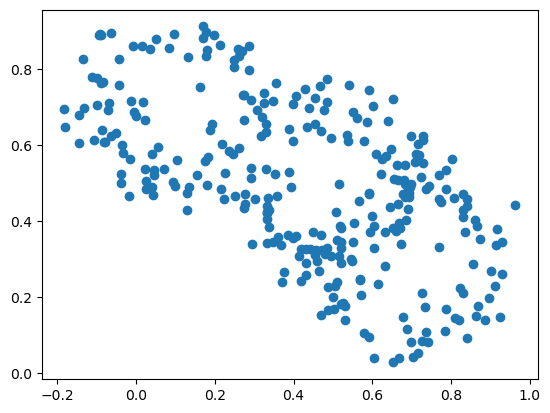

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def my_make_circles(n):
# Parameters for the circle clusters
    n_points_per_cluster = n // 3  # Number of points in each cluster
    noise_std = 0.05  # Standard deviation of noise

# Cluster centers
    centers = [(0.5, 0.5), (0.7, 0.3), (0.1, 0.7)]

# Radius for clusters
    radius = 0.2

# Generate clusters
    data = []
    for center_x, center_y in centers:
        angles = np.random.uniform(0, 2 * np.pi, n_points_per_cluster)
        x = center_x + radius * np.cos(angles) + np.random.normal(0, noise_std, n_points_per_cluster)
        y = center_y + radius * np.sin(angles) + np.random.normal(0, noise_std, n_points_per_cluster)
        data.append(np.column_stack((x, y)))
    

    data = np.vstack(data)

    return data

data = my_make_circles(300)

x = [ coord[0] for coord in data]
y= [coord[1] for coord in data]

plt.scatter(x,y)



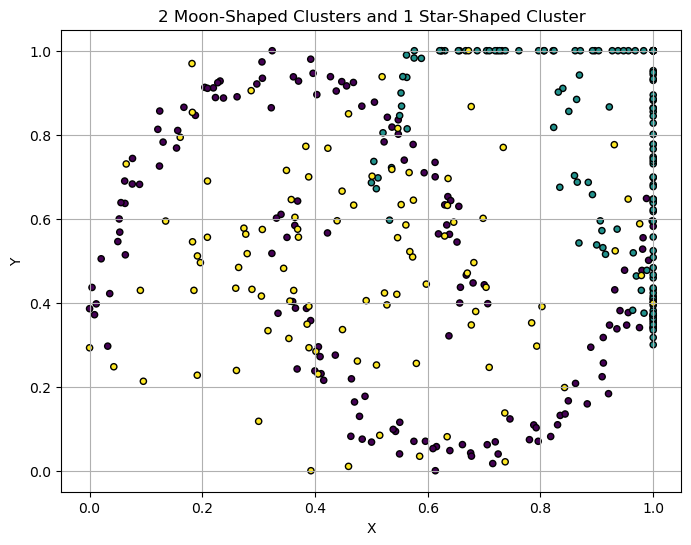

array([[0.36529315, 0.3870982 ],
       [0.93177551, 0.43068162],
       [0.46809742, 0.92446852],
       [0.99823447, 0.59464035],
       [0.06228499, 0.68971636],
       [0.48371246, 0.07517952],
       [0.7152991 , 0.01707935],
       [0.43759664, 0.9040207 ],
       [0.92069735, 0.18339155],
       [0.4559688 , 0.91621906],
       [0.61540125, 0.05735961],
       [0.07579087, 0.68262666],
       [0.36156205, 0.93783954],
       [0.79597937, 0.0700831 ],
       [0.15636236, 0.81010037],
       [0.05255822, 0.59940103],
       [1.        , 0.58187622],
       [0.18775323, 0.84611192],
       [0.48303867, 0.86795423],
       [0.22334531, 0.88850023],
       [0.54766975, 0.83548881],
       [0.39649584, 0.94619568],
       [0.13040701, 0.78243095],
       [0.91154977, 0.25647292],
       [0.661507  , 0.06221256],
       [0.71977345, 0.06872111],
       [0.33966042, 0.61035163],
       [0.12400752, 0.72537136],
       [0.550351  , 0.11533242],
       [0.02056309, 0.50459247],
       [0.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

def generate_star_cluster(center, num_points, radius_range):
    """
    Generate points in a star-shaped cluster centered at a given point.

    Parameters:
        center (tuple): Coordinates of the center of the star (x, y).
        num_points (int): Number of points in the star cluster.
        radius_range (tuple): Range of radii for the star points (min_radius, max_radius).

    Returns:
        numpy.ndarray: Points in the star-shaped cluster.
    """
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    radii = np.random.uniform(*radius_range, size=num_points)
    # Star effect: alternating radii
    radii[::2] *= 0.5
    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)
    return np.column_stack((x, y))

# Generate two moon-shaped clusters
moon_1, _ = make_moons(n_samples=150, noise=0.05)
moon_1 = (moon_1 - moon_1.min(axis=0)) / (moon_1.max(axis=0) - moon_1.min(axis=0))  # Normalize to [0, 1]

moon_2 = moon_1 + np.array([0.5, 0.3])  # Shift the second moon
moon_2 = np.clip(moon_2, 0, 1)  # Ensure points remain in [0, 1]

# Generate star-shaped cluster
star = generate_star_cluster(center=(0.25, 0.25), num_points=100, radius_range=(0.05, 0.15))
star = (star - star.min(axis=0)) / (star.max(axis=0) - star.min(axis=0))  # Normalize to [0, 1]

# Combine all clusters
data = np.vstack([moon_1, moon_2, star])
labels = np.array([0] * len(moon_1) + [1] * len(moon_2) + [2] * len(star))

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=20, edgecolor='k')
plt.title("2 Moon-Shaped Clusters and 1 Star-Shaped Cluster")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

data


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


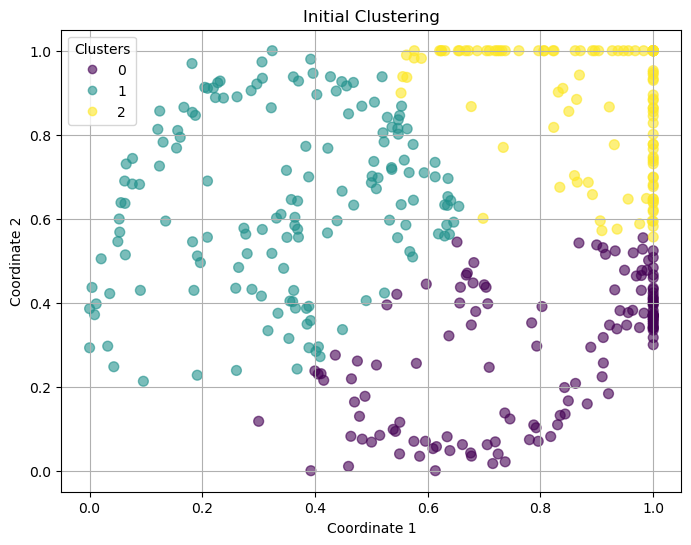

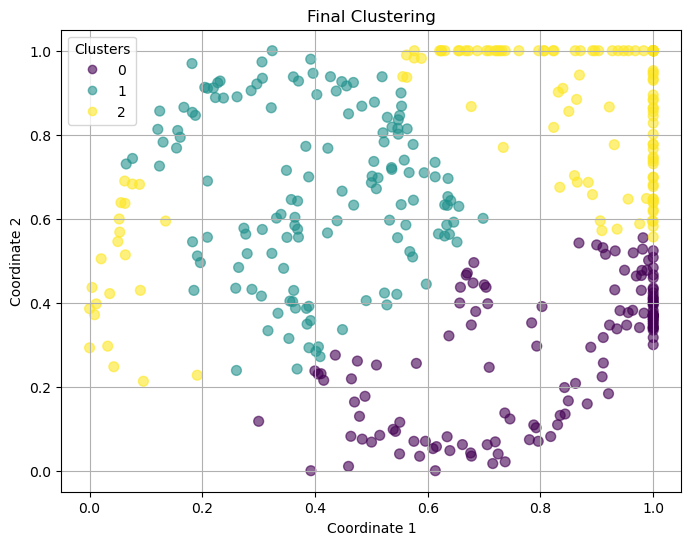

0.32005120575102053
0.40070928603406253
1.430306933414457
0.849320125055506


In [31]:

# Parameters
n = 200  # Number of agents
d =  2   # Number of traits
l1,l2 = 0.1, 2
k1,k2 = 0.2, 1

# Generate agents and initial clustering
agents = data
friend_edges, enemy_edges = calculate_relationships(agents, l1, l2, k1, k2)
friend_graph = create_graph(friend_edges, len(agents))
enemy_graph = create_graph(enemy_edges, len(agents))


init_labels = kmeans.fit_predict(agents)
initial_clustering = {i: init_labels[i] for i in range(len(agents))}
plot_clustering(agents, initial_clustering, "Initial Clustering")
# Perform clustering
final_clustering = locally_popular_clustering(agents, friend_graph, enemy_graph, initial_clustering)


# Plot initial and final clusters

plot_clustering(agents, final_clustering, "Final Clustering")

print(silhouette_score(agents, list(final_clustering.values())))
print(silhouette_score(agents, init_labels))


print(davies_bouldin_score(agents, list(final_clustering.values())))
print(davies_bouldin_score(agents, init_labels))

In [ ]:
def initialize_clustering(agents, method, n_clusters=None, eps=None, min_samples=None):
    """Initialize clustering using various methods."""
    n = len(agents)
    if method == 'alone':
        return {i: i for i in range(n)}
    elif method == 'together':
        return {i: 0 for i in range(n)}
    elif method == 'kmeans':
        if n_clusters is None:
            raise ValueError("Number of clusters (n_clusters) must be specified for k-means.")
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(agents)
        return {i: labels[i] for i in range(n)}
    elif method == 'dbscan':
        if eps is None or min_samples is None:
            raise ValueError("Parameters eps and min_samples must be specified for DBSCAN.")
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='manhattan')
        labels = dbscan.fit_predict(agents)
        return {i: labels[i] if labels[i] != -1 else max(labels) + 1 for i in range(n)}
    else:
        raise ValueError("Unknown initialization method.")

In [89]:
n = 3000000  # Number of agents
d =  2   # Number of traits
l1,l2 = 0.2, 2
k1,k2 = 0.3, 1

# Generate agents and initial clustering
agents = my_make_circles(n)



init_labels = kmeans.fit_predict(agents)

In [91]:
for k in range(10):
    n = 10 ** k
    for i in range(n):
        for j in range(n):
            pass
    print(f"{k} lefut")


0 lefut
1 lefut
2 lefut
3 lefut
4 lefut


KeyboardInterrupt: 

In [130]:
from time import time

l_1,l_2,k_1,k_2 = 0.1, 2, 0.7, 1
for exp in range(7):
    agents = my_make_circles(3*(3**exp))
    start = time()
    friend_edges, enemy_edges = calculate_relationships(agents, l1, l2, k1, k2)
    print(f"{exp} : {time()-start}")

0 : 0.07934021949768066
1 : 0.00101470947265625
2 : 0.0059969425201416016
3 : 0.040000200271606445
4 : 0.3306713104248047
5 : 2.6968462467193604
6 : 25.669328689575195


In [133]:
l_1,l_2,k_1,k_2 = 0.1, 2, 0.7, 1
for exp in range(7):
    n = 3*(3**exp)
    agents = my_make_circles(n)
    init_labels = kmeans.fit_predict(agents)
    initial_clustering = {i: i%10 for i in range(n)}

    start = time()
    friend_edges, enemy_edges = calculate_relationships(agents, l1, l2, k1, k2)
    friend_graph = create_graph(friend_edges, n)
    enemy_graph = create_graph(enemy_edges, n)
    print(f"Generation: {exp} : {time()-start}")
    start = time()
    final_clustering = locally_popular_clustering(agents, friend_graph, enemy_graph, initial_clustering)
    print(f"Clustering: {exp} : {time()-start}")



C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Generation: 0 : 0.5102243423461914
0
Clustering: 0 : 0.0
Generation: 1 : 0.0010380744934082031
2
Clustering: 1 : 0.0
Generation: 2 : 0.006081342697143555
21
Clustering: 2 : 0.003998279571533203
Generation: 3 : 0.05651712417602539
88
Clustering: 3 : 0.02899956703186035


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

Generation: 4 : 0.3622474670410156
314
Clustering: 4 : 0.19439363479614258


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Generation: 5 : 3.2236828804016113
1066
Clustering: 5 : 1.951551914215088
Generation: 6 : 27.544774532318115
3147
Clustering: 6 : 18.416123390197754


In [161]:

friend_edges = []
enemy_edges = []
G_E = nx.Graph()
G_F = nx.Graph()
G_E.add_nodes_from(range(400000))
G_F.add_nodes_from(range(400000))
for i in range(200000):
    friends_and_enemies = random.sample(range(200000, 399990), 10)
    for j in friends_and_enemies[:5]:
        friend_edges.append((i,j))
    for j in friends_and_enemies[5:]:
        enemy_edges.append((i,j))
G_F.add_edges_from(friend_edges)
G_E.add_edges_from(enemy_edges)

In [162]:
initial_clustering = {i : i%3 for i in range(400000)}
agents = [i for i in range(400000) ]
start = time()
locally_popular_clustering(agents, G_F ,G_E, initial_clustering)
print(time()-start)

KeyboardInterrupt: 

In [ ]:
"""
UNFINISHED  - I started the super efficient implementation from the paper here, but I dont think it's needed, it would be very complicated to implement.
"""

def locally_popular_clustering(agents, friendship_graph, enemy_graph, initial_clustering, allow_exit=False):
    """Perform clustering to achieve local popularity."""
    # Initialize clustering and cluster-to-agents mapping
    clustering = initial_clustering.copy()  # Map agent to cluster ID
    cluster_to_agents = defaultdict(set)
    for agent, cluster in clustering.items():
        cluster_to_agents[cluster].add(agent)
    
    # Precompute (f, e) values for each agent in all clusters
    f_e_values = defaultdict(lambda: defaultdict(lambda: 0)) # f - e - f_{pi} + e_{pi} 
    ff_e_values = defaultdict(lambda: defaultdict(lambda: 0)) # 2f - e - 2f_{pi} + e_{pi}   - only if f_{pi}-e_{pi} +1 >= f - e >= f_{pi} + e_{pi} 
    for v in range(len(agents)):
        own_cluster = clustering[v]
        friends_in_pi = sum(1 for neighbor in friendship_graph.neighbors(v) if neighbor in cluster_to_agents[own_cluster])
        enemies_in_pi = sum(1 for neighbor in enemy_graph.neighbors(v) if neighbor in cluster_to_agents[own_cluster])
        for cluster in cluster_to_agents:
            friends_in_cluster = sum(1 for neighbor in friendship_graph.neighbors(v) if neighbor in cluster_to_agents[cluster])
            enemies_in_cluster = sum(1 for neighbor in enemy_graph.neighbors(v) if neighbor in cluster_to_agents[cluster])
            f_e_values[v][cluster] = [friends_in_cluster - enemies_in_cluster,  friends_in_pi - enemies_in_pi]
            if friends_in_pi - enemies_in_pi + 1 >= friends_in_cluster - enemies_in_cluster and friends_in_cluster - enemies_in_cluster >= friends_in_pi - enemies_in_pi:
                ff_e_values[v][cluster] = [2*friends_in_cluster - enemies_in_cluster,  2*friends_in_pi - enemies_in_pi]
            else:
                ff_e_values[v][cluster] = [float('-inf') ,  0] # could be just 0

    # Now the idea is to keep the rows and the columns sorted - we just keep sorted lists of the keys for this
    SORTED_f_e_values = {}
    SORTED_f_e_values = {}
    for v in range(len(agents)):
        SORTED_f_e_values[v] = SortedList([[item[0], item[1][0], item[1][1]] for item in f_e_values[v].items()], key=lambda x: - (x[1][0]-x[1][1]) # now each row (vertex) has the values in decreasing order
        SORTED_ff_e_values[v] = SortedList([[item[0], item[1][0], item[1][1]] for item in ff_e_values.items(), key=lambda x: -(x[1][0]-x[1][1]) )  # cluster_score - pi_score

    """ Now we sort the rows """
    SORTED_f_e_keys = SortedList( [ item[0], item[1][0] ] for item in SORTED_f_e_values.items(), key=lambda x: -x[1][0][1]) # item[0] is the agent, item[1] is list of tuples

    SORTED_ff_e_keys = SortedList( [ item[0], item[1][0] ] for item in SORTED_ff_e_values.items(), key=lambda x: -x[1][0][1])
    
    stable = False
    num_switches = 0
    while not stable:
        stable = True

        # Get the first key of the outer dictionary
        v_1 = SORTED_f_e_keys[0][0]
    
  # Get the first key-value pair from the inner dictionary
        cluster_1, cluster_1_f_e_value = SORTED_f_e_keys[0][1][0] , SORTED_f_e_keys[0][1][1]

        v_2 = SORTED_ff_e_keys[0][1][0] 

        cluster_2, cluster_2_f_e_value = SORTED_ff_e_keys[0][1][0] , SORTED_ff_e_keys[0][1][1]

        if cluster_1_f_e_value <= 1 and custer_2_f_e_value <= 0: # Locally-popular
            break

        else:
            if cluster_1_fe_value >= 2:
                v, cluster = v_1, cluster_1
            elif cluster_2_f_e_value >=1:  # cluster_1_fe_value is always >=0, as in row v, C=pi (v) has f-e value 0
                v, cluster = v_2, cluster_2

            stable = False
            num_switches += 1
            current_cluster = clustering[v]
            
            # Update cluster mappings
            cluster_to_agents[current_cluster].remove(v)    
            clustering[v] = cluster
            cluster_to_agents[cluster].add(v)

            # Update the tables
            for neighbor in friendship_graph.neighbors(v):
                if neighbor in cluster_to_agents(cluster):  # 
                    f_e_values[neighbor][current_cluster] -= 1  # Friend leaves
                    f_e_values[neighbor][cluster] += 1  # Friend joins
                
            for neighbor in enemy_graph.neighbors(v):
                if neighbor in clustering:  # Only update if neighbor exists in the clustering
                    f_e_values[neighbor][current_cluster][1] -= 1  # Enemy leaves
                    f_e_values[neighbor][best_move][1] += 1  # Enemy joins
               
            print(f"{v} swithces to {cluster}")
            
                break
    print(num_switches)
    return clustering

"""
BACKUP
"""

def locally_popular_clustering(agents, friendship_graph, enemy_graph, initial_clustering, allow_exit=False):
    """Perform clustering to achieve local popularity."""
    # Initialize clustering and cluster-to-agents mapping
    clustering = initial_clustering.copy()  # Map agent to cluster ID
    cluster_to_agents = defaultdict(set)
    for agent, cluster in clustering.items():
        cluster_to_agents[cluster].add(agent)
    
    # Precompute (f, e) values for each agent in all clusters
    f_e_values = defaultdict(lambda: defaultdict(lambda: [0, 0]))  # {agent: {cluster: [f, -e]}}
    for v in range(len(agents)):
        for cluster in cluster_to_agents:
            friends_in_cluster = sum(1 for neighbor in friendship_graph.neighbors(v) if neighbor in cluster_to_agents[cluster])
            enemies_in_cluster = sum(1 for neighbor in enemy_graph.neighbors(v) if neighbor in cluster_to_agents[cluster])
            f_e_values[v][cluster] = [friends_in_cluster, enemies_in_cluster]

    stable = False
    num_switches = 0
    while not stable:
        stable = True

        for v in range(len(agents)):
            current_cluster = clustering[v]
            [f_current, e_current] = f_e_values[v][current_cluster]  
            best_move = None
            best_vote = 0  # Track best improvement (f, -e)
            block = False
            # Evaluate moves to existing clusters
            for candidate_cluster in cluster_to_agents:
                if candidate_cluster == current_cluster:
                    continue
               
                [f_target, e_target] = f_e_values[v][candidate_cluster]
                vote = 0
                current_score = f_current - e_current
                new_score = f_target - e_target
                if new_score > current_score + 1 or (new_score >= current_score and new_score + f_target > current_score + f_current):
                    # Improvement detected
                    vote = f_target - e_target - f_current + e_current
                    block = True
                if f_target > f_current or (f_target == f_current and e_target < e_current):
                    vote += 1 # v improves
                if block and vote > best_vote:
                    best_move = candidate_cluster
                    best_vote = vote
            
            # Evaluate exit (if allowed)
            if allow_exit:
                vote = 0
                if 0 > f_current-e_current + 1 or (0 >= 2* f_current - e_current + 1 and 0 >= f_current-e_current):
                    vote = -f_current + e_current 
                    block = True
                if f_current == 0 and e_current > 0:
                    vote += 1 # v improves
                if block and vote > best_vote:
                    best_move = "exit"
                    best_vote = vote

            # Make the best move if it's an improvement
            if best_move is not None:
                stable = False
                
                # Update cluster mappings
                cluster_to_agents[current_cluster].remove(v)
                if best_move == "exit":  # Create a new cluster for this agent
                    new_cluster_id = max(cluster_to_agents.keys()) + 1
                    clustering[v] = new_cluster_id
                    cluster_to_agents[new_cluster_id].add(v)
                    best_move = new_cluster_id
                else:
                    clustering[v] = best_move
                    cluster_to_agents[best_move].add(v)

                # Update (f, e) values for affected agents
                for neighbor in friendship_graph.neighbors(v):
                    if neighbor in clustering:  # Only update if neighbor exists in the clustering
                        f_e_values[neighbor][current_cluster][0] -= 1  # Friend leaves
                        f_e_values[neighbor][best_move][0] += 1  # Friend joins
                
                for neighbor in enemy_graph.neighbors(v):
                    if neighbor in clustering:  # Only update if neighbor exists in the clustering
                        f_e_values[neighbor][current_cluster][1] -= 1  # Enemy leaves
                        f_e_values[neighbor][best_move][1] += 1  # Enemy joins
                num_switches += 1
               # print(f"{v} swithces to {best_move}")
               # print(f"{f_e_values[v][current_cluster]}")
               # print(f"{f_e_values[v][best_move]}")
                break
    print(num_switches)
    return clustering
